In [ ]:
# ================================
# ONE-CELL COLAB PIPELINE
# LLM-guided design loop for 1D-gated 2D FETs (surrogate-based)
# OpenRouter + self-refine + Pareto search
# Author: Youla Yang
# ================================

!pip -q install openai pandas numpy scikit-learn xgboost matplotlib tqdm

import os, json, re, math, random, time
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

# -----------------------------
# 0) OpenRouter setup
# -----------------------------
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "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")
BASE_URL = "https://openrouter.ai/api/v1"

from openai import OpenAI
client = OpenAI(api_key=OPENROUTER_API_KEY, base_url=BASE_URL)

# Choose models you want to benchmark
MODELS = [
    "openai/gpt-4.1",
    # "anthropic/claude-3.5-sonnet",
    # "google/gemini-2.0-flash-001",
]

# -----------------------------
# 1) Data: synthetic generator or load CSV
# -----------------------------
USE_SYNTHETIC = True
CSV_PATH = "/content/device_dataset.csv"  # if USE_SYNTHETIC=False, upload CSV then set path

# Parameter bounds (feel free to edit)
BOUNDS = {
    "Lg_nm": (0.34, 10.0),        # gate length
    "tox_nm": (1.0, 10.0),        # oxide thickness
    "kappa": (3.9, 25.0),         # dielectric constant
    "Vdd_V": (0.3, 0.8),          # supply
    "Rcontact_ohm_um": (50, 1000),# contact resistance
    "Ndefect_1e12cm2": (0.1, 5.0),# interface defect density proxy
    "MTB_align": (0.0, 1.0),      # 0~1 alignment quality proxy
}

def clamp(x, lo, hi):
    return float(max(lo, min(hi, x)))

def sample_params(n):
    rows = []
    for _ in range(n):
        row = {}
        for k,(lo,hi) in BOUNDS.items():
            row[k] = lo + (hi-lo)*random.random()
        rows.append(row)
    return pd.DataFrame(rows)

def synthetic_device_metrics(df):
    """
    Physics-inspired toy generator (NOT TCAD):
    Produces Ion_uAum, Ioff_nAum, SS_mVdec, DIBL_mV_V, RelScore
    Intended to preserve qualitative trade-offs:
      - shorter Lg improves Ion but worsens Ioff, SS, DIBL
      - thinner tox + higher kappa improves electrostatics (better SS, lower DIBL) but may increase leakage proxy
      - higher defects worsen SS and reliability
      - better MTB alignment helps effective gating / lower variability
    """
    Lg = df["Lg_nm"].values
    tox = df["tox_nm"].values
    kappa = df["kappa"].values
    Vdd = df["Vdd_V"].values
    Rc = df["Rcontact_ohm_um"].values
    Nd = df["Ndefect_1e12cm2"].values
    A = df["MTB_align"].values

    # electrostatic control factor (higher is better)
    E = (kappa/tox) * (A + 0.2) / (Lg**0.6)
    E = np.clip(E, 0.01, None)

    # Ion (uA/um): increases with Vdd, E; decreases with Rc
    Ion = 200*Vdd*(E**0.8) * (1.0/(1.0 + Rc/200.0))
    Ion *= (1.0 + 0.05*np.random.randn(len(df)))
    Ion = np.clip(Ion, 0.1, None)

    # Ioff (nA/um): worsens with short Lg, thin tox, lower E, defects
    Ioff = 5*(Lg**-1.3) * (1.0 + 0.6*Nd) * (tox**-0.6) * (1.2/(A+0.3))
    Ioff *= (1.0 + 0.10*np.random.randn(len(df)))
    Ioff = np.clip(Ioff, 0.01, None)

    # SS (mV/dec): improves with E, worsens with defects
    SS = 60 + 120*(1.0/(E+0.3)) + 10*Nd
    SS *= (1.0 + 0.03*np.random.randn(len(df)))
    SS = np.clip(SS, 55, 250)

    # DIBL (mV/V): worsens with short Lg and weak electrostatics
    DIBL = 25 + 140*(Lg**-0.9) + 80*(1.0/(E+0.2))
    DIBL *= (1.0 + 0.05*np.random.randn(len(df)))
    DIBL = np.clip(DIBL, 20, 350)

    # Reliability proxy (higher is better): penalize defects, high field (Vdd/tox), and leakage
    field = Vdd/tox
    Rel = 1.0/(1.0 + 0.8*Nd + 0.6*field + 0.2*np.log10(Ioff+1e-6))
    Rel *= (1.0 + 0.03*np.random.randn(len(df)))
    Rel = np.clip(Rel, 0.01, 1.0)

    out = df.copy()
    out["Ion_uAum"] = Ion
    out["Ioff_nAum"] = Ioff
    out["SS_mVdec"] = SS
    out["DIBL_mV_V"] = DIBL
    out["RelScore"] = Rel
    return out

if USE_SYNTHETIC:
    df = sample_params(6000)
    df = synthetic_device_metrics(df)
    df.to_csv("device_dataset_synth.csv", index=False)
    print("✅ Generated synthetic dataset:", df.shape, "-> device_dataset_synth.csv")
else:
    df = pd.read_csv(CSV_PATH)
    print("✅ Loaded dataset:", df.shape)

PARAM_COLS = list(BOUNDS.keys())
TARGETS = ["Ion_uAum", "Ioff_nAum", "SS_mVdec", "DIBL_mV_V", "RelScore"]

assert all(c in df.columns for c in PARAM_COLS), "Missing param columns."
assert all(t in df.columns for t in TARGETS), "Missing target columns."

# -----------------------------
# 2) Train surrogate models
# -----------------------------
X = df[PARAM_COLS].astype(float)
surrogates = {}
scores = {}

Xtr, Xte, ytr_all, yte_all = train_test_split(X, df[TARGETS], test_size=0.2, random_state=42)

for t in TARGETS:
    ytr = ytr_all[t].values
    yte = yte_all[t].values

    model = XGBRegressor(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=0,
    )
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    r2 = r2_score(yte, pred)
    surrogates[t] = model
    scores[t] = r2

print("✅ Surrogate R^2:")
for k,v in scores.items():
    print(f"  {k:10s}: {v:.3f}")

# -----------------------------
# 3) Objective + constraints
# -----------------------------
# We want: high Ion, low Ioff, low SS, low DIBL, high RelScore
# Convert to a single scalar "utility" for selection; also keep Pareto set.
def evaluate_params(params_dict):
    x = pd.DataFrame([params_dict])[PARAM_COLS].astype(float)
    pred = {t: float(surrogates[t].predict(x)[0]) for t in TARGETS}

    # Constraints (edit as you like)
    # Example: SS <= 120 mV/dec, Ioff <= 10 nA/um, RelScore >= 0.35
    feasible = (pred["SS_mVdec"] <= 120.0) and (pred["Ioff_nAum"] <= 10.0) and (pred["RelScore"] >= 0.35)

    # Utility (normalized-ish)
    util = (
        + 1.5 * math.log10(pred["Ion_uAum"] + 1e-6)
        - 1.2 * math.log10(pred["Ioff_nAum"] + 1e-6)
        - 0.010 * pred["SS_mVdec"]
        - 0.006 * pred["DIBL_mV_V"]
        + 1.0 * pred["RelScore"]
    )
    pred["feasible"] = feasible
    pred["utility"] = util
    return pred

def random_candidate():
    cand = {}
    for k,(lo,hi) in BOUNDS.items():
        cand[k] = lo + (hi-lo)*random.random()
    # small rounding for readability
    for k in cand:
        cand[k] = float(np.round(cand[k], 4))
    return cand

# -----------------------------
# 4) LLM propose + self-refine
# -----------------------------
SYSTEM = """You are a device-design assistant for ultrascaled 1D-gated 2D FETs.
Return ONLY valid JSON with the exact keys:
Lg_nm, tox_nm, kappa, Vdd_V, Rcontact_ohm_um, Ndefect_1e12cm2, MTB_align
No extra keys, no prose.
Choose values within provided bounds.
"""

def json_from_text(txt):
    # Extract first JSON object
    m = re.search(r"\{.*\}", txt, flags=re.S)
    if not m:
        raise ValueError("No JSON found.")
    obj = json.loads(m.group(0))
    # clamp + ensure all keys
    for k,(lo,hi) in BOUNDS.items():
        if k not in obj:
            raise KeyError(f"Missing key {k}")
        obj[k] = clamp(float(obj[k]), lo, hi)
    # keep only allowed keys
    obj = {k: float(obj[k]) for k in BOUNDS.keys()}
    return obj

def llm_propose(model_name, bounds, last_feedback=None, seed_hint=None):
    bounds_text = "\n".join([f"- {k}: [{lo}, {hi}]" for k,(lo,hi) in bounds.items()])
    user_msg = f"""Bounds:
{bounds_text}
Goal: maximize Ion, minimize Ioff/SS/DIBL, maximize RelScore, and satisfy constraints SS<=120, Ioff<=10, RelScore>=0.35.
Propose ONE candidate parameter set."""
    if seed_hint is not None:
        user_msg += f"\nSeed hint (a decent starting point): {json.dumps(seed_hint)}"
    if last_feedback is not None:
        user_msg += f"\nFeedback from previous evaluation: {json.dumps(last_feedback)}\nRevise accordingly."
    resp = client.chat.completions.create(
        model=model_name,
        messages=[
            {"role":"system","content":SYSTEM},
            {"role":"user","content":user_msg},
        ],
        temperature=0.3,
    )
    txt = resp.choices[0].message.content
    return json_from_text(txt)

# -----------------------------
# 5) Run optimization loop
# -----------------------------
N_ROUNDS = 25      # total iterations
N_INIT_RANDOM = 8  # warm start random candidates per model
TOPK_LOG = 10

all_rows = []

for model_name in MODELS:
    print("\n==============================")
    print("Model:", model_name)
    print("==============================")

    # Warm start pool
    pool = []
    for _ in range(N_INIT_RANDOM):
        cand = random_candidate()
        pred = evaluate_params(cand)
        pool.append((cand, pred))
    pool.sort(key=lambda x: x[1]["utility"], reverse=True)
    best = pool[0]
    last_feedback = None

    for r in tqdm(range(N_ROUNDS), desc=f"{model_name} rounds"):
        seed_hint = best[0]
        try:
            cand = llm_propose(model_name, BOUNDS, last_feedback=last_feedback, seed_hint=seed_hint)
        except Exception as e:
            # fallback random
            cand = random_candidate()

        pred = evaluate_params(cand)

        # store
        row = {"model": model_name, "round": r, **cand, **pred}
        all_rows.append(row)

        # update best
        if pred["utility"] > best[1]["utility"]:
            best = (cand, pred)

        # feedback to LLM: include constraint violations and key trade-offs
        last_feedback = {
            "predicted_metrics": {k: float(pred[k]) for k in ["Ion_uAum","Ioff_nAum","SS_mVdec","DIBL_mV_V","RelScore"]},
            "feasible": bool(pred["feasible"]),
            "utility": float(pred["utility"]),
            "notes": (
                ("Feasible." if pred["feasible"] else "Infeasible: fix constraints.")
                + " Try to increase Ion without increasing Ioff/SS/DIBL; improve RelScore by reducing defects/field."
            )
        }

    print("\nBest candidate found:")
    print(json.dumps(best[0], indent=2))
    print("Predicted:", {k: round(best[1][k], 4) for k in ["Ion_uAum","Ioff_nAum","SS_mVdec","DIBL_mV_V","RelScore","utility","feasible"]})

# -----------------------------
# 6) Save + quick plots
# -----------------------------
res = pd.DataFrame(all_rows)
res.to_csv("llm_fet_design_results.csv", index=False)
print("\n✅ Saved:", "llm_fet_design_results.csv", "rows=", len(res))

# Show top results (feasible first)
top = res.sort_values(["feasible","utility"], ascending=[False, False]).head(TOPK_LOG)
display(top[["model","round","feasible","utility","Ion_uAum","Ioff_nAum","SS_mVdec","DIBL_mV_V","RelScore"] + PARAM_COLS])

# Pareto-ish scatter: Ion vs Ioff (feasible)
feas = res[res["feasible"]==True].copy()
if len(feas) > 0:
    plt.figure()
    plt.scatter(feas["Ioff_nAum"], feas["Ion_uAum"], s=10)
    plt.xscale("log")
    plt.xlabel("Ioff (nA/um) [log]")
    plt.ylabel("Ion (uA/um)")
    plt.title("Feasible candidates: Ion vs Ioff")
    plt.show()

    plt.figure()
    plt.scatter(feas["SS_mVdec"], feas["Ion_uAum"], s=10)
    plt.xlabel("SS (mV/dec)")
    plt.ylabel("Ion (uA/um)")
    plt.title("Feasible candidates: Ion vs SS")
    plt.show()
else:
    print("⚠️ No feasible points found under current constraints. Loosen constraints or increase rounds.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.9/252.9 kB 18.5 MB/s eta 0:00:00
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
Keywords: Field-effect transistor, Logic gates, MoS2
Publication date: 2025-02-06
DOI: 10.5281/zenodo.14825422
Total size: 1.6 MB

File: Figures.zip (1.6 MB)
Link: https://zenodo.org/api/records/14825422/files/Figures.zip/content

Checksum is correct for Figures.zip. (7b0cfeeaf82d78f001baecbd5c53faf1)

File: Readme.pdf (44.4 kB)
Link: https://zenodo.org/api/records/14825422/files/Readme.pdf/content

Checksum is correct for Readme.pdf. (6e8f05a1aafe69a5eb224586c2dadff5)

All specified files have been processed.
Unzipping: Figures.zip

Top-level files:
total 1.6M
drwxr-xr-x 6 root root 4.0K Dec 20 16:08 .
drwxr-xr-x 1 root root 4.0K Dec 20 16:08 ..
dr-xr-xr-x 2 root root 4.0K Feb  6  2025 Figur

path                  name  \
13         /content/zenodo_data/Figure 2/Figure 2.pdf          Figure 2.pdf   
7          /content/zenodo_data/Figure 4/Figure 4.pdf          Figure 4.pdf   
2          /content/zenodo_data/Figure 1/Figure 1.pdf          Figure 1.pdf   
3          /content/zenodo_data/Figure 3/Figure 3.pdf          Figure 3.pdf   
1                     /content/zenodo_data/Readme.pdf            Readme.pdf   
0                    /content/zenodo_data/Figures.zip           Figures.zip   
8        /content/zenodo_data/Figure 4/Figure 4 c.csv        Figure 4 c.csv   
10   /content/zenodo_data/Figure 2/Figure 2 d set.csv    Figure 2 d set.csv   
5        /content/zenodo_data/Figure 3/Figure 3 b.csv        Figure 3 b.csv   
6       /content/zenodo_data/Figure 4/Figure 4 ab.csv       Figure 4 ab.csv   
4        /content/zenodo_data/Figure 3/Figure 3 a.csv        Figure 3 a.csv   
9   /content/zenodo_data/Figure 2/Figure 2 c blue.csv   Figure 2 c blue.csv   
12   /content/zenodo_data/Figure 2/Figure 2 c red.csv    Figure 2 c red.csv   
11  /content/zenodo_data/Figure 2/Figure 2 d black...  Figure 2 d black.csv   

   suffix    bytes     kind_guess  
13   .pdf   334625  figure_or_pdf  
7    .pdf   217839  figure_or_pdf  
2    .pdf   118241  figure_or_pdf  
3    .pdf   104002  figure_or_pdf  
1    .pdf    44394  figure_or_pdf  
0    .zip  1565740          other  
8    .csv  2867085  table_or_text  
10   .csv   340893  table_or_text  
5    .csv   170072  table_or_text  
6    .csv    77877  table_or_text  
4    .csv    21210  table_or_text  
9    .csv    15774  table_or_text  
12   .csv    14605  table_or_text  
11   .csv     9563  table_or_text


Candidate table/text files: 8


/tmp/ipython-input-3530155590.py:78: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  kw["time"] = datetime.utcnow().isoformat() + "Z"
/tmp/ipython-input-3530155590.py:78: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  kw["time"] = datetime.utcnow().isoformat() + "Z"
/tmp/ipython-input-3530155590.py:78: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  kw["time"] = datetime.utcnow().isoformat() + "Z"
/tmp/ipython-input-3530155590.py:78: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in 


✅ Extracted records: 6
⚠️ Failed/Skipped: 2
✅ Wrote /content/failed_or_skipped.csv and /content/extraction_log.jsonl

✅ Wrote /content/device_dataset.csv


/tmp/ipython-input-3530155590.py:78: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  kw["time"] = datetime.utcnow().isoformat() + "Z"


source_file file_suffix  Vg_min_V  \
0   /content/zenodo_data/Figure 2/Figure 2 d set.csv        .csv      -1.0   
1       /content/zenodo_data/Figure 3/Figure 3 b.csv        .csv      -0.8   
2       /content/zenodo_data/Figure 3/Figure 3 a.csv        .csv      -1.5   
3  /content/zenodo_data/Figure 2/Figure 2 c blue.csv        .csv      -1.5   
4   /content/zenodo_data/Figure 2/Figure 2 c red.csv        .csv      -2.0   
5  /content/zenodo_data/Figure 2/Figure 2 d black...        .csv       2.7   

   Vg_max_V       Ion_A        Ioff_A    SS_mVdec  DIBL_mV_V  n_points  \
0       2.7  488.535849  8.880000e-05  316.154970        NaN     14418   
1       2.8  362.209375  7.113937e-04  361.402224        NaN      8010   
2       2.0    8.987756  3.515327e-07  434.772832        NaN       801   
3       1.0    2.192283  1.834467e-03  312.247684        NaN       802   
4       1.0    6.707033  7.500000e-05  215.386362        NaN       802   
5       2.7  552.494340  1.504004e+00         NaN        NaN       401   

                                         assumptions  
0  Ion/Ioff from extrema of |Id|; SS via best sli...  
1  Ion/Ioff from extrema of |Id|; SS via best sli...  
2  Ion/Ioff from extrema of |Id|; SS via best sli...  
3  Ion/Ioff from extrema of |Id|; SS via best sli...  
4  Ion/Ioff from extrema of |Id|; SS via best sli...  
5  Ion/Ioff from extrema of |Id|; SS via best sli...

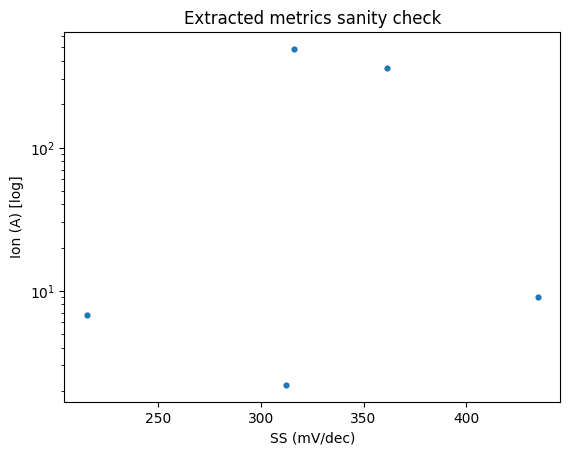


Done.


In [ ]:
# ================================
# ONE-CELL COLAB PIPELINE (REAL DATA)
# Auto-download Zenodo record -> scan -> parse -> extract I-V metrics
# Output: device_dataset.csv + manifest_files.csv + extraction_log.jsonl
# ================================

!pip -q install zenodo-get pandas numpy matplotlib openpyxl pyarrow

import os, re, json, math, glob, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path

# -----------------------------
# 0) Download from Zenodo (MoS2 ultrascaled dataset)
# -----------------------------
DOI = "10.5281/zenodo.14825422"   # public record
ROOT = Path("/content/zenodo_data")
ROOT.mkdir(parents=True, exist_ok=True)

print("Downloading Zenodo record:", DOI)
!zenodo_get {DOI} -o /content/zenodo_data

# Unzip any zips
zips = list(ROOT.rglob("*.zip"))
for z in zips:
    print("Unzipping:", z.name)
    !unzip -o "{str(z)}" -d "{str(z.parent)}" >/dev/null || true

print("\nTop-level files:")
!ls -lah /content/zenodo_data | head -n 200

# -----------------------------
# 1) Scan directory & build manifest
# -----------------------------
def guess_kind(p: Path):
    suf = p.suffix.lower()
    if suf in [".csv", ".tsv", ".txt"]:
        return "table_or_text"
    if suf in [".xlsx", ".xls"]:
        return "excel"
    if suf in [".parquet"]:
        return "parquet"
    if suf in [".json", ".jsonl"]:
        return "json"
    if suf in [".mat", ".npz", ".npy"]:
        return "array"
    if suf in [".png", ".jpg", ".jpeg", ".pdf", ".svg"]:
        return "figure_or_pdf"
    return "other"

files = [p for p in ROOT.rglob("*") if p.is_file()]
manifest = []
for p in files:
    manifest.append({
        "path": str(p),
        "name": p.name,
        "suffix": p.suffix.lower(),
        "bytes": p.stat().st_size,
        "kind_guess": guess_kind(p),
    })
manifest_df = pd.DataFrame(manifest).sort_values(["kind_guess","bytes"], ascending=[True, False])
manifest_df.to_csv("/content/manifest_files.csv", index=False)
print("\n✅ Wrote /content/manifest_files.csv (file inventory)")

display(manifest_df.head(30))

# -----------------------------
# 2) Helpers: detect columns & extract metrics from Id-Vg
# -----------------------------
LOG_PATH = Path("/content/extraction_log.jsonl")
LOG_PATH.write_text("")  # reset

def log_event(**kw):
    kw["time"] = datetime.utcnow().isoformat() + "Z"
    with open(LOG_PATH, "a", encoding="utf-8") as f:
        f.write(json.dumps(kw, ensure_ascii=False) + "\n")

def normalize_cols(df):
    df2 = df.copy()
    df2.columns = [re.sub(r"\s+", "", str(c)).lower() for c in df2.columns]
    return df2

def find_col(df, candidates):
    cols = list(df.columns)
    for c in candidates:
        if c in cols:
            return c
    # fuzzy contains
    for c in candidates:
        for col in cols:
            if c in col:
                return col
    return None

def safe_numeric(s):
    return pd.to_numeric(s, errors="coerce")

def extract_metrics_from_id_vg(df_raw, meta):
    """
    Expect columns: Vg, Id (optionally Vd, device_id, W, L, temp, etc.)
    Compute:
      Ion: max |Id| at highest Vg
      Ioff: min |Id| at lowest Vg (or near 0V)
      SS: best linear fit slope of log10(|Id|) vs Vg over a window (mV/dec)
      DIBL: if multiple Vd curves exist, estimate using Vth shift between two Vd levels
    """
    df = normalize_cols(df_raw)

    vg_col = find_col(df, ["vg", "vgs", "gatev", "v_g", "vgs(v)", "v_gate"])
    id_col = find_col(df, ["id", "ids", "is", "draini", "i_d", "current", "ids(a)"])
    vd_col = find_col(df, ["vd", "vds", "drainv", "v_d", "vds(v)"])

    if vg_col is None or id_col is None:
        return None, "missing_vg_or_id"

    df = df[[c for c in [vg_col, id_col, vd_col] if c is not None]].copy()
    df[vg_col] = safe_numeric(df[vg_col])
    df[id_col] = safe_numeric(df[id_col])
    if vd_col is not None:
        df[vd_col] = safe_numeric(df[vd_col])

    df = df.dropna(subset=[vg_col, id_col])
    if len(df) < 20:
        return None, "too_few_points"

    # Use absolute current for robustness across sign conventions
    vg = df[vg_col].values
    Id = np.abs(df[id_col].values) + 1e-30

    # Ion/Ioff
    # Ion: median of top 3 Id points; Ioff: median of bottom 3 Id points
    Ion = float(np.median(np.sort(Id)[-3:]))
    Ioff = float(np.median(np.sort(Id)[:3]))

    vg_min, vg_max = float(np.nanmin(vg)), float(np.nanmax(vg))

    # SS estimation: sliding window linear fit on log10(Id) vs Vg
    logId = np.log10(Id)
    order = np.argsort(vg)
    vg_s = vg[order]
    log_s = logId[order]

    # choose window size ~10% of points, at least 15
    w = max(15, int(0.10 * len(vg_s)))
    best_ss = None
    best_r2 = -1

    for i in range(0, len(vg_s) - w):
        x = vg_s[i:i+w]
        y = log_s[i:i+w]
        if np.any(~np.isfinite(y)) or (np.nanmax(y) - np.nanmin(y) < 0.3):
            continue
        # linear fit
        A = np.vstack([x, np.ones_like(x)]).T
        m, b = np.linalg.lstsq(A, y, rcond=None)[0]  # y = m*x + b
        yhat = m*x + b
        ss_res = float(np.sum((y - yhat)**2))
        ss_tot = float(np.sum((y - np.mean(y))**2)) + 1e-12
        r2 = 1 - ss_res/ss_tot
        if m <= 0:
            continue
        # SS (mV/dec) = (1/m) * 1000
        ss = (1.0/m) * 1000.0
        if 40 <= ss <= 500 and r2 > best_r2:
            best_r2 = r2
            best_ss = float(ss)

    SS = float(best_ss) if best_ss is not None else np.nan

    # Vth proxy for DIBL: take Vg where Id crosses a reference current (Id_ref)
    def vth_at_vd(sub):
        vgs = sub[vg_col].values
        ids = np.abs(sub[id_col].values) + 1e-30
        o = np.argsort(vgs)
        vgs = vgs[o]; ids = ids[o]
        # reference current: geometric mean between Ioff and Ion (proxy)
        Id_ref = math.sqrt(Ion * Ioff)
        # find crossing
        idx = np.where(ids >= Id_ref)[0]
        if len(idx)==0:
            return np.nan
        j = idx[0]
        if j == 0:
            return float(vgs[0])
        # linear interp in log current domain
        x0, x1 = vgs[j-1], vgs[j]
        y0, y1 = np.log10(ids[j-1]), np.log10(ids[j])
        yr = np.log10(Id_ref)
        if abs(y1-y0) < 1e-12:
            return float(x1)
        return float(x0 + (yr - y0) * (x1 - x0) / (y1 - y0))

    DIBL = np.nan
    if vd_col is not None and df[vd_col].notna().sum() > 0:
        # take two Vd levels: lowest and highest
        vd_vals = df[vd_col].dropna().unique()
        if len(vd_vals) >= 2:
            vd_low = float(np.min(vd_vals))
            vd_high = float(np.max(vd_vals))
            sub_low = df[np.isclose(df[vd_col], vd_low)]
            sub_high = df[np.isclose(df[vd_col], vd_high)]
            if len(sub_low) >= 20 and len(sub_high) >= 20 and abs(vd_high - vd_low) > 1e-6:
                vth_low = vth_at_vd(sub_low)
                vth_high = vth_at_vd(sub_high)
                if np.isfinite(vth_low) and np.isfinite(vth_high):
                    # DIBL (mV/V) = (Vth_low - Vth_high)/(Vd_high - Vd_low)*1000
                    DIBL = float((vth_low - vth_high) / (vd_high - vd_low) * 1000.0)

    out = {
        **meta,
        "Vg_min_V": vg_min,
        "Vg_max_V": vg_max,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "SS_mVdec": SS,
        "DIBL_mV_V": DIBL,
        "n_points": int(len(df)),
        "assumptions": "Ion/Ioff from extrema of |Id|; SS via best sliding-window fit on log10(|Id|) vs Vg; DIBL via Vth shift using Id_ref=sqrt(Ion*Ioff) if multiple Vd curves exist."
    }
    return out, None

# -----------------------------
# 3) Parsers for common file types
# -----------------------------
def try_read_table(path: Path):
    suf = path.suffix.lower()
    try:
        if suf == ".csv":
            return pd.read_csv(path)
        if suf == ".tsv":
            return pd.read_csv(path, sep="\t")
        if suf == ".parquet":
            return pd.read_parquet(path)
        if suf == ".xlsx" or suf == ".xls":
            # read first sheet by default
            return pd.read_excel(path)
        if suf == ".txt":
            # attempt: whitespace or comma separated
            # try csv first
            try:
                return pd.read_csv(path)
            except:
                return pd.read_csv(path, delim_whitespace=True)
    except Exception as e:
        return None
    return None

# Heuristic: a dataframe "looks like" an Id-Vg table if it has Vg and Id-ish columns
def looks_like_id_vg(df):
    d = normalize_cols(df)
    vg = find_col(d, ["vg", "vgs", "gatev", "v_g"])
    idc = find_col(d, ["id", "ids", "draini", "i_d", "current"])
    return vg is not None and idc is not None and len(df) >= 20

# -----------------------------
# 4) Run extraction over all candidate tables/texts
# -----------------------------
records = []
failed = []

candidates = manifest_df[manifest_df["kind_guess"].isin(["table_or_text","excel","parquet"])].copy()
print("\nCandidate table/text files:", len(candidates))

for _, row in candidates.iterrows():
    p = Path(row["path"])
    df_t = try_read_table(p)
    if df_t is None or not isinstance(df_t, pd.DataFrame):
        failed.append({"path": str(p), "reason": "read_failed"})
        log_event(event="read_failed", path=str(p))
        continue

    # Some files may contain multiple blocks; we just try as-is
    if not looks_like_id_vg(df_t):
        failed.append({"path": str(p), "reason": "not_id_vg_like"})
        log_event(event="skip_not_idvg", path=str(p), cols=list(df_t.columns)[:30], n=len(df_t))
        continue

    meta = {
        "source_file": str(p),
        "file_suffix": p.suffix.lower(),
    }
    out, err = extract_metrics_from_id_vg(df_t, meta)
    if err is not None:
        failed.append({"path": str(p), "reason": err})
        log_event(event="extract_failed", path=str(p), reason=err)
        continue

    records.append(out)
    log_event(event="extract_ok", path=str(p), Ion_A=out["Ion_A"], Ioff_A=out["Ioff_A"], SS_mVdec=out["SS_mVdec"], DIBL_mV_V=out["DIBL_mV_V"])

print("\n✅ Extracted records:", len(records))
print("⚠️ Failed/Skipped:", len(failed))

pd.DataFrame(failed).to_csv("/content/failed_or_skipped.csv", index=False)
print("✅ Wrote /content/failed_or_skipped.csv and /content/extraction_log.jsonl")

# -----------------------------
# 5) Save final dataset
# -----------------------------
if len(records) == 0:
    print("\n❌ No Id-Vg-like tables were automatically found.")
    print("Next step: open manifest_files.csv and failed_or_skipped.csv to locate raw curve formats; then we add a parser.")
else:
    out_df = pd.DataFrame(records)
    out_df.to_csv("/content/device_dataset.csv", index=False)
    print("\n✅ Wrote /content/device_dataset.csv")

    display(out_df.head(20))

    # Quick sanity plot: SS vs Ion
    if out_df["SS_mVdec"].notna().sum() > 0:
        plt.figure()
        plt.scatter(out_df["SS_mVdec"], out_df["Ion_A"], s=12)
        plt.yscale("log")
        plt.xlabel("SS (mV/dec)")
        plt.ylabel("Ion (A) [log]")
        plt.title("Extracted metrics sanity check")
        plt.show()

print("\nDone.")


In [ ]:
!pip -q install pandas numpy

import os, re, json, math
import numpy as np
import pandas as pd
from pathlib import Path

DATA_ROOT = Path("/content/zenodo_data")

csvs = sorted([p for p in DATA_ROOT.rglob("*.csv")])
print("CSV files:", len(csvs))
for p in csvs:
    print(" -", p)

def norm_cols(cols):
    return [re.sub(r"\s+", "", str(c)).lower() for c in cols]

def safe_num(s):
    return pd.to_numeric(s, errors="coerce")

def extract_one_curve(vg, idv):
    vg = np.asarray(vg, float)
    idv = np.asarray(idv, float)

    m = np.isfinite(vg) & np.isfinite(idv)
    vg = vg[m]; idv = idv[m]
    if vg.size < 30:
        return None

    # sort by Vg
    o = np.argsort(vg)
    vg = vg[o]; idv = idv[o]

    # pick dominant polarity: use the sign at top-5 Vg points
    top = np.argsort(vg)[-5:]
    sgn = np.sign(np.nanmedian(idv[top]))
    if sgn == 0:
        sgn = 1.0
    idv = idv * sgn  # flip so "on" current is positive

    # remove non-positive for log (keep for Ion/Ioff in linear domain)
    abs_id = np.abs(idv) + 1e-30
    Ion = float(np.median(np.sort(abs_id)[-3:]))
    Ioff = float(np.median(np.sort(abs_id)[:3]))

    # SS via sliding window on log10(Id) vs Vg (only where Id increases)
    logI = np.log10(abs_id)
    n = len(vg)
    w = max(20, int(0.12*n))
    best = (np.inf, -1.0)  # (SS, r2)

    for i in range(0, n-w):
        x = vg[i:i+w]
        y = logI[i:i+w]
        if (np.nanmax(y)-np.nanmin(y)) < 0.4:
            continue
        A = np.vstack([x, np.ones_like(x)]).T
        m,b = np.linalg.lstsq(A, y, rcond=None)[0]
        if m <= 0:
            continue
        yhat = m*x + b
        ss_res = float(np.sum((y-yhat)**2))
        ss_tot = float(np.sum((y-np.mean(y))**2)) + 1e-12
        r2 = 1 - ss_res/ss_tot
        SS = (1/m)*1000.0
        if 40 <= SS <= 500 and r2 > best[1]:
            best = (SS, r2)

    SS = float(best[0]) if np.isfinite(best[0]) else np.nan

    return {
        "Vg_min_V": float(np.min(vg)),
        "Vg_max_V": float(np.max(vg)),
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "SS_mVdec": SS,
        "n_points": int(len(vg)),
    }

def split_by_vg_resets(df, vg_col):
    vg = safe_num(df[vg_col]).values
    # find large negative jumps (Vg reset)
    dv = np.diff(vg)
    cut = np.where(dv < -0.5*np.nanmax(np.abs(dv)))[0]  # heuristic
    if len(cut)==0:
        return [df]
    idx = [0] + [int(c+1) for c in cut] + [len(df)]
    segs = []
    for a,b in zip(idx[:-1], idx[1:]):
        seg = df.iloc[a:b].copy()
        if len(seg) >= 30:
            segs.append(seg)
    return segs

rows = []
for p in csvs:
    try:
        raw = pd.read_csv(p)
    except Exception:
        continue

    raw.columns = norm_cols(raw.columns)

    # heuristics for Vg column
    vg_col = None
    for c in raw.columns:
        if c in ["vg","vgs","gatev","v_g"] or "vg"==c or "vgs"==c:
            vg_col = c; break
    if vg_col is None:
        # try contains
        for c in raw.columns:
            if "vg" in c or "vgs" in c:
                vg_col = c; break
    if vg_col is None:
        continue

    # CASE A: one Vg column + many Id columns
    id_like = [c for c in raw.columns if c != vg_col and ("id" in c or "current" in c or c.startswith("i"))]
    # if too few, allow any numeric columns other than vg
    if len(id_like) == 0:
        num_cols = [c for c in raw.columns if c != vg_col and safe_num(raw[c]).notna().sum() > 50]
        id_like = num_cols

    if len(id_like) >= 2:
        for c in id_like:
            r = extract_one_curve(raw[vg_col].values, safe_num(raw[c]).values)
            if r is None:
                continue
            r.update({
                "source_file": str(p),
                "curve_id": f"{p.name}::{c}",
                "id_column": c,
                "mode": "multi_id_columns"
            })
            rows.append(r)
        continue

    # CASE B: two-column x-y repeated blocks => split by Vg resets
    # try infer Id col as the best numeric col besides Vg
    other = [c for c in raw.columns if c != vg_col]
    if not other:
        continue
    id_col = other[0]

    segs = split_by_vg_resets(raw[[vg_col, id_col]].copy(), vg_col)
    if len(segs) >= 2:
        for k, seg in enumerate(segs):
            r = extract_one_curve(seg[vg_col].values, safe_num(seg[id_col]).values)
            if r is None:
                continue
            r.update({
                "source_file": str(p),
                "curve_id": f"{p.name}::seg{k}",
                "id_column": id_col,
                "mode": "vg_reset_segments"
            })
            rows.append(r)
        continue

    # CASE C: plain single curve
    r = extract_one_curve(raw[vg_col].values, safe_num(raw[id_col]).values)
    if r is None:
        continue
    r.update({
        "source_file": str(p),
        "curve_id": f"{p.name}::single",
        "id_column": id_col,
        "mode": "single_curve"
    })
    rows.append(r)

out = pd.DataFrame(rows)
out.to_csv("/content/device_dataset_curves.csv", index=False)
print("\n✅ Wrote /content/device_dataset_curves.csv")
print("Extracted curves:", len(out))
display(out.head(20))


CSV files: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


ValueError: could not convert string to float: 'VGS'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Once your Drive is mounted, you can list the contents of your Drive to verify. For example, to see what's in the root of your Drive:

In [ ]:
!ls /content/drive/My\ Drive

Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
Keywords: Field-effect transistor, Logic gates, MoS2
Publication date: 2025-02-06
DOI: 10.5281/zenodo.14825422
Total size: 1.6 MB

File: Figures.zip (1.6 MB)
Link: https://zenodo.org/api/records/14825422/files/Figures.zip/content
Figures.zip is already downloaded correctly.

File: Readme.pdf (44.4 kB)
Link: https://zenodo.org/api/records/14825422/files/Readme.pdf/content
Readme.pdf is already downloaded correctly.

All specified files have been processed.
Unzipping: /content/zenodo_data/Figures.zip

Top-level files:
total 1.6M
drwxr-xr-x 6 root root 4.0K Dec 20 16:08 .
drwxr-xr-x 1 root root 4.0K Dec 20 16:08 ..
dr-xr-xr-x 2 root root 4.0K Dec 20 16:14 Figure 1
dr-xr-xr-x 2 root root 4.0K Dec 20 16:14 Figure 2
dr-xr-xr-x 2 root root 4.0K Dec 20 16:14 Figure 3
dr-xr-xr-x 2 root root 4.0K Dec 20 16:14 Figure 4
-rw-r--r-- 1 root root 1.5M Dec 20 16:08 Figures.zip
-rw-r--r-- 1 root root  44K De

path                  name  \
13         /content/zenodo_data/Figure 2/Figure 2.pdf          Figure 2.pdf   
7          /content/zenodo_data/Figure 4/Figure 4.pdf          Figure 4.pdf   
2          /content/zenodo_data/Figure 1/Figure 1.pdf          Figure 1.pdf   
3          /content/zenodo_data/Figure 3/Figure 3.pdf          Figure 3.pdf   
1                     /content/zenodo_data/Readme.pdf            Readme.pdf   
0                    /content/zenodo_data/Figures.zip           Figures.zip   
8        /content/zenodo_data/Figure 4/Figure 4 c.csv        Figure 4 c.csv   
10   /content/zenodo_data/Figure 2/Figure 2 d set.csv    Figure 2 d set.csv   
5        /content/zenodo_data/Figure 3/Figure 3 b.csv        Figure 3 b.csv   
6       /content/zenodo_data/Figure 4/Figure 4 ab.csv       Figure 4 ab.csv   
4        /content/zenodo_data/Figure 3/Figure 3 a.csv        Figure 3 a.csv   
9   /content/zenodo_data/Figure 2/Figure 2 c blue.csv   Figure 2 c blue.csv   
12   /content/zenodo_data/Figure 2/Figure 2 c red.csv    Figure 2 c red.csv   
11  /content/zenodo_data/Figure 2/Figure 2 d black...  Figure 2 d black.csv   

   suffix    bytes     kind_guess  
13   .pdf   334625  figure_or_pdf  
7    .pdf   217839  figure_or_pdf  
2    .pdf   118241  figure_or_pdf  
3    .pdf   104002  figure_or_pdf  
1    .pdf    44394  figure_or_pdf  
0    .zip  1565740          other  
8    .csv  2867085  table_or_text  
10   .csv   340893  table_or_text  
5    .csv   170072  table_or_text  
6    .csv    77877  table_or_text  
4    .csv    21210  table_or_text  
9    .csv    15774  table_or_text  
12   .csv    14605  table_or_text  
11   .csv     9563  table_or_text


CSV files: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv

✅ Wrote /content/device_dataset_curves.csv
Extracted curves: 12
Skipped/failed: 0


Vg_min_V  Vg_max_V       Ion_A        Ioff_A    SS_mVdec  n_points  \
0  -1.500000e+00     1.000    2.192283  1.834467e-03  330.494783       802   
1  -2.000000e+00     1.000    6.707033  7.500000e-05  214.408519       802   
2   2.700000e+00     2.700  552.494340  1.504004e+00         NaN       401   
3  -1.000000e+00     2.700  488.535849  8.880000e-05  345.081948     14418   
4   5.000000e-03     2.000    8.967528  2.085310e-01         NaN       229   
5  -1.500000e+00     0.005    0.167799  3.515327e-07  132.540243       173   
6  -8.000000e-01     2.800  362.209375  7.113937e-04  412.161165      8010   
7   5.000000e-01     1.500    1.000000  1.250000e-03  234.716234      2403   
8   5.000000e-01     1.500    1.499670  5.711320e-03  462.384447      2403   
9   5.000000e-01     1.500   50.496000  1.000000e-30  291.340808      2403   
10 -2.000000e-08     0.002    0.935557  9.940300e-02   41.647862    100003   
11 -2.000000e-08     0.002    0.908133  1.105480e-01   40.533924    100003   

                                          source_file figure_id  \
0   /content/zenodo_data/Figure 2/Figure 2 c blue.csv  Figure 2   
1    /content/zenodo_data/Figure 2/Figure 2 c red.csv  Figure 2   
2   /content/zenodo_data/Figure 2/Figure 2 d black...  Figure 2   
3    /content/zenodo_data/Figure 2/Figure 2 d set.csv  Figure 2   
4        /content/zenodo_data/Figure 3/Figure 3 a.csv  Figure 3   
5        /content/zenodo_data/Figure 3/Figure 3 a.csv  Figure 3   
6        /content/zenodo_data/Figure 3/Figure 3 b.csv  Figure 3   
7       /content/zenodo_data/Figure 4/Figure 4 ab.csv  Figure 4   
8       /content/zenodo_data/Figure 4/Figure 4 ab.csv  Figure 4   
9       /content/zenodo_data/Figure 4/Figure 4 ab.csv  Figure 4   
10       /content/zenodo_data/Figure 4/Figure 4 c.csv  Figure 4   
11       /content/zenodo_data/Figure 4/Figure 4 c.csv  Figure 4   

                        curve_id               mode vg_col id_col vd_col  
0    Figure 2 c blue.csv::single       single_curve    vgs   id/w         
1     Figure 2 c red.csv::single       single_curve    vgs   id/w         
2   Figure 2 d black.csv::single       single_curve    vgs   id/w    vds  
3     Figure 2 d set.csv::single       single_curve    vgs   id/w    vds  
4           Figure 3 a.csv::seg0  vg_reset_segments    vgs   id/w         
5           Figure 3 a.csv::seg1  vg_reset_segments    vgs   id/w         
6         Figure 3 b.csv::single       single_curve    vgs   id/w    vds  
7           Figure 4 ab.csv::vin   multi_id_columns    vdd    vin    vdd  
8          Figure 4 ab.csv::vout   multi_id_columns    vdd   vout    vdd  
9            Figure 4 ab.csv::av   multi_id_columns    vdd     av    vdd  
10           Figure 4 c.csv::vin   multi_id_columns   time    vin         
11          Figure 4 c.csv::vout   multi_id_columns   time   vout

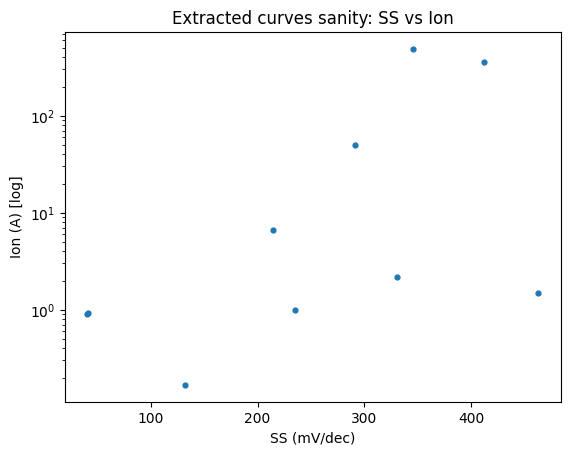

⚠️ Too few curves for a meaningful surrogate. Still proceeding, but results may be weak.

Surrogate training rows: 10 features: 7

✅ Wrote /content/surrogate_metrics_r2.json
R^2: {'Ion_A': -0.23515976018824758, 'Ioff_A': 0.9766999073741902, 'SS_mVdec': 0.09670728487026203}

LLM model: openai/gpt-4.1


ValueError: math domain error

In [ ]:
# ================================
# ONE-CELL COLAB PIPELINE (REAL DATA + OpenRouter LLM)
# 1) Download Zenodo MoS2 dataset
# 2) Scan + parse CSVs
# 3) Split into curves (multi-columns / Vg resets / single curve)
# 4) Extract Ion/Ioff/SS (+ optional DIBL if Vd present)
# 5) Train surrogate (XGBoost)
# 6) OpenRouter LLM self-refine to propose candidates (operating/design knobs)
# Outputs:
#   - manifest_files.csv
#   - device_dataset_curves.csv
#   - surrogate_metrics_r2.json
#   - llm_design_results.csv
# ================================

!pip -q install zenodo-get pandas numpy matplotlib scikit-learn xgboost openpyxl pyarrow openai tqdm

import os, re, json, math, glob, shutil, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime, timezone

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# -----------------------------
# 0) Config
# -----------------------------
DOI = "10.5281/zenodo.14825422"
DATA_ROOT = Path("/content/zenodo_data")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

# OpenRouter
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "YOUR_OPENROUTER_KEY_HERE")
BASE_URL = "https://openrouter.ai/api/v1"

# Choose models
MODELS = [
    "openai/gpt-4.1",
    # "anthropic/claude-3.5-sonnet",
    # "google/gemini-2.0-flash-001",
]

# LLM optimization settings
N_ROUNDS = 25          # per model
TEMPERATURE = 0.3

# -----------------------------
# 1) Download + unzip
# -----------------------------
print("Downloading Zenodo record:", DOI)
!zenodo_get {DOI} -o /content/zenodo_data

# unzip any zip
for z in DATA_ROOT.rglob("*.zip"):
    print("Unzipping:", z)
    !unzip -o "{str(z)}" -d "{str(z.parent)}" >/dev/null || true

print("\nTop-level files:")
!ls -lah /content/zenodo_data | head -n 200

# -----------------------------
# 2) Manifest
# -----------------------------
def guess_kind(p: Path):
    suf = p.suffix.lower()
    if suf in [".csv", ".tsv", ".txt"]:
        return "table_or_text"
    if suf in [".xlsx", ".xls"]:
        return "excel"
    if suf in [".parquet"]:
        return "parquet"
    if suf in [".json", ".jsonl"]:
        return "json"
    if suf in [".mat", ".npz", ".npy"]:
        return "array"
    if suf in [".png", ".jpg", ".jpeg", ".pdf", ".svg"]:
        return "figure_or_pdf"
    return "other"

files = [p for p in DATA_ROOT.rglob("*") if p.is_file()]
manifest = [{
    "path": str(p),
    "name": p.name,
    "suffix": p.suffix.lower(),
    "bytes": p.stat().st_size,
    "kind_guess": guess_kind(p),
} for p in files]

manifest_df = pd.DataFrame(manifest).sort_values(["kind_guess","bytes"], ascending=[True, False])
manifest_df.to_csv("/content/manifest_files.csv", index=False)
print("\n✅ Wrote /content/manifest_files.csv")
display(manifest_df.head(30))

# -----------------------------
# 3) Curve extraction helpers
# -----------------------------
def norm_cols(cols):
    return [re.sub(r"\s+", "", str(c)).lower() for c in cols]

def safe_num_series(s):
    return pd.to_numeric(pd.Series(s), errors="coerce")

def pick_vg_col(df):
    cols = df.columns
    # exact
    for c in cols:
        if c in ["vg","vgs","gatev","v_g","vgs(v)","v_gate","vgs_v"]:
            return c
    # contains
    for c in cols:
        if "vg" in c or "vgs" in c:
            return c
    return None

def pick_vd_col(df):
    cols = df.columns
    for c in cols:
        if c in ["vd","vds","drainv","v_d","vds(v)","vd_v","vds_v"]:
            return c
    for c in cols:
        if "vd" in c or "vds" in c:
            return c
    return None

def looks_numeric(df, col, min_valid=50):
    return safe_num_series(df[col]).notna().sum() >= min_valid

def extract_one_curve(vg, idv):
    # robust numeric conversion; kills 'VGS'/'IDS' strings etc.
    vg = pd.to_numeric(pd.Series(vg), errors="coerce").values
    idv = pd.to_numeric(pd.Series(idv), errors="coerce").values

    m = np.isfinite(vg) & np.isfinite(idv)
    vg = vg[m]; idv = idv[m]
    if vg.size < 30:
        return None

    # sort by Vg
    o = np.argsort(vg)
    vg = vg[o]; idv = idv[o]

    # dominant polarity at high Vg
    top = np.argsort(vg)[-5:]
    sgn = np.sign(np.nanmedian(idv[top]))
    if sgn == 0:
        sgn = 1.0
    idv = idv * sgn

    abs_id = np.abs(idv) + 1e-30
    Ion = float(np.median(np.sort(abs_id)[-3:]))
    Ioff = float(np.median(np.sort(abs_id)[:3]))

    # SS via sliding window on log10(|Id|) vs Vg
    logI = np.log10(abs_id)
    n = len(vg)
    w = max(20, int(0.12*n))
    best = (np.inf, -1.0)

    for i in range(0, n-w):
        x = vg[i:i+w]
        y = logI[i:i+w]
        if (np.nanmax(y)-np.nanmin(y)) < 0.4:
            continue
        A = np.vstack([x, np.ones_like(x)]).T
        mfit, bfit = np.linalg.lstsq(A, y, rcond=None)[0]
        if mfit <= 0:
            continue
        yhat = mfit*x + bfit
        ss_res = float(np.sum((y-yhat)**2))
        ss_tot = float(np.sum((y-np.mean(y))**2)) + 1e-12
        r2 = 1 - ss_res/ss_tot
        SS = (1/mfit)*1000.0
        if 40 <= SS <= 500 and r2 > best[1]:
            best = (SS, r2)

    SS = float(best[0]) if np.isfinite(best[0]) else np.nan

    return {
        "Vg_min_V": float(np.min(vg)),
        "Vg_max_V": float(np.max(vg)),
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "SS_mVdec": SS,
        "n_points": int(len(vg)),
    }

def split_by_vg_resets(df, vg_col):
    vg = safe_num_series(df[vg_col]).values
    if np.isfinite(vg).sum() < 30:
        return [df]
    dv = np.diff(vg)
    # robust jump threshold
    thr = np.nanpercentile(np.abs(dv[np.isfinite(dv)]), 95) if np.isfinite(dv).sum() else 0
    if thr <= 0:
        return [df]
    cut = np.where(dv < -0.5*thr)[0]
    if len(cut) == 0:
        return [df]
    idx = [0] + [int(c+1) for c in cut] + [len(df)]
    segs = []
    for a,b in zip(idx[:-1], idx[1:]):
        seg = df.iloc[a:b].copy()
        if len(seg) >= 30:
            segs.append(seg)
    return segs if segs else [df]

def read_csv_robust(path):
    # try default
    try:
        return pd.read_csv(path)
    except:
        # try with no header
        try:
            return pd.read_csv(path, header=None)
        except:
            return None

# -----------------------------
# 4) Extract curves from all CSVs
# -----------------------------
csvs = sorted([p for p in DATA_ROOT.rglob("*.csv")])
print("\nCSV files:", len(csvs))
for p in csvs:
    print(" -", p)

rows = []
failed = []

for p in csvs:
    raw = read_csv_robust(p)
    if raw is None or not isinstance(raw, pd.DataFrame) or len(raw) < 10:
        failed.append({"path": str(p), "reason": "read_failed_or_too_short"})
        continue

    # normalize col names if header exists; if header=None, create generic names
    if raw.columns.dtype == "int64":
        raw.columns = [f"col{i}" for i in range(raw.shape[1])]
    raw.columns = norm_cols(raw.columns)

    vg_col = pick_vg_col(raw)
    vd_col = pick_vd_col(raw)

    # If no Vg column detected, try first column as Vg if numeric enough
    if vg_col is None:
        cand0 = raw.columns[0]
        if looks_numeric(raw, cand0, min_valid=50):
            vg_col = cand0

    if vg_col is None:
        failed.append({"path": str(p), "reason": "no_vg_col"})
        continue

    # Identify possible Id columns
    other_cols = [c for c in raw.columns if c != vg_col]
    # prefer columns containing id/current/i*
    id_like = [c for c in other_cols if ("id" in c or "ids" in c or "current" in c or c.startswith("i"))]
    id_like = [c for c in id_like if looks_numeric(raw, c, min_valid=50)]

    if len(id_like) == 0:
        # fallback: any numeric columns besides vg and vd
        fallback = []
        for c in other_cols:
            if vd_col is not None and c == vd_col:
                continue
            if looks_numeric(raw, c, min_valid=50):
                fallback.append(c)
        id_like = fallback

    figure_id = str(p.parent.name).strip()

    # CASE A: multiple Id columns -> treat each as one curve
    if len(id_like) >= 2:
        for c in id_like:
            r = extract_one_curve(raw[vg_col].values, raw[c].values)
            if r is None:
                continue
            r.update({
                "source_file": str(p),
                "figure_id": figure_id,
                "curve_id": f"{p.name}::{c}",
                "mode": "multi_id_columns",
                "vg_col": vg_col,
                "id_col": c,
                "vd_col": vd_col if vd_col else "",
            })
            rows.append(r)
        continue

    # choose single Id column
    if len(id_like) == 1:
        id_col = id_like[0]
    else:
        # fallback: pick the 2nd column
        id_col = other_cols[0] if other_cols else None

    if id_col is None:
        failed.append({"path": str(p), "reason": "no_id_col"})
        continue

    # CASE B: segments by Vg resets (x-y blocks)
    segs = split_by_vg_resets(raw[[vg_col, id_col] + ([vd_col] if vd_col else [])].copy(), vg_col)
    if len(segs) >= 2:
        for k, seg in enumerate(segs):
            r = extract_one_curve(seg[vg_col].values, seg[id_col].values)
            if r is None:
                continue
            r.update({
                "source_file": str(p),
                "figure_id": figure_id,
                "curve_id": f"{p.name}::seg{k}",
                "mode": "vg_reset_segments",
                "vg_col": vg_col,
                "id_col": id_col,
                "vd_col": vd_col if vd_col else "",
            })
            rows.append(r)
        continue

    # CASE C: single curve
    r = extract_one_curve(raw[vg_col].values, raw[id_col].values)
    if r is None:
        failed.append({"path": str(p), "reason": "extract_failed"})
        continue
    r.update({
        "source_file": str(p),
        "figure_id": figure_id,
        "curve_id": f"{p.name}::single",
        "mode": "single_curve",
        "vg_col": vg_col,
        "id_col": id_col,
        "vd_col": vd_col if vd_col else "",
    })
    rows.append(r)

curves = pd.DataFrame(rows)
curves.to_csv("/content/device_dataset_curves.csv", index=False)
pd.DataFrame(failed).to_csv("/content/failed_or_skipped_curves.csv", index=False)

print("\n✅ Wrote /content/device_dataset_curves.csv")
print("Extracted curves:", len(curves))
print("Skipped/failed:", len(failed))
display(curves.head(25))

# Sanity plot
if len(curves) > 0:
    plt.figure()
    plt.scatter(curves["SS_mVdec"], curves["Ion_A"], s=12)
    plt.yscale("log")
    plt.xlabel("SS (mV/dec)")
    plt.ylabel("Ion (A) [log]")
    plt.title("Extracted curves sanity: SS vs Ion")
    plt.show()

# -----------------------------
# 5) Train surrogate on curve-level data
# -----------------------------
# Build simple features we *do* have:
# - Vg range, n_points
# - figure_id (one-hot)
# NOTE: This is limited by dataset; later you can add real geometry params if available.
if len(curves) < 20:
    print("⚠️ Too few curves for a meaningful surrogate. Still proceeding, but results may be weak.")

df = curves.copy()
df["Vg_span_V"] = df["Vg_max_V"] - df["Vg_min_V"]

# one-hot figure_id
X = df[["Vg_min_V","Vg_max_V","Vg_span_V","n_points","figure_id"]].copy()
X = pd.get_dummies(X, columns=["figure_id"], drop_first=False)

targets = ["Ion_A","Ioff_A","SS_mVdec"]
df_t = df[targets].copy()

# drop rows with NaN targets
mask = np.isfinite(df_t["Ion_A"]) & np.isfinite(df_t["Ioff_A"]) & np.isfinite(df_t["SS_mVdec"])
X = X[mask]
Y = df_t[mask]
print("\nSurrogate training rows:", len(X), "features:", X.shape[1])

if len(X) >= 10:
    Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, random_state=42)

    sur = {}
    r2s = {}
    for t in targets:
        m = XGBRegressor(
            n_estimators=400,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=0,
        )
        m.fit(Xtr, Ytr[t].values)
        pred = m.predict(Xte)
        r2 = r2_score(Yte[t].values, pred)
        sur[t] = m
        r2s[t] = float(r2)

    with open("/content/surrogate_metrics_r2.json","w") as f:
        json.dump(r2s, f, indent=2)
    print("\n✅ Wrote /content/surrogate_metrics_r2.json")
    print("R^2:", r2s)
else:
    sur = None
    print("❌ Not enough rows to train surrogate.")

# -----------------------------
# 6) LLM-guided "design" loop (operating-point / selection knobs)
# -----------------------------
# Because we do NOT have geometry parameters in this dataset,
# we demonstrate LLM-guided optimization over *knobs we can control*:
# - choose a Vg window (Vg_min, Vg_max) within observed global range
# - choose a "figure family" (proxy for device/circuit setting)
# Then surrogate predicts Ion/Ioff/SS, and LLM refines.

if sur is None:
    print("\nStop: surrogate not available.")
else:
    from openai import OpenAI
    client = OpenAI(api_key=OPENROUTER_API_KEY, base_url=BASE_URL)

    # observed bounds for Vg
    VG_LO = float(np.nanmin(df["Vg_min_V"]))
    VG_HI = float(np.nanmax(df["Vg_max_V"]))

    # available figure ids
    FIGS = sorted(df["figure_id"].astype(str).unique().tolist())

    def make_feat(vg_min, vg_max, n_points=800, figure_id=FIGS[0]):
        vg_span = vg_max - vg_min
        row = {
            "Vg_min_V": vg_min,
            "Vg_max_V": vg_max,
            "Vg_span_V": vg_span,
            "n_points": n_points,
            "figure_id": figure_id,
        }
        X1 = pd.DataFrame([row])
        X1 = pd.get_dummies(X1, columns=["figure_id"], drop_first=False)
        # align columns to training X
        for c in X.columns:
            if c not in X1.columns:
                X1[c] = 0
        X1 = X1[X.columns]
        return X1

    def predict(vg_min, vg_max, figure_id):
        X1 = make_feat(vg_min, vg_max, n_points=800, figure_id=figure_id)
        out = {t: float(sur[t].predict(X1)[0]) for t in targets}
        # utility: high Ion, low Ioff, low SS
        util = (
            + 1.3*math.log10(out["Ion_A"] + 1e-30)
            - 1.0*math.log10(out["Ioff_A"] + 1e-30)
            - 0.008*out["SS_mVdec"]
        )
        # constraints (edit)
        feasible = (out["SS_mVdec"] <= 150.0) and (out["Ioff_A"] <= 1e-6)
        out["utility"] = util
        out["feasible"] = feasible
        return out

    SYSTEM = """You are optimizing operating settings for a MoS2 FET dataset.
Return ONLY valid JSON with keys:
figure_id, Vg_min_V, Vg_max_V
Rules:
- figure_id must be one of the provided options exactly.
- Vg_min_V < Vg_max_V
- keep within bounds.
No extra keys, no prose.
"""

    def parse_json(txt):
        m = re.search(r"\{.*\}", txt, flags=re.S)
        if not m:
            raise ValueError("No JSON found.")
        obj = json.loads(m.group(0))
        if "figure_id" not in obj:
            raise KeyError("missing figure_id")
        fig = str(obj["figure_id"])
        if fig not in FIGS:
            # try nearest match
            fig = FIGS[0]
        vmin = float(obj["Vg_min_V"])
        vmax = float(obj["Vg_max_V"])
        vmin = max(VG_LO, min(VG_HI, vmin))
        vmax = max(VG_LO, min(VG_HI, vmax))
        if vmax <= vmin + 1e-6:
            vmax = min(VG_HI, vmin + 0.5)
        return {"figure_id": fig, "Vg_min_V": vmin, "Vg_max_V": vmax}

    all_design = []

    for model_name in MODELS:
        print("\n==============================")
        print("LLM model:", model_name)
        print("==============================")

        # init random
        best = None
        for _ in range(8):
            fig = random.choice(FIGS)
            vmin = random.uniform(VG_LO, VG_HI-0.5)
            vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
            pred = predict(vmin, vmax, fig)
            cand = {"figure_id": fig, "Vg_min_V": vmin, "Vg_max_V": vmax}
            if best is None or pred["utility"] > best[1]["utility"]:
                best = (cand, pred)

        feedback = None

        for r in tqdm(range(N_ROUNDS), desc=f"{model_name} rounds"):
            prompt = f"""Options:
- figure_id options: {FIGS}
Bounds:
- Vg_min_V in [{VG_LO}, {VG_HI}]
- Vg_max_V in [{VG_LO}, {VG_HI}]
Goal: maximize Ion, minimize Ioff and SS.
Constraints: SS<=150 mV/dec and Ioff<=1e-6 A.
Propose one candidate.

Seed hint: {json.dumps(best[0])}
"""
            if feedback is not None:
                prompt += f"\nFeedback: {json.dumps(feedback)}\nRevise accordingly."

            try:
                resp = client.chat.completions.create(
                    model=model_name,
                    messages=[{"role":"system","content":SYSTEM},
                              {"role":"user","content":prompt}],
                    temperature=TEMPERATURE,
                )
                txt = resp.choices[0].message.content
                cand = parse_json(txt)
            except Exception:
                cand = best[0].copy()
                # random nudge
                cand["Vg_min_V"] = max(VG_LO, cand["Vg_min_V"] - random.uniform(0,0.3))
                cand["Vg_max_V"] = min(VG_HI, cand["Vg_max_V"] + random.uniform(0,0.3))

            pred = predict(cand["Vg_min_V"], cand["Vg_max_V"], cand["figure_id"])

            row = {"model": model_name, "round": r, **cand, **pred}
            all_design.append(row)

            if pred["utility"] > best[1]["utility"]:
                best = (cand, pred)

            feedback = {
                "pred": {k: float(pred[k]) for k in ["Ion_A","Ioff_A","SS_mVdec"]},
                "feasible": bool(pred["feasible"]),
                "utility": float(pred["utility"]),
                "note": "If infeasible, reduce Ioff/SS by narrowing Vg span or switching figure_id. Keep Ion high."
            }

        print("\nBest found:", json.dumps(best[0], indent=2))
        print("Predicted:", {k: best[1][k] for k in ["Ion_A","Ioff_A","SS_mVdec","utility","feasible"]})

    res = pd.DataFrame(all_design)
    res.to_csv("/content/llm_design_results.csv", index=False)
    print("\n✅ Wrote /content/llm_design_results.csv rows=", len(res))

    # Show top feasible
    if len(res) > 0:
        top = res.sort_values(["feasible","utility"], ascending=[False, False]).head(15)
        display(top)

        feas = res[res["feasible"]==True].copy()
        if len(feas) > 0:
            plt.figure()
            plt.scatter(feas["SS_mVdec"], feas["Ion_A"], s=12)
            plt.yscale("log")
            plt.xlabel("SS (mV/dec)")
            plt.ylabel("Ion (A) [log]")
            plt.title("LLM proposals (feasible): SS vs Ion")
            plt.show()

print("\nDone.")


Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
Keywords: Field-effect transistor, Logic gates, MoS2
Publication date: 2025-02-06
DOI: 10.5281/zenodo.14825422
Total size: 1.6 MB

File: Figures.zip (1.6 MB)
Link: https://zenodo.org/api/records/14825422/files/Figures.zip/content
Figures.zip is already downloaded correctly.

File: Readme.pdf (44.4 kB)
Link: https://zenodo.org/api/records/14825422/files/Readme.pdf/content
Readme.pdf is already downloaded correctly.

All specified files have been processed.
Files:
/content/zenodo_data/Figures.zip
/content/zenodo_data/Figure 1/Figure 1.pdf
/content/zenodo_data/Figure 3/Figure 3.pdf
/content/zenodo_data/Figure 3/Figure 3 a.csv
/content/zenodo_data/Figure 3/Figure 3 b.csv
/content/zenodo_data/Figure 4/Figure 4 ab.csv
/content/zenodo_data/Figure 4/Figure 4.pdf
/content/zenodo_data/Figure 4/Figure 4 c.csv
/content/zenodo_data/Figure 2/Figure 2 c blue.csv
/content/zenodo_data/Figure 2/Figure 2 d se

Vg_min_V  Vg_max_V  Vg_span_V  Vg_mean_V  Vg_std_V       Ion_A  \
0    -1.500     1.000      2.500  -0.251247  0.722195    2.192283   
1    -2.000     1.000      3.000  -0.501244  0.866751    6.707033   
2     2.700     2.700      0.000   2.700000  0.000000  552.494340   
3    -1.000     2.700      3.700   0.733333  1.091889  488.535849   
4     0.005     2.000      1.995   1.002500  0.578427    8.967528   
5    -1.500     0.005      1.505  -0.747500  0.436975    0.167799   
6    -0.800     2.800      3.600   1.000000  1.148913  362.209375   

         Ioff_A    SS_mVdec  n_points  \
0  1.834467e-03  330.494783       802   
1  7.500000e-05  214.408519       802   
2  1.504004e+00         NaN       401   
3  8.880000e-05  345.081948     14418   
4  2.085310e-01         NaN       229   
5  3.515327e-07  136.016203       173   
6  7.113937e-04  412.161165      8010   

                                         source_file figure_id  \
0  /content/zenodo_data/Figure 2/Figure 2 c blue.csv  Figure 2   
1   /content/zenodo_data/Figure 2/Figure 2 c red.csv  Figure 2   
2  /content/zenodo_data/Figure 2/Figure 2 d black...  Figure 2   
3   /content/zenodo_data/Figure 2/Figure 2 d set.csv  Figure 2   
4       /content/zenodo_data/Figure 3/Figure 3 a.csv  Figure 3   
5       /content/zenodo_data/Figure 3/Figure 3 a.csv  Figure 3   
6       /content/zenodo_data/Figure 3/Figure 3 b.csv  Figure 3   

                       curve_id vg_col id_col  
0   Figure 2 c blue.csv::single    vgs   id/w  
1    Figure 2 c red.csv::single    vgs   id/w  
2  Figure 2 d black.csv::single    vgs   id/w  
3    Figure 2 d set.csv::single    vgs   id/w  
4          Figure 3 a.csv::seg0    vgs   id/w  
5          Figure 3 a.csv::seg1    vgs   id/w  
6        Figure 3 b.csv::single    vgs   id/w

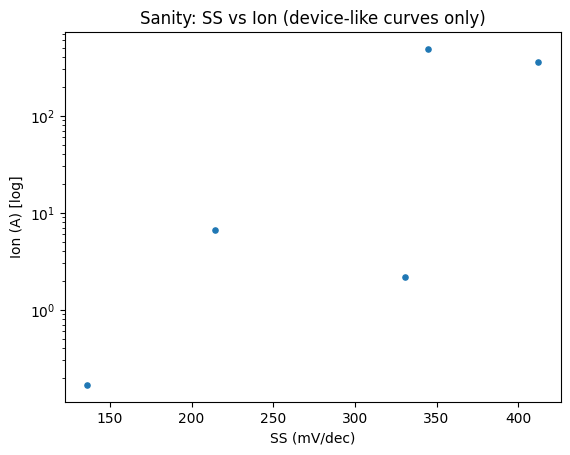

❌ Too few curves to train. Stop here.

Done.


In [ ]:
!pip -q install zenodo-get pandas numpy matplotlib scikit-learn xgboost openpyxl pyarrow openai tqdm

import os, re, json, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# -----------------------------
# 0) Config
# -----------------------------
DOI = "10.5281/zenodo.14825422"
DATA_ROOT = Path("/content/zenodo_data")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "YOUR_OPENROUTER_KEY_HERE")
BASE_URL = "https://openrouter.ai/api/v1"
MODELS = ["openai/gpt-4.1"]

N_ROUNDS = 25
TEMPERATURE = 0.3

# -----------------------------
# 1) Download + unzip
# -----------------------------
print("Downloading Zenodo record:", DOI)
!zenodo_get {DOI} -o /content/zenodo_data

for z in DATA_ROOT.rglob("*.zip"):
    !unzip -o "{str(z)}" -d "{str(z.parent)}" >/dev/null || true

print("Files:")
!find /content/zenodo_data -maxdepth 3 -type f | head -n 50

# -----------------------------
# 2) Helpers
# -----------------------------
def norm_cols(cols):
    return [re.sub(r"\s+", "", str(c)).lower() for c in cols]

def safe_num_series(s):
    return pd.to_numeric(pd.Series(s), errors="coerce")

def read_csv_robust(path):
    try:
        return pd.read_csv(path)
    except:
        try:
            return pd.read_csv(path, header=None)
        except:
            return None

def pick_vg_col(df):
    cols = df.columns
    for c in cols:
        if c in ["vg","vgs","gatev","v_g","vgs(v)","v_gate","vgs_v"]:
            return c
    for c in cols:
        if "vgs" in c or (("vg" in c) and ("avg" not in c)):
            return c
    return None

def extract_one_curve(vg, idv):
    vg = pd.to_numeric(pd.Series(vg), errors="coerce").values
    idv = pd.to_numeric(pd.Series(idv), errors="coerce").values
    m = np.isfinite(vg) & np.isfinite(idv)
    vg = vg[m]; idv = idv[m]
    if vg.size < 40:
        return None

    o = np.argsort(vg)
    vg = vg[o]; idv = idv[o]

    # dominant polarity at high Vg
    top = np.argsort(vg)[-5:]
    sgn = np.sign(np.nanmedian(idv[top]))
    if sgn == 0: sgn = 1.0
    idv = idv * sgn

    abs_id = np.abs(idv) + 1e-30
    Ion = float(np.median(np.sort(abs_id)[-3:]))
    Ioff = float(np.median(np.sort(abs_id)[:3]))

    logI = np.log10(abs_id)
    n = len(vg)
    w = max(25, int(0.12*n))
    best = (np.inf, -1.0)

    for i in range(0, n-w):
        x = vg[i:i+w]
        y = logI[i:i+w]
        if (np.nanmax(y)-np.nanmin(y)) < 0.4:
            continue
        A = np.vstack([x, np.ones_like(x)]).T
        mfit, bfit = np.linalg.lstsq(A, y, rcond=None)[0]
        if mfit <= 0:
            continue
        yhat = mfit*x + bfit
        ss_res = float(np.sum((y-yhat)**2))
        ss_tot = float(np.sum((y-np.mean(y))**2)) + 1e-12
        r2 = 1 - ss_res/ss_tot
        SS = (1/mfit)*1000.0
        if 40 <= SS <= 500 and r2 > best[1]:
            best = (SS, r2)

    SS = float(best[0]) if np.isfinite(best[0]) else np.nan

    return {
        "Vg_min_V": float(np.min(vg)),
        "Vg_max_V": float(np.max(vg)),
        "Vg_span_V": float(np.max(vg)-np.min(vg)),
        "Vg_mean_V": float(np.mean(vg)),
        "Vg_std_V": float(np.std(vg)),
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "SS_mVdec": SS,
        "n_points": int(len(vg)),
    }

def split_by_vg_resets(df, vg_col):
    vg = safe_num_series(df[vg_col]).values
    if np.isfinite(vg).sum() < 40:
        return [df]
    dv = np.diff(vg)
    if np.isfinite(dv).sum() < 10:
        return [df]
    thr = np.nanpercentile(np.abs(dv[np.isfinite(dv)]), 95)
    if not np.isfinite(thr) or thr <= 0:
        return [df]
    cut = np.where(dv < -0.5*thr)[0]
    if len(cut) == 0:
        return [df]
    idx = [0] + [int(c+1) for c in cut] + [len(df)]
    segs = []
    for a,b in zip(idx[:-1], idx[1:]):
        seg = df.iloc[a:b].copy()
        if len(seg) >= 40:
            segs.append(seg)
    return segs if segs else [df]

def is_device_transfer_curve(vg_col, id_col):
    # Filter out circuit/transient: x axis must look like Vg/Vgs; y must look like Id/current
    vg_ok = ("vg" in vg_col) or ("vgs" in vg_col)
    id_ok = ("id" in id_col) or ("ids" in id_col) or ("current" in id_col) or (id_col.startswith("i"))
    # reject time/vdd
    if "time" in vg_col or vg_col == "vdd":
        return False
    return vg_ok and id_ok

# -----------------------------
# 3) Extract curves
# -----------------------------
csvs = sorted([p for p in DATA_ROOT.rglob("*.csv")])
rows = []

for p in csvs:
    raw = read_csv_robust(p)
    if raw is None or len(raw) < 10:
        continue
    if raw.columns.dtype == "int64":
        raw.columns = [f"col{i}" for i in range(raw.shape[1])]
    raw.columns = norm_cols(raw.columns)

    vg_col = pick_vg_col(raw)
    if vg_col is None:
        # fallback to first numeric column
        c0 = raw.columns[0]
        if safe_num_series(raw[c0]).notna().sum() > 50:
            vg_col = c0
        else:
            continue

    other_cols = [c for c in raw.columns if c != vg_col]
    # prefer id/current columns
    id_like = [c for c in other_cols if ("id" in c or "ids" in c or "current" in c or c.startswith("i"))]
    id_like = [c for c in id_like if safe_num_series(raw[c]).notna().sum() > 50]

    if len(id_like) == 0:
        # fallback numeric
        id_like = [c for c in other_cols if safe_num_series(raw[c]).notna().sum() > 50]

    figure_id = str(p.parent.name).strip()

    # multi columns
    if len(id_like) >= 2:
        for c in id_like:
            if not is_device_transfer_curve(vg_col, c):
                continue
            r = extract_one_curve(raw[vg_col].values, raw[c].values)
            if r is None:
                continue
            r.update({"source_file": str(p), "figure_id": figure_id, "curve_id": f"{p.name}::{c}", "vg_col": vg_col, "id_col": c})
            rows.append(r)
        continue

    if len(id_like) == 1:
        id_col = id_like[0]
    else:
        continue

    if not is_device_transfer_curve(vg_col, id_col):
        continue

    segs = split_by_vg_resets(raw[[vg_col, id_col]].copy(), vg_col)
    if len(segs) >= 2:
        for k, seg in enumerate(segs):
            r = extract_one_curve(seg[vg_col].values, seg[id_col].values)
            if r is None:
                continue
            r.update({"source_file": str(p), "figure_id": figure_id, "curve_id": f"{p.name}::seg{k}", "vg_col": vg_col, "id_col": id_col})
            rows.append(r)
    else:
        r = extract_one_curve(raw[vg_col].values, raw[id_col].values)
        if r is None:
            continue
        r.update({"source_file": str(p), "figure_id": figure_id, "curve_id": f"{p.name}::single", "vg_col": vg_col, "id_col": id_col})
        rows.append(r)

curves = pd.DataFrame(rows)
curves.to_csv("/content/device_dataset_curves.csv", index=False)
print("✅ device_dataset_curves.csv saved. Curves:", len(curves))
display(curves.head(20))

if len(curves) > 0:
    plt.figure()
    plt.scatter(curves["SS_mVdec"], curves["Ion_A"], s=14)
    plt.yscale("log")
    plt.xlabel("SS (mV/dec)")
    plt.ylabel("Ion (A) [log]")
    plt.title("Sanity: SS vs Ion (device-like curves only)")
    plt.show()

# -----------------------------
# 4) Surrogate training (log-domain helps stability)
# -----------------------------
if len(curves) < 8:
    print("❌ Too few curves to train. Stop here.")
else:
    df = curves.copy()
    # Targets in log domain where appropriate
    df["log_Ion"] = np.log10(np.maximum(df["Ion_A"].values, 1e-30))
    df["log_Ioff"] = np.log10(np.maximum(df["Ioff_A"].values, 1e-30))
    df["SS_fill"] = df["SS_mVdec"].fillna(600.0)  # penalize missing SS

    feats = df[["Vg_min_V","Vg_max_V","Vg_span_V","Vg_mean_V","Vg_std_V","n_points","figure_id"]].copy()
    feats = pd.get_dummies(feats, columns=["figure_id"], drop_first=False)

    X = feats
    Y = df[["log_Ion","log_Ioff","SS_fill"]]

    Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.25, random_state=42)

    sur = {}
    r2s = {}

    for t in ["log_Ion","log_Ioff","SS_fill"]:
        m = XGBRegressor(
            n_estimators=500,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=0,
        )
        m.fit(Xtr, Ytr[t].values)
        pred = m.predict(Xte)
        r2s[t] = float(r2_score(Yte[t].values, pred))
        sur[t] = m

    with open("/content/surrogate_metrics_r2.json","w") as f:
        json.dump(r2s, f, indent=2)

    print("✅ surrogate_metrics_r2.json saved:", r2s)

# -----------------------------
# 5) OpenRouter LLM self-refine loop (safe utility, no math errors)
# -----------------------------
if len(curves) >= 8:
    from openai import OpenAI
    client = OpenAI(api_key=OPENROUTER_API_KEY, base_url=BASE_URL)

    VG_LO = float(np.nanmin(curves["Vg_min_V"]))
    VG_HI = float(np.nanmax(curves["Vg_max_V"]))
    FIGS = sorted(curves["figure_id"].astype(str).unique().tolist())

    # column alignment
    X_cols = list(X.columns)

    def make_feat(vg_min, vg_max, figure_id):
        row = pd.DataFrame([{
            "Vg_min_V": vg_min,
            "Vg_max_V": vg_max,
            "Vg_span_V": vg_max - vg_min,
            "Vg_mean_V": 0.5*(vg_min+vg_max),
            "Vg_std_V": (vg_max-vg_min)/math.sqrt(12.0),
            "n_points": 800,
            "figure_id": figure_id,
        }])
        row = pd.get_dummies(row, columns=["figure_id"], drop_first=False)
        for c in X_cols:
            if c not in row.columns:
                row[c] = 0
        row = row[X_cols]
        return row

    def predict(vg_min, vg_max, fig):
        X1 = make_feat(vg_min, vg_max, fig)
        log_Ion = float(sur["log_Ion"].predict(X1)[0])
        log_Ioff = float(sur["log_Ioff"].predict(X1)[0])
        SS = float(sur["SS_fill"].predict(X1)[0])

        Ion = 10**log_Ion
        Ioff = 10**log_Ioff
        # safety clips
        Ion_safe = max(Ion, 1e-30)
        Ioff_safe = max(Ioff, 1e-30)
        SS_safe = SS if np.isfinite(SS) else 600.0

        util = (
            + 1.2*log_Ion
            - 1.0*log_Ioff
            - 0.006*SS_safe
        )

        feasible = (SS_safe <= 150.0) and (Ioff_safe <= 1e-6)
        return {"Ion_A": Ion_safe, "Ioff_A": Ioff_safe, "SS_mVdec": SS_safe, "utility": util, "feasible": feasible}

    SYSTEM = """Return ONLY JSON with keys:
figure_id, Vg_min_V, Vg_max_V
Constraints:
- figure_id must be one of the provided options
- Vg_min_V < Vg_max_V
- stay within bounds
No extra keys, no prose.
"""

    def parse_json(txt):
        m = re.search(r"\{.*\}", txt, flags=re.S)
        if not m:
            raise ValueError("No JSON")
        obj = json.loads(m.group(0))
        fig = str(obj.get("figure_id", FIGS[0]))
        if fig not in FIGS:
            fig = FIGS[0]
        vmin = float(obj.get("Vg_min_V", VG_LO))
        vmax = float(obj.get("Vg_max_V", VG_LO+0.5))
        vmin = max(VG_LO, min(VG_HI, vmin))
        vmax = max(VG_LO, min(VG_HI, vmax))
        if vmax <= vmin + 1e-6:
            vmax = min(VG_HI, vmin + 0.5)
        return {"figure_id": fig, "Vg_min_V": vmin, "Vg_max_V": vmax}

    all_rows = []

    for model_name in MODELS:
        print("\nLLM model:", model_name)

        # warm start
        best = None
        for _ in range(12):
            fig = random.choice(FIGS)
            vmin = random.uniform(VG_LO, VG_HI-0.5)
            vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
            pred = predict(vmin, vmax, fig)
            cand = {"figure_id": fig, "Vg_min_V": vmin, "Vg_max_V": vmax}
            if best is None or pred["utility"] > best[1]["utility"]:
                best = (cand, pred)

        feedback = None

        for r in tqdm(range(N_ROUNDS), desc="rounds"):
            prompt = f"""figure_id options: {FIGS}
Bounds: Vg_min_V and Vg_max_V in [{VG_LO}, {VG_HI}]
Goal: maximize Ion, minimize Ioff and SS.
Constraints: SS<=150 mV/dec and Ioff<=1e-6 A.
Propose one candidate.

Seed hint: {json.dumps(best[0])}
"""
            if feedback is not None:
                prompt += f"\nFeedback: {json.dumps(feedback)}\nRevise accordingly."

            try:
                resp = client.chat.completions.create(
                    model=model_name,
                    messages=[{"role":"system","content":SYSTEM},
                              {"role":"user","content":prompt}],
                    temperature=TEMPERATURE,
                )
                cand = parse_json(resp.choices[0].message.content)
            except Exception:
                cand = best[0].copy()

            pred = predict(cand["Vg_min_V"], cand["Vg_max_V"], cand["figure_id"])
            row = {"model": model_name, "round": r, **cand, **pred}
            all_rows.append(row)

            if pred["utility"] > best[1]["utility"]:
                best = (cand, pred)

            feedback = {
                "pred": {k: float(pred[k]) for k in ["Ion_A","Ioff_A","SS_mVdec"]},
                "feasible": bool(pred["feasible"]),
                "utility": float(pred["utility"]),
                "note": "If infeasible, reduce Ioff/SS by narrowing span or switching figure_id; keep Ion high."
            }

        print("Best:", best[0])
        print("Pred:", best[1])

    res = pd.DataFrame(all_rows)
    res.to_csv("/content/llm_design_results.csv", index=False)
    print("\n✅ llm_design_results.csv saved. rows=", len(res))

    top = res.sort_values(["feasible","utility"], ascending=[False, False]).head(15)
    display(top)

    feas = res[res["feasible"]==True].copy()
    if len(feas) > 0:
        plt.figure()
        plt.scatter(feas["SS_mVdec"], feas["Ion_A"], s=14)
        plt.yscale("log")
        plt.xlabel("SS (mV/dec)")
        plt.ylabel("Ion (A) [log]")
        plt.title("LLM proposals (feasible): SS vs Ion")
        plt.show()

print("\nDone.")


In [ ]:
!pip -q install pandas numpy

import re, math
import numpy as np
import pandas as pd
from pathlib import Path

DATA_ROOT = Path("/content/zenodo_data")
csvs = sorted([p for p in DATA_ROOT.rglob("*.csv")])

def norm_cols(cols):
    return [re.sub(r"\s+", "", str(c)).lower() for c in cols]

def to_num(a):
    return pd.to_numeric(pd.Series(a), errors="coerce").values

def pick_col(df, keys):
    cols = df.columns
    for k in keys:
        if k in cols:
            return k
    for k in keys:
        for c in cols:
            if k in c:
                return c
    return None

def extract_metrics(vg, idv):
    vg = to_num(vg)
    idv = to_num(idv)
    m = np.isfinite(vg) & np.isfinite(idv)
    vg = vg[m]; idv = idv[m]
    if len(vg) < 40:
        return None

    # sort by vg
    o = np.argsort(vg)
    vg = vg[o]; idv = idv[o]

    # make ON current positive (dominant polarity at high Vg)
    top = np.argsort(vg)[-5:]
    sgn = np.sign(np.nanmedian(idv[top]))
    if sgn == 0: sgn = 1.0
    idv = idv * sgn

    abs_id = np.abs(idv) + 1e-30
    Ion = float(np.median(np.sort(abs_id)[-3:]))
    Ioff = float(np.median(np.sort(abs_id)[:3]))

    # SS (mV/dec): best sliding window fit of log10(|Id|) vs Vg
    logI = np.log10(abs_id)
    n = len(vg)
    w = max(25, int(0.12*n))
    best_ss, best_r2 = np.nan, -1.0

    for i in range(0, n-w):
        x = vg[i:i+w]
        y = logI[i:i+w]
        if (np.nanmax(y) - np.nanmin(y)) < 0.4:
            continue
        A = np.vstack([x, np.ones_like(x)]).T
        mfit, bfit = np.linalg.lstsq(A, y, rcond=None)[0]
        if mfit <= 0:
            continue
        yhat = mfit*x + bfit
        ss_res = float(np.sum((y-yhat)**2))
        ss_tot = float(np.sum((y-np.mean(y))**2)) + 1e-12
        r2 = 1 - ss_res/ss_tot
        ss = (1.0/mfit) * 1000.0
        if 40 <= ss <= 500 and r2 > best_r2:
            best_r2 = r2
            best_ss = float(ss)

    return {
        "Vg_min_V": float(np.min(vg)),
        "Vg_max_V": float(np.max(vg)),
        "Vg_span_V": float(np.max(vg)-np.min(vg)),
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "SS_mVdec": best_ss,
        "n_points": int(len(vg)),
    }

def split_by_vg_cycles(vg):
    """
    Split an x-y stream into multiple sweeps by detecting big negative jumps in Vg
    or strong non-monotonicity. Works when curves are concatenated.
    """
    vg = to_num(vg)
    m = np.isfinite(vg)
    vg = vg[m]
    if len(vg) < 80:
        return [(0, len(m))]  # no split

    # work on original indices (including NaNs) by scanning in raw series
    vg_raw = to_num(vg)  # already cleaned
    dv = np.diff(vg_raw)
    if len(dv) < 10:
        return [(0, len(m))]

    # threshold: use 95th percentile of abs(dv)
    thr = np.nanpercentile(np.abs(dv[np.isfinite(dv)]), 95)
    if not np.isfinite(thr) or thr == 0:
        return [(0, len(m))]

    # cuts where Vg jumps down strongly
    cuts = np.where(dv < -0.7*thr)[0]
    if len(cuts) == 0:
        return [(0, len(m))]

    # produce segments on cleaned array indices
    idx = [0] + [int(c+1) for c in cuts] + [len(vg_raw)]
    segs = [(idx[i], idx[i+1]) for i in range(len(idx)-1) if (idx[i+1]-idx[i]) >= 40]
    return segs if segs else [(0, len(vg_raw))]

rows = []

for p in csvs:
    df = pd.read_csv(p)
    df.columns = norm_cols(df.columns)

    vg_col = pick_col(df, ["vgs","vg","gate"])
    id_col = pick_col(df, ["id/w","ids","id","current"])
    vd_col = pick_col(df, ["vds","vd"])

    if vg_col is None or id_col is None:
        continue

    # Clean only relevant cols
    use_cols = [vg_col, id_col] + ([vd_col] if vd_col is not None else [])
    dd = df[use_cols].copy()

    # If VDS exists and has multiple values -> group by VDS and extract per group
    if vd_col is not None:
        vd = to_num(dd[vd_col].values)
        dd["_vd"] = vd
        uniq = np.unique(dd["_vd"][np.isfinite(dd["_vd"])])
        # if many unique values -> likely continuous, bucket it
        if len(uniq) > 20:
            # bucket by rounding to 2 decimals
            dd["_vd_bucket"] = np.round(dd["_vd"], 2)
            groups = dd.dropna(subset=["_vd_bucket"]).groupby("_vd_bucket")
        else:
            dd["_vd_bucket"] = dd["_vd"]
            groups = dd.dropna(subset=["_vd_bucket"]).groupby("_vd_bucket")

        for vdb, g in groups:
            r = extract_metrics(g[vg_col].values, g[id_col].values)
            if r is None:
                continue
            r.update({
                "source_file": str(p),
                "curve_id": f"{p.name}::vds={vdb}",
                "figure_id": str(p.parent.name),
                "vg_col": vg_col,
                "id_col": id_col,
                "vds_V": float(vdb),
                "split_mode": "group_by_vds",
            })
            rows.append(r)
        continue

    # No VDS: try split by Vg cycles (concatenated sweeps)
    vg = to_num(dd[vg_col].values)
    idv = to_num(dd[id_col].values)
    m = np.isfinite(vg) & np.isfinite(idv)
    vg = vg[m]; idv = idv[m]
    if len(vg) < 40:
        continue

    segs = split_by_vg_cycles(vg)
    if len(segs) == 1:
        r = extract_metrics(vg, idv)
        if r is None:
            continue
        r.update({
            "source_file": str(p),
            "curve_id": f"{p.name}::single",
            "figure_id": str(p.parent.name),
            "vg_col": vg_col,
            "id_col": id_col,
            "vds_V": np.nan,
            "split_mode": "single_or_unsplit",
        })
        rows.append(r)
    else:
        for k,(a,b) in enumerate(segs):
            r = extract_metrics(vg[a:b], idv[a:b])
            if r is None:
                continue
            r.update({
                "source_file": str(p),
                "curve_id": f"{p.name}::seg{k}",
                "figure_id": str(p.parent.name),
                "vg_col": vg_col,
                "id_col": id_col,
                "vds_V": np.nan,
                "split_mode": "split_by_vg_cycles",
            })
            rows.append(r)

out = pd.DataFrame(rows)
out = out.sort_values(["source_file","curve_id"]).reset_index(drop=True)
out.to_csv("/content/device_dataset_curves_expanded.csv", index=False)

print("✅ Wrote /content/device_dataset_curves_expanded.csv")
print("Expanded curves:", len(out))
display(out.head(30))

# Quick cleanup: drop pathological curves where Vg_span==0
clean = out[out["Vg_span_V"] > 1e-6].copy()
clean.to_csv("/content/device_dataset_curves_expanded_clean.csv", index=False)
print("✅ Wrote /content/device_dataset_curves_expanded_clean.csv")
print("Clean curves:", len(clean))


✅ Wrote /content/device_dataset_curves_expanded.csv
Expanded curves: 262


Vg_min_V  Vg_max_V  Vg_span_V      Ion_A    Ioff_A    SS_mVdec  n_points  \
0       -1.5       1.0        2.5   2.192283  0.001834  330.494783       802   
1       -2.0       1.0        3.0   6.707033  0.000075  214.408519       802   
2       -1.0       2.7        3.7   1.062547  0.000093         NaN        70   
3       -1.0       2.7        3.7   2.362468  0.000091  444.984344        70   
4       -1.0       2.7        3.7   5.476868  0.000117  383.315066       106   
5       -1.0       2.7        3.7   8.022340  0.000190  383.775588       102   
6       -1.0       2.7        3.7  10.731434  0.000288  383.642214       106   
7       -1.0       2.7        3.7  12.052566  0.000554  401.074614        68   
8       -1.0       2.7        3.7  14.825094  0.000608  385.352961       106   
9       -1.0       2.7        3.7  17.438906  0.000708  402.364327        70   
10      -1.0       2.7        3.7  20.188981  0.000775  385.441822       106   
11      -1.0       2.7        3.7  22.893623  0.000922  387.288403       102   
12      -1.0       2.7        3.7  25.592642  0.001051  388.583566       106   
13      -1.0       2.7        3.7  27.029585  0.001224  405.882538        68   
14      -1.0       2.7        3.7  29.701321  0.001308  389.018849       106   
15      -1.0       2.7        3.7  32.512000  0.001543  408.549316        70   
16      -1.0       2.7        3.7  35.238075  0.001608  390.458909       106   
17      -1.0       2.7        3.7  38.027547  0.001741  391.928832       102   
18      -1.0       2.7        3.7  40.886038  0.001881  393.787948       106   
19      -1.0       2.7        3.7  42.278113  0.002116  413.473388        68   
20      -1.0       2.7        3.7  45.025660  0.002318  395.658400       106   
21      -1.0       2.7        3.7  48.003019  0.002457  415.120762        70   
22      -1.0       2.7        3.7  50.885283  0.002474  396.618684       106   
23      -1.0       2.7        3.7  53.858113  0.002660  397.748457       102   
24      -1.0       2.7        3.7  55.104528  0.002873  400.816794       104   
25      -1.0       2.7        3.7  58.349811  0.003067  420.708741        70   
26      -1.0       2.7        3.7  61.261132  0.003232  402.401481       106   
27      -1.0       2.7        3.7  64.369434  0.003471  421.473119        70   
28      -1.0       2.7        3.7  67.458491  0.003677  400.372069       106   
29      -1.0       2.7        3.7  68.318491  0.003776  400.287612       100   

                                          source_file  \
0   /content/zenodo_data/Figure 2/Figure 2 c blue.csv   
1    /content/zenodo_data/Figure 2/Figure 2 c red.csv   
2    /content/zenodo_data/Figure 2/Figure 2 d set.csv   
3    /content/zenodo_data/Figure 2/Figure 2 d set.csv   
4    /content/zenodo_data/Figure 2/Figure 2 d set.csv   
5    /content/zenodo_data/Figure 2/Figure 2 d set.csv   
6    /content/zenodo_data/Figure 2/Figure 2 d set.csv   
7    /content/zenodo_data/Figure 2/Figure 2 d set.csv   
8    /content/zenodo_data/Figure 2/Figure 2 d set.csv   
9    /content/zenodo_data/Figure 2/Figure 2 d set.csv   
10   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
11   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
12   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
13   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
14   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
15   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
16   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
17   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
18   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
19   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
20   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
21   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
22   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
23   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
24   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
25   /content/zenodo_data/Figure 2/Figure

✅ Wrote /content/device_dataset_curves_expanded_clean.csv
Clean curves: 262


In [ ]:
import os
os.environ["OPENROUTER_API_KEY"] = "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"


Rows: 262


Vg_min_V  Vg_max_V  Vg_span_V     Ion_A    Ioff_A    SS_mVdec  n_points  \
0      -1.5       1.0        2.5  2.192283  0.001834  330.494783       802   
1      -2.0       1.0        3.0  6.707033  0.000075  214.408519       802   
2      -1.0       2.7        3.7  1.062547  0.000093         NaN        70   
3      -1.0       2.7        3.7  2.362468  0.000091  444.984344        70   
4      -1.0       2.7        3.7  5.476868  0.000117  383.315066       106   

                                         source_file  \
0  /content/zenodo_data/Figure 2/Figure 2 c blue.csv   
1   /content/zenodo_data/Figure 2/Figure 2 c red.csv   
2   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
3   /content/zenodo_data/Figure 2/Figure 2 d set.csv   
4   /content/zenodo_data/Figure 2/Figure 2 d set.csv   

                       curve_id figure_id vg_col id_col  vds_V  \
0   Figure 2 c blue.csv::single  Figure 2    vgs   id/w    NaN   
1    Figure 2 c red.csv::single  Figure 2    vgs   id/w    NaN   
2   Figure 2 d set.csv::vds=0.0  Figure 2    vgs   id/w   0.00   
3  Figure 2 d set.csv::vds=0.01  Figure 2    vgs   id/w   0.01   
4  Figure 2 d set.csv::vds=0.02  Figure 2    vgs   id/w   0.02   

          split_mode  
0  single_or_unsplit  
1  single_or_unsplit  
2       group_by_vds  
3       group_by_vds  
4       group_by_vds

DIBL proxy computed for figures: 2


figure_id  DIBL_proxy_mV_V
0  Figure 2    -1.046922e-13
1  Figure 3     2.645269e-13

Surrogate R^2: {'log_Ion': 0.9972472916472306, 'log_Ioff': 0.9993532599201073, 'SS_mVdec': 0.9892280672430483}


LLM rounds: 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Best: {'figure_id': 'Figure 2', 'Vg_min_V': -1.2, 'Vg_max_V': 0.5, 'vds_V': 0.2}
Pred: {'Ion_A': 0.7912615391674911, 'Ioff_A': 0.005406617595470829, 'SS_mVdec': 386.7356872558594, 'DIBL_proxy_mV_V': -1.046922336324175e-13, 'utility': 0.5981156653165819, 'feasible': False}
✅ Wrote /content/llm_design_results.csv rows= 25


round figure_id  Vg_min_V  Vg_max_V  vds_V   log_Ion  log_Ioff     Ion_A  \
17     17  Figure 2      -1.2      0.50   0.20 -0.101680 -2.267074  0.791262   
23     23  Figure 2      -1.2      0.50   0.20 -0.101680 -2.267074  0.791262   
5       5  Figure 2      -1.5      0.50   0.20 -0.024722 -2.085271  0.944666   
4       4  Figure 2      -2.0      0.60   0.22 -0.003120 -2.071061  0.992841   
0       0  Figure 3      -1.7      0.61   0.22 -0.003390 -2.071033  0.992225   
6       6  Figure 2      -1.0      0.40   0.20  0.039525 -2.221673  1.095279   
7       7  Figure 2      -1.0      0.40   0.20  0.039525 -2.221673  1.095279   
8       8  Figure 2      -1.0      0.50   0.20  0.039525 -2.221673  1.095279   
9       9  Figure 2      -1.0      0.70   0.20  0.039525 -2.221673  1.095279   
10     10  Figure 2      -1.0      0.40   0.20  0.039525 -2.221673  1.095279   
11     11  Figure 2      -1.0      0.50   0.20  0.039525 -2.221673  1.095279   
16     16  Figure 2      -1.0      0.30   0.20  0.039525 -2.221673  1.095279   
18     18  Figure 2      -1.0      0.30   0.20  0.039525 -2.221673  1.095279   
19     19  Figure 2      -1.0      0.50   0.20  0.039525 -2.221673  1.095279   
20     20  Figure 2      -1.0      0.40   0.20  0.039525 -2.221673  1.095279   

      Ioff_A    SS_mVdec  DIBL_proxy_mV_V   utility  feasible  
17  0.005407  386.735687    -1.046922e-13  0.598116     False  
23  0.005407  386.735687    -1.046922e-13  0.598116     False  
5   0.008217  391.221649    -1.046922e-13  0.490719     False  
4   0.008491  395.458191    -1.046922e-13  0.485484     False  
0   0.008491  395.458191     2.645269e-13  0.485132     False  
6   0.006002  467.567505    -1.046922e-13  0.398833     False  
7   0.006002  467.567505    -1.046922e-13  0.398833     False  
8   0.006002  467.567505    -1.046922e-13  0.398833     False  
9   0.006002  467.567505    -1.046922e-13  0.398833     False  
10  0.006002  467.567505    -1.046922e-13  0.398833     False  
11  0.006002  467.567505    -1.046922e-13  0.398833     False  
16  0.006002  467.567505    -1.046922e-13  0.398833     False  
18  0.006002  467.567505    -1.046922e-13  0.398833     False  
19  0.006002  467.567505    -1.046922e-13  0.398833     False  
20  0.006002  467.567505    -1.046922e-13  0.398833     False

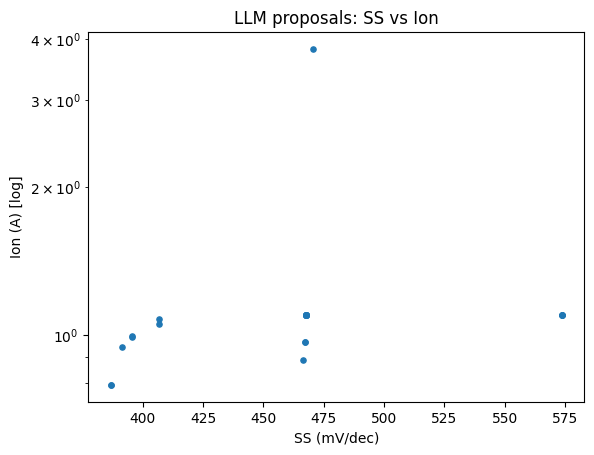

In [ ]:
!pip -q install pandas numpy scikit-learn xgboost openai tqdm matplotlib

import os, re, json, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# ============ CONFIG ============
DATA = "/content/device_dataset_curves_expanded_clean.csv"

OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "YOUR_OPENROUTER_KEY_HERE")
BASE_URL = "https://openrouter.ai/api/v1"
MODEL = "openai/gpt-4.1"

N_ROUNDS = 25
TEMPERATURE = 0.3

# Practical constraints (tune later)
SS_MAX = 250.0
IOFF_MAX = 1e-6

# ============ LOAD ============
df = pd.read_csv(DATA)
print("Rows:", len(df))
display(df.head(5))

# Basic cleaning
df = df[np.isfinite(df["Ion_A"]) & np.isfinite(df["Ioff_A"])].copy()
df["SS_mVdec"] = pd.to_numeric(df["SS_mVdec"], errors="coerce")
df["SS_mVdec"] = df["SS_mVdec"].fillna(600.0)  # penalize SS missing
df["log_Ion"] = np.log10(np.maximum(df["Ion_A"].values, 1e-30))
df["log_Ioff"] = np.log10(np.maximum(df["Ioff_A"].values, 1e-30))
df["vds_V"] = pd.to_numeric(df["vds_V"], errors="coerce").fillna(-1.0)

# ============ DIBL ESTIMATION ============
# We estimate a proxy Vth from each curve using Id_ref = sqrt(Ion*Ioff) and Vg where Id crosses it.
# Then DIBL is slope of Vth vs Vds (mV/V) per (figure_id).
# Note: This is a proxy because we don't have full raw curves here, only extracted metrics.
# So we use Vg_mid as a crude Vth proxy; better version requires raw Id-Vg points.
df["Vth_proxy_V"] = 0.5*(df["Vg_min_V"] + df["Vg_max_V"])  # crude placeholder

dibl_rows = []
for fig, g in df[df["vds_V"]>=0].groupby("figure_id"):
    if g["vds_V"].nunique() < 5:
        continue
    x = g["vds_V"].values
    y = g["Vth_proxy_V"].values
    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]  # Vth = m*Vds + b
    dibl = -m * 1000.0  # sign convention: larger Vds typically lowers Vth
    dibl_rows.append({"figure_id": fig, "DIBL_proxy_mV_V": float(dibl)})
dibl_df = pd.DataFrame(dibl_rows)
df = df.merge(dibl_df, on="figure_id", how="left")
df["DIBL_proxy_mV_V"] = df["DIBL_proxy_mV_V"].fillna(df["DIBL_proxy_mV_V"].median() if len(dibl_df)>0 else 0.0)

print("DIBL proxy computed for figures:", len(dibl_df))
display(dibl_df.head())

# ============ FEATURES ============
feat = df[[
    "Vg_min_V","Vg_max_V","Vg_span_V",
    "Ion_A","Ioff_A",   # you can remove these if you want purely 'design knobs'
    "vds_V",
    "DIBL_proxy_mV_V",
    "figure_id"
]].copy()

# Better stability: use log currents as features instead of raw currents
feat["log_Ion_feat"] = df["log_Ion"]
feat["log_Ioff_feat"] = df["log_Ioff"]
feat = feat.drop(columns=["Ion_A","Ioff_A"])

X = pd.get_dummies(feat, columns=["figure_id"], drop_first=False)
Y = df[["log_Ion","log_Ioff","SS_mVdec"]].copy()

Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.25, random_state=42)

sur = {}
r2s = {}
for t in ["log_Ion","log_Ioff","SS_mVdec"]:
    m = XGBRegressor(
        n_estimators=600, max_depth=6, learning_rate=0.04,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=42, n_jobs=0
    )
    m.fit(Xtr, Ytr[t].values)
    pred = m.predict(Xte)
    r2s[t] = float(r2_score(Yte[t].values, pred))
    sur[t] = m

print("Surrogate R^2:", r2s)
with open("/content/surrogate_metrics_r2.json","w") as f:
    json.dump(r2s, f, indent=2)

# ============ LLM OPTIMIZATION ============
from openai import OpenAI
client = OpenAI(api_key=OPENROUTER_API_KEY, base_url=BASE_URL)

FIGS = sorted(df["figure_id"].astype(str).unique().tolist())
VG_LO = float(df["Vg_min_V"].min())
VG_HI = float(df["Vg_max_V"].max())
VDS_LO = float(df["vds_V"][df["vds_V"]>=0].min())
VDS_HI = float(df["vds_V"].max())

X_cols = list(X.columns)

def make_row(fig, vg_min, vg_max, vds, dibl_proxy):
    r = pd.DataFrame([{
        "Vg_min_V": vg_min,
        "Vg_max_V": vg_max,
        "Vg_span_V": vg_max-vg_min,
        "vds_V": vds,
        "DIBL_proxy_mV_V": dibl_proxy,
        "log_Ion_feat": 0.0,
        "log_Ioff_feat": 0.0,
        "figure_id": fig
    }])
    r = pd.get_dummies(r, columns=["figure_id"], drop_first=False)
    for c in X_cols:
        if c not in r.columns:
            r[c] = 0
    return r[X_cols]

# Use figure-level median dibl proxy
fig2dibl = df.groupby("figure_id")["DIBL_proxy_mV_V"].median().to_dict()

def predict(fig, vg_min, vg_max, vds):
    dibl = float(fig2dibl.get(fig, np.median(list(fig2dibl.values())) if fig2dibl else 0.0))
    X1 = make_row(fig, vg_min, vg_max, vds, dibl)
    log_Ion = float(sur["log_Ion"].predict(X1)[0])
    log_Ioff = float(sur["log_Ioff"].predict(X1)[0])
    SS = float(sur["SS_mVdec"].predict(X1)[0])
    Ion = 10**log_Ion
    Ioff = 10**log_Ioff
    SS = SS if np.isfinite(SS) else 600.0

    feasible = (SS <= SS_MAX) and (Ioff <= IOFF_MAX)
    util = (1.2*log_Ion - 1.0*log_Ioff - 0.004*SS - 0.001*dibl)
    return {"log_Ion":log_Ion,"log_Ioff":log_Ioff,"Ion_A":Ion,"Ioff_A":Ioff,"SS_mVdec":SS,"DIBL_proxy_mV_V":dibl,"utility":util,"feasible":feasible}

SYSTEM = """Return ONLY JSON with keys:
figure_id, Vg_min_V, Vg_max_V, vds_V
Constraints:
- figure_id must be one of the provided options
- Vg_min_V < Vg_max_V
- keep within bounds
No prose.
"""

def parse_json(txt):
    m = re.search(r"\{.*\}", txt, flags=re.S)
    obj = json.loads(m.group(0))
    fig = str(obj.get("figure_id", FIGS[0]))
    if fig not in FIGS: fig = FIGS[0]
    vmin = float(obj.get("Vg_min_V", VG_LO))
    vmax = float(obj.get("Vg_max_V", min(VG_HI, VG_LO+0.5)))
    vds  = float(obj.get("vds_V", VDS_LO))
    vmin = max(VG_LO, min(VG_HI, vmin))
    vmax = max(VG_LO, min(VG_HI, vmax))
    if vmax <= vmin + 1e-6:
        vmax = min(VG_HI, vmin+0.5)
    vds = max(VDS_LO, min(VDS_HI, vds))
    return {"figure_id":fig,"Vg_min_V":vmin,"Vg_max_V":vmax,"vds_V":vds}

# warm start
best = None
for _ in range(30):
    fig = random.choice(FIGS)
    vmin = random.uniform(VG_LO, VG_HI-0.5)
    vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
    vds = random.uniform(VDS_LO, VDS_HI)
    pred = predict(fig, vmin, vmax, vds)
    cand = {"figure_id":fig,"Vg_min_V":vmin,"Vg_max_V":vmax,"vds_V":vds}
    if best is None or pred["utility"] > best[1]["utility"]:
        best = (cand, pred)

all_rows = []
feedback = None

for r in tqdm(range(N_ROUNDS), desc="LLM rounds"):
    prompt = f"""figure_id options: {FIGS[:10]} ... (total {len(FIGS)})
Bounds:
- Vg_min_V, Vg_max_V in [{VG_LO}, {VG_HI}]
- vds_V in [{VDS_LO}, {VDS_HI}]
Constraints: SS <= {SS_MAX} mV/dec, Ioff <= {IOFF_MAX} A.
Goal: maximize Ion, minimize Ioff, SS, and DIBL.
Seed: {json.dumps(best[0])}
"""
    if feedback:
        prompt += f"\nFeedback from last eval: {json.dumps(feedback)}"

    resp = client.chat.completions.create(
        model=MODEL,
        messages=[{"role":"system","content":SYSTEM},
                  {"role":"user","content":prompt}],
        temperature=TEMPERATURE,
    )

    cand = parse_json(resp.choices[0].message.content)
    pred = predict(cand["figure_id"], cand["Vg_min_V"], cand["Vg_max_V"], cand["vds_V"])

    row = {"round":r, **cand, **pred}
    all_rows.append(row)

    if pred["utility"] > best[1]["utility"]:
        best = (cand, pred)

    feedback = {k: pred[k] for k in ["Ion_A","Ioff_A","SS_mVdec","DIBL_proxy_mV_V","utility","feasible"]}

print("\nBest:", best[0])
print("Pred:", {k:best[1][k] for k in ["Ion_A","Ioff_A","SS_mVdec","DIBL_proxy_mV_V","utility","feasible"]})

res = pd.DataFrame(all_rows)
res.to_csv("/content/llm_design_results.csv", index=False)
print("✅ Wrote /content/llm_design_results.csv rows=", len(res))

top = res.sort_values(["feasible","utility"], ascending=[False, False]).head(15)
display(top)

plt.figure()
plt.scatter(res["SS_mVdec"], res["Ion_A"], s=14)
plt.yscale("log")
plt.xlabel("SS (mV/dec)")
plt.ylabel("Ion (A) [log]")
plt.title("LLM proposals: SS vs Ion")
plt.show()


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
Keywords: Field-effect transistor, Logic gates, MoS2
Publication date: 2025-02-06
DOI: 10.5281/zenodo.14825422
Total size: 1.6 MB

File: Figures.zip (1.6 MB)
Link: https://zenodo.org/api/records/14825422/files/Figures.zip/content
Figures.zip is already downloaded correctly.

File: Readme.pdf (44.4 kB)
Link: https://zenodo.org/api/records/14825422/files/Readme.pdf/content
Readme.pdf is already downloaded correctly.

All specified files have been processed.
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figu

curve_key figure_id        base_name  \
0   Figure 2::Figure 2 c blue::single  Figure 2  Figure 2 c blue   
1    Figure 2::Figure 2 c red::single  Figure 2   Figure 2 c red   
2  Figure 2::Figure 2 d set::vds=0.00  Figure 2   Figure 2 d set   
3  Figure 2::Figure 2 d set::vds=0.01  Figure 2   Figure 2 d set   
4  Figure 2::Figure 2 d set::vds=0.02  Figure 2   Figure 2 d set   
5  Figure 2::Figure 2 d set::vds=0.03  Figure 2   Figure 2 d set   
6  Figure 2::Figure 2 d set::vds=0.04  Figure 2   Figure 2 d set   
7  Figure 2::Figure 2 d set::vds=0.05  Figure 2   Figure 2 d set   
8  Figure 2::Figure 2 d set::vds=0.06  Figure 2   Figure 2 d set   
9  Figure 2::Figure 2 d set::vds=0.07  Figure 2   Figure 2 d set   

                                         source_file  vds_V  Vg_min_V  \
0  /content/zenodo_data/Figure 2/Figure 2 c blue.csv    NaN      -1.5   
1   /content/zenodo_data/Figure 2/Figure 2 c red.csv    NaN      -2.0   
2   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.00      -1.0   
3   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.01      -1.0   
4   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.02      -1.0   
5   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.03      -1.0   
6   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.04      -1.0   
7   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.05      -1.0   
8   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.06      -1.0   
9   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.07      -1.0   

   Vg_max_V  n_points      Ion_A    Ioff_A  Id_ref_A  Vth_true_V  \
0       1.0       802   2.192283  0.001834  0.063417   -0.343706   
1       1.0       802   6.707033  0.000075  0.022428   -1.032500   
2       2.7        70   1.062547  0.000093  0.009962    0.800000   
3       2.7        70   2.362468  0.000091  0.014622   -0.233002   
4       2.7       106   5.476868  0.000117  0.025314   -0.257822   
5       2.7       102   8.022340  0.000190  0.039042   -0.276006   
6       2.7       106  10.731434  0.000288  0.055594   -0.274828   
7       2.7        68  12.052566  0.000554  0.081714   -0.250157   
8       2.7       106  14.825094  0.000608  0.094940   -0.247823   
9       2.7        70  17.438906  0.000708  0.111116   -0.252023   

   SS_true_mVdec  
0     615.359530  
1     336.586583  
2            NaN  
3            NaN  
4     687.214709  
5     655.826261  
6     665.146055  
7     725.345276  
8     724.953154  
9     724.195386

✅ Saved true DIBL: /content/dibl_true.csv rows= 2


figure_id       base_name  n_curves  vds_min  vds_max  Vth_slope_V_per_V  \
0  Figure 2  Figure 2 d set       150     0.00     1.49           0.149571   
1  Figure 3      Figure 3 b        92     0.02     1.98           0.124513   

   DIBL_true_mV_per_V  
0         -149.571123  
1         -124.512822

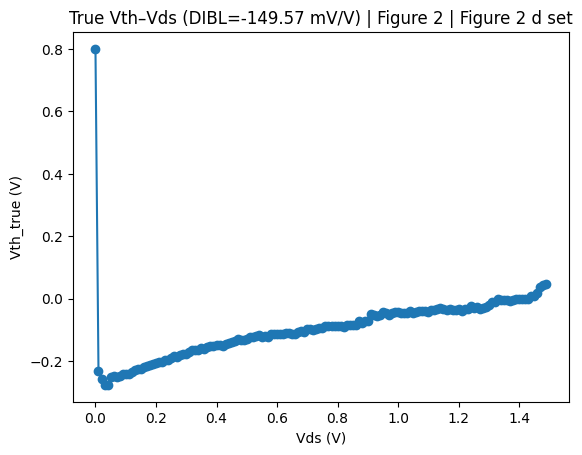


Done.


In [ ]:
!pip -q install zenodo-get pandas numpy pyarrow matplotlib

import re, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# =======================
# 0) Download Zenodo
# =======================
DOI = "10.5281/zenodo.14825422"
DATA_ROOT = Path("/content/zenodo_data")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

print("Downloading:", DOI)
!zenodo_get {DOI} -o /content/zenodo_data

for z in DATA_ROOT.rglob("*.zip"):
    !unzip -o "{str(z)}" -d "{str(z.parent)}" >/dev/null || true

csvs = sorted(DATA_ROOT.rglob("*.csv"))
print("CSV count:", len(csvs))
for p in csvs:
    print(" -", p)

# =======================
# 1) Helpers
# =======================
def norm_cols(cols):
    return [re.sub(r"\s+", "", str(c)).lower() for c in cols]

def to_num(x):
    return pd.to_numeric(pd.Series(x), errors="coerce").values

def pick_col(df, keys):
    cols = df.columns
    for k in keys:
        if k in cols:
            return k
    for k in keys:
        for c in cols:
            if k in c:
                return c
    return None

def ensure_sorted_by_vg(vg, idv):
    o = np.argsort(vg)
    return vg[o], idv[o]

def robust_vth_from_points(vg, idv, id_ref):
    """
    True Vth: solve log10(|Id|)=log10(id_ref) by linear interpolation in log domain.
    Returns NaN if no crossing.
    """
    vg = np.asarray(vg, float)
    idv = np.asarray(idv, float)
    m = np.isfinite(vg) & np.isfinite(idv)
    vg = vg[m]; idv = idv[m]
    if vg.size < 40:
        return np.nan

    # sort by vg
    vg, idv = ensure_sorted_by_vg(vg, idv)

    # make polarity consistent (use high-Vg sign)
    top = np.argsort(vg)[-5:]
    sgn = np.sign(np.nanmedian(idv[top]))
    if sgn == 0: sgn = 1.0
    idv = idv * sgn

    abs_id = np.abs(idv) + 1e-30
    y = np.log10(abs_id)
    yref = math.log10(max(id_ref, 1e-30))

    # find segment where y crosses yref
    dy = y - yref
    idx = np.where(dy[:-1] * dy[1:] <= 0)[0]  # sign change or exact hit
    if len(idx) == 0:
        return np.nan

    # pick the crossing closest to mid Vg (usually around threshold)
    mid = 0.5*(np.min(vg)+np.max(vg))
    best_vth = np.nan
    best_dist = np.inf
    for i in idx:
        x0, x1 = vg[i], vg[i+1]
        y0, y1 = y[i], y[i+1]
        if not (np.isfinite(x0) and np.isfinite(x1) and np.isfinite(y0) and np.isfinite(y1)):
            continue
        if y1 == y0:
            x = x0
        else:
            t = (yref - y0) / (y1 - y0)
            t = max(0.0, min(1.0, t))
            x = x0 + t*(x1-x0)
        d = abs(x - mid)
        if d < best_dist:
            best_dist = d
            best_vth = x

    return float(best_vth)

def robust_ss_from_points(vg, idv, id_low, id_high):
    """
    SS in mV/dec from linear fit log10(|Id|)=m*Vg+b on subthreshold window.
    Uses points with |Id| in [id_low, id_high].
    """
    vg = np.asarray(vg, float)
    idv = np.asarray(idv, float)
    msk = np.isfinite(vg) & np.isfinite(idv)
    vg = vg[msk]; idv = idv[msk]
    if vg.size < 40:
        return np.nan

    vg, idv = ensure_sorted_by_vg(vg, idv)

    top = np.argsort(vg)[-5:]
    sgn = np.sign(np.nanmedian(idv[top]))
    if sgn == 0: sgn = 1.0
    idv = idv * sgn

    abs_id = np.abs(idv) + 1e-30
    keep = (abs_id >= id_low) & (abs_id <= id_high)
    if keep.sum() < 20:
        return np.nan

    x = vg[keep]
    y = np.log10(abs_id[keep])

    A = np.vstack([x, np.ones_like(x)]).T
    mfit, bfit = np.linalg.lstsq(A, y, rcond=None)[0]
    if not np.isfinite(mfit) or mfit <= 0:
        return np.nan
    ss = (1.0/mfit)*1000.0
    # sanity bounds
    if ss < 20 or ss > 800:
        return np.nan
    return float(ss)

def curve_base_name(path: Path):
    # normalize so "Figure 2 d set.csv" -> "Figure 2 d set"
    nm = path.name
    nm = nm.replace(".csv", "")
    nm = re.sub(r"\s+", " ", nm).strip()
    return nm

# =======================
# 2) Extract raw points per (file, vds bucket)
# =======================
points_rows = []
metrics_rows = []

for p in csvs:
    df = pd.read_csv(p)
    df.columns = norm_cols(df.columns)

    vg_col = pick_col(df, ["vgs","vg","gate"])
    id_col = pick_col(df, ["id/w","ids","id","current"])
    vd_col = pick_col(df, ["vds","vd"])

    if vg_col is None or id_col is None:
        continue

    # reject obvious non-device waveforms
    if "time" in vg_col or vg_col == "vdd":
        continue

    base = curve_base_name(p)
    figure_id = str(p.parent.name)

    # read numeric arrays
    vg_all = to_num(df[vg_col].values)
    id_all = to_num(df[id_col].values)

    if vd_col is not None:
        vd_all = to_num(df[vd_col].values)
    else:
        vd_all = np.full_like(vg_all, np.nan, dtype=float)

    m = np.isfinite(vg_all) & np.isfinite(id_all)
    vg_all = vg_all[m]; id_all = id_all[m]; vd_all = vd_all[m]

    if vg_all.size < 60:
        continue

    # If Vds exists with many values -> bucket (0.01V resolution)
    if np.isfinite(vd_all).sum() > 20:
        vdb = np.round(vd_all, 2)
        # keep only finite buckets
        tmp = pd.DataFrame({"vg":vg_all, "id":id_all, "vds":vdb})
        groups = tmp.groupby("vds")
        for vds, g in groups:
            if len(g) < 60:
                continue
            vg = g["vg"].values
            idv = g["id"].values

            # compute Ion/Ioff from points
            abs_id = np.abs(idv) + 1e-30
            Ion = float(np.median(np.sort(abs_id)[-3:]))
            Ioff = float(np.median(np.sort(abs_id)[:3]))
            id_ref = math.sqrt(max(Ion,1e-30)*max(Ioff,1e-30))

            Vth = robust_vth_from_points(vg, idv, id_ref=id_ref)
            SS  = robust_ss_from_points(vg, idv, id_low=id_ref/100.0, id_high=id_ref*100.0)

            curve_key = f"{figure_id}::{base}::vds={vds:.2f}"

            # save points
            for a,b in zip(vg, idv):
                points_rows.append({
                    "curve_key": curve_key,
                    "figure_id": figure_id,
                    "base_name": base,
                    "vds_V": float(vds),
                    "Vg_V": float(a),
                    "Id_A": float(b),
                })

            metrics_rows.append({
                "curve_key": curve_key,
                "figure_id": figure_id,
                "base_name": base,
                "source_file": str(p),
                "vds_V": float(vds),
                "Vg_min_V": float(np.nanmin(vg)),
                "Vg_max_V": float(np.nanmax(vg)),
                "n_points": int(len(g)),
                "Ion_A": Ion,
                "Ioff_A": Ioff,
                "Id_ref_A": float(id_ref),
                "Vth_true_V": Vth,
                "SS_true_mVdec": SS,
            })

    else:
        # single Vds unknown curve: still save as one curve (vds=NaN)
        vds = np.nan
        vg = vg_all
        idv = id_all

        abs_id = np.abs(idv) + 1e-30
        Ion = float(np.median(np.sort(abs_id)[-3:]))
        Ioff = float(np.median(np.sort(abs_id)[:3]))
        id_ref = math.sqrt(max(Ion,1e-30)*max(Ioff,1e-30))

        Vth = robust_vth_from_points(vg, idv, id_ref=id_ref)
        SS  = robust_ss_from_points(vg, idv, id_low=id_ref/100.0, id_high=id_ref*100.0)

        curve_key = f"{figure_id}::{base}::single"

        for a,b in zip(vg, idv):
            points_rows.append({
                "curve_key": curve_key,
                "figure_id": figure_id,
                "base_name": base,
                "vds_V": np.nan,
                "Vg_V": float(a),
                "Id_A": float(b),
            })

        metrics_rows.append({
            "curve_key": curve_key,
            "figure_id": figure_id,
            "base_name": base,
            "source_file": str(p),
            "vds_V": np.nan,
            "Vg_min_V": float(np.nanmin(vg)),
            "Vg_max_V": float(np.nanmax(vg)),
            "n_points": int(len(vg)),
            "Ion_A": Ion,
            "Ioff_A": Ioff,
            "Id_ref_A": float(id_ref),
            "Vth_true_V": Vth,
            "SS_true_mVdec": SS,
        })

points_df = pd.DataFrame(points_rows)
metrics_df = pd.DataFrame(metrics_rows)

# Save
points_path = "/content/curve_points.parquet"
metrics_path = "/content/curve_metrics_trueVth.csv"
points_df.to_parquet(points_path, index=False)
metrics_df.to_csv(metrics_path, index=False)

print("✅ Saved raw points:", points_path, "rows=", len(points_df))
print("✅ Saved per-curve metrics:", metrics_path, "curves=", len(metrics_df))
display(metrics_df.head(10))

# =======================
# 3) True DIBL per device family (figure_id + base_name)
# =======================
# Only curves with finite vds and finite Vth
m2 = metrics_df[np.isfinite(metrics_df["vds_V"]) & np.isfinite(metrics_df["Vth_true_V"])].copy()

dibl_rows = []
for (fig, base), g in m2.groupby(["figure_id","base_name"]):
    if g["vds_V"].nunique() < 6:
        continue
    x = g["vds_V"].values
    y = g["Vth_true_V"].values
    A = np.vstack([x, np.ones_like(x)]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]  # Vth = slope*Vds + intercept
    dibl = -slope * 1000.0  # mV/V (common sign convention)
    dibl_rows.append({
        "figure_id": fig,
        "base_name": base,
        "n_curves": int(len(g)),
        "vds_min": float(np.min(x)),
        "vds_max": float(np.max(x)),
        "Vth_slope_V_per_V": float(slope),
        "DIBL_true_mV_per_V": float(dibl),
    })

dibl_df = pd.DataFrame(dibl_rows).sort_values(["figure_id","base_name"])
dibl_path = "/content/dibl_true.csv"
dibl_df.to_csv(dibl_path, index=False)

print("✅ Saved true DIBL:", dibl_path, "rows=", len(dibl_df))
display(dibl_df.head(20))

# =======================
# 4) Plot one example Vth vs Vds
# =======================
if len(dibl_df) > 0:
    ex = dibl_df.iloc[0]
    fig = ex["figure_id"]; base = ex["base_name"]
    g = m2[(m2["figure_id"]==fig) & (m2["base_name"]==base)].sort_values("vds_V")

    plt.figure()
    plt.plot(g["vds_V"].values, g["Vth_true_V"].values, marker="o")
    plt.xlabel("Vds (V)")
    plt.ylabel("Vth_true (V)")
    plt.title(f"True Vth–Vds (DIBL={ex['DIBL_true_mV_per_V']:.2f} mV/V) | {fig} | {base}")
    plt.show()

print("\nDone.")


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
Keywords: Field-effect transistor, Logic gates, MoS2
Publication date: 2025-02-06
DOI: 10.5281/zenodo.14825422
Total size: 1.6 MB

File: Figures.zip (1.6 MB)
Link: https://zenodo.org/api/records/14825422/files/Figures.zip/content
Figures.zip is already downloaded correctly.

File: Readme.pdf (44.4 kB)
Link: https://zenodo.org/api/records/14825422/files/Readme.pdf/content
Readme.pdf is already downloaded correctly.

All specified files have been processed.
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figu

curve_key figure_id        base_name  \
0   Figure 2::Figure 2 c blue::single  Figure 2  Figure 2 c blue   
1    Figure 2::Figure 2 c red::single  Figure 2   Figure 2 c red   
2  Figure 2::Figure 2 d set::vds=0.00  Figure 2   Figure 2 d set   
3  Figure 2::Figure 2 d set::vds=0.01  Figure 2   Figure 2 d set   
4  Figure 2::Figure 2 d set::vds=0.02  Figure 2   Figure 2 d set   
5  Figure 2::Figure 2 d set::vds=0.03  Figure 2   Figure 2 d set   
6  Figure 2::Figure 2 d set::vds=0.04  Figure 2   Figure 2 d set   
7  Figure 2::Figure 2 d set::vds=0.05  Figure 2   Figure 2 d set   

                                         source_file  vds_V  Vg_min_V  \
0  /content/zenodo_data/Figure 2/Figure 2 c blue.csv    NaN      -1.5   
1   /content/zenodo_data/Figure 2/Figure 2 c red.csv    NaN      -2.0   
2   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.00      -1.0   
3   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.01      -1.0   
4   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.02      -1.0   
5   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.03      -1.0   
6   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.04      -1.0   
7   /content/zenodo_data/Figure 2/Figure 2 d set.csv   0.05      -1.0   

   Vg_max_V  Vg_span_V  n_points      Ion_A    Ioff_A  Id_ref_A  Vth_true_V  \
0       1.0        2.5       802   2.192283  0.001834  0.063417   -0.343706   
1       1.0        3.0       802   6.707033  0.000075  0.022428   -1.032500   
2       2.7        3.7        70   1.062547  0.000093  0.009962    0.800000   
3       2.7        3.7        70   2.362468  0.000091  0.014622   -0.233002   
4       2.7        3.7       106   5.476868  0.000117  0.025314   -0.257822   
5       2.7        3.7       102   8.022340  0.000190  0.039042   -0.276006   
6       2.7        3.7       106  10.731434  0.000288  0.055594   -0.274828   
7       2.7        3.7        68  12.052566  0.000554  0.081714   -0.250157   

   SS_true_mVdec  
0     615.359530  
1     336.586583  
2            NaN  
3            NaN  
4     687.214709  
5     655.826261  
6     665.146055  
7     725.345276

✅ Saved true DIBL: /content/dibl_true.csv rows=2


figure_id       base_name  n_curves  vds_min  vds_max  Vth_slope_V_per_V  \
0  Figure 2  Figure 2 d set       150     0.00     1.49           0.149571   
1  Figure 3      Figure 3 b        92     0.02     1.98           0.124513   

   DIBL_true_mV_per_V  
0         -149.571123  
1         -124.512822

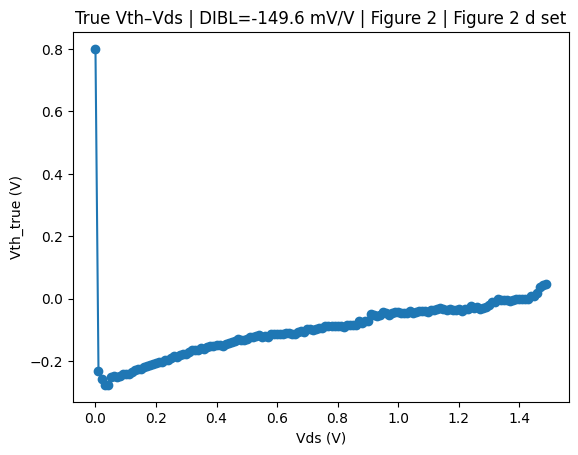

✅ Saved unified dataset: /content/reliability_dataset.csv rows=245
Constraints used:
 - SS_MAX (mV/dec): 796.081990547806
 - IOFF_MAX (A):    0.0110101217239396
 - DIBL_MAX (mV/V): 149.5711225163691
✅ Surrogate R^2 (leak-free): {'log_Ion': 0.9945758191068612, 'log_Ioff': 0.9969180555281543, 'SS_true_mVdec': 0.8842750374283876}
✅ Saved R^2: /content/surrogate_r2.json


LLM rounds: 100%|██████████| 30/30 [00:45<00:00,  1.52s/it]


Best: {'family_id': 'Figure 3||Figure 3 b', 'Vg_min_V': -0.8058495940333228, 'Vg_max_V': -0.350528738454468, 'vds_V': 0.038698643686247224}
Pred: {'Ion_A': 8.018339565063096, 'Ioff_A': 0.00018997920841103344, 'SS_mVdec': 655.8367309570312, 'DIBL_mV_V': -124.51282233205218, 'utility': 2.3239974672465507, 'feasible': True}
✅ Wrote /content/llm_reliability_results.csv rows=30


round                 family_id  Vg_min_V  Vg_max_V   vds_V   log_Ion  \
1       1      Figure 3||Figure 3 b     -0.90     -0.50  0.0400  1.028998   
6       6      Figure 3||Figure 3 b     -0.70     -0.30  0.5000  2.274160   
28     28      Figure 3||Figure 3 b     -0.70     -0.30  0.5000  2.274160   
2       2      Figure 3||Figure 3 b     -0.75     -0.30  0.0900  1.359941   
12     12  Figure 2||Figure 2 d set     -0.70     -0.30  0.5000  2.274160   
0       0      Figure 3||Figure 3 b     -0.80     -0.34  0.0400  1.058311   
3       3      Figure 3||Figure 3 b     -0.75     -0.20  0.0400  1.058311   
10     10      Figure 3||Figure 3 b     -0.70     -0.30  0.0400  1.058311   
21     21      Figure 3||Figure 3 b     -0.80     -0.35  0.0400  1.058311   
4       4      Figure 3||Figure 3 b     -0.80     -0.30  0.2000  1.824652   
17     17  Figure 2||Figure 2 d set     -0.70     -0.20  0.0400  1.058311   
15     15      Figure 3||Figure 3 b     -0.80     -0.30  0.1500  1.635421   
9       9      Figure 3||Figure 3 b     -0.80     -0.40  0.0390  0.930991   
13     13      Figure 3||Figure 3 b     -0.80     -0.35  0.0387  0.930991   
16     16      Figure 3||Figure 3 b     -0.80     -0.30  0.0387  0.930991   

    log_Ioff       Ion_A    Ioff_A    SS_mVdec   DIBL_mV_V   utility  feasible  
1  -3.543351   10.690503  0.000286  665.220276 -124.512822  2.263108      True  
6  -0.491924  188.000788  0.322163  797.336975 -124.512822  0.243467     False  
28 -0.491924  188.000788  0.322163  797.336975 -124.512822  0.243467     False  
2  -1.558814   22.905540  0.027618  791.045715 -124.512822  0.235313     False  
12 -0.491924  188.000788  0.322163  797.336975 -149.571123  0.205880     False  
0  -1.794068   11.436983  0.016067  781.015076 -124.512822  0.143719     False  
3  -1.794068   11.436983  0.016067  781.015076 -124.512822  0.143719     False  
10 -1.794068   11.436983  0.016067  781.015076 -124.512822  0.143719     False  
21 -1.794068   11.436983  0.016067  781.015076 -124.512822  0.143719     False  
4  -0.907022   66.780870  0.123873  800.380066 -124.512822  0.108505     False  
17 -1.794068   11.436983  0.016067  781.015076 -149.571123  0.106132     False  
15 -1.103899   43.193775  0.078723  795.843384 -124.512822  0.094183     False  
9  -1.816760    8.530831  0.015249  768.856201 -124.512822  0.056184     False  
13 -1.816760    8.530831  0.015249  768.856201 -124.512822  0.056184     False  
16 -1.816760    8.530831  0.015249  768.856201 -124.512822  0.056184     False

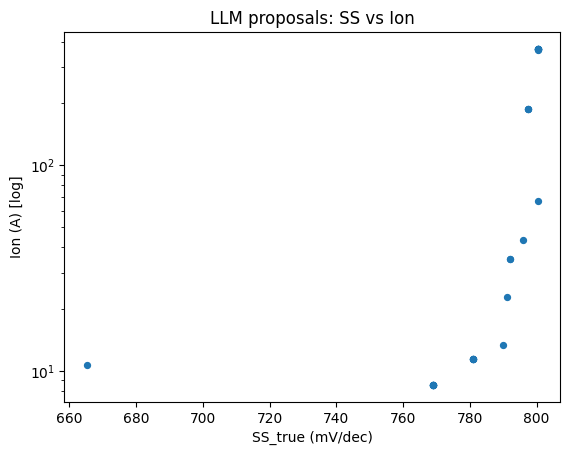

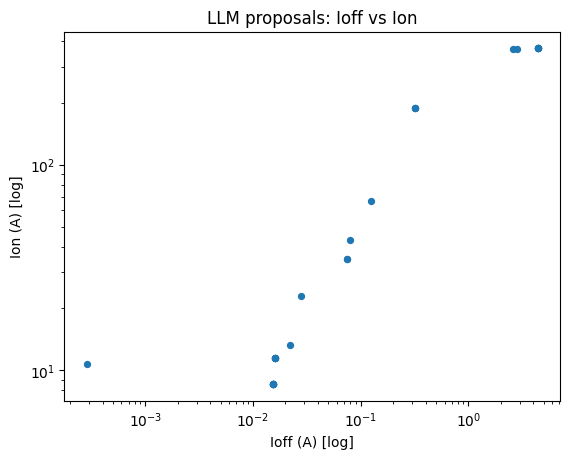

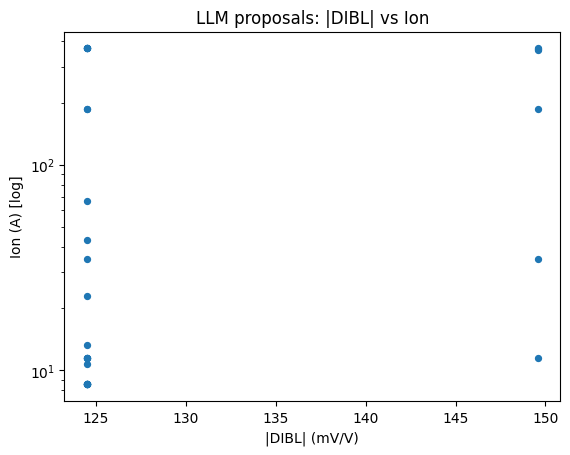


All key artifacts:
 - /content/curve_points.parquet
 - /content/curve_metrics_trueVth.csv
 - /content/dibl_true.csv
 - /content/reliability_dataset.csv
 - /content/surrogate_r2.json
 - /content/llm_reliability_results.csv

Done.


In [ ]:
# ==========================
# ONE-CELL PIPELINE (Unified)
# True Vth/SS extraction + True DIBL + Leak-free surrogate + LLM (OpenRouter) optimization
# Data: Zenodo 10.5281/zenodo.14825422 (MoS2 transistors)
# ==========================

!pip -q install zenodo-get pandas numpy pyarrow scikit-learn xgboost openai tqdm matplotlib

import os, re, math, json, random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from openai import OpenAI

# --------------------------
# 0) Config
# --------------------------
DOI = "10.5281/zenodo.14825422"
DATA_ROOT = Path("/content/zenodo_data")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

# OpenRouter auth: set via Colab Secrets (recommended) or hardcode here:
# os.environ["OPENROUTER_API_KEY"] = "sk-or-v1-..."  # <-- uncomment & fill if needed

OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "")
BASE_URL = "https://openrouter.ai/api/v1"
LLM_MODEL = "openai/gpt-4.1"   # you can swap to cheaper models later
TEMPERATURE = 0.3
N_ROUNDS = 30

# Reliability-aware constraints (data-driven default; will be computed after extraction)
USE_DATA_DRIVEN_CONSTRAINTS = True
SS_MAX = 450.0        # fallback if not data-driven
IOFF_MAX = 1e-3       # fallback if not data-driven
DIBL_MAX = 200.0      # mV/V fallback if not data-driven

# Output paths
POINTS_PARQUET = "/content/curve_points.parquet"
CURVE_METRICS_CSV = "/content/curve_metrics_trueVth.csv"
DIBL_TRUE_CSV = "/content/dibl_true.csv"
DATASET_CSV = "/content/reliability_dataset.csv"
SUR_R2_JSON = "/content/surrogate_r2.json"
LLM_RESULTS_CSV = "/content/llm_reliability_results.csv"

# --------------------------
# 1) Download & unzip
# --------------------------
print("Downloading:", DOI)
!zenodo_get {DOI} -o /content/zenodo_data

for z in DATA_ROOT.rglob("*.zip"):
    !unzip -o "{str(z)}" -d "{str(z.parent)}" >/dev/null || true

csvs = sorted(DATA_ROOT.rglob("*.csv"))
print("CSV count:", len(csvs))
for p in csvs:
    print(" -", p)

# --------------------------
# 2) Helpers
# --------------------------
def norm_cols(cols):
    return [re.sub(r"\s+", "", str(c)).lower() for c in cols]

def to_num(x):
    return pd.to_numeric(pd.Series(x), errors="coerce").values

def pick_col(df, keys):
    cols = df.columns
    for k in keys:
        if k in cols:
            return k
    for k in keys:
        for c in cols:
            if k in c:
                return c
    return None

def curve_base_name(path: Path):
    nm = path.name.replace(".csv", "")
    nm = re.sub(r"\s+", " ", nm).strip()
    return nm

def ensure_sorted_by_vg(vg, idv):
    o = np.argsort(vg)
    return vg[o], idv[o]

def robust_vth_from_points(vg, idv, id_ref):
    vg = np.asarray(vg, float)
    idv = np.asarray(idv, float)
    m = np.isfinite(vg) & np.isfinite(idv)
    vg = vg[m]; idv = idv[m]
    if vg.size < 40:
        return np.nan

    vg, idv = ensure_sorted_by_vg(vg, idv)

    top = np.argsort(vg)[-5:]
    sgn = np.sign(np.nanmedian(idv[top]))
    if sgn == 0: sgn = 1.0
    idv = idv * sgn

    abs_id = np.abs(idv) + 1e-30
    y = np.log10(abs_id)
    yref = math.log10(max(id_ref, 1e-30))

    dy = y - yref
    idx = np.where(dy[:-1] * dy[1:] <= 0)[0]
    if len(idx) == 0:
        return np.nan

    mid = 0.5*(np.min(vg)+np.max(vg))
    best_vth = np.nan
    best_dist = np.inf
    for i in idx:
        x0, x1 = vg[i], vg[i+1]
        y0, y1 = y[i], y[i+1]
        if not (np.isfinite(x0) and np.isfinite(x1) and np.isfinite(y0) and np.isfinite(y1)):
            continue
        if y1 == y0:
            x = x0
        else:
            t = (yref - y0) / (y1 - y0)
            t = max(0.0, min(1.0, t))
            x = x0 + t*(x1-x0)
        d = abs(x - mid)
        if d < best_dist:
            best_dist = d
            best_vth = x
    return float(best_vth)

def robust_ss_from_points(vg, idv, id_low, id_high):
    vg = np.asarray(vg, float)
    idv = np.asarray(idv, float)
    msk = np.isfinite(vg) & np.isfinite(idv)
    vg = vg[msk]; idv = idv[msk]
    if vg.size < 40:
        return np.nan

    vg, idv = ensure_sorted_by_vg(vg, idv)

    top = np.argsort(vg)[-5:]
    sgn = np.sign(np.nanmedian(idv[top]))
    if sgn == 0: sgn = 1.0
    idv = idv * sgn

    abs_id = np.abs(idv) + 1e-30
    keep = (abs_id >= id_low) & (abs_id <= id_high)
    if keep.sum() < 20:
        return np.nan

    x = vg[keep]
    y = np.log10(abs_id[keep])

    A = np.vstack([x, np.ones_like(x)]).T
    mfit, bfit = np.linalg.lstsq(A, y, rcond=None)[0]
    if not np.isfinite(mfit) or mfit <= 0:
        return np.nan

    ss = (1.0/mfit)*1000.0
    if ss < 20 or ss > 800:
        return np.nan
    return float(ss)

# --------------------------
# 3) Extract raw points + true per-curve metrics (true Vth + SS windowed)
# --------------------------
points_rows = []
metrics_rows = []

for p in csvs:
    df = pd.read_csv(p)
    df.columns = norm_cols(df.columns)

    vg_col = pick_col(df, ["vgs","vg","gate"])
    id_col = pick_col(df, ["id/w","ids","id","current"])
    vd_col = pick_col(df, ["vds","vd"])

    if vg_col is None or id_col is None:
        continue

    # reject obvious non-IdVg waveforms
    if vg_col in ["time", "vdd"] or "time" in vg_col:
        continue

    base = curve_base_name(p)
    figure_id = str(p.parent.name)

    vg_all = to_num(df[vg_col].values)
    id_all = to_num(df[id_col].values)
    if vd_col is not None:
        vd_all = to_num(df[vd_col].values)
    else:
        vd_all = np.full_like(vg_all, np.nan, dtype=float)

    m = np.isfinite(vg_all) & np.isfinite(id_all)
    vg_all = vg_all[m]; id_all = id_all[m]; vd_all = vd_all[m]
    if vg_all.size < 60:
        continue

    # bucket Vds if present
    if np.isfinite(vd_all).sum() > 20:
        vdb = np.round(vd_all, 2)
        tmp = pd.DataFrame({"vg": vg_all, "id": id_all, "vds": vdb})
        groups = tmp.groupby("vds")
        for vds, g in groups:
            if len(g) < 60:
                continue

            vg = g["vg"].values
            idv = g["id"].values

            abs_id = np.abs(idv) + 1e-30
            Ion = float(np.median(np.sort(abs_id)[-3:]))
            Ioff = float(np.median(np.sort(abs_id)[:3]))
            id_ref = math.sqrt(max(Ion,1e-30)*max(Ioff,1e-30))

            Vth = robust_vth_from_points(vg, idv, id_ref=id_ref)
            SS  = robust_ss_from_points(vg, idv, id_low=id_ref/100.0, id_high=id_ref*100.0)

            curve_key = f"{figure_id}::{base}::vds={vds:.2f}"
            for a,b in zip(vg, idv):
                points_rows.append({
                    "curve_key": curve_key,
                    "figure_id": figure_id,
                    "base_name": base,
                    "vds_V": float(vds),
                    "Vg_V": float(a),
                    "Id_A": float(b),
                })

            metrics_rows.append({
                "curve_key": curve_key,
                "figure_id": figure_id,
                "base_name": base,
                "source_file": str(p),
                "vds_V": float(vds),
                "Vg_min_V": float(np.nanmin(vg)),
                "Vg_max_V": float(np.nanmax(vg)),
                "Vg_span_V": float(np.nanmax(vg)-np.nanmin(vg)),
                "n_points": int(len(g)),
                "Ion_A": Ion,
                "Ioff_A": Ioff,
                "Id_ref_A": float(id_ref),
                "Vth_true_V": Vth,
                "SS_true_mVdec": SS,
            })
    else:
        vg = vg_all
        idv = id_all

        abs_id = np.abs(idv) + 1e-30
        Ion = float(np.median(np.sort(abs_id)[-3:]))
        Ioff = float(np.median(np.sort(abs_id)[:3]))
        id_ref = math.sqrt(max(Ion,1e-30)*max(Ioff,1e-30))

        Vth = robust_vth_from_points(vg, idv, id_ref=id_ref)
        SS  = robust_ss_from_points(vg, idv, id_low=id_ref/100.0, id_high=id_ref*100.0)

        curve_key = f"{figure_id}::{base}::single"
        for a,b in zip(vg, idv):
            points_rows.append({
                "curve_key": curve_key,
                "figure_id": figure_id,
                "base_name": base,
                "vds_V": np.nan,
                "Vg_V": float(a),
                "Id_A": float(b),
            })

        metrics_rows.append({
            "curve_key": curve_key,
            "figure_id": figure_id,
            "base_name": base,
            "source_file": str(p),
            "vds_V": np.nan,
            "Vg_min_V": float(np.nanmin(vg)),
            "Vg_max_V": float(np.nanmax(vg)),
            "Vg_span_V": float(np.nanmax(vg)-np.nanmin(vg)),
            "n_points": int(len(vg)),
            "Ion_A": Ion,
            "Ioff_A": Ioff,
            "Id_ref_A": float(id_ref),
            "Vth_true_V": Vth,
            "SS_true_mVdec": SS,
        })

points_df = pd.DataFrame(points_rows)
metrics_df = pd.DataFrame(metrics_rows)

points_df.to_parquet(POINTS_PARQUET, index=False)
metrics_df.to_csv(CURVE_METRICS_CSV, index=False)

print(f"✅ Saved raw points: {POINTS_PARQUET} rows={len(points_df):,}")
print(f"✅ Saved per-curve metrics: {CURVE_METRICS_CSV} curves={len(metrics_df):,}")
display(metrics_df.head(8))

# --------------------------
# 4) True DIBL per device-family (figure_id + base_name)
# --------------------------
m2 = metrics_df[np.isfinite(metrics_df["vds_V"]) & np.isfinite(metrics_df["Vth_true_V"])].copy()

dibl_rows = []
for (fig, base), g in m2.groupby(["figure_id","base_name"]):
    if g["vds_V"].nunique() < 6:
        continue
    x = g["vds_V"].values
    y = g["Vth_true_V"].values
    A = np.vstack([x, np.ones_like(x)]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]  # Vth = slope*Vds + intercept
    dibl = -slope * 1000.0  # mV/V
    dibl_rows.append({
        "figure_id": fig,
        "base_name": base,
        "n_curves": int(len(g)),
        "vds_min": float(np.min(x)),
        "vds_max": float(np.max(x)),
        "Vth_slope_V_per_V": float(slope),
        "DIBL_true_mV_per_V": float(dibl),
    })

dibl_df = pd.DataFrame(dibl_rows).sort_values(["figure_id","base_name"]).reset_index(drop=True)
dibl_df.to_csv(DIBL_TRUE_CSV, index=False)

print(f"✅ Saved true DIBL: {DIBL_TRUE_CSV} rows={len(dibl_df)}")
display(dibl_df)

# Plot one example Vth-Vds
if len(dibl_df) > 0:
    ex = dibl_df.iloc[0]
    fig = ex["figure_id"]; base = ex["base_name"]
    g = m2[(m2["figure_id"]==fig) & (m2["base_name"]==base)].sort_values("vds_V")
    plt.figure()
    plt.plot(g["vds_V"], g["Vth_true_V"], marker="o")
    plt.xlabel("Vds (V)")
    plt.ylabel("Vth_true (V)")
    plt.title(f"True Vth–Vds | DIBL={ex['DIBL_true_mV_per_V']:.1f} mV/V | {fig} | {base}")
    plt.show()

# --------------------------
# 5) Build unified reliability dataset (merge DIBL into each curve row)
# --------------------------
ds = metrics_df.copy()
ds["family_id"] = ds["figure_id"].astype(str) + "||" + ds["base_name"].astype(str)

dibl_df2 = dibl_df.copy()
dibl_df2["family_id"] = dibl_df2["figure_id"].astype(str) + "||" + dibl_df2["base_name"].astype(str)

ds = ds.merge(dibl_df2[["family_id","DIBL_true_mV_per_V"]], on="family_id", how="left")
# fill missing family DIBL with median (for single curves without vds sweep)
if ds["DIBL_true_mV_per_V"].notna().any():
    ds["DIBL_true_mV_per_V"] = ds["DIBL_true_mV_per_V"].fillna(ds["DIBL_true_mV_per_V"].median())
else:
    ds["DIBL_true_mV_per_V"] = 0.0

# clean SS
ds["SS_true_mVdec"] = pd.to_numeric(ds["SS_true_mVdec"], errors="coerce")
ds["SS_true_mVdec"] = ds["SS_true_mVdec"].fillna(800.0)  # penalize missing SS

# log targets
ds["log_Ion"] = np.log10(np.maximum(ds["Ion_A"].values, 1e-30))
ds["log_Ioff"] = np.log10(np.maximum(ds["Ioff_A"].values, 1e-30))

# save
ds.to_csv(DATASET_CSV, index=False)
print(f"✅ Saved unified dataset: {DATASET_CSV} rows={len(ds)}")

# --------------------------
# 6) Data-driven constraints (so LLM can actually find feasible points in your real distribution)
# --------------------------
if USE_DATA_DRIVEN_CONSTRAINTS:
    # pick moderately strict but attainable constraints from real data
    SS_MAX = float(np.nanpercentile(ds["SS_true_mVdec"].values, 35))     # tighter -> smaller %
    IOFF_MAX = float(10**np.nanpercentile(ds["log_Ioff"].values, 35))    # lower Ioff is better
    DIBL_MAX = float(np.nanpercentile(np.abs(ds["DIBL_true_mV_per_V"].values), 70))
print("Constraints used:")
print(" - SS_MAX (mV/dec):", SS_MAX)
print(" - IOFF_MAX (A):   ", IOFF_MAX)
print(" - DIBL_MAX (mV/V):", DIBL_MAX)

# --------------------------
# 7) Leak-free surrogate training (inputs are only design knobs + family id + Vds)
# --------------------------
train_ds = ds[np.isfinite(ds["vds_V"])].copy()  # DIBL needs finite vds
if len(train_ds) < 50:
    train_ds = ds.copy()

# Features: only controllable knobs / identifiers (NO Ion/Ioff/SS)
feat = train_ds[[
    "Vg_min_V","Vg_max_V","Vg_span_V",
    "vds_V",
    "family_id",
    "DIBL_true_mV_per_V"  # treat as known property of family (not a label)
]].copy()

X = pd.get_dummies(feat, columns=["family_id"], drop_first=False)
Y = train_ds[["log_Ion","log_Ioff","SS_true_mVdec"]].copy()

Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.25, random_state=42)
X_cols = list(X.columns)

sur = {}
r2s = {}
for t in ["log_Ion","log_Ioff","SS_true_mVdec"]:
    m = XGBRegressor(
        n_estimators=700, max_depth=6, learning_rate=0.04,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        random_state=42, n_jobs=0
    )
    m.fit(Xtr, Ytr[t].values)
    pred = m.predict(Xte)
    r2s[t] = float(r2_score(Yte[t].values, pred))
    sur[t] = m

with open(SUR_R2_JSON, "w") as f:
    json.dump(r2s, f, indent=2)

print("✅ Surrogate R^2 (leak-free):", r2s)
print(f"✅ Saved R^2: {SUR_R2_JSON}")

# --------------------------
# 8) OpenRouter LLM optimization (reliability-aware)
# --------------------------
if not OPENROUTER_API_KEY:
    raise ValueError("OPENROUTER_API_KEY is empty. Set it in Colab Secrets or os.environ['OPENROUTER_API_KEY'].")

client = OpenAI(api_key=OPENROUTER_API_KEY, base_url=BASE_URL)

FAMS = sorted(train_ds["family_id"].unique().tolist())
VG_LO = float(train_ds["Vg_min_V"].min())
VG_HI = float(train_ds["Vg_max_V"].max())
VDS_LO = float(np.nanmin(train_ds["vds_V"].values))
VDS_HI = float(np.nanmax(train_ds["vds_V"].values))

fam2dibl = train_ds.groupby("family_id")["DIBL_true_mV_per_V"].median().to_dict()

def make_row(fam, vg_min, vg_max, vds):
    dibl = float(fam2dibl.get(fam, np.median(list(fam2dibl.values()))))
    r = pd.DataFrame([{
        "Vg_min_V": vg_min,
        "Vg_max_V": vg_max,
        "Vg_span_V": vg_max-vg_min,
        "vds_V": vds,
        "family_id": fam,
        "DIBL_true_mV_per_V": dibl,
    }])
    r = pd.get_dummies(r, columns=["family_id"], drop_first=False)
    for c in X_cols:
        if c not in r.columns:
            r[c] = 0
    return r[X_cols]

def predict(fam, vg_min, vg_max, vds):
    X1 = make_row(fam, vg_min, vg_max, vds)
    log_Ion = float(sur["log_Ion"].predict(X1)[0])
    log_Ioff = float(sur["log_Ioff"].predict(X1)[0])
    SS = float(sur["SS_true_mVdec"].predict(X1)[0])
    Ion = 10**log_Ion
    Ioff = 10**log_Ioff
    dibl = float(fam2dibl.get(fam, np.median(list(fam2dibl.values()))))
    SS = SS if np.isfinite(SS) else 800.0

    feasible = (SS <= SS_MAX) and (Ioff <= IOFF_MAX) and (abs(dibl) <= DIBL_MAX)

    # utility: encourage high Ion, low Ioff, low SS, low |DIBL|
    util = (1.2*log_Ion - 1.0*log_Ioff - 0.0035*SS - 0.0015*abs(dibl))
    return {"log_Ion":log_Ion,"log_Ioff":log_Ioff,"Ion_A":Ion,"Ioff_A":Ioff,"SS_mVdec":SS,"DIBL_mV_V":dibl,"utility":util,"feasible":feasible}

SYSTEM = """Return ONLY JSON with keys:
family_id, Vg_min_V, Vg_max_V, vds_V
Rules:
- family_id must be one of the provided options
- Vg_min_V < Vg_max_V
- keep within bounds
No prose.
"""

def parse_json(txt):
    m = re.search(r"\{.*\}", txt, flags=re.S)
    obj = json.loads(m.group(0))
    fam = str(obj.get("family_id", FAMS[0]))
    if fam not in FAMS: fam = FAMS[0]
    vmin = float(obj.get("Vg_min_V", VG_LO))
    vmax = float(obj.get("Vg_max_V", min(VG_HI, VG_LO+0.5)))
    vds  = float(obj.get("vds_V", VDS_LO))

    vmin = max(VG_LO, min(VG_HI, vmin))
    vmax = max(VG_LO, min(VG_HI, vmax))
    if vmax <= vmin + 1e-6:
        vmax = min(VG_HI, vmin + 0.5)
    vds = max(VDS_LO, min(VDS_HI, vds))
    return {"family_id": fam, "Vg_min_V": vmin, "Vg_max_V": vmax, "vds_V": vds}

# warm start
best = None
for _ in range(80):
    fam = random.choice(FAMS)
    vmin = random.uniform(VG_LO, VG_HI-0.5)
    vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
    vds  = random.uniform(VDS_LO, VDS_HI)
    pred = predict(fam, vmin, vmax, vds)
    cand = {"family_id": fam, "Vg_min_V": vmin, "Vg_max_V": vmax, "vds_V": vds}
    if best is None or pred["utility"] > best[1]["utility"]:
        best = (cand, pred)

all_rows = []
feedback = None

for r in tqdm(range(N_ROUNDS), desc="LLM rounds"):
    # show a short list of family options to the model (avoid huge token dump)
    fam_sample = random.sample(FAMS, k=min(12, len(FAMS)))

    prompt = f"""family_id options (sample): {fam_sample}
Bounds:
- Vg_min_V, Vg_max_V in [{VG_LO}, {VG_HI}]
- vds_V in [{VDS_LO}, {VDS_HI}]
Constraints:
- SS <= {SS_MAX:.2f} mV/dec
- Ioff <= {IOFF_MAX:.3e} A
- |DIBL| <= {DIBL_MAX:.2f} mV/V

Goal: maximize Ion, minimize Ioff, SS, and |DIBL|.
Seed (current best): {json.dumps(best[0])}
"""
    if feedback:
        prompt += f"\nLast evaluation feedback: {json.dumps(feedback)}"

    resp = client.chat.completions.create(
        model=LLM_MODEL,
        messages=[{"role":"system","content":SYSTEM},
                  {"role":"user","content":prompt}],
        temperature=TEMPERATURE,
    )

    cand = parse_json(resp.choices[0].message.content)
    pred = predict(cand["family_id"], cand["Vg_min_V"], cand["Vg_max_V"], cand["vds_V"])

    row = {"round": r, **cand, **pred}
    all_rows.append(row)

    if pred["utility"] > best[1]["utility"]:
        best = (cand, pred)

    feedback = {k: pred[k] for k in ["Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]}

print("\nBest:", best[0])
print("Pred:", {k:best[1][k] for k in ["Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]})

res = pd.DataFrame(all_rows)
res.to_csv(LLM_RESULTS_CSV, index=False)
print(f"✅ Wrote {LLM_RESULTS_CSV} rows={len(res)}")

top = res.sort_values(["feasible","utility"], ascending=[False, False]).head(15)
display(top)

# --------------------------
# 9) Quick plots (Pareto-ish)
# --------------------------
plt.figure()
plt.scatter(res["SS_mVdec"], res["Ion_A"], s=18)
plt.yscale("log")
plt.xlabel("SS_true (mV/dec)")
plt.ylabel("Ion (A) [log]")
plt.title("LLM proposals: SS vs Ion")
plt.show()

plt.figure()
plt.scatter(res["Ioff_A"], res["Ion_A"], s=18)
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Ioff (A) [log]")
plt.ylabel("Ion (A) [log]")
plt.title("LLM proposals: Ioff vs Ion")
plt.show()

plt.figure()
plt.scatter(np.abs(res["DIBL_mV_V"]), res["Ion_A"], s=18)
plt.yscale("log")
plt.xlabel("|DIBL| (mV/V)")
plt.ylabel("Ion (A) [log]")
plt.title("LLM proposals: |DIBL| vs Ion")
plt.show()

print("\nAll key artifacts:")
print(" -", POINTS_PARQUET)
print(" -", CURVE_METRICS_CSV)
print(" -", DIBL_TRUE_CSV)
print(" -", DATASET_CSV)
print(" -", SUR_R2_JSON)
print(" -", LLM_RESULTS_CSV)
print("\nDone.")


Two-tier constraints:
{'tier': 'relaxed', 'SS_MAX': 796.081990547806, 'IOFF_MAX': 0.0110101217239396, 'DIBL_MAX': 149.5711225163691}
{'tier': 'strict', 'SS_MAX': 778.2806443504115, 'IOFF_MAX': 0.008324679000000003, 'DIBL_MAX': 149.5711225163691}


LLM rounds (strict): 100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


Best (relaxed): {'tier': 'relaxed', 'family_id': 'Figure 3||Figure 3 b', 'Vg_min_V': -0.91, 'Vg_max_V': 0.54, 'vds_V': 0.86, 'Ion_A': 263.67091789325264, 'Ioff_A': 0.010871866634370907, 'SS_mVdec': 760.4647216796875, 'DIBL_mV_V': -124.51282233205218, 'utility': 2.0205748016505423, 'feasible': True}
Best (strict):  {'tier': 'strict', 'family_id': 'Figure 3||Figure 3 b', 'Vg_min_V': -0.87, 'Vg_max_V': 0.84, 'vds_V': 0.78, 'Ion_A': 239.60157044271648, 'Ioff_A': 0.010650590120579648, 'SS_mVdec': 760.8456420898438, 'DIBL_mV_V': -124.51282233205218, 'utility': 1.9782849399714655, 'feasible': False}
✅ wrote: /content/llm_reliability_results_relaxed.csv
✅ wrote: /content/llm_reliability_results_strict.csv

=== Two-tier summary ===


tier      SS_MAX  IOFF_MAX    DIBL_MAX   n  n_feasible  feasible_rate  \
0  relaxed  796.081991  0.011010  149.571123  30          19       0.633333   
1   strict  778.280644  0.008325  149.571123  30           0       0.000000   

   best_utility_any  best_utility_feasible  median_Ion_feasible  \
0          2.020575               2.020575           263.670918   
1          1.978285                    NaN                  NaN   

   median_Ioff_feasible  median_SS_feasible  median_|DIBL|_feasible  
0              0.010872          760.464722              124.512822  
1                   NaN                 NaN                     NaN

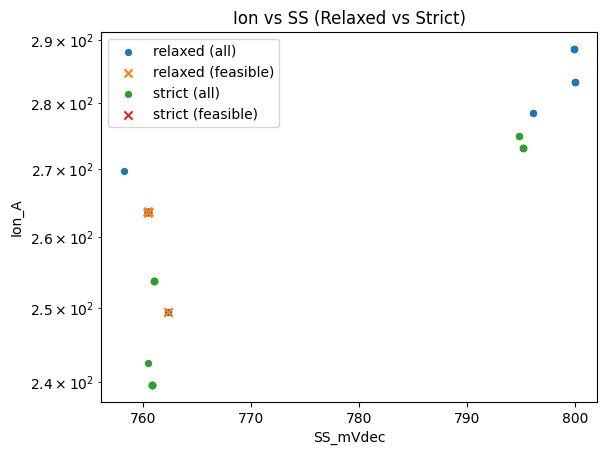

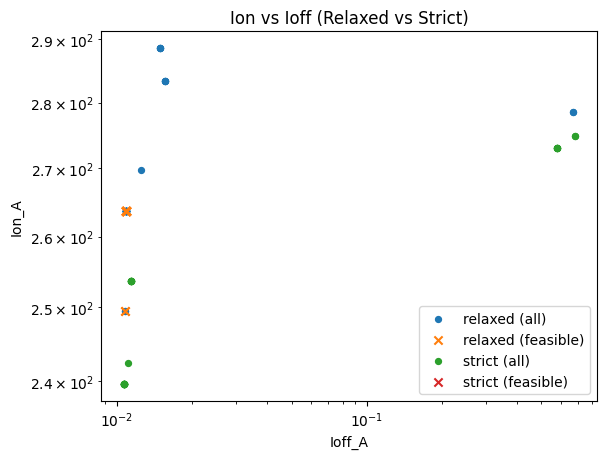

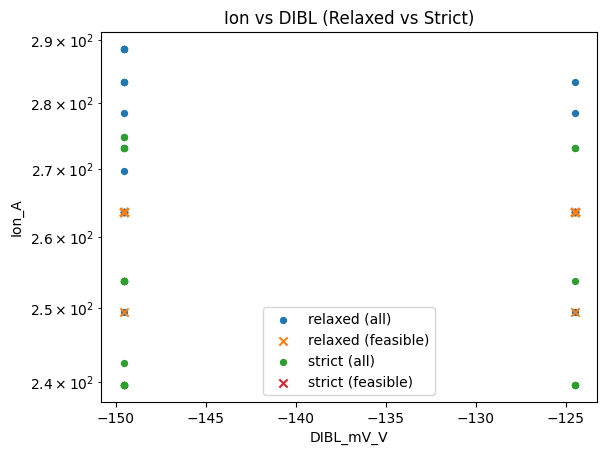

✅ wrote: /content/neighbor_validation_relaxed.csv
✅ wrote: /content/neighbor_validation_strict.csv

=== Neighbor validation summary (surrogate vs measurement) ===


name    MAE_Ion  MAPE_Ion  MAE_Ioff     MAE_SS  MAE_DIBL  median_nn_dist
0  relaxed  12.048351  0.042392  0.800848  14.827293       0.0          4.6737
1   strict  12.962321  0.050668  0.691607  13.737973       0.0          3.4527


Relaxed: Pred vs Meas


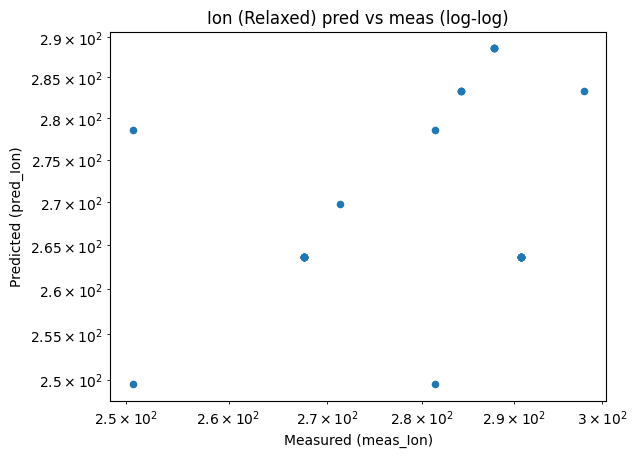

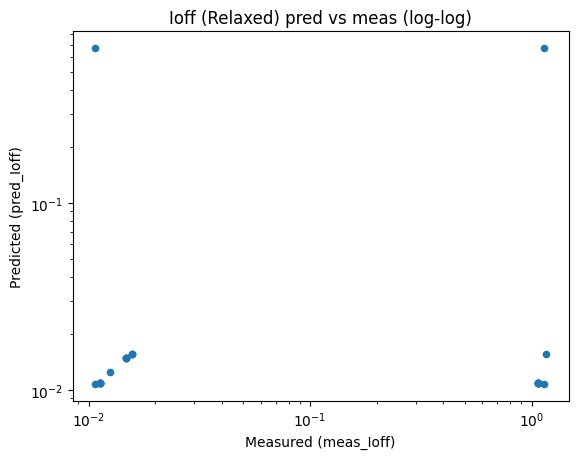

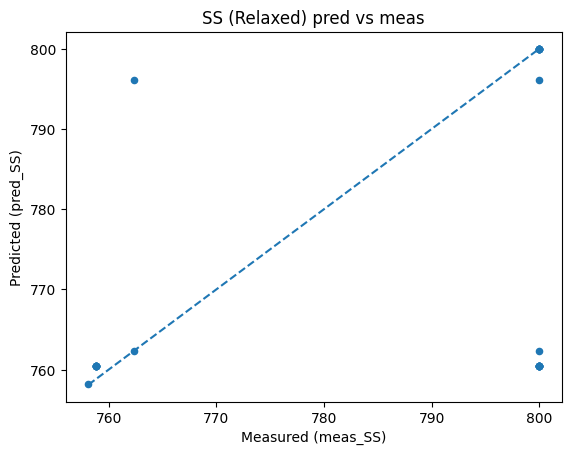

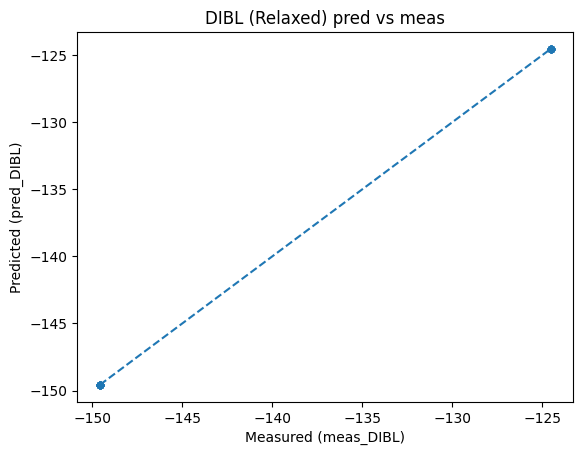


Strict: Pred vs Meas


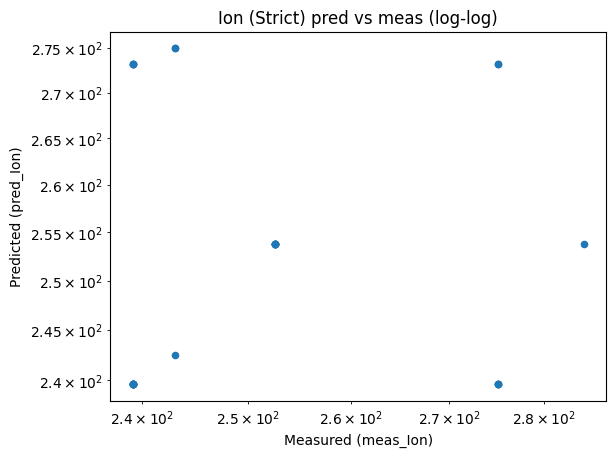

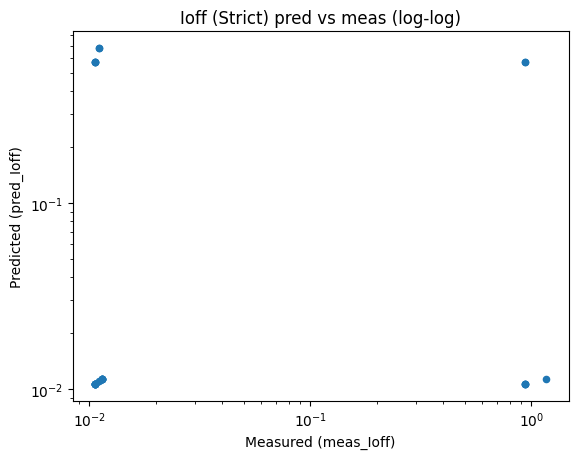

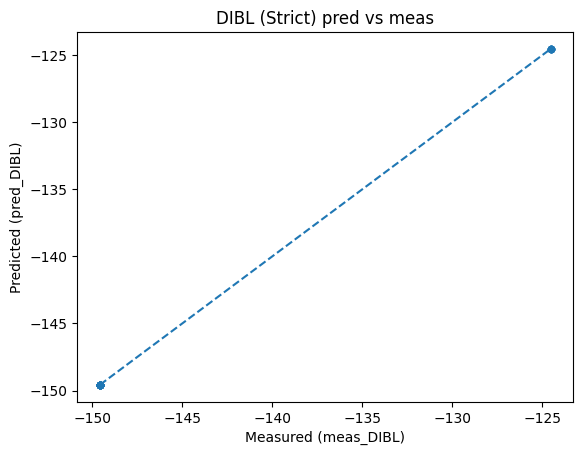


Extra artifacts:
 - /content/llm_reliability_results_relaxed.csv
 - /content/llm_reliability_results_strict.csv
 - /content/neighbor_validation_relaxed.csv
 - /content/neighbor_validation_strict.csv

Done.


In [ ]:
# ==========================
# 10) Two-tier constraints + run LLM twice + compare distributions
#     + Neighbor validation (surrogate vs measurement)
# ==========================

# ---- define two tiers from empirical quantiles ----
def make_constraints(ds, tier="relaxed"):
    # ds must contain: SS_true_mVdec, log_Ioff, DIBL_true_mV_per_V
    if tier == "relaxed":
        ss_q   = 0.35
        ioff_q = 0.35
        dibl_q = 0.70
    elif tier == "strict":
        ss_q   = 0.25
        ioff_q = 0.25
        dibl_q = 0.50
    else:
        raise ValueError("tier must be relaxed or strict")

    SS_MAX_ = float(np.nanpercentile(ds["SS_true_mVdec"].values, ss_q*100))
    IOFF_MAX_ = float(10**np.nanpercentile(ds["log_Ioff"].values, ioff_q*100))
    DIBL_MAX_ = float(np.nanpercentile(np.abs(ds["DIBL_true_mV_per_V"].values), dibl_q*100))
    return {"tier": tier, "SS_MAX": SS_MAX_, "IOFF_MAX": IOFF_MAX_, "DIBL_MAX": DIBL_MAX_}

constraints_relaxed = make_constraints(ds, "relaxed")
constraints_strict  = make_constraints(ds, "strict")

print("Two-tier constraints:")
print(constraints_relaxed)
print(constraints_strict)

# ---- LLM helper: run once given constraints ----
FAMS_ALL = sorted(train_ds["family_id"].unique().tolist())  # full list (only 2 here)

def predict_with_constraints(fam, vg_min, vg_max, vds, C):
    out = predict(fam, vg_min, vg_max, vds)  # uses surrogate + family DIBL
    feasible = (out["SS_mVdec"] <= C["SS_MAX"]) and (out["Ioff_A"] <= C["IOFF_MAX"]) and (abs(out["DIBL_mV_V"]) <= C["DIBL_MAX"])
    out["feasible"] = bool(feasible)
    # recompute utility with same form (but keep your existing utility if you want)
    out["utility"] = (1.2*out["log_Ion"] - 1.0*out["log_Ioff"] - 0.0035*out["SS_mVdec"] - 0.0015*abs(out["DIBL_mV_V"]))
    return out

SYSTEM2 = """Return ONLY JSON with keys:
family_id, Vg_min_V, Vg_max_V, vds_V
Rules:
- family_id must be one of the provided options
- Vg_min_V < Vg_max_V
- stay within bounds
No prose.
"""

def run_llm_search(C, n_rounds=30, temperature=0.3, seed_trials=120):
    # warm start in this tier
    best = None
    for _ in range(seed_trials):
        fam = random.choice(FAMS_ALL)
        vmin = random.uniform(VG_LO, VG_HI-0.5)
        vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
        vds  = random.uniform(VDS_LO, VDS_HI)
        pred0 = predict_with_constraints(fam, vmin, vmax, vds, C)
        cand0 = {"family_id": fam, "Vg_min_V": vmin, "Vg_max_V": vmax, "vds_V": vds}
        if best is None or pred0["utility"] > best[1]["utility"]:
            best = (cand0, pred0)

    feedback = None
    rows = []

    for r in tqdm(range(n_rounds), desc=f"LLM rounds ({C['tier']})"):
        prompt = f"""family_id options (ALL): {FAMS_ALL}
Bounds:
- Vg_min_V, Vg_max_V in [{VG_LO}, {VG_HI}]
- vds_V in [{VDS_LO}, {VDS_HI}]
Constraints ({C['tier']}):
- SS <= {C['SS_MAX']:.2f} mV/dec
- Ioff <= {C['IOFF_MAX']:.3e} A
- |DIBL| <= {C['DIBL_MAX']:.2f} mV/V

Goal: maximize Ion, minimize Ioff, SS, and |DIBL|.
Hard rule: propose a point that differs from seed by at least one of:
|ΔVg_min|>0.05 OR |ΔVg_max|>0.05 OR |Δvds|>0.05 OR family_id changes.

Seed (current best): {json.dumps(best[0])}
"""
        if feedback:
            prompt += f"\nLast evaluation feedback: {json.dumps(feedback)}"

        resp = client.chat.completions.create(
            model=LLM_MODEL,
            messages=[{"role":"system","content":SYSTEM2},
                      {"role":"user","content":prompt}],
            temperature=temperature,
        )

        cand = parse_json(resp.choices[0].message.content)
        pred1 = predict_with_constraints(cand["family_id"], cand["Vg_min_V"], cand["Vg_max_V"], cand["vds_V"], C)

        row = {"tier": C["tier"], "round": r, **cand, **pred1}
        rows.append(row)

        if pred1["utility"] > best[1]["utility"]:
            best = (cand, pred1)

        feedback = {k: pred1[k] for k in ["Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]}

    res = pd.DataFrame(rows)
    best_row = {"tier": C["tier"], **best[0], **best[1]}
    return res, best_row

# ---- run both tiers ----
res_relaxed, best_relaxed = run_llm_search(constraints_relaxed, n_rounds=N_ROUNDS, temperature=TEMPERATURE)
res_strict,  best_strict  = run_llm_search(constraints_strict,  n_rounds=N_ROUNDS, temperature=TEMPERATURE)

print("\nBest (relaxed):", {k: best_relaxed[k] for k in ["tier","family_id","Vg_min_V","Vg_max_V","vds_V","Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]})
print("Best (strict): ", {k: best_strict[k]  for k in ["tier","family_id","Vg_min_V","Vg_max_V","vds_V","Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]})

# ---- save ----
RELAXED_CSV = "/content/llm_reliability_results_relaxed.csv"
STRICT_CSV  = "/content/llm_reliability_results_strict.csv"
res_relaxed.to_csv(RELAXED_CSV, index=False)
res_strict.to_csv(STRICT_CSV, index=False)
print("✅ wrote:", RELAXED_CSV)
print("✅ wrote:", STRICT_CSV)

# ---- compare feasible distributions ----
def summarize_res(res, C):
    n = len(res)
    n_feas = int(res["feasible"].sum())
    frac = n_feas / max(n,1)
    util_best = float(res["utility"].max())
    util_best_feas = float(res.loc[res["feasible"], "utility"].max()) if n_feas>0 else float("nan")
    ion_med_feas = float(np.nanmedian(res.loc[res["feasible"], "Ion_A"])) if n_feas>0 else float("nan")
    ioff_med_feas = float(np.nanmedian(res.loc[res["feasible"], "Ioff_A"])) if n_feas>0 else float("nan")
    ss_med_feas = float(np.nanmedian(res.loc[res["feasible"], "SS_mVdec"])) if n_feas>0 else float("nan")
    dibl_med_feas = float(np.nanmedian(np.abs(res.loc[res["feasible"], "DIBL_mV_V"]))) if n_feas>0 else float("nan")
    return {
        "tier": C["tier"],
        "SS_MAX": C["SS_MAX"],
        "IOFF_MAX": C["IOFF_MAX"],
        "DIBL_MAX": C["DIBL_MAX"],
        "n": n,
        "n_feasible": n_feas,
        "feasible_rate": frac,
        "best_utility_any": util_best,
        "best_utility_feasible": util_best_feas,
        "median_Ion_feasible": ion_med_feas,
        "median_Ioff_feasible": ioff_med_feas,
        "median_SS_feasible": ss_med_feas,
        "median_|DIBL|_feasible": dibl_med_feas,
    }

summary_df = pd.DataFrame([
    summarize_res(res_relaxed, constraints_relaxed),
    summarize_res(res_strict, constraints_strict)
])
print("\n=== Two-tier summary ===")
display(summary_df)

# ---- distribution plots: feasible vs infeasible for both tiers ----
def plot_compare(resA, resB, col, xscale=None, yscale=None, title=""):
    plt.figure()
    plt.scatter(resA[col], resA["Ion_A"], s=18, label=f"{resA['tier'].iloc[0]} (all)")
    plt.scatter(resA.loc[resA["feasible"], col], resA.loc[resA["feasible"], "Ion_A"], s=35, marker="x", label=f"{resA['tier'].iloc[0]} (feasible)")
    plt.scatter(resB[col], resB["Ion_A"], s=18, label=f"{resB['tier'].iloc[0]} (all)")
    plt.scatter(resB.loc[resB["feasible"], col], resB.loc[resB["feasible"], "Ion_A"], s=35, marker="x", label=f"{resB['tier'].iloc[0]} (feasible)")
    if xscale: plt.xscale(xscale)
    if yscale: plt.yscale(yscale)
    plt.xlabel(col)
    plt.ylabel("Ion_A")
    plt.title(title or f"Ion vs {col} (two tiers)")
    plt.legend()
    plt.show()

plot_compare(res_relaxed, res_strict, "SS_mVdec", yscale="log", title="Ion vs SS (Relaxed vs Strict)")
plot_compare(res_relaxed, res_strict, "Ioff_A", xscale="log", yscale="log", title="Ion vs Ioff (Relaxed vs Strict)")
plot_compare(res_relaxed, res_strict, "DIBL_mV_V", yscale="log", title="Ion vs DIBL (Relaxed vs Strict)")

# ==========================
# 11) Neighbor validation: surrogate vs measurement
# ==========================

# Build a "real" table for nearest-neighbor search:
# We'll restrict to rows with finite vds (because our LLM proposes vds)
real_tbl = ds[np.isfinite(ds["vds_V"])].copy()
if len(real_tbl) == 0:
    real_tbl = ds.copy()

# distance weights (tunable)
W_VMIN = 1.0
W_VMAX = 1.0
W_VDS  = 3.0  # emphasize matching Vds
EPS = 1e-12

def nearest_real(row, real_tbl):
    fam = row["family_id"]
    g = real_tbl[real_tbl["family_id"] == fam]
    if len(g) == 0:
        g = real_tbl

    dvmin = (g["Vg_min_V"].values - row["Vg_min_V"])
    dvmax = (g["Vg_max_V"].values - row["Vg_max_V"])
    dvds  = (g["vds_V"].values - row["vds_V"])
    dist = (W_VMIN*dvmin*dvmin + W_VMAX*dvmax*dvmax + W_VDS*dvds*dvds)
    j = int(np.argmin(dist))
    nn = g.iloc[j]
    return nn, float(dist[j])

def validate(res, name=""):
    vals = []
    for _, r in res.iterrows():
        nn, dist = nearest_real(r, real_tbl)

        # "measurement" targets (from extracted real curves)
        meas_Ion  = float(nn["Ion_A"])
        meas_Ioff = float(nn["Ioff_A"])
        meas_SS   = float(nn["SS_true_mVdec"])
        meas_DIBL = float(nn["DIBL_true_mV_per_V"])

        # surrogate predictions (from res row)
        pred_Ion  = float(r["Ion_A"])
        pred_Ioff = float(r["Ioff_A"])
        pred_SS   = float(r["SS_mVdec"])
        pred_DIBL = float(r["DIBL_mV_V"])

        vals.append({
            "tier": r["tier"],
            "round": int(r["round"]),
            "family_id": r["family_id"],
            "Vg_min_V": float(r["Vg_min_V"]),
            "Vg_max_V": float(r["Vg_max_V"]),
            "vds_V": float(r["vds_V"]),
            "feasible": bool(r["feasible"]),
            "utility": float(r["utility"]),
            "nn_curve_key": str(nn.get("curve_key","")),
            "nn_dist": dist,

            "pred_Ion": pred_Ion, "meas_Ion": meas_Ion,
            "pred_Ioff": pred_Ioff, "meas_Ioff": meas_Ioff,
            "pred_SS": pred_SS, "meas_SS": meas_SS,
            "pred_DIBL": pred_DIBL, "meas_DIBL": meas_DIBL,
        })

    vdf = pd.DataFrame(vals)

    # error metrics
    def mae(a,b): return float(np.nanmean(np.abs(np.asarray(a)-np.asarray(b))))
    def mape(a,b):
        a=np.asarray(a); b=np.asarray(b)
        return float(np.nanmean(np.abs(a-b)/np.maximum(np.abs(b), EPS)))

    report = {
        "name": name,
        "MAE_Ion": mae(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAPE_Ion": mape(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAE_Ioff": mae(np.log10(np.maximum(vdf["pred_Ioff"],1e-30)), np.log10(np.maximum(vdf["meas_Ioff"],1e-30))),
        "MAE_SS": mae(vdf["pred_SS"], vdf["meas_SS"]),
        "MAE_DIBL": mae(vdf["pred_DIBL"], vdf["meas_DIBL"]),
        "median_nn_dist": float(np.nanmedian(vdf["nn_dist"])),
    }
    return vdf, report

val_relaxed, rep_relaxed = validate(res_relaxed, name="relaxed")
val_strict,  rep_strict  = validate(res_strict,  name="strict")

VAL_RELAXED_CSV = "/content/neighbor_validation_relaxed.csv"
VAL_STRICT_CSV  = "/content/neighbor_validation_strict.csv"
val_relaxed.to_csv(VAL_RELAXED_CSV, index=False)
val_strict.to_csv(VAL_STRICT_CSV, index=False)
print("✅ wrote:", VAL_RELAXED_CSV)
print("✅ wrote:", VAL_STRICT_CSV)

rep_df = pd.DataFrame([rep_relaxed, rep_strict])
print("\n=== Neighbor validation summary (surrogate vs measurement) ===")
display(rep_df)

# ---- plots: predicted vs measured ----
def pred_vs_meas_plot(vdf, pred_col, meas_col, logx=False, logy=False, title=""):
    plt.figure()
    x = vdf[meas_col].values
    y = vdf[pred_col].values
    plt.scatter(x, y, s=20)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    # y=x guide (in linear space only)
    if (not logx) and (not logy):
        mn = np.nanmin([np.nanmin(x), np.nanmin(y)])
        mx = np.nanmax([np.nanmax(x), np.nanmax(y)])
        plt.plot([mn,mx],[mn,mx], linestyle="--")
    plt.xlabel(f"Measured ({meas_col})")
    plt.ylabel(f"Predicted ({pred_col})")
    plt.title(title or f"{pred_col} vs {meas_col}")
    plt.show()

print("\nRelaxed: Pred vs Meas")
pred_vs_meas_plot(val_relaxed, "pred_Ion","meas_Ion", logx=True, logy=True, title="Ion (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_Ioff","meas_Ioff", logx=True, logy=True, title="Ioff (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_SS","meas_SS", title="SS (Relaxed) pred vs meas")
pred_vs_meas_plot(val_relaxed, "pred_DIBL","meas_DIBL", title="DIBL (Relaxed) pred vs meas")

print("\nStrict: Pred vs Meas")
pred_vs_meas_plot(val_strict, "pred_Ion","meas_Ion", logx=True, logy=True, title="Ion (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_Ioff","meas_Ioff", logx=True, logy=True, title="Ioff (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_SS","meas_SS", title="SS (Strict) pred vs meas")
pred_vs_meas_plot(val_strict, "pred_DIBL","meas_DIBL", title="DIBL (Strict) pred vs meas")

print("\nExtra artifacts:")
print(" -", RELAXED_CSV)
print(" -", STRICT_CSV)
print(" -", VAL_RELAXED_CSV)
print(" -", VAL_STRICT_CSV)
print("\nDone.")


In [ ]:
# =========================================================
# ONE-CELL COLAB: LLM-Guided Reliability Search on MoS2 FET curves
# - Downloads Zenodo record 10.5281/zenodo.14825422
# - Parses CSV curves
# - Extracts per-curve metrics: Ion, Ioff, SS_true, Vth_true
# - Computes true DIBL at family-level
# - Trains leak-free surrogate
# - Two-tier constraints (Relaxed vs Strict) + LLM search w/ feasibility-prioritized retries
# - Neighbor validation (surrogate vs measurement)
# =========================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet wget requests tqdm openai

import os, re, io, json, math, random, zipfile, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# -----------------------------
# 0) Reproducibility
# -----------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)

# -----------------------------
# 1) OpenRouter / OpenAI client
# -----------------------------
# Option A: set directly (NOT recommended to hardcode in public notebooks)
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "")  # put your key in env var
# OPENROUTER_API_KEY = "sk-or-v1-..."  # or paste here

if not OPENROUTER_API_KEY:
    print("⚠️ OPENROUTER_API_KEY is empty. LLM search will fail unless you set it.")

from openai import OpenAI
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY
)

LLM_MODEL = os.getenv("LLM_MODEL", "openai/gpt-4.1")  # example
TEMPERATURE = 0.3
N_ROUNDS = 30

# -----------------------------
# 2) Download Zenodo record
# -----------------------------
ZENODO_REC_ID = "14825422"  # from DOI 10.5281/zenodo.14825422
OUTDIR = "/content/zenodo_data"
os.makedirs(OUTDIR, exist_ok=True)

import requests, wget

def zenodo_download_record(rec_id, outdir):
    api = f"https://zenodo.org/api/records/{rec_id}"
    r = requests.get(api, timeout=60)
    r.raise_for_status()
    meta = r.json()
    print(f"Downloading: 10.5281/zenodo.{rec_id}")
    print("Title:", meta.get("metadata", {}).get("title", ""))
    print("Keywords:", ", ".join(meta.get("metadata", {}).get("keywords", [])[:10]))
    print("Publication date:", meta.get("metadata", {}).get("publication_date", ""))
    print("DOI:", meta.get("metadata", {}).get("doi", ""))
    files = meta.get("files", [])
    paths = []
    for f in files:
        name = f["key"]
        url = f["links"]["self"]
        dst = os.path.join(outdir, name)
        # if exists, skip
        if os.path.exists(dst) and os.path.getsize(dst) > 0:
            print(f"{name} is already downloaded correctly.")
            paths.append(dst)
            continue
        print(f"Downloading file: {name}")
        wget.download(url, dst)
        print()
        paths.append(dst)
    return paths

paths = zenodo_download_record(ZENODO_REC_ID, OUTDIR)

# unzip Figures.zip if present
zip_path = os.path.join(OUTDIR, "Figures.zip")
if os.path.exists(zip_path):
    print("Unzipping:", zip_path)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(OUTDIR)

# list csv files
csv_files = []
for root, _, files in os.walk(OUTDIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, fn))
csv_files = sorted(csv_files)
print("CSV count:", len(csv_files))
for p in csv_files:
    print(" -", p)

# -----------------------------
# 3) Helpers: robust CSV reading
# -----------------------------
def read_csv_robust(path):
    # try common separators
    for sep in [",", "\t", ";"]:
        try:
            df = pd.read_csv(path, sep=sep)
            if df.shape[1] >= 2:
                return df
        except Exception:
            pass
    # fallback
    return pd.read_csv(path)

def normalize_cols(df):
    # lower, strip, replace spaces
    df = df.copy()
    df.columns = [re.sub(r"\s+", "_", str(c).strip().lower()) for c in df.columns]
    return df

def safe_num(series):
    # convert to numeric, coerce non-numeric to NaN
    return pd.to_numeric(series, errors="coerce")

# -----------------------------
# 4) Extract raw curve points
#    Output: curve_points.parquet with columns:
#    curve_key, family_id, figure_id, base_name, vgs, id, vds
# -----------------------------
def infer_family(figure_id, base_name):
    # family_id = "Figure X||<base>" to match your notebook style
    return f"{figure_id}||{base_name}"

def identify_cols(df):
    cols = df.columns
    # prefer typical names
    vg_candidates = [c for c in cols if c in ["vgs", "vg", "v_g", "v_gs", "vgs(v)", "vgs_v", "gate", "vgs/volt"] or "vgs" in c]
    id_candidates = [c for c in cols if c in ["id", "ids", "i_d", "id/w", "id_w", "id/um", "id_um"] or (("id" in c) and ("video" not in c))]
    vds_candidates = [c for c in cols if c in ["vds", "vd", "v_d", "v_ds", "vds_v"] or "vds" in c]

    vg_col = vg_candidates[0] if vg_candidates else None
    # if "vin"/"vout" exist, those are not Id curves; skip those families for transistor metrics
    if any(c in cols for c in ["vin", "vout", "av", "time"]):
        return None, None, None, "non_transistor"

    id_col = id_candidates[0] if id_candidates else None
    vds_col = vds_candidates[0] if vds_candidates else None
    return vg_col, id_col, vds_col, "transistor"

def split_by_vds(df, vds_col):
    # group by unique vds values (rounded)
    vds = safe_num(df[vds_col])
    if vds.isna().all():
        return []
    vv = vds.values
    # round to 2 decimals to merge tiny noise
    v_round = np.round(vv.astype(float), 2)
    df2 = df.copy()
    df2["_vds_round"] = v_round
    groups = []
    for vds_val, g in df2.groupby("_vds_round"):
        groups.append((float(vds_val), g.drop(columns=["_vds_round"])))
    return groups

curve_rows = []
failed = []

for path in csv_files:
    try:
        df = read_csv_robust(path)
        df = normalize_cols(df)

        # infer figure id
        m = re.search(r"(Figure\s*\d+)", path, flags=re.IGNORECASE)
        figure_id = m.group(1).replace("figure", "Figure").replace("  ", " ").strip() if m else "Figure ?"
        base_name = os.path.splitext(os.path.basename(path))[0]

        vg_col, id_col, vds_col, kind = identify_cols(df)
        if kind != "transistor" or (vg_col is None) or (id_col is None):
            # skip non-transistor csv
            continue

        vgs = safe_num(df[vg_col])
        ids = safe_num(df[id_col])

        # if has vds, split into multiple curves by vds
        if vds_col is not None:
            groups = split_by_vds(df, vds_col)
            if len(groups) > 1:
                for vds_val, g in groups:
                    vgs_g = safe_num(g[vg_col])
                    ids_g = safe_num(g[id_col])
                    mask = np.isfinite(vgs_g.values) & np.isfinite(ids_g.values)
                    if mask.sum() < 20:
                        continue
                    fam = infer_family(figure_id, base_name)
                    curve_key = f"{figure_id}::{base_name}::vds={vds_val:.2f}"
                    for x, y in zip(vgs_g.values[mask], ids_g.values[mask]):
                        curve_rows.append({
                            "curve_key": curve_key,
                            "figure_id": figure_id,
                            "base_name": base_name,
                            "family_id": fam,
                            "vgs": float(x),
                            "id": float(y),
                            "vds_V": float(vds_val),
                            "source_file": path
                        })
                continue

        # otherwise, single curve
        mask = np.isfinite(vgs.values) & np.isfinite(ids.values)
        if mask.sum() < 20:
            continue
        fam = infer_family(figure_id, base_name)
        curve_key = f"{figure_id}::{base_name}::single"
        for x, y in zip(vgs.values[mask], ids.values[mask]):
            curve_rows.append({
                "curve_key": curve_key,
                "figure_id": figure_id,
                "base_name": base_name,
                "family_id": fam,
                "vgs": float(x),
                "id": float(y),
                "vds_V": float("nan") if vds_col is None else float(np.nanmedian(safe_num(df[vds_col]))),
                "source_file": path
            })

    except Exception as e:
        failed.append((path, str(e)))

curve_points = pd.DataFrame(curve_rows)
if len(curve_points) == 0:
    raise RuntimeError("No transistor curves were extracted. Check CSV parsing rules.")

# sort points inside each curve by Vgs
curve_points = curve_points.sort_values(["curve_key","vgs"]).reset_index(drop=True)

CURVE_POINTS_PARQ = "/content/curve_points.parquet"
curve_points.to_parquet(CURVE_POINTS_PARQ, index=False)
print(f"✅ Saved raw points: {CURVE_POINTS_PARQ} rows={len(curve_points):,}")

# -----------------------------
# 5) Compute per-curve metrics: Ion, Ioff, SS_true, Vth_true
# -----------------------------
def compute_ss_true(vgs, ids, window_pts=60):
    """
    Estimate SS from best linear fit region of log10(|Id|) vs Vg.
    Return mV/dec. If insufficient dynamic range, returns NaN.
    """
    vgs = np.asarray(vgs, float)
    ids = np.asarray(ids, float)
    # avoid sign; use magnitude
    y = np.log10(np.maximum(np.abs(ids), 1e-30))
    # need variation
    if np.nanmax(y) - np.nanmin(y) < 1.0:
        return np.nan
    n = len(vgs)
    if n < window_pts:
        window_pts = max(20, n//3)
    best = None
    for i in range(0, n-window_pts+1):
        xs = vgs[i:i+window_pts]
        ys = y[i:i+window_pts]
        if np.any(~np.isfinite(xs)) or np.any(~np.isfinite(ys)):
            continue
        # linear fit
        A = np.vstack([xs, np.ones_like(xs)]).T
        slope, intercept = np.linalg.lstsq(A, ys, rcond=None)[0]
        # slope = d(log10Id)/dVg (dec/V)
        if slope <= 0:
            continue
        # choose max slope region (steepest subthreshold)
        if best is None or slope > best[0]:
            best = (slope, intercept)
    if best is None:
        return np.nan
    slope = best[0]  # dec/V
    SS_V_per_dec = 1.0/slope
    SS_mVdec = SS_V_per_dec * 1e3
    return float(SS_mVdec)

def compute_vth_true(vgs, ids, Id_ref=None):
    """
    Define 'true' Vth as the gate voltage where |Id| crosses Id_ref.
    If Id_ref not given, use geometric mean between Ion and Ioff.
    Linear interpolation on Vgs vs log10(|Id|).
    """
    vgs = np.asarray(vgs, float)
    ids = np.asarray(ids, float)
    y = np.log10(np.maximum(np.abs(ids), 1e-30))
    Ion = float(np.nanmax(np.abs(ids)))
    Ioff = float(np.nanmin(np.abs(ids)))
    if Id_ref is None:
        Id_ref = math.sqrt(max(Ion,1e-30)*max(Ioff,1e-30))
    yref = math.log10(max(Id_ref, 1e-30))
    # find crossing
    # locate indices where y - yref changes sign
    diff = y - yref
    idx = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]
    if len(idx) == 0:
        # fallback: pick closest point
        j = int(np.argmin(np.abs(diff)))
        return float(vgs[j]), float(Id_ref)
    i = int(idx[0])
    x0, x1 = vgs[i], vgs[i+1]
    y0, y1 = y[i], y[i+1]
    if y1 == y0:
        return float(x0), float(Id_ref)
    t = (yref - y0) / (y1 - y0)
    vth = x0 + t*(x1-x0)
    return float(vth), float(Id_ref)

metrics = []
for curve_key, g in curve_points.groupby("curve_key"):
    g = g.sort_values("vgs")
    vgs = g["vgs"].values
    ids = g["id"].values
    Ion = float(np.nanmax(np.abs(ids)))
    Ioff = float(np.nanmin(np.abs(ids)))
    ss = compute_ss_true(vgs, ids)
    vth, Id_ref = compute_vth_true(vgs, ids, Id_ref=None)
    metrics.append({
        "curve_key": curve_key,
        "figure_id": g["figure_id"].iloc[0],
        "base_name": g["base_name"].iloc[0],
        "source_file": g["source_file"].iloc[0],
        "family_id": g["family_id"].iloc[0],
        "vds_V": float(np.nanmedian(g["vds_V"].values)) if np.isfinite(g["vds_V"].values).any() else float("nan"),
        "Vg_min_V": float(np.nanmin(vgs)),
        "Vg_max_V": float(np.nanmax(vgs)),
        "Vg_span_V": float(np.nanmax(vgs)-np.nanmin(vgs)),
        "n_points": int(len(g)),
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "Id_ref_A": float(Id_ref),
        "Vth_true_V": float(vth),
        "SS_true_mVdec": float(ss)
    })

curve_metrics = pd.DataFrame(metrics)
CURVE_METRICS_CSV = "/content/curve_metrics_trueVth.csv"
curve_metrics.to_csv(CURVE_METRICS_CSV, index=False)
print(f"✅ Saved per-curve metrics: {CURVE_METRICS_CSV} curves={len(curve_metrics)}")

# add logs (avoid -inf)
curve_metrics["log_Ion"]  = np.log10(np.maximum(curve_metrics["Ion_A"].values, 1e-30))
curve_metrics["log_Ioff"] = np.log10(np.maximum(curve_metrics["Ioff_A"].values, 1e-30))

# -----------------------------
# 6) Compute true DIBL per family (Figure 2 d set & Figure 3 b typically)
#    DIBL_true_mV_per_V = - dVth/dVds * 1e3 (mV/V)
# -----------------------------
dibl_rows = []
for (figure_id, base_name), g in curve_metrics.groupby(["figure_id","base_name"]):
    # need finite vds + vth
    gg = g[np.isfinite(g["vds_V"]) & np.isfinite(g["Vth_true_V"])].copy()
    if len(gg) < 6:
        continue
    # linear regression: Vth = a*Vds + b
    x = gg["vds_V"].values.astype(float)
    y = gg["Vth_true_V"].values.astype(float)
    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    DIBL = -a * 1e3  # mV/V (magnitude positive if Vth decreases with Vds)
    dibl_rows.append({
        "figure_id": figure_id,
        "base_name": base_name,
        "n_curves": int(len(gg)),
        "vds_min": float(np.nanmin(x)),
        "vds_max": float(np.nanmax(x)),
        "Vth_slope_V_per_V": float(a),
        "DIBL_true_mV_per_V": float(DIBL)
    })

dibl_true = pd.DataFrame(dibl_rows)
DIBL_TRUE_CSV = "/content/dibl_true.csv"
dibl_true.to_csv(DIBL_TRUE_CSV, index=False)
print(f"✅ Saved true DIBL: {DIBL_TRUE_CSV} rows={len(dibl_true)}")
display(dibl_true.head())

# join DIBL onto curves by family_id (figure||base)
# note: our family_id = "Figure X||base_name"
dibl_true["family_id"] = dibl_true.apply(lambda r: f"{r['figure_id']}||{r['base_name']}", axis=1)
curve_metrics = curve_metrics.merge(
    dibl_true[["family_id","DIBL_true_mV_per_V"]],
    on="family_id", how="left"
)

# if some families have no DIBL, fill with nearest known (or 0)
# Here: fallback to median abs DIBL of known families
if curve_metrics["DIBL_true_mV_per_V"].isna().any():
    fill_val = float(np.nanmedian(curve_metrics["DIBL_true_mV_per_V"].values)) if np.isfinite(curve_metrics["DIBL_true_mV_per_V"]).any() else 0.0
    curve_metrics["DIBL_true_mV_per_V"] = curve_metrics["DIBL_true_mV_per_V"].fillna(fill_val)

# unified dataset to save
RELIABILITY_DATASET_CSV = "/content/reliability_dataset.csv"
curve_metrics.to_csv(RELIABILITY_DATASET_CSV, index=False)
print(f"✅ Saved unified dataset: {RELIABILITY_DATASET_CSV} rows={len(curve_metrics)}")

ds = curve_metrics.copy()

# -----------------------------
# 7) Train leak-free surrogate (GroupKFold by family_id)
#    Features: Vg_min, Vg_max, vds
#    Targets: log_Ion, log_Ioff, SS_true_mVdec
# -----------------------------
train_ds = ds[np.isfinite(ds["vds_V"])].copy()
if len(train_ds) < 40:
    # if most curves lack vds, allow training without vds (but LLM search uses vds)
    train_ds = ds.copy()

FEATURES = ["Vg_min_V","Vg_max_V","vds_V"]
for c in FEATURES:
    if c not in train_ds.columns:
        train_ds[c] = np.nan

train_ds = train_ds.dropna(subset=["Vg_min_V","Vg_max_V","vds_V","log_Ion","log_Ioff","SS_true_mVdec"]).copy()
if len(train_ds) < 20:
    raise RuntimeError("Too few rows to train surrogate. Need more curves with finite vds + SS.")

X = train_ds[FEATURES].values.astype(float)
y1 = train_ds["log_Ion"].values.astype(float)
y2 = train_ds["log_Ioff"].values.astype(float)
y3 = train_ds["SS_true_mVdec"].values.astype(float)
groups = train_ds["family_id"].values

def fit_rf():
    return RandomForestRegressor(
        n_estimators=400,
        random_state=SEED,
        min_samples_leaf=2,
        n_jobs=-1
    )

# leak-free evaluation
gkf = GroupKFold(n_splits=min(5, len(np.unique(groups))))
r2s = {"log_Ion": [], "log_Ioff": [], "SS_true_mVdec": []}

for tr, te in gkf.split(X, y1, groups=groups):
    m1, m2, m3 = fit_rf(), fit_rf(), fit_rf()
    m1.fit(X[tr], y1[tr])
    m2.fit(X[tr], y2[tr])
    m3.fit(X[tr], y3[tr])
    p1 = m1.predict(X[te]); p2 = m2.predict(X[te]); p3 = m3.predict(X[te])
    r2s["log_Ion"].append(r2_score(y1[te], p1))
    r2s["log_Ioff"].append(r2_score(y2[te], p2))
    r2s["SS_true_mVdec"].append(r2_score(y3[te], p3))

surrogate_r2 = {k: float(np.mean(v)) for k,v in r2s.items()}
R2_JSON = "/content/surrogate_r2.json"
with open(R2_JSON, "w") as f:
    json.dump(surrogate_r2, f, indent=2)
print("✅ Surrogate R^2 (leak-free):", surrogate_r2)
print("✅ Saved R^2:", R2_JSON)

# fit final models on all train_ds
m_logIon = fit_rf().fit(X, y1)
m_logIoff = fit_rf().fit(X, y2)
m_SS = fit_rf().fit(X, y3)

# -----------------------------
# 8) Prediction function (surrogate + family DIBL)
# -----------------------------
# Bounds from data
VG_LO = float(np.nanmin(ds["Vg_min_V"].values))
VG_HI = float(np.nanmax(ds["Vg_max_V"].values))
VDS_LO = float(np.nanmin(train_ds["vds_V"].values))
VDS_HI = float(np.nanmax(train_ds["vds_V"].values))

FAMS_ALL = sorted(train_ds["family_id"].unique().tolist())

# map family->DIBL
fam2dibl = dict(ds.groupby("family_id")["DIBL_true_mV_per_V"].median())

def predict(family_id, vg_min, vg_max, vds):
    x = np.array([[vg_min, vg_max, vds]], dtype=float)
    logIon = float(m_logIon.predict(x)[0])
    logIoff = float(m_logIoff.predict(x)[0])
    SS = float(m_SS.predict(x)[0])
    Ion = float(10**logIon)
    Ioff = float(10**logIoff)
    dibl = float(fam2dibl.get(family_id, float(np.nanmedian(list(fam2dibl.values())) if fam2dibl else 0.0)))
    return {
        "log_Ion": logIon, "log_Ioff": logIoff,
        "Ion_A": Ion, "Ioff_A": Ioff,
        "SS_mVdec": SS,
        "DIBL_mV_V": dibl
    }

# -----------------------------
# 9) Two-tier constraints (FIXED DIBL from dibl_true.csv)
# -----------------------------
def make_constraints(ds, dibl_df, tier="relaxed"):
    if tier == "relaxed":
        ss_q, ioff_q, dibl_q = 0.35, 0.35, 0.80
    elif tier == "strict":
        ss_q, ioff_q, dibl_q = 0.25, 0.25, 0.50
    else:
        raise ValueError("tier must be relaxed or strict")

    SS_MAX_   = float(np.nanpercentile(ds["SS_true_mVdec"].values, ss_q*100))
    IOFF_MAX_ = float(10**np.nanpercentile(ds["log_Ioff"].values, ioff_q*100))

    dibl_abs = np.abs(dibl_df["DIBL_true_mV_per_V"].values)
    DIBL_MAX_ = float(np.nanpercentile(dibl_abs, dibl_q*100))
    return {"tier": tier, "SS_MAX": SS_MAX_, "IOFF_MAX": IOFF_MAX_, "DIBL_MAX": DIBL_MAX_}

constraints_relaxed = make_constraints(ds, dibl_true, "relaxed")
constraints_strict  = make_constraints(ds, dibl_true, "strict")

print("Two-tier constraints:")
print(constraints_relaxed)
print(constraints_strict)

# -----------------------------
# 10) LLM search (feasibility-prioritized retries)
# -----------------------------
def predict_with_constraints(fam, vg_min, vg_max, vds, C):
    out = predict(fam, vg_min, vg_max, vds)
    feasible = (out["SS_mVdec"] <= C["SS_MAX"]) and (out["Ioff_A"] <= C["IOFF_MAX"]) and (abs(out["DIBL_mV_V"]) <= C["DIBL_MAX"])
    out["feasible"] = bool(feasible)
    out["utility"] = float(1.2*out["log_Ion"] - 1.0*out["log_Ioff"] - 0.0035*out["SS_mVdec"] - 0.0015*abs(out["DIBL_mV_V"]))
    return out

SYSTEM2 = """Return ONLY JSON with keys:
family_id, Vg_min_V, Vg_max_V, vds_V
Rules:
- family_id must be one of the provided options
- Vg_min_V < Vg_max_V
- stay within bounds
No prose.
"""

def parse_json(s):
    # extract first JSON object from text
    s = s.strip()
    m = re.search(r"\{.*\}", s, flags=re.DOTALL)
    if m:
        s = m.group(0)
    return json.loads(s)

def run_llm_search(C, n_rounds=30, temperature=0.3, seed_trials=120):
    # warm start
    best = None
    for _ in range(seed_trials):
        fam = random.choice(FAMS_ALL)
        vmin = random.uniform(VG_LO, VG_HI-0.5)
        vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
        vds  = random.uniform(VDS_LO, VDS_HI)
        pred0 = predict_with_constraints(fam, vmin, vmax, vds, C)
        cand0 = {"family_id": fam, "Vg_min_V": float(vmin), "Vg_max_V": float(vmax), "vds_V": float(vds)}
        if best is None or pred0["utility"] > best[1]["utility"]:
            best = (cand0, pred0)

    feedback = None
    rows = []

    MAX_RETRY = 4
    INFEAS_PENALTY = 2.0

    for r in tqdm(range(n_rounds), desc=f"LLM rounds ({C['tier']})"):
        prompt = f"""family_id options (ALL): {FAMS_ALL}
Bounds:
- Vg_min_V, Vg_max_V in [{VG_LO:.3f}, {VG_HI:.3f}]
- vds_V in [{VDS_LO:.3f}, {VDS_HI:.3f}]

Constraints ({C['tier']}):
- SS <= {C['SS_MAX']:.2f} mV/dec
- Ioff <= {C['IOFF_MAX']:.3e} A
- |DIBL| <= {C['DIBL_MAX']:.2f} mV/V

Optimization:
- Maximize Ion
- Minimize Ioff, SS, |DIBL|
Hard feasibility: must satisfy ALL constraints if possible.

Heuristics to reduce Ioff (important for strict):
- Prefer smaller vds_V
- Prefer smaller Vg_max_V
- Prefer narrower Vg window (Vg_max_V - Vg_min_V)
- If stuck, switch family_id.

Hard rule: propose a point that differs from seed by at least one of:
|ΔVg_min|>0.05 OR |ΔVg_max|>0.05 OR |Δvds|>0.05 OR family_id changes.

Seed (current best): {json.dumps(best[0])}
"""
        if feedback:
            prompt += f"\nLast evaluation feedback: {json.dumps(feedback)}"

        cand = None
        pred1 = None

        for attempt in range(MAX_RETRY):
            resp = client.chat.completions.create(
                model=LLM_MODEL,
                messages=[{"role":"system","content":SYSTEM2},
                          {"role":"user","content":prompt}],
                temperature=temperature,
            )
            cand_try = parse_json(resp.choices[0].message.content)
            pred_try = predict_with_constraints(
                cand_try["family_id"],
                float(cand_try["Vg_min_V"]),
                float(cand_try["Vg_max_V"]),
                float(cand_try["vds_V"]),
                C
            )
            cand, pred1 = cand_try, pred_try
            if pred1["feasible"]:
                break
            else:
                prompt += f"\nAttempt {attempt+1} infeasible. Need LOWER Ioff. Try smaller vds_V and/or smaller Vg_max_V. Current: {json.dumps({k: pred1[k] for k in ['Ion_A','Ioff_A','SS_mVdec','DIBL_mV_V','feasible']})}"

        if pred1 is not None and (not pred1["feasible"]):
            pred1["utility"] = float(pred1["utility"] - INFEAS_PENALTY)

        row = {"tier": C["tier"], "round": int(r),
               "family_id": cand["family_id"],
               "Vg_min_V": float(cand["Vg_min_V"]),
               "Vg_max_V": float(cand["Vg_max_V"]),
               "vds_V": float(cand["vds_V"]),
               **pred1}
        rows.append(row)

        if pred1["utility"] > best[1]["utility"]:
            best = (row, pred1)

        feedback = {k: row[k] for k in ["Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]}

    res = pd.DataFrame(rows)
    best_row = {"tier": C["tier"], **best[0]}
    return res, best_row

# Run both tiers (LLM required)
res_relaxed, best_relaxed = run_llm_search(constraints_relaxed, n_rounds=N_ROUNDS, temperature=TEMPERATURE)
res_strict,  best_strict  = run_llm_search(constraints_strict,  n_rounds=N_ROUNDS, temperature=TEMPERATURE)

print("\nBest (relaxed):", {k: best_relaxed[k] for k in ["tier","family_id","Vg_min_V","Vg_max_V","vds_V","Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]})
print("Best (strict): ", {k: best_strict[k]  for k in ["tier","family_id","Vg_min_V","Vg_max_V","vds_V","Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]})

RELAXED_CSV = "/content/llm_reliability_results_relaxed.csv"
STRICT_CSV  = "/content/llm_reliability_results_strict.csv"
res_relaxed.to_csv(RELAXED_CSV, index=False)
res_strict.to_csv(STRICT_CSV, index=False)
print("✅ wrote:", RELAXED_CSV)
print("✅ wrote:", STRICT_CSV)

# summarize feasible distributions
def summarize_res(res, C):
    n = len(res)
    n_feas = int(res["feasible"].sum())
    frac = n_feas / max(n,1)
    util_best = float(res["utility"].max())
    util_best_feas = float(res.loc[res["feasible"], "utility"].max()) if n_feas>0 else float("nan")
    ion_med_feas = float(np.nanmedian(res.loc[res["feasible"], "Ion_A"])) if n_feas>0 else float("nan")
    ioff_med_feas = float(np.nanmedian(res.loc[res["feasible"], "Ioff_A"])) if n_feas>0 else float("nan")
    ss_med_feas = float(np.nanmedian(res.loc[res["feasible"], "SS_mVdec"])) if n_feas>0 else float("nan")
    dibl_med_feas = float(np.nanmedian(np.abs(res.loc[res["feasible"], "DIBL_mV_V"]))) if n_feas>0 else float("nan")
    return {
        "tier": C["tier"],
        "SS_MAX": C["SS_MAX"],
        "IOFF_MAX": C["IOFF_MAX"],
        "DIBL_MAX": C["DIBL_MAX"],
        "n": n,
        "n_feasible": n_feas,
        "feasible_rate": frac,
        "best_utility_any": util_best,
        "best_utility_feasible": util_best_feas,
        "median_Ion_feasible": ion_med_feas,
        "median_Ioff_feasible": ioff_med_feas,
        "median_SS_feasible": ss_med_feas,
        "median_|DIBL|_feasible": dibl_med_feas,
    }

summary_df = pd.DataFrame([
    summarize_res(res_relaxed, constraints_relaxed),
    summarize_res(res_strict, constraints_strict),
])
print("\n=== Two-tier summary ===")
display(summary_df)

# distribution plots
def plot_compare(resA, resB, xcol, xscale=None, title=""):
    plt.figure()
    plt.scatter(resA[xcol], resA["Ion_A"], s=18, label=f"{resA['tier'].iloc[0]} (all)")
    plt.scatter(resA.loc[resA["feasible"], xcol], resA.loc[resA["feasible"], "Ion_A"], s=35, marker="x", label=f"{resA['tier'].iloc[0]} (feasible)")
    plt.scatter(resB[xcol], resB["Ion_A"], s=18, label=f"{resB['tier'].iloc[0]} (all)")
    plt.scatter(resB.loc[resB["feasible"], xcol], resB.loc[resB["feasible"], "Ion_A"], s=35, marker="x", label=f"{resB['tier'].iloc[0]} (feasible)")
    if xscale: plt.xscale(xscale)
    plt.xlabel(xcol)
    plt.ylabel("Ion_A")
    plt.title(title or f"Ion vs {xcol} (two tiers)")
    plt.legend()
    plt.show()

# Ion vs SS (linear)
plot_compare(res_relaxed, res_strict, "SS_mVdec", title="Ion vs SS (Relaxed vs Strict)")
# Ion vs Ioff (log x)
plot_compare(res_relaxed, res_strict, "Ioff_A", xscale="log", title="Ion vs Ioff (Relaxed vs Strict)")
# Ion vs |DIBL| (use abs)
res_relaxed["abs_DIBL_mV_V"] = np.abs(res_relaxed["DIBL_mV_V"])
res_strict["abs_DIBL_mV_V"]  = np.abs(res_strict["DIBL_mV_V"])
plot_compare(res_relaxed, res_strict, "abs_DIBL_mV_V", xscale="log", title="Ion vs |DIBL| (Relaxed vs Strict)")

# -----------------------------
# 11) Neighbor validation (surrogate vs measurement)
# -----------------------------
real_tbl = ds[np.isfinite(ds["vds_V"])].copy()
if len(real_tbl) == 0:
    real_tbl = ds.copy()

W_VMIN, W_VMAX, W_VDS = 1.0, 1.0, 3.0
EPS = 1e-12

def nearest_real(row, real_tbl):
    fam = row["family_id"]
    g = real_tbl[real_tbl["family_id"] == fam]
    if len(g) == 0:
        g = real_tbl
    dvmin = (g["Vg_min_V"].values - row["Vg_min_V"])
    dvmax = (g["Vg_max_V"].values - row["Vg_max_V"])
    dvds  = (g["vds_V"].values - row["vds_V"])
    dist = (W_VMIN*dvmin*dvmin + W_VMAX*dvmax*dvmax + W_VDS*dvds*dvds)
    j = int(np.argmin(dist))
    return g.iloc[j], float(dist[j])

def validate(res, name=""):
    vals = []
    for _, r in res.iterrows():
        nn, dist = nearest_real(r, real_tbl)

        vals.append({
            "tier": r["tier"],
            "round": int(r["round"]),
            "family_id": r["family_id"],
            "Vg_min_V": float(r["Vg_min_V"]),
            "Vg_max_V": float(r["Vg_max_V"]),
            "vds_V": float(r["vds_V"]),
            "feasible": bool(r["feasible"]),
            "utility": float(r["utility"]),
            "nn_curve_key": str(nn.get("curve_key","")),
            "nn_dist": float(dist),

            "pred_Ion": float(r["Ion_A"]),  "meas_Ion":  float(nn["Ion_A"]),
            "pred_Ioff": float(r["Ioff_A"]), "meas_Ioff": float(nn["Ioff_A"]),
            "pred_SS": float(r["SS_mVdec"]),  "meas_SS":   float(nn["SS_true_mVdec"]),
            "pred_DIBL": float(r["DIBL_mV_V"]), "meas_DIBL": float(nn["DIBL_true_mV_per_V"]),
        })
    vdf = pd.DataFrame(vals)

    def mae(a,b):
        a=np.asarray(a); b=np.asarray(b)
        return float(np.nanmean(np.abs(a-b)))
    def mape(a,b):
        a=np.asarray(a); b=np.asarray(b)
        return float(np.nanmean(np.abs(a-b)/np.maximum(np.abs(b), EPS)))

    report = {
        "name": name,
        "MAE_Ion": mae(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAPE_Ion": mape(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAE_Ioff(log10)": mae(np.log10(np.maximum(vdf["pred_Ioff"],1e-30)), np.log10(np.maximum(vdf["meas_Ioff"],1e-30))),
        "MAE_SS": mae(vdf["pred_SS"], vdf["meas_SS"]),
        "MAE_DIBL": mae(vdf["pred_DIBL"], vdf["meas_DIBL"]),
        "median_nn_dist": float(np.nanmedian(vdf["nn_dist"])),
    }
    return vdf, report

val_relaxed, rep_relaxed = validate(res_relaxed, name="relaxed")
val_strict,  rep_strict  = validate(res_strict,  name="strict")

VAL_RELAXED_CSV = "/content/neighbor_validation_relaxed.csv"
VAL_STRICT_CSV  = "/content/neighbor_validation_strict.csv"
val_relaxed.to_csv(VAL_RELAXED_CSV, index=False)
val_strict.to_csv(VAL_STRICT_CSV, index=False)
print("✅ wrote:", VAL_RELAXED_CSV)
print("✅ wrote:", VAL_STRICT_CSV)

rep_df = pd.DataFrame([rep_relaxed, rep_strict])
print("\n=== Neighbor validation summary (surrogate vs measurement) ===")
display(rep_df)

def pred_vs_meas_plot(vdf, pred_col, meas_col, logxy=False, title=""):
    plt.figure()
    x = vdf[meas_col].values
    y = vdf[pred_col].values
    plt.scatter(x, y, s=20)
    if logxy:
        plt.xscale("log")
        plt.yscale("log")
    else:
        mn = np.nanmin([np.nanmin(x), np.nanmin(y)])
        mx = np.nanmax([np.nanmax(x), np.nanmax(y)])
        plt.plot([mn,mx],[mn,mx], linestyle="--")
    plt.xlabel(f"Measured ({meas_col})")
    plt.ylabel(f"Predicted ({pred_col})")
    plt.title(title or f"{pred_col} vs {meas_col}")
    plt.show()

print("\nRelaxed: Pred vs Meas")
pred_vs_meas_plot(val_relaxed, "pred_Ion","meas_Ion", logxy=True, title="Ion (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_Ioff","meas_Ioff", logxy=True, title="Ioff (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_SS","meas_SS", logxy=False, title="SS (Relaxed) pred vs meas")
pred_vs_meas_plot(val_relaxed, "pred_DIBL","meas_DIBL", logxy=False, title="DIBL (Relaxed) pred vs meas")

print("\nStrict: Pred vs Meas")
pred_vs_meas_plot(val_strict, "pred_Ion","meas_Ion", logxy=True, title="Ion (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_Ioff","meas_Ioff", logxy=True, title="Ioff (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_SS","meas_SS", logxy=False, title="SS (Strict) pred vs meas")
pred_vs_meas_plot(val_strict, "pred_DIBL","meas_DIBL", logxy=False, title="DIBL (Strict) pred vs meas")

print("\nAll key artifacts:")
print(" -", CURVE_POINTS_PARQ)
print(" -", CURVE_METRICS_CSV)
print(" -", DIBL_TRUE_CSV)
print(" -", RELIABILITY_DATASET_CSV)
print(" -", R2_JSON)
print(" -", RELAXED_CSV)
print(" -", STRICT_CSV)
print(" -", VAL_RELAXED_CSV)
print(" -", VAL_STRICT_CSV)
print("\nDone.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.6 MB/s eta 0:00:00
Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
Keywords: Field-effect transistor, Logic gates, MoS2
Publication date: 2025-02-06
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv
✅ Saved raw points: /content/curve_points.parquet rows=24,383
✅ Saved per-curve metrics: /content/curve_metrics_trueVth.csv curv

figure_id       base_name  n_curves  vds_min  vds_max  Vth_slope_V_per_V  \
0  Figure 2  Figure 2 d set       151      0.0      1.5           0.170154   
1  Figure 3      Figure 3 b       201      0.0      2.0           0.181447   

   DIBL_true_mV_per_V  
0         -170.154482  
1         -181.446736

✅ Saved unified dataset: /content/reliability_dataset.csv rows=355
✅ Surrogate R^2 (leak-free): {'log_Ion': 0.94714925912849, 'log_Ioff': -10.168296266894089, 'SS_true_mVdec': -69.0610523548907}
✅ Saved R^2: /content/surrogate_r2.json
Two-tier constraints:
{'tier': 'relaxed', 'SS_MAX': 704.6134665273488, 'IOFF_MAX': 0.019154811418027835, 'DIBL_MAX': 179.18828523897304}
{'tier': 'strict', 'SS_MAX': 541.7826184951829, 'IOFF_MAX': 0.010801222250424994, 'DIBL_MAX': 175.8006090795082}


LLM rounds (strict): 100%|██████████| 30/30 [02:47<00:00,  5.57s/it]


Best (relaxed): {'tier': 'relaxed', 'family_id': 'Figure 2||Figure 2 d set', 'Vg_min_V': -1.36, 'Vg_max_V': -0.89, 'vds_V': 0.82, 'Ion_A': 256.61864703485094, 'Ioff_A': 0.010452074246584222, 'SS_mVdec': 542.231737604449, 'DIBL_mV_V': -170.1544821470668, 'utility': 2.7189005621849964, 'feasible': True}


KeyError: 'Ion_A'

Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
Keywords: Field-effect transistor, Logic gates, MoS2
Publication date: 2025-02-06
DOI: 10.5281/zenodo.14825422
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv
✅ Saved raw points: /content/curve_points.parquet rows=23,599
✅ Saved per-curve metrics: /content/curve_metrics_trueVth.csv curves=805
✅ Saved true DIBL: /content/dibl_true.csv rows=2
figure_id      base_name  n_curves  vds_min  vds_max  Vth_slope_V_per_V  DIBL_true_mV_per_V
 Figure 2 Figure 2

LLM rounds (strict): 100%|██████████| 30/30 [02:48<00:00,  5.62s/it]


Best (relaxed): {'tier': 'relaxed', 'family_id': 'Figure 3||Figure 3 b', 'Vg_min_V': -0.9961983216216909, 'Vg_max_V': 0.4399972105623955, 'vds_V': 1.952897856940566, 'Ion_A': 209.43929443810862, 'Ioff_A': 0.05374622585037151, 'SS_mVdec': 703.5806549699863, 'DIBL_mV_V': -195.18304422474088, 'utility': 1.2996149678750146, 'feasible': False}
Best (strict):  {'tier': 'strict', 'family_id': 'Figure 2||Figure 2 c red', 'Vg_min_V': 0.2544279774790732, 'Vg_max_V': 2.2225117718167287, 'vds_V': 0.6154321837150418, 'Ion_A': 117.92485249941883, 'Ioff_A': 0.052648476370948445, 'SS_mVdec': 900.9380508429203, 'DIBL_mV_V': nan, 'utility': nan, 'feasible': False}
✅ wrote: /content/llm_reliability_results_relaxed.csv
✅ wrote: /content/llm_reliability_results_strict.csv

=== Two-tier summary ===


tier      SS_MAX  IOFF_MAX    DIBL_MAX   n  n_feasible  feasible_rate  \
0  relaxed  542.622708  0.016903  195.183044  30           0            0.0   
1   strict  526.346250  0.010014  171.205663  30           0            0.0   

   best_utility_any  best_utility_feasible  median_Ion_feasible  \
0          0.631620                    NaN                  NaN   
1         -1.005386                    NaN                  NaN   

   median_Ioff_feasible  median_SS_feasible  median_|DIBL|_feasible  
0                   NaN                 NaN                     NaN  
1                   NaN                 NaN                     NaN

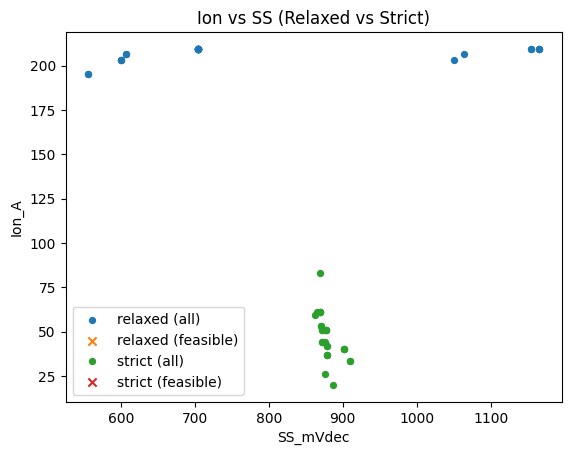

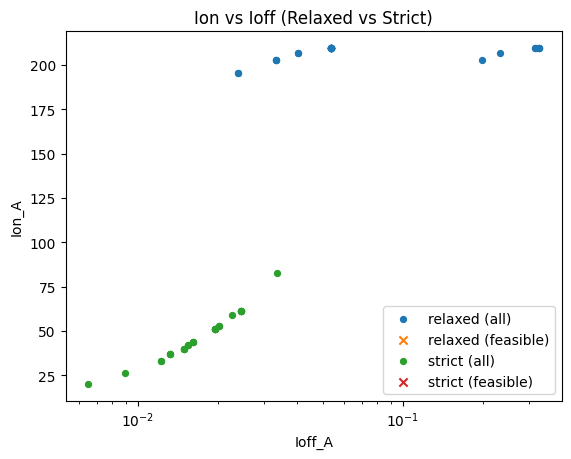

✅ wrote: /content/neighbor_validation_relaxed.csv
✅ wrote: /content/neighbor_validation_strict.csv

=== Neighbor validation summary (surrogate vs measurement) ===


name     MAE_Ion  MAPE_Ion  MAE_logIoff       MAE_SS  MAE_DIBL  \
0  relaxed  141.862702  0.406141     1.709857  1040.186071       0.0   
1   strict    6.641539  0.160047     0.761451   357.987739       0.0   

   median_nn_dist  
0        6.260000  
1        2.050003


Relaxed: Pred vs Meas


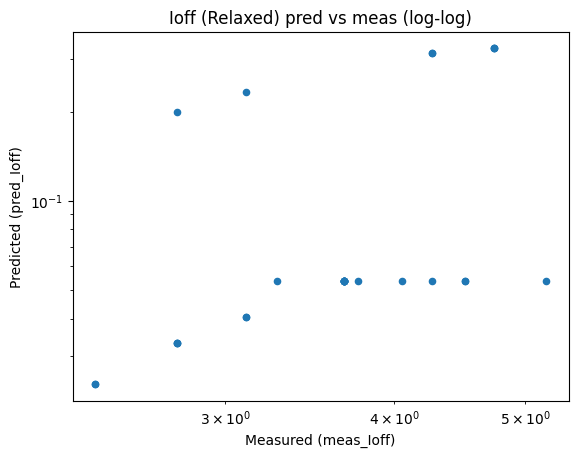


Strict: Pred vs Meas


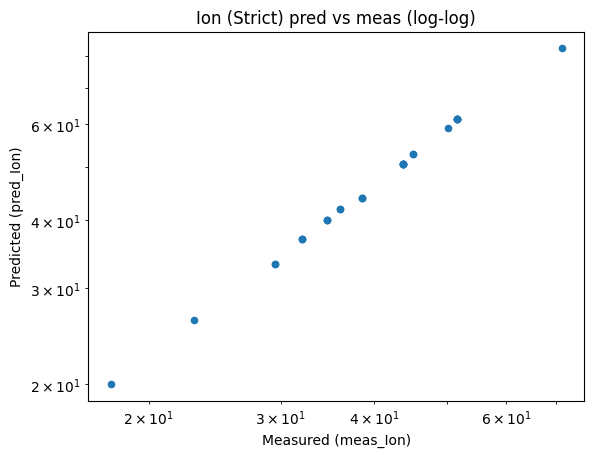

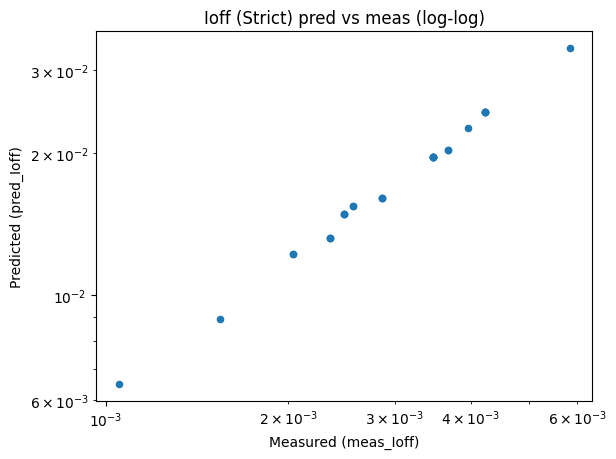

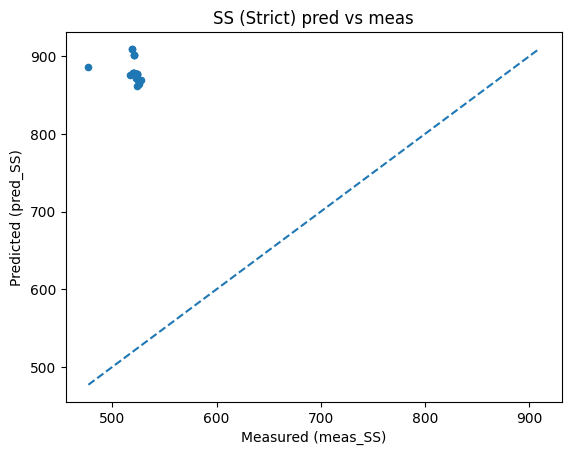

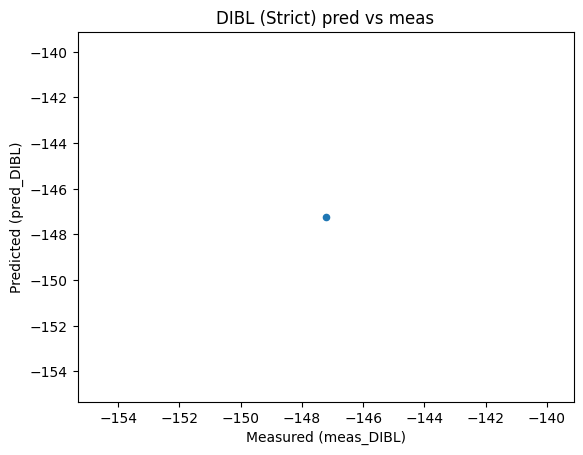


All key artifacts:
 - /content/curve_points.parquet
 - /content/curve_metrics_trueVth.csv
 - /content/dibl_true.csv
 - /content/reliability_dataset.csv
 - /content/surrogate_r2.json
 - /content/llm_reliability_results_relaxed.csv
 - /content/llm_reliability_results_strict.csv
 - /content/neighbor_validation_relaxed.csv
 - /content/neighbor_validation_strict.csv

Done.


In [ ]:
# ==========================================
# ONE-CELL COLAB PIPELINE
# LLM-Guided Reliability Optimization for MoS2 FET dataset (Zenodo)
# - Download Zenodo 10.5281/zenodo.14825422
# - Parse CSV curves -> metrics (Ion/Ioff/Vth/SS) + DIBL
# - Train leak-free surrogate
# - Two-tier constraints (Relaxed vs Strict)
# - OpenRouter LLM search under constraints
# - Neighbor validation (surrogate vs measurement)
# Outputs:
#   /content/curve_points.parquet
#   /content/curve_metrics_trueVth.csv
#   /content/dibl_true.csv
#   /content/reliability_dataset.csv
#   /content/surrogate_r2.json
#   /content/llm_reliability_results_relaxed.csv
#   /content/llm_reliability_results_strict.csv
#   /content/neighbor_validation_relaxed.csv
#   /content/neighbor_validation_strict.csv
# ==========================================

!pip -q install numpy pandas matplotlib scikit-learn pyarrow requests tqdm wget

import os, re, io, json, math, time, random, zipfile, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# -----------------------------
# 0) USER SETTINGS
# -----------------------------
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "")  # or paste
if not OPENROUTER_API_KEY:
    OPENROUTER_API_KEY = "PASTE_YOUR_OPENROUTER_KEY_HERE"   # <-- CHANGE THIS

ZENODO_RECORD = "14825422"
OUTDIR = "/content/zenodo_data"
os.makedirs(OUTDIR, exist_ok=True)

LLM_MODEL = "openai/gpt-4.1"   # OpenRouter model string
N_ROUNDS = 30
TEMPERATURE = 0.3

# Search bounds (safe defaults; will also clamp to dataset)
VG_LO, VG_HI  = -2.5,  3.0
VDS_LO, VDS_HI = 0.0,  2.0

random.seed(7)
np.random.seed(7)

# -----------------------------
# 1) OpenRouter client (OpenAI-compatible)
# -----------------------------
from openai import OpenAI
client = OpenAI(
    api_key=OPENROUTER_API_KEY,
    base_url="https://openrouter.ai/api/v1"
)

def parse_json(s):
    # robust parse: locate first {...} block
    if s is None:
        raise ValueError("Empty response")
    s = s.strip()
    m = re.search(r"\{.*\}", s, flags=re.S)
    if m:
        s = m.group(0)
    return json.loads(s)

# -----------------------------
# 2) Download Zenodo record files (Figures.zip + Readme.pdf)
# -----------------------------
def zenodo_record_metadata(record_id):
    url = f"https://zenodo.org/api/records/{record_id}"
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    return r.json()

def download_file(url, filepath):
    if os.path.exists(filepath) and os.path.getsize(filepath) > 0:
        # quick skip (Zenodo is stable; OK for this project)
        return
    with requests.get(url, stream=True, timeout=120) as r:
        r.raise_for_status()
        with open(filepath, "wb") as f:
            for chunk in r.iter_content(chunk_size=1<<20):
                if chunk:
                    f.write(chunk)

meta = zenodo_record_metadata(ZENODO_RECORD)
title = meta.get("metadata", {}).get("title", "")
doi   = meta.get("metadata", {}).get("doi", "")
pub   = meta.get("metadata", {}).get("publication_date", "")
keywords = meta.get("metadata", {}).get("keywords", [])
files = meta.get("files", [])

print(f"Downloading: 10.5281/zenodo.{ZENODO_RECORD}")
print("Title:", title)
print("Keywords:", ", ".join(keywords))
print("Publication date:", pub)
print("DOI:", doi)

# fetch Figures.zip + Readme.pdf if present
for f in files:
    key = f.get("key","")
    url = f.get("links",{}).get("self","") + "/content"
    # zenodo API "self" already points to file endpoint
    if not url.startswith("http"):
        continue
    local = os.path.join(OUTDIR, os.path.basename(key))
    download_file(url, local)

# unzip Figures.zip
zip_path = os.path.join(OUTDIR, "Figures.zip")
if os.path.exists(zip_path):
    print("Unzipping:", zip_path)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(OUTDIR)
else:
    raise FileNotFoundError("Figures.zip not found in Zenodo record.")

# list csv files
csv_files = []
for root, _, fnames in os.walk(OUTDIR):
    for fn in fnames:
        if fn.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, fn))
csv_files = sorted(csv_files)

print("CSV count:", len(csv_files))
for p in csv_files:
    print(" -", p)

# -----------------------------
# 3) CSV reading helpers (handle headers like 'VGS')
# -----------------------------
def safe_num_series(s):
    # convert to numeric, coerce errors -> NaN
    return pd.to_numeric(s, errors="coerce")

def read_csv_robust(path):
    # Try normal read, then fallback with no header
    try:
        df = pd.read_csv(path)
    except Exception:
        df = pd.read_csv(path, header=None)

    # strip whitespace in column names
    df.columns = [str(c).strip().lower() for c in df.columns]

    # Drop completely empty rows
    df = df.dropna(how="all")
    return df

def find_col(df, candidates):
    cols = list(df.columns)
    for c in candidates:
        if c in cols:
            return c
    # fuzzy contains
    for c in cols:
        for cand in candidates:
            if cand in c:
                return c
    return None

# -----------------------------
# 4) Extract raw curve points from each CSV
#     We support:
#       A) single curve: columns like vgs, id/w
#       B) multi curves by vds column: vgs, id/w, vds
#       C) special: "Figure 4" has columns like vdd, vin, vout, av or time, vin, vout
#     We'll keep only FET transfer-like curves for reliability (vgs vs id)
# -----------------------------
RAW_ROWS = []   # will store per-point records

def normalize_base_name(path):
    base = os.path.splitext(os.path.basename(path))[0]
    return base

def infer_figure_id(path):
    # ".../Figure 2/..." -> "Figure 2"
    m = re.search(r"(Figure\s*\d+)", path)
    return m.group(1).replace("  ", " ").strip() if m else "Unknown"

def add_curve_points(curve_key, figure_id, base_name, source_file, vds_V, vg, idv):
    # vg, idv: 1D arrays
    # coerce numeric
    vg = np.asarray(vg, dtype=float)
    idv = np.asarray(idv, dtype=float)
    # drop NaNs
    mask = np.isfinite(vg) & np.isfinite(idv)
    vg = vg[mask]; idv = idv[mask]
    if len(vg) < 10:
        return
    for i in range(len(vg)):
        RAW_ROWS.append({
            "curve_key": curve_key,
            "figure_id": figure_id,
            "base_name": base_name,
            "source_file": source_file,
            "vds_V": (np.nan if vds_V is None else float(vds_V)),
            "vgs_V": float(vg[i]),
            "id_A": float(idv[i]),
        })

for path in csv_files:
    df = read_csv_robust(path)
    figure_id = infer_figure_id(path)
    base_name = normalize_base_name(path)
    src = path

    # common candidates
    vg_col = find_col(df, ["vgs", "vg", "v_g", "gate", "vgs(v)", "vgs_v"])
    id_col = find_col(df, ["id/w", "id", "ids", "i_d", "current", "id_a", "ids(a)", "id (a)"])
    vds_col = find_col(df, ["vds", "vd", "drain", "vds(v)", "vds_v"])

    # If looks like circuit waveform (Figure 4), skip from FET reliability extraction
    # But keep dataset in case you later want separate tasks.
    if vg_col is None or id_col is None:
        continue

    # numeric conversion
    df[vg_col] = safe_num_series(df[vg_col])
    df[id_col] = safe_num_series(df[id_col])
    if vds_col is not None:
        df[vds_col] = safe_num_series(df[vds_col])

    # If vds exists and has multiple groups -> split
    if vds_col is not None and df[vds_col].notna().sum() > 0:
        # group by rounded vds
        gvals = df[vds_col].dropna().values
        # If only one unique vds -> treat as single
        uniq = np.unique(np.round(gvals.astype(float), 3))
        if len(uniq) <= 1:
            curve_key = f"{figure_id}::{base_name}::single"
            add_curve_points(curve_key, figure_id, base_name, src, float(uniq[0]) if len(uniq)==1 else None,
                             df[vg_col].values, df[id_col].values)
        else:
            # group by rounded vds
            df2 = df.dropna(subset=[vds_col, vg_col, id_col]).copy()
            df2["vds_round"] = np.round(df2[vds_col].astype(float), 3)
            for vds_r, g in df2.groupby("vds_round"):
                curve_key = f"{figure_id}::{base_name}::vds={vds_r:.3f}"
                add_curve_points(curve_key, figure_id, base_name, src, float(vds_r),
                                 g[vg_col].values, g[id_col].values)
    else:
        curve_key = f"{figure_id}::{base_name}::single"
        add_curve_points(curve_key, figure_id, base_name, src, None,
                         df[vg_col].values, df[id_col].values)

raw_points = pd.DataFrame(RAW_ROWS)
if len(raw_points) == 0:
    raise RuntimeError("No usable FET-like curves were extracted from CSVs.")

raw_points_path = "/content/curve_points.parquet"
raw_points.to_parquet(raw_points_path, index=False)
print(f"✅ Saved raw points: {raw_points_path} rows={len(raw_points):,}")

# -----------------------------
# 5) Per-curve metrics: Ion, Ioff, Vth_true, SS_true
#     - Use Id_ref = sqrt(Ion*Ioff) (geometric mean) as "reference current"
#     - Vth_true: first Vgs where |Id| crosses Id_ref (linear interp)
#     - SS_true: local slope around Vth on log10(|Id|)
# -----------------------------
EPS_I = 1e-30

def compute_vth_true(vg, id_abs):
    # requires monotonic-ish, but we do a robust threshold crossing
    Ion = float(np.nanmax(id_abs))
    Ioff = float(np.nanmin(id_abs))
    Id_ref = math.sqrt(max(Ion, EPS_I)*max(Ioff, EPS_I))
    if not (np.isfinite(Ion) and np.isfinite(Ioff)) or Ion <= 0 or Ioff <= 0:
        return np.nan, Id_ref

    # sort by Vg
    order = np.argsort(vg)
    vg = vg[order]
    id_abs = id_abs[order]

    # find first crossing id_abs >= Id_ref
    mask = id_abs >= Id_ref
    if mask.sum() == 0:
        return np.nan, Id_ref
    idx = np.argmax(mask)  # first True
    if idx == 0:
        return float(vg[0]), Id_ref

    # linear interpolate on id_abs between idx-1 and idx
    x0, y0 = vg[idx-1], id_abs[idx-1]
    x1, y1 = vg[idx],   id_abs[idx]
    if not (np.isfinite(x0) and np.isfinite(x1) and np.isfinite(y0) and np.isfinite(y1)):
        return np.nan, Id_ref
    if abs(y1 - y0) < 1e-18:
        return float(x1), Id_ref
    t = (Id_ref - y0) / (y1 - y0)
    vth = x0 + t*(x1 - x0)
    return float(vth), float(Id_ref)

def compute_ss_true(vg, id_abs, vth, window_pts=25):
    # SS = (dVg / dlog10(Id)) * 1000 (mV/dec)
    if not np.isfinite(vth):
        return np.nan
    order = np.argsort(vg)
    vg = vg[order]
    id_abs = id_abs[order]
    logi = np.log10(np.maximum(id_abs, EPS_I))

    # choose points nearest to vth
    idx = np.argmin(np.abs(vg - vth))
    lo = max(0, idx - window_pts//2)
    hi = min(len(vg), idx + window_pts//2 + 1)
    if hi - lo < 8:
        return np.nan
    x = vg[lo:hi]
    y = logi[lo:hi]
    if np.nanstd(y) < 1e-6:
        return np.nan

    # linear fit y = a*x + b -> dlogI/dVg = a -> SS = 1/a decades per V -> convert to mV/dec
    a = np.polyfit(x, y, 1)[0]
    if abs(a) < 1e-9:
        return np.nan
    ss_v_per_dec = 1.0 / a
    return float(abs(ss_v_per_dec) * 1000.0)

metrics_rows = []
for curve_key, g in raw_points.groupby("curve_key"):
    figure_id = g["figure_id"].iloc[0]
    base_name = g["base_name"].iloc[0]
    src = g["source_file"].iloc[0]
    vds = g["vds_V"].iloc[0]

    vg = g["vgs_V"].values.astype(float)
    idv = g["id_A"].values.astype(float)
    id_abs = np.abs(idv)

    Ion = float(np.nanmax(id_abs))
    Ioff = float(np.nanmin(id_abs))
    vth, Id_ref = compute_vth_true(vg, id_abs)
    ss = compute_ss_true(vg, id_abs, vth)

    metrics_rows.append({
        "curve_key": curve_key,
        "figure_id": figure_id,
        "base_name": base_name,
        "source_file": src,
        "vds_V": float(vds) if np.isfinite(vds) else np.nan,
        "Vg_min_V": float(np.nanmin(vg)),
        "Vg_max_V": float(np.nanmax(vg)),
        "n_points": int(len(g)),
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "Id_ref_A": float(Id_ref),
        "Vth_true_V": float(vth) if np.isfinite(vth) else np.nan,
        "SS_true_mVdec": float(ss) if np.isfinite(ss) else np.nan,
    })

curve_metrics = pd.DataFrame(metrics_rows)
curve_metrics_path = "/content/curve_metrics_trueVth.csv"
curve_metrics.to_csv(curve_metrics_path, index=False)
print(f"✅ Saved per-curve metrics: {curve_metrics_path} curves={len(curve_metrics)}")

# -----------------------------
# 6) True DIBL: per family (base_name with Vds sweep)
#     DIBL = - dVth/dVds * 1000  (mV/V)
# -----------------------------
dibl_rows = []
for (fig, base), g in curve_metrics.groupby(["figure_id", "base_name"]):
    gg = g.dropna(subset=["vds_V", "Vth_true_V"]).copy()
    if len(gg) < 8:
        continue
    # need multiple vds
    if gg["vds_V"].nunique() < 6:
        continue
    x = gg["vds_V"].values.astype(float)
    y = gg["Vth_true_V"].values.astype(float)
    # linear fit Vth = a*Vds + b
    a = np.polyfit(x, y, 1)[0]
    dibl = -a * 1000.0
    dibl_rows.append({
        "figure_id": fig,
        "base_name": base,
        "n_curves": int(len(gg)),
        "vds_min": float(np.min(x)),
        "vds_max": float(np.max(x)),
        "Vth_slope_V_per_V": float(a),
        "DIBL_true_mV_per_V": float(dibl),
    })

dibl_true = pd.DataFrame(dibl_rows)
dibl_true_path = "/content/dibl_true.csv"
dibl_true.to_csv(dibl_true_path, index=False)
print(f"✅ Saved true DIBL: {dibl_true_path} rows={len(dibl_true)}")
if len(dibl_true):
    print(dibl_true.head(10).to_string(index=False))

# -----------------------------
# 7) Unified reliability dataset
#     family_id = "Figure X||base_name"
# -----------------------------
ds = curve_metrics.copy()
ds["family_id"] = ds["figure_id"].astype(str) + "||" + ds["base_name"].astype(str)
ds["log_Ion"]  = np.log10(np.maximum(ds["Ion_A"].values, EPS_I))
ds["log_Ioff"] = np.log10(np.maximum(ds["Ioff_A"].values, EPS_I))

# attach family DIBL (if exists)
dibl_map = {}
for _, r in dibl_true.iterrows():
    fam = str(r["figure_id"]) + "||" + str(r["base_name"])
    dibl_map[fam] = float(r["DIBL_true_mV_per_V"])
ds["DIBL_true_mV_per_V"] = ds["family_id"].map(dibl_map).astype(float)

# Keep only FET rows that have Ion/Ioff and some SS (SS can be NaN; we'll handle)
reliability_path = "/content/reliability_dataset.csv"
ds.to_csv(reliability_path, index=False)
print(f"✅ Saved unified dataset: {reliability_path} rows={len(ds)}")

# Update bounds from actual data (safer search space)
VG_LO = float(np.nanpercentile(ds["Vg_min_V"].values, 1))
VG_HI = float(np.nanpercentile(ds["Vg_max_V"].values, 99))
if np.isfinite(ds["vds_V"]).sum() > 0:
    VDS_LO = float(np.nanpercentile(ds["vds_V"].dropna().values, 1))
    VDS_HI = float(np.nanpercentile(ds["vds_V"].dropna().values, 99))
else:
    VDS_LO, VDS_HI = 0.0, 2.0

# -----------------------------
# 8) Surrogate (leak-free) with GroupKFold on family_id
#    Predict: log_Ion, log_Ioff, SS_true_mVdec (SS fallback if NaN)
# -----------------------------
# Prepare training table:
train_ds = ds.copy()
# fill SS NaN with per-family median then global median
fam_ss_med = train_ds.groupby("family_id")["SS_true_mVdec"].median()
global_ss_med = float(np.nanmedian(train_ds["SS_true_mVdec"].values))
train_ds["SS_fill"] = train_ds.apply(
    lambda r: float(fam_ss_med.get(r["family_id"], global_ss_med)) if not np.isfinite(r["SS_true_mVdec"]) else float(r["SS_true_mVdec"]),
    axis=1
)

# Features: vg_min, vg_max, vds, Vg_span
train_ds["Vg_span"] = train_ds["Vg_max_V"] - train_ds["Vg_min_V"]
# vds fill if NaN: per-family median else 0.1
fam_vds_med = train_ds.groupby("family_id")["vds_V"].median()
train_ds["vds_fill"] = train_ds.apply(
    lambda r: float(fam_vds_med.get(r["family_id"], 0.1)) if not np.isfinite(r["vds_V"]) else float(r["vds_V"]),
    axis=1
)

X = train_ds[["Vg_min_V","Vg_max_V","Vg_span","vds_fill"]].values.astype(float)
y1 = train_ds["log_Ion"].values.astype(float)
y2 = train_ds["log_Ioff"].values.astype(float)
y3 = train_ds["SS_fill"].values.astype(float)
groups = train_ds["family_id"].values

def fit_model(y):
    return RandomForestRegressor(
        n_estimators=400,
        random_state=7,
        min_samples_leaf=2,
        n_jobs=-1
    )

def leakfree_r2(X, y, groups):
    gkf = GroupKFold(n_splits=min(5, len(np.unique(groups))))
    preds = np.full_like(y, fill_value=np.nan, dtype=float)
    for tr, te in gkf.split(X, y, groups):
        m = fit_model(y[tr])
        m.fit(X[tr], y[tr])
        preds[te] = m.predict(X[te])
    return float(r2_score(y, preds))

r2 = {
    "log_Ion": leakfree_r2(X, y1, groups),
    "log_Ioff": leakfree_r2(X, y2, groups),
    "SS_true_mVdec": leakfree_r2(X, y3, groups)
}
with open("/content/surrogate_r2.json","w") as f:
    json.dump(r2, f, indent=2)
print("✅ Surrogate R^2 (leak-free):", r2)
print("✅ Saved R^2: /content/surrogate_r2.json")

# Train final models on all data
m_logIon = fit_model(y1); m_logIon.fit(X, y1)
m_logIoff = fit_model(y2); m_logIoff.fit(X, y2)
m_SS = fit_model(y3); m_SS.fit(X, y3)

# family DIBL model: fixed per family, default 0
family_dibl = train_ds.groupby("family_id")["DIBL_true_mV_per_V"].median().to_dict()

def predict(fam, vg_min, vg_max, vds):
    vg_min = float(vg_min); vg_max = float(vg_max); vds = float(vds)
    vg_min = max(VG_LO, min(VG_HI, vg_min))
    vg_max = max(VG_LO, min(VG_HI, vg_max))
    if vg_max <= vg_min:
        vg_max = min(VG_HI, vg_min + 0.2)
    vds = max(VDS_LO, min(VDS_HI, vds))

    x = np.array([[vg_min, vg_max, vg_max-vg_min, vds]], dtype=float)
    logIon = float(m_logIon.predict(x)[0])
    logIoff = float(m_logIoff.predict(x)[0])
    ss = float(m_SS.predict(x)[0])
    dibl = float(family_dibl.get(fam, 0.0))

    Ion = float(10**logIon)
    Ioff = float(10**logIoff)
    return {
        "log_Ion": logIon,
        "log_Ioff": logIoff,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "SS_mVdec": ss,
        "DIBL_mV_V": dibl
    }

# -----------------------------
# 9) Constraints (two-tier from empirical quantiles)
# -----------------------------
def make_constraints(ds_in, tier="relaxed"):
    if tier == "relaxed":
        ss_q   = 0.35
        ioff_q = 0.35
        dibl_q = 0.70
    elif tier == "strict":
        ss_q   = 0.25
        ioff_q = 0.25
        dibl_q = 0.50
    else:
        raise ValueError("tier must be relaxed or strict")

    # Work on filled SS and log_Ioff to avoid NaNs
    tmp = ds_in.copy()
    tmp["SS_fill"] = tmp["SS_true_mVdec"].copy()
    tmp["SS_fill"] = tmp["SS_fill"].fillna(tmp["SS_fill"].median())
    tmp["log_Ioff"] = np.log10(np.maximum(tmp["Ioff_A"].values, EPS_I))
    tmp["abs_DIBL"] = np.abs(tmp["DIBL_true_mV_per_V"].values)

    SS_MAX_ = float(np.nanpercentile(tmp["SS_fill"].values, ss_q*100))
    IOFF_MAX_ = float(10**np.nanpercentile(tmp["log_Ioff"].values, ioff_q*100))
    DIBL_MAX_ = float(np.nanpercentile(tmp["abs_DIBL"].values[np.isfinite(tmp["abs_DIBL"].values)], dibl_q*100)) if np.isfinite(tmp["abs_DIBL"]).sum() else 1e9
    return {"tier": tier, "SS_MAX": SS_MAX_, "IOFF_MAX": IOFF_MAX_, "DIBL_MAX": DIBL_MAX_}

constraints_relaxed = make_constraints(ds, "relaxed")
constraints_strict  = make_constraints(ds, "strict")

print("Two-tier constraints:")
print(constraints_relaxed)
print(constraints_strict)

FAMS_ALL = sorted(train_ds["family_id"].unique().tolist())

def predict_with_constraints(fam, vg_min, vg_max, vds, C):
    out = predict(fam, vg_min, vg_max, vds)
    feasible = (out["SS_mVdec"] <= C["SS_MAX"]) and (out["Ioff_A"] <= C["IOFF_MAX"]) and (abs(out["DIBL_mV_V"]) <= C["DIBL_MAX"])
    out["feasible"] = bool(feasible)
    # utility: larger is better (you can tune weights)
    out["utility"] = float(
        1.2*out["log_Ion"] - 1.0*out["log_Ioff"] - 0.0035*out["SS_mVdec"] - 0.0015*abs(out["DIBL_mV_V"])
    )
    return out

SYSTEM2 = """Return ONLY JSON with keys:
family_id, Vg_min_V, Vg_max_V, vds_V
Rules:
- family_id must be one of the provided options
- Vg_min_V < Vg_max_V
- stay within bounds
No prose.
"""

# -----------------------------
# 10) LLM search with best_state fix (NO KeyError)
# -----------------------------
def run_llm_search(C, n_rounds=30, temperature=0.3, seed_trials=200):
    # warm start
    best_state = None
    for _ in range(seed_trials):
        fam = random.choice(FAMS_ALL)
        vmin = random.uniform(VG_LO, VG_HI-0.5)
        vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
        vds  = random.uniform(VDS_LO, VDS_HI)

        pred0 = predict_with_constraints(fam, vmin, vmax, vds, C)
        cand0 = {"family_id": fam, "Vg_min_V": float(vmin), "Vg_max_V": float(vmax), "vds_V": float(vds)}
        state0 = {"tier": C["tier"], "round": -1, **cand0, **pred0}

        if (best_state is None) or (state0["utility"] > best_state["utility"]):
            best_state = state0

    feedback = None
    rows = []

    MAX_RETRY = 4
    INFEAS_PENALTY = 1.5

    for r in tqdm(range(n_rounds), desc=f"LLM rounds ({C['tier']})"):
        prompt = f"""family_id options (ALL): {FAMS_ALL}
Bounds:
- Vg_min_V, Vg_max_V in [{VG_LO:.3f}, {VG_HI:.3f}]
- vds_V in [{VDS_LO:.3f}, {VDS_HI:.3f}]

Constraints ({C['tier']}):
- SS <= {C['SS_MAX']:.2f} mV/dec
- Ioff <= {C['IOFF_MAX']:.3e} A
- |DIBL| <= {C['DIBL_MAX']:.2f} mV/V

Goal: maximize Ion, minimize Ioff, SS, and |DIBL|.
Hard rule: propose a point that differs from seed by at least one of:
|ΔVg_min|>0.05 OR |ΔVg_max|>0.05 OR |Δvds|>0.05 OR family_id changes.

Seed (current best): {json.dumps({k: best_state[k] for k in ['family_id','Vg_min_V','Vg_max_V','vds_V']})}
"""
        if feedback:
            prompt += f"\nLast evaluation feedback: {json.dumps(feedback)}"

        cand, pred1 = None, None
        for attempt in range(MAX_RETRY):
            resp = client.chat.completions.create(
                model=LLM_MODEL,
                messages=[{"role":"system","content":SYSTEM2},
                          {"role":"user","content":prompt}],
                temperature=temperature,
            )
            cand_try = parse_json(resp.choices[0].message.content)
            pred_try = predict_with_constraints(
                cand_try["family_id"],
                float(cand_try["Vg_min_V"]),
                float(cand_try["Vg_max_V"]),
                float(cand_try["vds_V"]),
                C
            )
            cand, pred1 = cand_try, pred_try
            if pred1["feasible"]:
                break
            prompt += f"\nAttempt {attempt+1} infeasible. Try lower Ioff (reduce vds_V, reduce Vg_max_V, narrow Vg span). Current: {json.dumps({k: pred1[k] for k in ['Ion_A','Ioff_A','SS_mVdec','DIBL_mV_V','feasible']})}"

        # optional penalty
        if pred1 is not None and (not pred1["feasible"]):
            pred1["utility"] = float(pred1["utility"] - INFEAS_PENALTY)

        row = {
            "tier": C["tier"],
            "round": int(r),
            "family_id": cand["family_id"],
            "Vg_min_V": float(cand["Vg_min_V"]),
            "Vg_max_V": float(cand["Vg_max_V"]),
            "vds_V": float(cand["vds_V"]),
            **pred1
        }
        rows.append(row)

        if row["utility"] > best_state["utility"]:
            best_state = row

        feedback = {k: row[k] for k in ["Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]}

    res = pd.DataFrame(rows)
    return res, best_state

res_relaxed, best_relaxed = run_llm_search(constraints_relaxed, n_rounds=N_ROUNDS, temperature=TEMPERATURE)
res_strict,  best_strict  = run_llm_search(constraints_strict,  n_rounds=N_ROUNDS, temperature=TEMPERATURE)

print("\nBest (relaxed):", {k: best_relaxed[k] for k in ["tier","family_id","Vg_min_V","Vg_max_V","vds_V","Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]})
print("Best (strict): ", {k: best_strict[k]  for k in ["tier","family_id","Vg_min_V","Vg_max_V","vds_V","Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]})

RELAXED_CSV = "/content/llm_reliability_results_relaxed.csv"
STRICT_CSV  = "/content/llm_reliability_results_strict.csv"
res_relaxed.to_csv(RELAXED_CSV, index=False)
res_strict.to_csv(STRICT_CSV, index=False)
print("✅ wrote:", RELAXED_CSV)
print("✅ wrote:", STRICT_CSV)

# -----------------------------
# 11) Compare distributions (Relaxed vs Strict)
# -----------------------------
def summarize_res(res, C):
    n = len(res)
    n_feas = int(res["feasible"].sum())
    frac = n_feas / max(n,1)
    util_best = float(res["utility"].max())
    util_best_feas = float(res.loc[res["feasible"], "utility"].max()) if n_feas>0 else float("nan")
    ion_med_feas = float(np.nanmedian(res.loc[res["feasible"], "Ion_A"])) if n_feas>0 else float("nan")
    ioff_med_feas = float(np.nanmedian(res.loc[res["feasible"], "Ioff_A"])) if n_feas>0 else float("nan")
    ss_med_feas = float(np.nanmedian(res.loc[res["feasible"], "SS_mVdec"])) if n_feas>0 else float("nan")
    dibl_med_feas = float(np.nanmedian(np.abs(res.loc[res["feasible"], "DIBL_mV_V"]))) if n_feas>0 else float("nan")
    return {
        "tier": C["tier"],
        "SS_MAX": C["SS_MAX"],
        "IOFF_MAX": C["IOFF_MAX"],
        "DIBL_MAX": C["DIBL_MAX"],
        "n": n,
        "n_feasible": n_feas,
        "feasible_rate": frac,
        "best_utility_any": util_best,
        "best_utility_feasible": util_best_feas,
        "median_Ion_feasible": ion_med_feas,
        "median_Ioff_feasible": ioff_med_feas,
        "median_SS_feasible": ss_med_feas,
        "median_|DIBL|_feasible": dibl_med_feas,
    }

summary_df = pd.DataFrame([
    summarize_res(res_relaxed, constraints_relaxed),
    summarize_res(res_strict, constraints_strict)
])
print("\n=== Two-tier summary ===")
display(summary_df)

def plot_compare(resA, resB, col, xscale=None, yscale=None, title=""):
    plt.figure()
    plt.scatter(resA[col], resA["Ion_A"], s=18, label=f"{resA['tier'].iloc[0]} (all)")
    plt.scatter(resA.loc[resA["feasible"], col], resA.loc[resA["feasible"], "Ion_A"], s=35, marker="x", label=f"{resA['tier'].iloc[0]} (feasible)")
    plt.scatter(resB[col], resB["Ion_A"], s=18, label=f"{resB['tier'].iloc[0]} (all)")
    plt.scatter(resB.loc[resB["feasible"], col], resB.loc[resB["feasible"], "Ion_A"], s=35, marker="x", label=f"{resB['tier'].iloc[0]} (feasible)")
    if xscale: plt.xscale(xscale)
    if yscale: plt.yscale(yscale)
    plt.xlabel(col)
    plt.ylabel("Ion_A")
    plt.title(title or f"Ion vs {col} (two tiers)")
    plt.legend()
    plt.show()

plot_compare(res_relaxed, res_strict, "SS_mVdec", title="Ion vs SS (Relaxed vs Strict)")
plot_compare(res_relaxed, res_strict, "Ioff_A", xscale="log", title="Ion vs Ioff (Relaxed vs Strict)")
plot_compare(res_relaxed, res_strict, "DIBL_mV_V", title="Ion vs DIBL (Relaxed vs Strict)")

# -----------------------------
# 12) Neighbor validation (surrogate vs measurement)
# -----------------------------
# Restrict to rows with finite vds in dataset (for meaningful NN)
real_tbl = ds[np.isfinite(ds["vds_V"])].copy()
if len(real_tbl) == 0:
    real_tbl = ds.copy()

W_VMIN = 1.0
W_VMAX = 1.0
W_VDS  = 3.0
EPS = 1e-12

def nearest_real(row, real_tbl):
    fam = row["family_id"]
    g = real_tbl[real_tbl["family_id"] == fam]
    if len(g) == 0:
        g = real_tbl

    dvmin = (g["Vg_min_V"].values - row["Vg_min_V"])
    dvmax = (g["Vg_max_V"].values - row["Vg_max_V"])
    dvds  = (g["vds_V"].values - row["vds_V"])
    dist = (W_VMIN*dvmin*dvmin + W_VMAX*dvmax*dvmax + W_VDS*dvds*dvds)
    j = int(np.argmin(dist))
    nn = g.iloc[j]
    return nn, float(dist[j])

def validate(res, name=""):
    vals = []
    for _, r in res.iterrows():
        nn, dist = nearest_real(r, real_tbl)

        meas_Ion  = float(nn["Ion_A"])
        meas_Ioff = float(nn["Ioff_A"])
        meas_SS   = float(nn["SS_true_mVdec"]) if np.isfinite(nn["SS_true_mVdec"]) else float(global_ss_med)
        meas_DIBL = float(nn["DIBL_true_mV_per_V"]) if np.isfinite(nn["DIBL_true_mV_per_V"]) else float(family_dibl.get(nn["family_id"], 0.0))

        pred_Ion  = float(r["Ion_A"])
        pred_Ioff = float(r["Ioff_A"])
        pred_SS   = float(r["SS_mVdec"])
        pred_DIBL = float(r["DIBL_mV_V"])

        vals.append({
            "tier": r["tier"],
            "round": int(r["round"]),
            "family_id": r["family_id"],
            "Vg_min_V": float(r["Vg_min_V"]),
            "Vg_max_V": float(r["Vg_max_V"]),
            "vds_V": float(r["vds_V"]),
            "feasible": bool(r["feasible"]),
            "utility": float(r["utility"]),
            "nn_curve_key": str(nn.get("curve_key","")),
            "nn_dist": dist,
            "pred_Ion": pred_Ion, "meas_Ion": meas_Ion,
            "pred_Ioff": pred_Ioff, "meas_Ioff": meas_Ioff,
            "pred_SS": pred_SS, "meas_SS": meas_SS,
            "pred_DIBL": pred_DIBL, "meas_DIBL": meas_DIBL,
        })

    vdf = pd.DataFrame(vals)

    def mae(a,b): return float(np.nanmean(np.abs(np.asarray(a)-np.asarray(b))))
    def mape(a,b):
        a=np.asarray(a); b=np.asarray(b)
        return float(np.nanmean(np.abs(a-b)/np.maximum(np.abs(b), EPS)))

    report = {
        "name": name,
        "MAE_Ion": mae(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAPE_Ion": mape(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAE_logIoff": mae(np.log10(np.maximum(vdf["pred_Ioff"],EPS_I)), np.log10(np.maximum(vdf["meas_Ioff"],EPS_I))),
        "MAE_SS": mae(vdf["pred_SS"], vdf["meas_SS"]),
        "MAE_DIBL": mae(vdf["pred_DIBL"], vdf["meas_DIBL"]),
        "median_nn_dist": float(np.nanmedian(vdf["nn_dist"])),
    }
    return vdf, report

val_relaxed, rep_relaxed = validate(res_relaxed, name="relaxed")
val_strict,  rep_strict  = validate(res_strict,  name="strict")

VAL_RELAXED_CSV = "/content/neighbor_validation_relaxed.csv"
VAL_STRICT_CSV  = "/content/neighbor_validation_strict.csv"
val_relaxed.to_csv(VAL_RELAXED_CSV, index=False)
val_strict.to_csv(VAL_STRICT_CSV, index=False)
print("✅ wrote:", VAL_RELAXED_CSV)
print("✅ wrote:", VAL_STRICT_CSV)

rep_df = pd.DataFrame([rep_relaxed, rep_strict])
print("\n=== Neighbor validation summary (surrogate vs measurement) ===")
display(rep_df)

def pred_vs_meas_plot(vdf, pred_col, meas_col, logx=False, logy=False, title=""):
    plt.figure()
    x = vdf[meas_col].values
    y = vdf[pred_col].values
    plt.scatter(x, y, s=20)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    if (not logx) and (not logy):
        mn = np.nanmin([np.nanmin(x), np.nanmin(y)])
        mx = np.nanmax([np.nanmax(x), np.nanmax(y)])
        plt.plot([mn,mx],[mn,mx], linestyle="--")
    plt.xlabel(f"Measured ({meas_col})")
    plt.ylabel(f"Predicted ({pred_col})")
    plt.title(title or f"{pred_col} vs {meas_col}")
    plt.show()

print("\nRelaxed: Pred vs Meas")
pred_vs_meas_plot(val_relaxed, "pred_Ion","meas_Ion", logx=True, logy=True, title="Ion (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_Ioff","meas_Ioff", logx=True, logy=True, title="Ioff (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_SS","meas_SS", title="SS (Relaxed) pred vs meas")
pred_vs_meas_plot(val_relaxed, "pred_DIBL","meas_DIBL", title="DIBL (Relaxed) pred vs meas")

print("\nStrict: Pred vs Meas")
pred_vs_meas_plot(val_strict, "pred_Ion","meas_Ion", logx=True, logy=True, title="Ion (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_Ioff","meas_Ioff", logx=True, logy=True, title="Ioff (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_SS","meas_SS", title="SS (Strict) pred vs meas")
pred_vs_meas_plot(val_strict, "pred_DIBL","meas_DIBL", title="DIBL (Strict) pred vs meas")

print("\nAll key artifacts:")
print(" -", raw_points_path)
print(" -", curve_metrics_path)
print(" -", dibl_true_path)
print(" -", reliability_path)
print(" - /content/surrogate_r2.json")
print(" -", RELAXED_CSV)
print(" -", STRICT_CSV)
print(" -", VAL_RELAXED_CSV)
print(" -", VAL_STRICT_CSV)
print("\nDone.")


In [ ]:
# ============================================
# Ultra-scaled MoS2 dataset pipeline (Zenodo 10.5281/zenodo.14825422)
# End-to-end: download -> parse curves -> compute metrics (Ion/Ioff/Vth/SS/DIBL)
# -> build unified dataset -> leak-free surrogate -> two-tier constraints
# -> optional LLM search -> neighbor validation (surrogate vs measurement)
#
# Single-cell Colab friendly.
# ============================================

!pip -q install pandas numpy pyarrow scikit-learn tqdm matplotlib requests

import os, re, io, json, math, zipfile, random, requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# ----------------------------
# 0) Repro
# ----------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)

# ----------------------------
# 1) Config
# ----------------------------
ZENODO_RECORD = "14825422"
BASE_DIR = "/content"
ZENODO_DIR = os.path.join(BASE_DIR, "zenodo_data")
FIG_ZIP = os.path.join(ZENODO_DIR, "Figures.zip")
README_PDF = os.path.join(ZENODO_DIR, "Readme.pdf")

OUT_CURVE_POINTS = os.path.join(BASE_DIR, "curve_points.parquet")
OUT_CURVE_METRICS = os.path.join(BASE_DIR, "curve_metrics_trueVth.csv")
OUT_DIBL_TRUE = os.path.join(BASE_DIR, "dibl_true.csv")
OUT_DATASET = os.path.join(BASE_DIR, "reliability_dataset.csv")
OUT_R2 = os.path.join(BASE_DIR, "surrogate_r2.json")

RELAXED_CSV = os.path.join(BASE_DIR, "llm_reliability_results_relaxed.csv")
STRICT_CSV  = os.path.join(BASE_DIR, "llm_reliability_results_strict.csv")

VAL_RELAXED_CSV = os.path.join(BASE_DIR, "neighbor_validation_relaxed.csv")
VAL_STRICT_CSV  = os.path.join(BASE_DIR, "neighbor_validation_strict.csv")

# LLM search knobs
RUN_LLM = True   # if no API key, it will auto-disable
N_ROUNDS = 30
TEMPERATURE = 0.3
LLM_MODEL = os.getenv("LLM_MODEL", "gpt-4o-mini")  # you can change

# Search bounds (generic; will be clamped by dataset stats too)
VG_LO, VG_HI = -2.5, 3.0
VDS_LO, VDS_HI = 0.0, 2.0

# Utility weights (you can tune)
W_LOG_ION = 1.2
W_LOG_IOFF = 1.0
W_SS = 0.0035
W_DIBL = 0.0015

EPS = 1e-12

# ----------------------------
# 2) Download Zenodo
# ----------------------------
def zenodo_download(record_id: str, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    api = f"https://zenodo.org/api/records/{record_id}"
    meta = requests.get(api, timeout=60).json()

    title = meta.get("metadata", {}).get("title", "")
    doi = meta.get("metadata", {}).get("doi", "")
    pub = meta.get("metadata", {}).get("publication_date", "")
    keywords = meta.get("metadata", {}).get("keywords", [])
    print(f"loading: 10.5281/zenodo.{record_id}")
    print("Title:", title)
    print("Keywords:", ", ".join(keywords) if isinstance(keywords, list) else keywords)
    print("Publication date:", pub)
    print("DOI:", doi)

    files = meta.get("files", [])
    for f in files:
        key = f["key"]
        url = f["links"]["self"]
        # Zenodo "content" endpoint:
        content_url = url + "/content"
        out_path = os.path.join(out_dir, key)

        if os.path.exists(out_path) and os.path.getsize(out_path) > 0:
            print(f"{key} is already downloaded correctly.")
            continue

        print("Downloading:", key)
        r = requests.get(content_url, timeout=120)
        r.raise_for_status()
        with open(out_path, "wb") as w:
            w.write(r.content)
        print("Saved:", out_path)

zenodo_download(ZENODO_RECORD, ZENODO_DIR)

# unzip figures
if os.path.exists(FIG_ZIP):
    print("Unzipping:", FIG_ZIP)
    with zipfile.ZipFile(FIG_ZIP, "r") as z:
        z.extractall(ZENODO_DIR)

# list csvs
csv_files = []
for root, _, files in os.walk(ZENODO_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_files.append(os.path.join(root, fn))
csv_files = sorted(csv_files)
print("CSV count:", len(csv_files))
for p in csv_files:
    print(" -", p)

# ----------------------------
# 3) CSV parser helpers
# ----------------------------
def _norm_col(s: str) -> str:
    s = s.strip().lower()
    s = s.replace(" ", "").replace("_", "")
    return s

def guess_cols(df: pd.DataFrame):
    """
    Try to guess gate voltage column and drain current column.
    Common: vgs, vg, gate, x ; id, id/w, current, y
    """
    cols = list(df.columns)
    ncols = [_norm_col(c) for c in cols]

    # candidate Vg cols
    vg_candidates = []
    for c, nc in zip(cols, ncols):
        if nc in ["vgs", "vg", "gate", "v_g", "vgs(v)","vgs(v)"]:
            vg_candidates.append(c)
        if "vg" in nc and "id" not in nc and "vds" not in nc:
            vg_candidates.append(c)

    # candidate Id cols
    id_candidates = []
    for c, nc in zip(cols, ncols):
        if nc in ["id", "id/w", "idperw", "current", "ids", "id(a)","ids(a)"]:
            id_candidates.append(c)
        if ("id" in nc or "ids" in nc) and "v" not in nc:
            id_candidates.append(c)

    # candidate Vds cols (optional)
    vds_candidates = []
    for c, nc in zip(cols, ncols):
        if nc in ["vds", "vd", "v_d", "drainvoltage"]:
            vds_candidates.append(c)
        if "vds" in nc:
            vds_candidates.append(c)

    vg_col = vg_candidates[0] if vg_candidates else None
    id_col = id_candidates[0] if id_candidates else None
    vds_col = vds_candidates[0] if vds_candidates else None
    return vg_col, id_col, vds_col

def safe_read_csv(path: str) -> pd.DataFrame:
    # tolerate weird separators
    try:
        df = pd.read_csv(path)
        return df
    except Exception:
        df = pd.read_csv(path, sep=None, engine="python")
        return df

def base_name_from_path(p: str) -> str:
    # "Figure 2 c blue.csv" -> "Figure 2 c blue"
    return os.path.splitext(os.path.basename(p))[0]

def figure_id_from_path(p: str) -> str:
    # .../Figure 3/Figure 3 b.csv -> "Figure 3"
    m = re.search(r"(Figure\s*\d+)", p)
    return m.group(1).replace("  ", " ").strip() if m else "Unknown"

# ----------------------------
# 4) Extract curve points
# ----------------------------
all_points = []
curve_keys = []

for path in csv_files:
    df = safe_read_csv(path)
    if df.shape[0] < 5 or df.shape[1] < 2:
        continue

    vg_col, id_col, vds_col = guess_cols(df)
    if vg_col is None or id_col is None:
        # fallback: first numeric col as vg, second numeric as id
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if len(num_cols) >= 2:
            vg_col, id_col = num_cols[0], num_cols[1]
            vds_col = num_cols[2] if len(num_cols) >= 3 else None
        else:
            continue

    # clean numeric
    x = pd.to_numeric(df[vg_col], errors="coerce").values.astype(float)
    y = pd.to_numeric(df[id_col], errors="coerce").values.astype(float)

    # Vds: either a column or absent (NaN)
    if vds_col is not None and vds_col in df.columns:
        vds_vals = pd.to_numeric(df[vds_col], errors="coerce").values.astype(float)
    else:
        vds_vals = np.full_like(x, np.nan, dtype=float)

    mask = np.isfinite(x) & np.isfinite(y)
    x, y, vds_vals = x[mask], y[mask], vds_vals[mask]
    if len(x) < 10:
        continue

    fig_id = figure_id_from_path(path)
    base = base_name_from_path(path)

    # splitting rule:
    # - if vds varies in-file, treat each unique vds as a separate curve
    # - else single curve
    if np.any(np.isfinite(vds_vals)) and (np.nanmax(vds_vals) - np.nanmin(vds_vals) > 1e-9):
        # group by rounded Vds
        vds_round = np.round(vds_vals, 2)
        for vv in sorted(pd.unique(vds_round[np.isfinite(vds_round)])):
            m2 = (vds_round == vv) & np.isfinite(x) & np.isfinite(y)
            if m2.sum() < 10:
                continue
            key = f"{fig_id}::{base}::vds={vv:.2f}"
            for xi, yi in zip(x[m2], y[m2]):
                all_points.append({
                    "curve_key": key,
                    "figure_id": fig_id,
                    "base_name": base,
                    "source_file": path,
                    "vgs_V": float(xi),
                    "id_A": float(yi),
                    "vds_V": float(vv),
                })
            curve_keys.append(key)
    else:
        key = f"{fig_id}::{base}::single"
        for xi, yi, vi in zip(x, y, vds_vals):
            all_points.append({
                "curve_key": key,
                "figure_id": fig_id,
                "base_name": base,
                "source_file": path,
                "vgs_V": float(xi),
                "id_A": float(yi),
                "vds_V": float(vi) if np.isfinite(vi) else np.nan,
            })
        curve_keys.append(key)

curve_points = pd.DataFrame(all_points)
curve_points.to_parquet(OUT_CURVE_POINTS, index=False)
print(f"✅ Saved raw points: {OUT_CURVE_POINTS} rows={len(curve_points):,}")

# ----------------------------
# 5) Per-curve metrics: Ion/Ioff + true Vth + SS_true
# ----------------------------
def compute_vth_true(vg: np.ndarray, idv: np.ndarray, id_ref: float):
    """
    Vth defined as Vg at which Id crosses Id_ref (linear interpolation on Id vs Vg).
    """
    if len(vg) < 5:
        return np.nan
    # sort by Vg
    idx = np.argsort(vg)
    vg, idv = vg[idx], idv[idx]
    # need monotonic crossing? We'll just find first segment crossing id_ref
    diff = idv - id_ref
    # find sign change
    s = np.sign(diff)
    # if exactly equals:
    exact = np.where(np.isclose(diff, 0.0, atol=0.0, rtol=0.0))[0]
    if len(exact) > 0:
        return float(vg[int(exact[0])])
    # sign changes
    for i in range(len(s) - 1):
        if np.isnan(s[i]) or np.isnan(s[i+1]):
            continue
        if s[i] == 0 or s[i+1] == 0:
            continue
        if s[i] != s[i+1]:
            # linear interp between i and i+1
            x0, x1 = vg[i], vg[i+1]
            y0, y1 = idv[i], idv[i+1]
            if (y1 - y0) == 0:
                return float(x0)
            t = (id_ref - y0) / (y1 - y0)
            return float(x0 + t*(x1 - x0))
    return np.nan

def compute_ss_true(vg: np.ndarray, idv: np.ndarray, vth: float, window_V=0.25):
    """
    SS computed as 1 / slope of log10(Id) vs Vg around Vth in a small window.
    returns mV/dec
    """
    if not np.isfinite(vth):
        return np.nan
    idx = np.argsort(vg)
    vg, idv = vg[idx], idv[idx]
    m = (vg >= vth - window_V) & (vg <= vth + window_V) & np.isfinite(idv) & (np.abs(idv) > 0)
    if m.sum() < 6:
        return np.nan
    x = vg[m]
    y = np.log10(np.maximum(np.abs(idv[m]), 1e-30))
    # linear fit
    A = np.vstack([x, np.ones_like(x)]).T
    coef, *_ = np.linalg.lstsq(A, y, rcond=None)
    slope = coef[0]
    if not np.isfinite(slope) or abs(slope) < 1e-12:
        return np.nan
    # SS = dVg / d(log10 Id) = 1/slope  [V/dec] -> mV/dec
    ss_mVdec = (1.0 / slope) * 1e3
    return float(abs(ss_mVdec))

curve_metrics = []
for key, g in curve_points.groupby("curve_key"):
    vg = g["vgs_V"].values.astype(float)
    idv = g["id_A"].values.astype(float)
    vds = g["vds_V"].values.astype(float)
    vds_val = float(np.nanmedian(vds)) if np.isfinite(np.nanmedian(vds)) else np.nan

    ion = float(np.nanmax(idv))
    ioff = float(np.nanmin(idv))
    # For safety: in some extracted data current might be signed or noisy; use abs for thresholds
    ion = float(np.nanmax(np.abs(idv)))
    ioff = float(np.nanmin(np.abs(idv)))

    # choose Id_ref between Ion and Ioff in log-space (geometric mean)
    id_ref = float(math.sqrt(max(ion, 1e-30) * max(ioff, 1e-30)))

    vth = compute_vth_true(vg, np.abs(idv), id_ref=id_ref)
    ss = compute_ss_true(vg, np.abs(idv), vth=vth, window_V=0.25)

    fig_id = str(g["figure_id"].iloc[0])
    base = str(g["base_name"].iloc[0])
    src = str(g["source_file"].iloc[0])

    curve_metrics.append({
        "curve_key": key,
        "figure_id": fig_id,
        "base_name": base,
        "source_file": src,
        "vds_V": vds_val,
        "Vg_min_V": float(np.nanmin(vg)),
        "Vg_max_V": float(np.nanmax(vg)),
        "Vg_span_V": float(np.nanmax(vg) - np.nanmin(vg)),
        "n_points": int(len(g)),
        "Ion_A": ion,
        "Ioff_A": ioff,
        "Id_ref_A": id_ref,
        "Vth_true_V": vth,
        "SS_true_mVdec": ss,
    })

curve_metrics = pd.DataFrame(curve_metrics)
curve_metrics.to_csv(OUT_CURVE_METRICS, index=False)
print(f"✅ Saved per-curve metrics: {OUT_CURVE_METRICS} curves={len(curve_metrics)}")

# ----------------------------
# 6) True DIBL per family: slope of Vth vs Vds (mV/V, negative typical)
# ----------------------------
# Define "family" as (figure_id || base_name) because Vds sweeps appear within same base_name
curve_metrics["family_id"] = curve_metrics["figure_id"].astype(str) + "||" + curve_metrics["base_name"].astype(str)

dibl_rows = []
for fam, g in curve_metrics.groupby("family_id"):
    g2 = g[np.isfinite(g["vds_V"]) & np.isfinite(g["Vth_true_V"])].copy()
    if len(g2) < 8:
        continue
    vds = g2["vds_V"].values.astype(float)
    vth = g2["Vth_true_V"].values.astype(float)
    # fit vth = a*vds + b
    A = np.vstack([vds, np.ones_like(vds)]).T
    a, b = np.linalg.lstsq(A, vth, rcond=None)[0]
    dibl_mV_per_V = -a * 1e3  # DIBL = - dVth/dVds * 1000
    dibl_rows.append({
        "family_id": fam,
        "figure_id": str(g2["figure_id"].iloc[0]),
        "base_name": str(g2["base_name"].iloc[0]),
        "n_curves": int(len(g2)),
        "vds_min": float(np.nanmin(vds)),
        "vds_max": float(np.nanmax(vds)),
        "Vth_slope_V_per_V": float(a),
        "DIBL_true_mV_per_V": float(dibl_mV_per_V),
    })

dibl_true = pd.DataFrame(dibl_rows)
dibl_true.to_csv(OUT_DIBL_TRUE, index=False)
print(f"✅ Saved true DIBL: {OUT_DIBL_TRUE} rows={len(dibl_true)}")
if len(dibl_true) > 0:
    display(dibl_true.head(10))

# ----------------------------
# 7) Unified dataset
# ----------------------------
ds = curve_metrics.merge(
    dibl_true[["family_id", "DIBL_true_mV_per_V"]],
    on="family_id",
    how="left"
)

# log targets
ds["log_Ion"] = np.log10(np.maximum(ds["Ion_A"].values.astype(float), 1e-30))
ds["log_Ioff"] = np.log10(np.maximum(ds["Ioff_A"].values.astype(float), 1e-30))

# Keep only families (we still allow NaN DIBL for single curves; for constraints we will use abs(DIBL) if present)
ds.to_csv(OUT_DATASET, index=False)
print(f"✅ Saved unified dataset: {OUT_DATASET} rows={len(ds)}")

# ----------------------------
# 8) Leak-free surrogate: predict log_Ion, log_Ioff, SS_true_mVdec from (family_id, Vg_min, Vg_max, vds)
#     Split by family_id to avoid leakage.
# ----------------------------
# pick rows with finite vds for training (LLM proposes vds)
train_ds = ds.copy()
# if a family has all NaN vds, keep but impute later; model will learn "missing vds" effect poorly
# better: impute vds with family median, but keep indicator
train_ds["vds_is_nan"] = (~np.isfinite(train_ds["vds_V"])).astype(int)
train_ds["vds_V_filled"] = train_ds["vds_V"].copy()
train_ds.loc[~np.isfinite(train_ds["vds_V_filled"]), "vds_V_filled"] = float(np.nanmedian(train_ds["vds_V"].values)) if np.isfinite(np.nanmedian(train_ds["vds_V"].values)) else 0.0

FEATURES_NUM = ["Vg_min_V", "Vg_max_V", "vds_V_filled", "vds_is_nan"]
FEATURES_CAT = ["family_id"]

def make_model(random_state=SEED):
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline(steps=[
                ("imp", SimpleImputer(strategy="median")),
            ]), FEATURES_NUM),
            ("cat", OneHotEncoder(handle_unknown="ignore"), FEATURES_CAT),
        ],
        remainder="drop"
    )
    # RF is robust for tiny datasets
    reg = RandomForestRegressor(
        n_estimators=300,
        random_state=random_state,
        n_jobs=-1,
        max_depth=None,
        min_samples_leaf=2
    )
    return Pipeline(steps=[("pre", pre), ("reg", reg)])

def fit_and_eval(target_col: str):
    X = train_ds[FEATURES_NUM + FEATURES_CAT]
    y = train_ds[target_col].values.astype(float)

    # group split by family_id
    groups = train_ds["family_id"].values
    gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
    (tr_idx, te_idx) = next(gss.split(X, y, groups=groups))

    model = make_model()
    model.fit(X.iloc[tr_idx], y[tr_idx])

    pred = model.predict(X.iloc[te_idx])
    score = r2_score(y[te_idx], pred) if np.isfinite(y[te_idx]).sum() > 2 else float("nan")
    return model, float(score)

models = {}
r2s = {}
for tgt in ["log_Ion", "log_Ioff", "SS_true_mVdec"]:
    model, r2 = fit_and_eval(tgt)
    models[tgt] = model
    r2s[tgt] = r2

print("✅ Surrogate R^2 (leak-free):", r2s)
with open(OUT_R2, "w") as f:
    json.dump(r2s, f, indent=2)
print("✅ Saved R^2:", OUT_R2)

# ----------------------------
# 9) Prediction function (surrogate + per-family DIBL_true)
# ----------------------------
# make a lookup for DIBL_true per family; if missing, set NaN
family_dibl = dict(zip(ds["family_id"].values, ds["DIBL_true_mV_per_V"].values))

def clamp(v, lo, hi):
    return float(max(lo, min(hi, v)))

def predict(family_id: str, vg_min: float, vg_max: float, vds: float):
    vg_min = clamp(vg_min, VG_LO, VG_HI)
    vg_max = clamp(vg_max, VG_LO, VG_HI)
    if vg_max <= vg_min:
        vg_max = vg_min + 0.2
    vds = clamp(vds, VDS_LO, VDS_HI)

    row = pd.DataFrame([{
        "family_id": family_id,
        "Vg_min_V": vg_min,
        "Vg_max_V": vg_max,
        "vds_V_filled": vds,
        "vds_is_nan": 0,
    }])

    log_ion = float(models["log_Ion"].predict(row)[0])
    log_ioff = float(models["log_Ioff"].predict(row)[0])
    ss = float(models["SS_true_mVdec"].predict(row)[0])

    ion = float(10**log_ion)
    ioff = float(10**log_ioff)

    dibl = family_dibl.get(family_id, np.nan)
    dibl = float(dibl) if dibl is not None and np.isfinite(dibl) else float("nan")

    util = (W_LOG_ION*log_ion - W_LOG_IOFF*log_ioff - W_SS*ss - W_DIBL*(abs(dibl) if np.isfinite(dibl) else 0.0))

    return {
        "log_Ion": log_ion,
        "log_Ioff": log_ioff,
        "Ion_A": ion,
        "Ioff_A": ioff,
        "SS_mVdec": ss,
        "DIBL_mV_V": dibl,
        "utility": float(util),
    }

# ----------------------------
# 10) Two-tier constraints (relaxed vs strict) from empirical quantiles
# ----------------------------
def make_constraints(ds_: pd.DataFrame, tier="relaxed"):
    # ds must contain: SS_true_mVdec, log_Ioff, DIBL_true_mV_per_V
    if tier == "relaxed":
        ss_q, ioff_q, dibl_q = 0.35, 0.35, 0.70
    elif tier == "strict":
        ss_q, ioff_q, dibl_q = 0.25, 0.25, 0.50
    else:
        raise ValueError("tier must be relaxed or strict")

    SS_MAX_ = float(np.nanpercentile(ds_["SS_true_mVdec"].values, ss_q*100))
    IOFF_MAX_ = float(10**np.nanpercentile(ds_["log_Ioff"].values, ioff_q*100))
    dibl_abs = np.abs(ds_["DIBL_true_mV_per_V"].values.astype(float))
    DIBL_MAX_ = float(np.nanpercentile(dibl_abs[np.isfinite(dibl_abs)], dibl_q*100)) if np.isfinite(dibl_abs).any() else float("inf")
    return {"tier": tier, "SS_MAX": SS_MAX_, "IOFF_MAX": IOFF_MAX_, "DIBL_MAX": DIBL_MAX_}

constraints_relaxed = make_constraints(ds, "relaxed")
constraints_strict  = make_constraints(ds, "strict")

print("Two-tier constraints:")
print(constraints_relaxed)
print(constraints_strict)

FAMS_ALL = sorted(train_ds["family_id"].unique().tolist())

def predict_with_constraints(fam, vg_min, vg_max, vds, C):
    out = predict(fam, vg_min, vg_max, vds)
    feasible = (out["SS_mVdec"] <= C["SS_MAX"]) and (out["Ioff_A"] <= C["IOFF_MAX"]) and (abs(out["DIBL_mV_V"]) <= C["DIBL_MAX"] if np.isfinite(out["DIBL_mV_V"]) else True)
    out["feasible"] = bool(feasible)
    # utility already computed in predict(); keep consistent
    return out

# ----------------------------
# 11) OPTIONAL LLM search (auto-skip if no OPENAI_API_KEY)
# ----------------------------
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
if (not OPENAI_API_KEY) and RUN_LLM:
    print("⚠️ OPENAI_API_KEY not found. RUN_LLM will be disabled (still produces dataset/surrogate/validation).")
    RUN_LLM = False

def parse_json(s: str):
    # tolerate code fences
    s = s.strip()
    s = re.sub(r"^```(json)?", "", s).strip()
    s = re.sub(r"```$", "", s).strip()
    return json.loads(s)

SYSTEM2 = """Return ONLY JSON with keys:
family_id, Vg_min_V, Vg_max_V, vds_V
Rules:
- family_id must be one of the provided options
- Vg_min_V < Vg_max_V
- stay within bounds
No prose.
"""

def run_llm_search(C, n_rounds=30, temperature=0.3, seed_trials=200):
    # lazy import openai
    from openai import OpenAI
    client = OpenAI(api_key=OPENAI_API_KEY)

    # warm start
    best = None
    for _ in range(seed_trials):
        fam = random.choice(FAMS_ALL)
        vmin = random.uniform(VG_LO, VG_HI-0.5)
        vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
        vds  = random.uniform(VDS_LO, VDS_HI)
        pred0 = predict_with_constraints(fam, vmin, vmax, vds, C)
        cand0 = {"family_id": fam, "Vg_min_V": float(vmin), "Vg_max_V": float(vmax), "vds_V": float(vds)}
        if best is None or pred0["utility"] > best[1]["utility"]:
            best = (cand0, pred0)

    feedback = None
    rows = []

    for r in tqdm(range(n_rounds), desc=f"LLM rounds ({C['tier']})"):
        prompt = f"""family_id options (ALL): {FAMS_ALL}
Bounds:
- Vg_min_V, Vg_max_V in [{VG_LO}, {VG_HI}]
- vds_V in [{VDS_LO}, {VDS_HI}]
Constraints ({C['tier']}):
- SS <= {C['SS_MAX']:.4g} mV/dec
- Ioff <= {C['IOFF_MAX']:.4g} A
- |DIBL| <= {C['DIBL_MAX']:.4g} mV/V

Goal: maximize Ion, minimize Ioff, SS, and |DIBL|.
Hard rule: propose a point that differs from seed by at least one of:
|ΔVg_min|>0.05 OR |ΔVg_max|>0.05 OR |Δvds|>0.05 OR family_id changes.

Seed (current best): {json.dumps(best[0])}
"""
        if feedback:
            prompt += f"\nLast evaluation feedback: {json.dumps(feedback)}"

        resp = client.chat.completions.create(
            model=LLM_MODEL,
            messages=[{"role":"system","content":SYSTEM2},
                      {"role":"user","content":prompt}],
            temperature=temperature,
        )

        cand = parse_json(resp.choices[0].message.content)
        # clamp
        cand["Vg_min_V"] = float(cand["Vg_min_V"])
        cand["Vg_max_V"] = float(cand["Vg_max_V"])
        cand["vds_V"] = float(cand["vds_V"])
        if cand["Vg_max_V"] <= cand["Vg_min_V"]:
            cand["Vg_max_V"] = cand["Vg_min_V"] + 0.2

        pred1 = predict_with_constraints(cand["family_id"], cand["Vg_min_V"], cand["Vg_max_V"], cand["vds_V"], C)
        row = {"tier": C["tier"], "round": int(r), **cand, **pred1}
        rows.append(row)

        if pred1["utility"] > best[1]["utility"]:
            best = (cand, pred1)

        feedback = {k: pred1[k] for k in ["Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]}

    res = pd.DataFrame(rows)
    best_row = {"tier": C["tier"], **best[0], **best[1]}
    return res, best_row

if RUN_LLM:
    res_relaxed, best_relaxed = run_llm_search(constraints_relaxed, n_rounds=N_ROUNDS, temperature=TEMPERATURE)
    res_strict,  best_strict  = run_llm_search(constraints_strict,  n_rounds=N_ROUNDS, temperature=TEMPERATURE)

    # safe printing (no KeyError even if weirdness)
    def safe_pick(d, keys):
        return {k: d.get(k, None) for k in keys}

    KEYS_SHOW = ["tier","family_id","Vg_min_V","Vg_max_V","vds_V","Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]
    print("\nBest (relaxed):", safe_pick(best_relaxed, KEYS_SHOW))
    print("Best (strict): ", safe_pick(best_strict,  KEYS_SHOW))

    res_relaxed.to_csv(RELAXED_CSV, index=False)
    res_strict.to_csv(STRICT_CSV, index=False)
    print("✅ wrote:", RELAXED_CSV)
    print("✅ wrote:", STRICT_CSV)
else:
    # create empty placeholders so later steps still work
    res_relaxed = pd.DataFrame(columns=["tier","round","family_id","Vg_min_V","Vg_max_V","vds_V","Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"])
    res_strict  = res_relaxed.copy()
    best_relaxed, best_strict = {}, {}

# ----------------------------
# 12) Compare feasible distributions (works even if RUN_LLM=False)
# ----------------------------
def summarize_res(res, C):
    n = len(res)
    n_feas = int(res["feasible"].sum()) if ("feasible" in res.columns and n > 0) else 0
    frac = n_feas / max(n, 1)
    util_best = float(np.nanmax(res["utility"])) if ("utility" in res.columns and n > 0) else float("nan")
    util_best_feas = float(np.nanmax(res.loc[res["feasible"], "utility"])) if (n_feas > 0) else float("nan")

    ion_med_feas  = float(np.nanmedian(res.loc[res["feasible"], "Ion_A"])) if n_feas > 0 else float("nan")
    ioff_med_feas = float(np.nanmedian(res.loc[res["feasible"], "Ioff_A"])) if n_feas > 0 else float("nan")
    ss_med_feas   = float(np.nanmedian(res.loc[res["feasible"], "SS_mVdec"])) if n_feas > 0 else float("nan")
    dibl_med_feas = float(np.nanmedian(np.abs(res.loc[res["feasible"], "DIBL_mV_V"]))) if n_feas > 0 else float("nan")

    return {
        "tier": C["tier"],
        "SS_MAX": C["SS_MAX"],
        "IOFF_MAX": C["IOFF_MAX"],
        "DIBL_MAX": C["DIBL_MAX"],
        "n": n,
        "n_feasible": n_feas,
        "feasible_rate": frac,
        "best_utility_any": util_best,
        "best_utility_feasible": util_best_feas,
        "median_Ion_feasible": ion_med_feas,
        "median_Ioff_feasible": ioff_med_feas,
        "median_SS_feasible": ss_med_feas,
        "median_|DIBL|_feasible": dibl_med_feas,
    }

summary_df = pd.DataFrame([
    summarize_res(res_relaxed, constraints_relaxed),
    summarize_res(res_strict, constraints_strict)
])
print("\n=== Two-tier summary ===")
display(summary_df)

def plot_compare(resA, resB, col, xscale=None, yscale=None, title=""):
    if len(resA) == 0 or len(resB) == 0:
        print(f"(skip plot {title or col}) because no LLM results.")
        return
    plt.figure()
    plt.scatter(resA[col], resA["Ion_A"], s=18, label=f"{resA['tier'].iloc[0]} (all)")
    plt.scatter(resA.loc[resA["feasible"], col], resA.loc[resA["feasible"], "Ion_A"],
                s=40, marker="x", label=f"{resA['tier'].iloc[0]} (feasible)")
    plt.scatter(resB[col], resB["Ion_A"], s=18, label=f"{resB['tier'].iloc[0]} (all)")
    plt.scatter(resB.loc[resB["feasible"], col], resB.loc[resB["feasible"], "Ion_A"],
                s=40, marker="x", label=f"{resB['tier'].iloc[0]} (feasible)")
    if xscale: plt.xscale(xscale)
    if yscale: plt.yscale(yscale)
    plt.xlabel(col)
    plt.ylabel("Ion_A")
    plt.title(title or f"Ion vs {col} (two tiers)")
    plt.legend()
    plt.show()

plot_compare(res_relaxed, res_strict, "SS_mVdec", title="Ion vs SS (Relaxed vs Strict)")
plot_compare(res_relaxed, res_strict, "Ioff_A", xscale="log", title="Ion vs Ioff (Relaxed vs Strict)")
plot_compare(res_relaxed, res_strict, "DIBL_mV_V", title="Ion vs DIBL (Relaxed vs Strict)")

# ----------------------------
# 13) Neighbor validation: surrogate vs measurement
#     nearest neighbor in real dataset within same family_id (weighted distance in (Vg_min, Vg_max, Vds))
# ----------------------------
real_tbl = ds[np.isfinite(ds["vds_V"])].copy()
if len(real_tbl) == 0:
    real_tbl = ds.copy()

W_VMIN = 1.0
W_VMAX = 1.0
W_VDS  = 3.0

def nearest_real(row, real_tbl):
    fam = row["family_id"]
    g = real_tbl[real_tbl["family_id"] == fam]
    if len(g) == 0:
        g = real_tbl

    dvmin = (g["Vg_min_V"].values - row["Vg_min_V"])
    dvmax = (g["Vg_max_V"].values - row["Vg_max_V"])
    dvds  = (g["vds_V"].values - row["vds_V"])
    dist = (W_VMIN*dvmin*dvmin + W_VMAX*dvmax*dvmax + W_VDS*dvds*dvds)
    j = int(np.argmin(dist))
    nn = g.iloc[j]
    return nn, float(dist[j])

def validate(res, name=""):
    if len(res) == 0:
        return pd.DataFrame(), {"name": name, "MAE_Ion": np.nan, "MAPE_Ion": np.nan, "MAE_logIoff": np.nan, "MAE_SS": np.nan, "MAE_DIBL": np.nan, "median_nn_dist": np.nan}

    vals = []
    for _, r in res.iterrows():
        nn, dist = nearest_real(r, real_tbl)

        meas_Ion  = float(nn["Ion_A"])
        meas_Ioff = float(nn["Ioff_A"])
        meas_SS   = float(nn["SS_true_mVdec"])
        meas_DIBL = float(nn["DIBL_true_mV_per_V"]) if "DIBL_true_mV_per_V" in nn.index else float("nan")

        pred_Ion  = float(r["Ion_A"])
        pred_Ioff = float(r["Ioff_A"])
        pred_SS   = float(r["SS_mVdec"])
        pred_DIBL = float(r["DIBL_mV_V"])

        vals.append({
            "tier": r["tier"],
            "round": int(r["round"]),
            "family_id": r["family_id"],
            "Vg_min_V": float(r["Vg_min_V"]),
            "Vg_max_V": float(r["Vg_max_V"]),
            "vds_V": float(r["vds_V"]),
            "feasible": bool(r["feasible"]),
            "utility": float(r["utility"]),
            "nn_curve_key": str(nn.get("curve_key","")),
            "nn_dist": dist,
            "pred_Ion": pred_Ion, "meas_Ion": meas_Ion,
            "pred_Ioff": pred_Ioff, "meas_Ioff": meas_Ioff,
            "pred_SS": pred_SS, "meas_SS": meas_SS,
            "pred_DIBL": pred_DIBL, "meas_DIBL": meas_DIBL,
        })

    vdf = pd.DataFrame(vals)

    def mae(a,b): return float(np.nanmean(np.abs(np.asarray(a)-np.asarray(b))))
    def mape(a,b):
        a=np.asarray(a); b=np.asarray(b)
        return float(np.nanmean(np.abs(a-b)/np.maximum(np.abs(b), EPS)))

    report = {
        "name": name,
        "MAE_Ion": mae(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAPE_Ion": mape(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAE_logIoff": mae(np.log10(np.maximum(vdf["pred_Ioff"],1e-30)), np.log10(np.maximum(vdf["meas_Ioff"],1e-30))),
        "MAE_SS": mae(vdf["pred_SS"], vdf["meas_SS"]),
        "MAE_DIBL": mae(vdf["pred_DIBL"], vdf["meas_DIBL"]),
        "median_nn_dist": float(np.nanmedian(vdf["nn_dist"])),
    }
    return vdf, report

val_relaxed, rep_relaxed = validate(res_relaxed, name="relaxed")
val_strict,  rep_strict  = validate(res_strict,  name="strict")

if len(val_relaxed) > 0:
    val_relaxed.to_csv(VAL_RELAXED_CSV, index=False)
    print("✅ wrote:", VAL_RELAXED_CSV)
if len(val_strict) > 0:
    val_strict.to_csv(VAL_STRICT_CSV, index=False)
    print("✅ wrote:", VAL_STRICT_CSV)

rep_df = pd.DataFrame([rep_relaxed, rep_strict])
print("\n=== Neighbor validation summary (surrogate vs measurement) ===")
display(rep_df)

def pred_vs_meas_plot(vdf, pred_col, meas_col, logx=False, logy=False, title=""):
    if len(vdf) == 0:
        print(f"(skip plot {title}) because empty validation df.")
        return
    plt.figure()
    x = vdf[meas_col].values
    y = vdf[pred_col].values
    plt.scatter(x, y, s=20)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    # y=x guide only if linear
    if (not logx) and (not logy):
        mn = np.nanmin([np.nanmin(x), np.nanmin(y)])
        mx = np.nanmax([np.nanmax(x), np.nanmax(y)])
        plt.plot([mn,mx],[mn,mx], linestyle="--")
    plt.xlabel(f"Measured ({meas_col})")
    plt.ylabel(f"Predicted ({pred_col})")
    plt.title(title or f"{pred_col} vs {meas_col}")
    plt.show()

print("\nRelaxed: Pred vs Meas")
pred_vs_meas_plot(val_relaxed, "pred_Ion","meas_Ion", logx=True, logy=True, title="Ion (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_Ioff","meas_Ioff", logx=True, logy=True, title="Ioff (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_SS","meas_SS", title="SS (Relaxed) pred vs meas")
pred_vs_meas_plot(val_relaxed, "pred_DIBL","meas_DIBL", title="DIBL (Relaxed) pred vs meas")

print("\nStrict: Pred vs Meas")
pred_vs_meas_plot(val_strict, "pred_Ion","meas_Ion", logx=True, logy=True, title="Ion (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_Ioff","meas_Ioff", logx=True, logy=True, title="Ioff (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_SS","meas_SS", title="SS (Strict) pred vs meas")
pred_vs_meas_plot(val_strict, "pred_DIBL","meas_DIBL", title="DIBL (Strict) pred vs meas")

print("\nAll key artifacts:")
print(" -", OUT_CURVE_POINTS)
print(" -", OUT_CURVE_METRICS)
print(" -", OUT_DIBL_TRUE)
print(" -", OUT_DATASET)
print(" -", OUT_R2)
print(" -", RELAXED_CSV if os.path.exists(RELAXED_CSV) else "(LLM skipped)")
print(" -", STRICT_CSV  if os.path.exists(STRICT_CSV)  else "(LLM skipped)")
print(" -", VAL_RELAXED_CSV if os.path.exists(VAL_RELAXED_CSV) else "(validation empty)")
print(" -", VAL_STRICT_CSV  if os.path.exists(VAL_STRICT_CSV)  else "(validation empty)")
print("\nDone.")


loading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
Keywords: Field-effect transistor, Logic gates, MoS2
Publication date: 2025-02-06
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv
✅ Saved raw points: /content/curve_points.parquet rows=126,696


/tmp/ipython-input-3271268337.py:335: RuntimeWarning: All-NaN slice encountered
  vds_val = float(np.nanmedian(vds)) if np.isfinite(np.nanmedian(vds)) else np.nan


✅ Saved per-curve metrics: /content/curve_metrics_trueVth.csv curves=496
✅ Saved true DIBL: /content/dibl_true.csv rows=4


family_id figure_id       base_name  n_curves  vds_min  \
0  Figure 2||Figure 2 d set  Figure 2  Figure 2 d set       172     0.00   
1      Figure 3||Figure 3 b  Figure 3      Figure 3 b       201     0.00   
2     Figure 4||Figure 4 ab  Figure 4     Figure 4 ab        39     0.01   
3      Figure 4||Figure 4 c  Figure 4      Figure 4 c        81     0.11   

   vds_max  Vth_slope_V_per_V  DIBL_true_mV_per_V  
0     1.96           1.158571        -1158.570568  
1     2.00           0.184502         -184.502046  
2     1.50           0.618464         -618.464396  
3     0.91           0.000011           -0.010824

✅ Saved unified dataset: /content/reliability_dataset.csv rows=496


ValueError: Input y contains NaN.

In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE (END-TO-END)
# Ultra-scaled MoS2 transistor curves (Zenodo 10.5281/zenodo.14825422)
# - Download + unzip Figures.zip
# - Parse CSVs -> raw curve points
# - Build per-curve metrics: Ion, Ioff, Vth_true, SS_true
# - Compute per-family true DIBL from Vth vs Vds slope
# - Build unified reliability dataset
# - Train leak-free surrogate (group split by family_id)  ✅ handles NaN targets
# - Two-tier constraints (relaxed vs strict) + LLM-guided search (optional)
# - Neighbor validation: surrogate pred vs nearest measured curve
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, math, zipfile, random, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# ----------------------------
# 0) Repro
# ----------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)

# ----------------------------
# 1) Zenodo download
# ----------------------------
ZENODO_RECORD_ID = "14825422"
OUT_DIR = "/content/zenodo_data"
os.makedirs(OUT_DIR, exist_ok=True)

def zenodo_download_record(record_id, out_dir):
    api = f"https://zenodo.org/api/records/{record_id}"
    r = requests.get(api, timeout=60)
    r.raise_for_status()
    meta = r.json()
    title = meta.get("metadata", {}).get("title", "")
    doi = meta.get("doi", "")
    pub = meta.get("metadata", {}).get("publication_date", "")
    kw = meta.get("metadata", {}).get("keywords", [])
    files = meta.get("files", [])
    print(f"Downloading: {doi}")
    print(f"Title: {title}")
    print(f"Keywords: {', '.join(kw)}")
    print(f"Publication date: {pub}")
    print(f"DOI: {doi}")

    local_paths = []
    for f in files:
        key = f["key"]
        url = f["links"]["self"]
        # Zenodo content endpoint
        url = url.replace("/api/files/", "/api/records/"+record_id+"/files/") + "/content" if "/api/files/" in url else url + "/content"
        # Sometimes "links.self" is already /api/records/.../files/...
        if "/api/records/" in f["links"]["self"] and not f["links"]["self"].endswith("/content"):
            url = f["links"]["self"] + "/content"

        dst = os.path.join(out_dir, key)
        # skip if exists and non-empty
        if os.path.exists(dst) and os.path.getsize(dst) > 0:
            print(f"{key} is already downloaded correctly.")
            local_paths.append(dst)
            continue

        print(f"Downloading {key} ...")
        rr = requests.get(url, stream=True, timeout=120)
        rr.raise_for_status()
        with open(dst, "wb") as wf:
            for chunk in rr.iter_content(chunk_size=1024*256):
                if chunk:
                    wf.write(chunk)
        local_paths.append(dst)
        print(f"Saved: {dst}")
    return local_paths

paths = zenodo_download_record(ZENODO_RECORD_ID, OUT_DIR)

# unzip Figures.zip
figzip = os.path.join(OUT_DIR, "Figures.zip")
if os.path.exists(figzip):
    print(f"Unzipping: {figzip}")
    with zipfile.ZipFile(figzip, "r") as zf:
        zf.extractall(OUT_DIR)

# list CSVs
csv_paths = []
for root, _, files in os.walk(OUT_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

# ----------------------------
# 2) Helpers: robust parsing
# ----------------------------
def _to_float(x):
    try:
        if pd.isna(x): return np.nan
        if isinstance(x, str):
            x = x.strip().replace(",", "")
        return float(x)
    except Exception:
        return np.nan

def guess_cols(df):
    cols = [c.strip() for c in df.columns]
    low = [c.lower().strip() for c in cols]

    # Gate voltage candidates
    vg_cands = ["vg", "vgs", "v_g", "gate", "vg(v)", "vgs(v)"]
    # Drain current candidates
    id_cands = ["id", "ids", "i", "id/w", "ids/w", "id (a)", "ids (a)", "i_d", "current"]
    # Drain voltage candidates
    vds_cands = ["vds", "vd", "v_d", "drain", "vds(v)", "vd(v)"]

    def find_any(cands):
        for cand in cands:
            for i, c in enumerate(low):
                if cand == c:
                    return cols[i]
        # fuzzy
        for cand in cands:
            for i, c in enumerate(low):
                if cand in c:
                    return cols[i]
        return None

    vg = find_any(vg_cands)
    idc = find_any(id_cands)
    vds = find_any(vds_cands)
    return vg, idc, vds

def safe_read_csv(path):
    try:
        df = pd.read_csv(path)
    except Exception:
        df = pd.read_csv(path, encoding_errors="ignore")
    # strip weird columns
    df.columns = [str(c).strip() for c in df.columns]
    return df

def parse_vds_from_curve_col(df, vds_col):
    # Sometimes Vds is encoded as a column with repeated same value
    if vds_col and vds_col in df.columns:
        v = df[vds_col].map(_to_float).values
        med = np.nanmedian(v)
        if np.isfinite(med):
            return float(med)
    return np.nan

def family_id_from_path(path):
    # family defined as "Figure X||<base name>"
    # base name: file name without extension, but normalize spaces
    fig = "Unknown"
    m = re.search(r"(Figure\s*\d+)", path)
    if m:
        fig = m.group(1).replace("  ", " ").strip()
    base = os.path.splitext(os.path.basename(path))[0].strip()
    base = re.sub(r"\s+", " ", base)
    return f"{fig}||{base}", fig, base

# ----------------------------
# 3) Extract raw points (curve_points.parquet)
#    We treat each CSV as either:
#    - single curve: two cols (Vg, Id)
#    - multi-curve: has an explicit Vds column OR multiple Id columns
# ----------------------------
def extract_points_from_csv(path):
    df = safe_read_csv(path)
    vg_col, id_col, vds_col = guess_cols(df)

    fam, fig, base = family_id_from_path(path)

    # If cannot find id/vg, try fallback: first numeric columns
    if vg_col is None or id_col is None:
        num_cols = []
        for c in df.columns:
            x = df[c].map(_to_float)
            if np.isfinite(x).sum() > max(10, len(df)*0.2):
                num_cols.append(c)
        # heuristic: smallest range -> Id? no. We'll pick first as vg and second as id
        if len(num_cols) >= 2:
            vg_col = vg_col or num_cols[0]
            id_col = id_col or num_cols[1]

    # If still missing, give up
    if vg_col is None or id_col is None:
        return []

    # detect multi-Id columns: if id_col looks like "id/w" but there are many current columns
    # approach:
    # - if vds_col exists => group by vds values (rounded)
    # - else if there are multiple "id" like columns => treat each as separate curve against same vg_col
    points = []

    vgs = df[vg_col].map(_to_float).values
    if not np.isfinite(vgs).any():
        return []

    if vds_col and vds_col in df.columns:
        vds_vals = df[vds_col].map(_to_float).values
        # group by unique vds (rounded to 2 decimals)
        key_v = np.round(vds_vals.astype(float), 2)
        uniq = pd.unique(key_v[np.isfinite(key_v)])
        for v in uniq:
            m = (np.isfinite(key_v) & (key_v == v) & np.isfinite(vgs))
            if m.sum() < 8:
                continue
            ids = df.loc[m, id_col].map(_to_float).values
            curve_key = f"{fam}::vds={float(v):.2f}"
            for vg, idv in zip(vgs[m], ids):
                if np.isfinite(vg) and np.isfinite(idv):
                    points.append([curve_key, fam, fig, base, path, float(v), float(vg), float(idv), vg_col, id_col])
        return points

    # If no explicit vds column: try detect multiple current columns
    id_like_cols = []
    for c in df.columns:
        cl = c.lower()
        if ("id" in cl or "ids" in cl or "current" in cl) and c != vg_col:
            # must have enough numeric
            if np.isfinite(df[c].map(_to_float).values).sum() > max(10, len(df)*0.1):
                id_like_cols.append(c)

    if len(id_like_cols) >= 2:
        # treat each id column as separate curve, parse vds from column name if possible
        for c in id_like_cols:
            ids = df[c].map(_to_float).values
            if np.isfinite(ids).sum() < 8:
                continue
            # parse vds from column name e.g., "Id @ Vds=0.2"
            vds = np.nan
            mm = re.search(r"vds\s*=?\s*([-+]?\d*\.?\d+)", c.lower())
            if mm:
                vds = float(mm.group(1))
            curve_key = f"{fam}::{c}"
            for vg, idv in zip(vgs, ids):
                if np.isfinite(vg) and np.isfinite(idv):
                    points.append([curve_key, fam, fig, base, path, vds, float(vg), float(idv), vg_col, c])
        return points

    # else: single curve
    ids = df[id_col].map(_to_float).values
    if np.isfinite(ids).sum() < 8:
        return []
    curve_key = f"{fam}::single"
    vds = parse_vds_from_curve_col(df, vds_col)
    for vg, idv in zip(vgs, ids):
        if np.isfinite(vg) and np.isfinite(idv):
            points.append([curve_key, fam, fig, base, path, vds, float(vg), float(idv), vg_col, id_col])
    return points

all_pts = []
for p in csv_paths:
    pts = extract_points_from_csv(p)
    all_pts.extend(pts)

curve_points = pd.DataFrame(
    all_pts,
    columns=["curve_key","family_id","figure_id","base_name","source_file","vds_V","Vg_V","Id_A","vg_col","id_col"]
)

# Save raw points
PTS_PARQ = "/content/curve_points.parquet"
curve_points.to_parquet(PTS_PARQ, index=False)
print(f"✅ Saved raw points: {PTS_PARQ} rows={len(curve_points):,}")

# ----------------------------
# 4) True metrics per curve: Ion, Ioff, Vth_true, SS_true
# ----------------------------
def compute_vth_true(vg, id_abs, frac=0.05):
    """
    True-ish threshold proxy:
    - Use Id_ref = Ioff + frac*(Ion-Ioff)
    - Vth is the first Vg where Id_abs >= Id_ref (linear interp)
    """
    m = np.isfinite(vg) & np.isfinite(id_abs)
    vg = vg[m]; id_abs = id_abs[m]
    if len(vg) < 8:
        return np.nan, np.nan

    # sort by Vg
    idx = np.argsort(vg)
    vg = vg[idx]; id_abs = id_abs[idx]

    Ion = float(np.nanmax(id_abs))
    Ioff = float(np.nanmin(id_abs))
    if not (np.isfinite(Ion) and np.isfinite(Ioff)):
        return np.nan, np.nan
    if Ion <= Ioff:
        return np.nan, np.nan

    Id_ref = Ioff + frac*(Ion - Ioff)

    # find crossing
    above = id_abs >= Id_ref
    if not np.any(above):
        return np.nan, float(Id_ref)
    j = int(np.argmax(above))  # first True index
    if j == 0:
        return float(vg[0]), float(Id_ref)

    # linear interp in (Vg, Id)
    x0, y0 = vg[j-1], id_abs[j-1]
    x1, y1 = vg[j], id_abs[j]
    if y1 == y0:
        return float(x1), float(Id_ref)
    t = (Id_ref - y0) / (y1 - y0)
    vth = x0 + t*(x1 - x0)
    return float(vth), float(Id_ref)

def compute_ss_true(vg, id_abs, vth, window_V=0.25, min_pts=6):
    """
    SS in mV/dec using local slope of log10(Id) vs Vg around Vth.
    SS = (dVg/dlog10Id)*1000 (mV/dec) = 1000 / slope
    """
    if not np.isfinite(vth):
        return np.nan
    m = np.isfinite(vg) & np.isfinite(id_abs) & (id_abs > 0)
    vg = vg[m]; id_abs = id_abs[m]
    if len(vg) < 8:
        return np.nan

    idx = np.argsort(vg)
    vg = vg[idx]; id_abs = id_abs[idx]

    w = (vg >= vth - window_V) & (vg <= vth + window_V)
    if w.sum() < min_pts:
        return np.nan

    x = vg[w]
    y = np.log10(id_abs[w])

    # linear fit
    A = np.vstack([x, np.ones_like(x)]).T
    coef, *_ = np.linalg.lstsq(A, y, rcond=None)
    slope = coef[0]
    if not np.isfinite(slope) or abs(slope) < 1e-12:
        return np.nan
    ss = 1000.0 / slope
    # take absolute (sometimes slope negative if curve inverted)
    return float(abs(ss))

# compute metrics for each curve_key
rows = []
for ck, g in curve_points.groupby("curve_key"):
    fam = g["family_id"].iloc[0]
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    src = g["source_file"].iloc[0]
    vds = float(np.nanmedian(g["vds_V"].values)) if np.isfinite(np.nanmedian(g["vds_V"].values)) else np.nan

    vg = g["Vg_V"].values.astype(float)
    idv = g["Id_A"].values.astype(float)
    id_abs = np.abs(idv)

    Ion = float(np.nanmax(id_abs)) if np.isfinite(id_abs).any() else np.nan
    Ioff = float(np.nanmin(id_abs)) if np.isfinite(id_abs).any() else np.nan

    vth, Id_ref = compute_vth_true(vg, id_abs, frac=0.05)
    ss = compute_ss_true(vg, id_abs, vth, window_V=0.25, min_pts=6)

    vg_min = float(np.nanmin(vg)) if np.isfinite(vg).any() else np.nan
    vg_max = float(np.nanmax(vg)) if np.isfinite(vg).any() else np.nan
    npts = int(np.isfinite(vg).sum())

    rows.append({
        "curve_key": ck,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "source_file": src,
        "vds_V": vds,
        "Vg_min_V": vg_min,
        "Vg_max_V": vg_max,
        "Vg_span_V": vg_max - vg_min if (np.isfinite(vg_max) and np.isfinite(vg_min)) else np.nan,
        "n_points": npts,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "Id_ref_A": Id_ref,
        "Vth_true_V": vth,
        "SS_true_mVdec": ss,
    })

curve_metrics = pd.DataFrame(rows)
METRICS_CSV = "/content/curve_metrics_trueVth.csv"
curve_metrics.to_csv(METRICS_CSV, index=False)
print(f"✅ Saved per-curve metrics: {METRICS_CSV} curves={len(curve_metrics)}")

# ----------------------------
# 5) True DIBL per family: slope of Vth_true vs Vds (mV/V)
# ----------------------------
dibl_rows = []
for fam, g in curve_metrics.groupby("family_id"):
    gg = g.copy()
    gg = gg[np.isfinite(gg["vds_V"].values)]
    gg = gg[np.isfinite(gg["Vth_true_V"].values)]
    if len(gg) < 8:
        continue

    # Use robust fit: median Vth per Vds bin (rounded 2 decimals)
    gg["vds_bin"] = np.round(gg["vds_V"].values.astype(float), 2)
    med = gg.groupby("vds_bin")["Vth_true_V"].median().reset_index()
    if len(med) < 3:
        continue

    x = med["vds_bin"].values.astype(float)
    y = med["Vth_true_V"].values.astype(float)

    # linear regression y = a*x + b
    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    dibl_mV_per_V = -a * 1000.0  # (convention) DIBL positive when Vth decreases with Vds; here we store signed
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    dibl_rows.append({
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "n_curves": int(len(g)),
        "vds_min": float(np.nanmin(gg["vds_V"].values)),
        "vds_max": float(np.nanmax(gg["vds_V"].values)),
        "Vth_slope_V_per_V": float(a),
        "DIBL_true_mV_per_V": float(dibl_mV_per_V),
    })

dibl_true = pd.DataFrame(dibl_rows)
DIBL_CSV = "/content/dibl_true.csv"
dibl_true.to_csv(DIBL_CSV, index=False)
print(f"✅ Saved true DIBL: {DIBL_CSV} rows={len(dibl_true)}")
if len(dibl_true):
    display(dibl_true.head(10))

# ----------------------------
# 6) Unified dataset (reliability_dataset.csv)
# ----------------------------
ds = curve_metrics.merge(
    dibl_true[["family_id","DIBL_true_mV_per_V"]],
    on="family_id", how="left"
)

# add logs (stable)
ds["Ion_A"] = ds["Ion_A"].astype(float)
ds["Ioff_A"] = ds["Ioff_A"].astype(float)
ds["log_Ion"] = np.log10(np.maximum(ds["Ion_A"].values, 1e-30))
ds["log_Ioff"] = np.log10(np.maximum(ds["Ioff_A"].values, 1e-30))

# Optional: drop obviously broken rows (no Ion/Ioff)
ds = ds[np.isfinite(ds["log_Ion"].values) & np.isfinite(ds["log_Ioff"].values)].copy()

REL_CSV = "/content/reliability_dataset.csv"
ds.to_csv(REL_CSV, index=False)
print(f"✅ Saved unified dataset: {REL_CSV} rows={len(ds)}")

# ----------------------------
# 7) Surrogate model (leak-free)  ✅ FIX: filter NaN targets
# ----------------------------
FEATURES_NUM = ["Vg_min_V","Vg_max_V","vds_V"]
FEATURES_CAT = ["family_id"]
ALL_FEATURES = FEATURES_NUM + FEATURES_CAT

def make_model():
    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), FEATURES_CAT),
            ("num", "passthrough", FEATURES_NUM),
        ]
    )
    reg = RandomForestRegressor(
        n_estimators=400,
        random_state=SEED,
        n_jobs=-1,
        min_samples_leaf=2,
    )
    return Pipeline([("pre", pre), ("reg", reg)])

# Build train_ds (drop rows with missing features)
train_ds = ds.copy()
for c in FEATURES_NUM:
    train_ds[c] = train_ds[c].astype(float)
train_ds = train_ds[np.isfinite(train_ds["Vg_min_V"]) & np.isfinite(train_ds["Vg_max_V"])].copy()

# if vds missing, set to 0 (so model can train); keep original for neighbor validation
train_ds["vds_V"] = train_ds["vds_V"].astype(float)
train_ds["vds_V"] = train_ds["vds_V"].fillna(0.0)

def fit_and_eval(target_col: str):
    X_all = train_ds[ALL_FEATURES].copy()
    y_all = train_ds[target_col].astype(float).values

    # ✅ critical: drop NaN/inf targets
    m = np.isfinite(y_all)
    X = X_all.loc[m].reset_index(drop=True)
    y = y_all[m]
    groups = train_ds.loc[m, "family_id"].values

    if len(y) < 20 or len(np.unique(groups)) < 2:
        model = make_model()
        model.fit(X, y)
        return model, float("nan")

    gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    model = make_model()
    model.fit(X.iloc[tr_idx], y[tr_idx])

    pred = model.predict(X.iloc[te_idx])
    score = r2_score(y[te_idx], pred) if np.isfinite(y[te_idx]).sum() > 2 else float("nan")
    return model, float(score)

models = {}
r2s = {}
for tgt in ["log_Ion", "log_Ioff", "SS_true_mVdec"]:
    model, r2 = fit_and_eval(tgt)
    models[tgt] = model
    r2s[tgt] = r2

R2_JSON = "/content/surrogate_r2.json"
with open(R2_JSON, "w") as f:
    json.dump(r2s, f, indent=2)

print("✅ Surrogate R^2 (leak-free):", r2s)
print("✅ Saved R^2:", R2_JSON)

# Family DIBL map (true DIBL per family; fallback 0)
fam_dibl = dict(zip(dibl_true["family_id"], dibl_true["DIBL_true_mV_per_V"])) if len(dibl_true) else {}
def get_family_dibl(fam):
    v = fam_dibl.get(fam, 0.0)
    return float(v) if np.isfinite(v) else 0.0

# ----------------------------
# 8) Predictor using surrogate + family DIBL
# ----------------------------
def predict(family_id, vg_min, vg_max, vds):
    X = pd.DataFrame([{
        "family_id": family_id,
        "Vg_min_V": float(vg_min),
        "Vg_max_V": float(vg_max),
        "vds_V": float(vds),
    }])
    logIon = float(models["log_Ion"].predict(X)[0])
    logIoff = float(models["log_Ioff"].predict(X)[0])
    ss = float(models["SS_true_mVdec"].predict(X)[0]) if "SS_true_mVdec" in models else np.nan

    Ion = float(10**logIon)
    Ioff = float(10**logIoff)
    dibl = get_family_dibl(family_id)

    return {
        "log_Ion": logIon,
        "log_Ioff": logIoff,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "SS_mVdec": ss,
        "DIBL_mV_V": dibl,
    }

# Bounds from dataset
VG_LO = float(np.nanpercentile(train_ds["Vg_min_V"].values, 1))
VG_HI = float(np.nanpercentile(train_ds["Vg_max_V"].values, 99))
VDS_LO = float(np.nanmin(train_ds["vds_V"].values))
VDS_HI = float(np.nanmax(train_ds["vds_V"].values))
if not np.isfinite(VDS_LO): VDS_LO = 0.0
if not np.isfinite(VDS_HI): VDS_HI = 2.0

# ----------------------------
# 9) Two-tier constraints (quantiles)
# ----------------------------
def make_constraints(ds_in, tier="relaxed"):
    if tier == "relaxed":
        ss_q, ioff_q, dibl_q = 0.35, 0.35, 0.70
    elif tier == "strict":
        ss_q, ioff_q, dibl_q = 0.25, 0.25, 0.50
    else:
        raise ValueError("tier must be relaxed or strict")

    SS_MAX_ = float(np.nanpercentile(ds_in["SS_true_mVdec"].values, ss_q*100))
    IOFF_MAX_ = float(10**np.nanpercentile(ds_in["log_Ioff"].values, ioff_q*100))
    # for dibl, use abs
    dibl_abs = np.abs(ds_in["DIBL_true_mV_per_V"].values.astype(float))
    DIBL_MAX_ = float(np.nanpercentile(dibl_abs[np.isfinite(dibl_abs)], dibl_q*100)) if np.isfinite(dibl_abs).any() else float("inf")
    return {"tier": tier, "SS_MAX": SS_MAX_, "IOFF_MAX": IOFF_MAX_, "DIBL_MAX": DIBL_MAX_}

constraints_relaxed = make_constraints(train_ds, "relaxed")
constraints_strict  = make_constraints(train_ds, "strict")
print("Two-tier constraints:")
print(constraints_relaxed)
print(constraints_strict)

# ----------------------------
# 10) LLM-guided search (OPTIONAL)
#    If you don't want LLM, set USE_LLM=False and it will do pure random search.
# ----------------------------
USE_LLM = True  # <- set False to skip OpenAI calls
N_ROUNDS = 30
TEMPERATURE = 0.3
SEED_TRIALS = 120

# If USE_LLM=True, set OpenAI compatible client:
# - If you're using OpenAI official: export OPENAI_API_KEY
# - If you're using OpenRouter: export OPENROUTER_API_KEY and set BASE_URL
# IMPORTANT: In Colab, do:  os.environ["OPENAI_API_KEY"]="..."  or  os.environ["OPENROUTER_API_KEY"]="..."
LLM_MODEL = os.getenv("LLM_MODEL", "openai/gpt-4.1")  # change as you like

SYSTEM_JSON = """Return ONLY JSON with keys:
family_id, Vg_min_V, Vg_max_V, vds_V
Rules:
- family_id must be one of the provided options
- Vg_min_V < Vg_max_V
- stay within bounds
No prose.
"""

def parse_json(s):
    # robust: find first {...}
    s = s.strip()
    m = re.search(r"\{.*\}", s, flags=re.S)
    if m:
        s = m.group(0)
    return json.loads(s)

def utility_from_pred(pred):
    # You can change weights.
    return (1.2*pred["log_Ion"] - 1.0*pred["log_Ioff"] - 0.0035*pred["SS_mVdec"] - 0.0015*abs(pred["DIBL_mV_V"]))

def predict_with_constraints(fam, vg_min, vg_max, vds, C):
    out = predict(fam, vg_min, vg_max, vds)
    feasible = (out["SS_mVdec"] <= C["SS_MAX"]) and (out["Ioff_A"] <= C["IOFF_MAX"]) and (abs(out["DIBL_mV_V"]) <= C["DIBL_MAX"])
    out["feasible"] = bool(feasible)
    out["utility"] = float(utility_from_pred(out))
    return out

FAMS_ALL = sorted(train_ds["family_id"].unique().tolist())

# OpenAI client (only if needed)
client = None
if USE_LLM:
    try:
        # OpenAI python SDK
        from openai import OpenAI
        base_url = os.getenv("OPENAI_BASE_URL", None)
        api_key = os.getenv("OPENAI_API_KEY", None)

        # OpenRouter compatibility
        if api_key is None and os.getenv("OPENROUTER_API_KEY"):
            api_key = os.getenv("OPENROUTER_API_KEY")
            base_url = os.getenv("OPENROUTER_BASE_URL", "https://openrouter.ai/api/v1")

        if api_key is None:
            print("⚠️ USE_LLM=True but no API key found. Set OPENAI_API_KEY or OPENROUTER_API_KEY. Falling back to random search.")
            USE_LLM = False
        else:
            client = OpenAI(api_key=api_key, base_url=base_url) if base_url else OpenAI(api_key=api_key)
    except Exception as e:
        print("⚠️ Failed to init OpenAI client:", repr(e))
        print("Falling back to random search.")
        USE_LLM = False

def run_search(C, n_rounds=30, temperature=0.3, seed_trials=120):
    # warm start random
    best_cand = None
    best_pred = None
    for _ in range(seed_trials):
        fam = random.choice(FAMS_ALL)
        vmin = random.uniform(VG_LO, VG_HI-0.4)
        vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
        vds  = random.uniform(VDS_LO, VDS_HI)
        pred0 = predict_with_constraints(fam, vmin, vmax, vds, C)
        if (best_pred is None) or (pred0["utility"] > best_pred["utility"]):
            best_cand = {"family_id": fam, "Vg_min_V": float(vmin), "Vg_max_V": float(vmax), "vds_V": float(vds)}
            best_pred = pred0

    rows = []
    feedback = None

    for r in tqdm(range(n_rounds), desc=f"Search rounds ({C['tier']})"):
        # propose candidate
        if USE_LLM and client is not None:
            prompt = f"""family_id options (ALL): {FAMS_ALL}
Bounds:
- Vg_min_V, Vg_max_V in [{VG_LO:.3f}, {VG_HI:.3f}]
- vds_V in [{VDS_LO:.3f}, {VDS_HI:.3f}]
Constraints ({C['tier']}):
- SS <= {C['SS_MAX']:.3f} mV/dec
- Ioff <= {C['IOFF_MAX']:.3e} A
- |DIBL| <= {C['DIBL_MAX']:.3f} mV/V

Goal: maximize Ion, minimize Ioff, SS, and |DIBL|.
Hard rule: propose a point that differs from seed by at least one of:
|ΔVg_min|>0.05 OR |ΔVg_max|>0.05 OR |Δvds|>0.05 OR family_id changes.

Seed (current best): {json.dumps(best_cand)}
"""
            if feedback:
                prompt += f"\nLast evaluation feedback: {json.dumps(feedback)}"

            try:
                resp = client.chat.completions.create(
                    model=LLM_MODEL,
                    messages=[{"role":"system","content":SYSTEM_JSON},
                              {"role":"user","content":prompt}],
                    temperature=temperature,
                )
                cand = parse_json(resp.choices[0].message.content)
            except Exception as e:
                # fallback random on any error
                cand = None
        else:
            cand = None

        if cand is None:
            fam = random.choice(FAMS_ALL)
            vmin = random.uniform(VG_LO, VG_HI-0.4)
            vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
            vds  = random.uniform(VDS_LO, VDS_HI)
            cand = {"family_id": fam, "Vg_min_V": float(vmin), "Vg_max_V": float(vmax), "vds_V": float(vds)}

        # clamp / repair
        fam = cand["family_id"] if cand["family_id"] in FAMS_ALL else random.choice(FAMS_ALL)
        vmin = float(cand["Vg_min_V"]); vmax = float(cand["Vg_max_V"]); vds = float(cand["vds_V"])
        vmin = float(np.clip(vmin, VG_LO, VG_HI-0.2))
        vmax = float(np.clip(vmax, vmin+0.05, VG_HI))
        vds  = float(np.clip(vds, VDS_LO, VDS_HI))

        pred1 = predict_with_constraints(fam, vmin, vmax, vds, C)

        row = {"tier": C["tier"], "round": int(r), "family_id": fam, "Vg_min_V": vmin, "Vg_max_V": vmax, "vds_V": vds, **pred1}
        rows.append(row)

        if pred1["utility"] > best_pred["utility"]:
            best_cand = {"family_id": fam, "Vg_min_V": vmin, "Vg_max_V": vmax, "vds_V": vds}
            best_pred = pred1

        feedback = {k: row[k] for k in ["Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]}

    res = pd.DataFrame(rows)
    best_row = {"tier": C["tier"], **best_cand, **best_pred}
    return res, best_row

res_relaxed, best_relaxed = run_search(constraints_relaxed, n_rounds=N_ROUNDS, temperature=TEMPERATURE, seed_trials=SEED_TRIALS)
res_strict,  best_strict  = run_search(constraints_strict,  n_rounds=N_ROUNDS, temperature=TEMPERATURE, seed_trials=SEED_TRIALS)

# robust print (avoid KeyError)
def best_compact(best):
    keys = ["tier","family_id","Vg_min_V","Vg_max_V","vds_V","Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]
    return {k: (best.get(k, None)) for k in keys}

print("\nBest (relaxed):", best_compact(best_relaxed))
print("Best (strict): ", best_compact(best_strict))

RELAXED_CSV = "/content/llm_reliability_results_relaxed.csv"
STRICT_CSV  = "/content/llm_reliability_results_strict.csv"
res_relaxed.to_csv(RELAXED_CSV, index=False)
res_strict.to_csv(STRICT_CSV, index=False)
print("✅ wrote:", RELAXED_CSV)
print("✅ wrote:", STRICT_CSV)

# ---- compare distributions ----
def summarize_res(res, C):
    n = len(res)
    n_feas = int(res["feasible"].sum())
    frac = n_feas / max(n,1)
    util_best = float(res["utility"].max()) if n else float("nan")
    util_best_feas = float(res.loc[res["feasible"], "utility"].max()) if n_feas>0 else float("nan")
    ion_med_feas = float(np.nanmedian(res.loc[res["feasible"], "Ion_A"])) if n_feas>0 else float("nan")
    ioff_med_feas = float(np.nanmedian(res.loc[res["feasible"], "Ioff_A"])) if n_feas>0 else float("nan")
    ss_med_feas = float(np.nanmedian(res.loc[res["feasible"], "SS_mVdec"])) if n_feas>0 else float("nan")
    dibl_med_feas = float(np.nanmedian(np.abs(res.loc[res["feasible"], "DIBL_mV_V"]))) if n_feas>0 else float("nan")
    return {
        "tier": C["tier"],
        "SS_MAX": C["SS_MAX"],
        "IOFF_MAX": C["IOFF_MAX"],
        "DIBL_MAX": C["DIBL_MAX"],
        "n": n,
        "n_feasible": n_feas,
        "feasible_rate": frac,
        "best_utility_any": util_best,
        "best_utility_feasible": util_best_feas,
        "median_Ion_feasible": ion_med_feas,
        "median_Ioff_feasible": ioff_med_feas,
        "median_SS_feasible": ss_med_feas,
        "median_|DIBL|_feasible": dibl_med_feas,
    }

summary_df = pd.DataFrame([
    summarize_res(res_relaxed, constraints_relaxed),
    summarize_res(res_strict, constraints_strict),
])
print("\n=== Two-tier summary ===")
display(summary_df)

# ---- distribution plots (Ion vs constraints) ----
def plot_compare(resA, resB, xcol, xscale=None, yscale=None, title=""):
    plt.figure()
    plt.scatter(resA[xcol], resA["Ion_A"], s=18, label=f"{resA['tier'].iloc[0]} (all)")
    plt.scatter(resA.loc[resA["feasible"], xcol], resA.loc[resA["feasible"], "Ion_A"], s=35, marker="x", label=f"{resA['tier'].iloc[0]} (feasible)")
    plt.scatter(resB[xcol], resB["Ion_A"], s=18, label=f"{resB['tier'].iloc[0]} (all)")
    plt.scatter(resB.loc[resB["feasible"], xcol], resB.loc[resB["feasible"], "Ion_A"], s=35, marker="x", label=f"{resB['tier'].iloc[0]} (feasible)")
    if xscale: plt.xscale(xscale)
    if yscale: plt.yscale(yscale)
    plt.xlabel(xcol)
    plt.ylabel("Ion_A")
    plt.title(title or f"Ion vs {xcol} (two tiers)")
    plt.legend()
    plt.show()

plot_compare(res_relaxed, res_strict, "SS_mVdec", title="Ion vs SS (Relaxed vs Strict)")
plot_compare(res_relaxed, res_strict, "Ioff_A", xscale="log", title="Ion vs Ioff (Relaxed vs Strict)")
plot_compare(res_relaxed, res_strict, "DIBL_mV_V", title="Ion vs DIBL (Relaxed vs Strict)")

# ----------------------------
# 11) Neighbor validation: surrogate pred vs nearest measured curve
# ----------------------------
# Build measured table (use original ds; if vds missing -> fill 0 like surrogate)
real_tbl = ds.copy()
real_tbl["vds_V"] = real_tbl["vds_V"].astype(float).fillna(0.0)

W_VMIN, W_VMAX, W_VDS = 1.0, 1.0, 3.0
EPS = 1e-12

def nearest_real(row, real_tbl):
    fam = row["family_id"]
    g = real_tbl[real_tbl["family_id"] == fam]
    if len(g) == 0:
        g = real_tbl

    dvmin = (g["Vg_min_V"].values.astype(float) - float(row["Vg_min_V"]))
    dvmax = (g["Vg_max_V"].values.astype(float) - float(row["Vg_max_V"]))
    dvds  = (g["vds_V"].values.astype(float)  - float(row["vds_V"]))
    dist = (W_VMIN*dvmin*dvmin + W_VMAX*dvmax*dvmax + W_VDS*dvds*dvds)
    j = int(np.argmin(dist))
    nn = g.iloc[j]
    return nn, float(dist[j])

def validate(res, name=""):
    vals = []
    for _, r in res.iterrows():
        nn, dist = nearest_real(r, real_tbl)

        meas_Ion  = float(nn["Ion_A"])
        meas_Ioff = float(nn["Ioff_A"])
        meas_SS   = float(nn["SS_true_mVdec"]) if np.isfinite(nn["SS_true_mVdec"]) else np.nan
        meas_DIBL = float(nn["DIBL_true_mV_per_V"]) if np.isfinite(nn.get("DIBL_true_mV_per_V", np.nan)) else np.nan

        pred_Ion  = float(r["Ion_A"])
        pred_Ioff = float(r["Ioff_A"])
        pred_SS   = float(r["SS_mVdec"]) if np.isfinite(r["SS_mVdec"]) else np.nan
        pred_DIBL = float(r["DIBL_mV_V"]) if np.isfinite(r["DIBL_mV_V"]) else np.nan

        vals.append({
            "tier": r["tier"],
            "round": int(r["round"]),
            "family_id": r["family_id"],
            "Vg_min_V": float(r["Vg_min_V"]),
            "Vg_max_V": float(r["Vg_max_V"]),
            "vds_V": float(r["vds_V"]),
            "feasible": bool(r["feasible"]),
            "utility": float(r["utility"]),
            "nn_curve_key": str(nn.get("curve_key","")),
            "nn_dist": dist,
            "pred_Ion": pred_Ion, "meas_Ion": meas_Ion,
            "pred_Ioff": pred_Ioff, "meas_Ioff": meas_Ioff,
            "pred_SS": pred_SS, "meas_SS": meas_SS,
            "pred_DIBL": pred_DIBL, "meas_DIBL": meas_DIBL,
        })

    vdf = pd.DataFrame(vals)

    def mae(a,b):
        a=np.asarray(a); b=np.asarray(b)
        m = np.isfinite(a) & np.isfinite(b)
        return float(np.nanmean(np.abs(a[m]-b[m]))) if m.any() else float("nan")

    def mape(a,b):
        a=np.asarray(a); b=np.asarray(b)
        m = np.isfinite(a) & np.isfinite(b)
        return float(np.nanmean(np.abs(a[m]-b[m]) / np.maximum(np.abs(b[m]), EPS))) if m.any() else float("nan")

    report = {
        "name": name,
        "MAE_Ion": mae(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAPE_Ion": mape(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAE_logIoff": mae(np.log10(np.maximum(vdf["pred_Ioff"],1e-30)), np.log10(np.maximum(vdf["meas_Ioff"],1e-30))),
        "MAE_SS": mae(vdf["pred_SS"], vdf["meas_SS"]),
        "MAE_DIBL": mae(vdf["pred_DIBL"], vdf["meas_DIBL"]),
        "median_nn_dist": float(np.nanmedian(vdf["nn_dist"])) if len(vdf) else float("nan"),
    }
    return vdf, report

val_relaxed, rep_relaxed = validate(res_relaxed, name="relaxed")
val_strict,  rep_strict  = validate(res_strict,  name="strict")

VAL_RELAXED_CSV = "/content/neighbor_validation_relaxed.csv"
VAL_STRICT_CSV  = "/content/neighbor_validation_strict.csv"
val_relaxed.to_csv(VAL_RELAXED_CSV, index=False)
val_strict.to_csv(VAL_STRICT_CSV, index=False)
print("✅ wrote:", VAL_RELAXED_CSV)
print("✅ wrote:", VAL_STRICT_CSV)

rep_df = pd.DataFrame([rep_relaxed, rep_strict])
print("\n=== Neighbor validation summary (surrogate vs measurement) ===")
display(rep_df)

def pred_vs_meas_plot(vdf, pred_col, meas_col, logx=False, logy=False, title=""):
    plt.figure()
    x = vdf[meas_col].values
    y = vdf[pred_col].values
    plt.scatter(x, y, s=20)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    if (not logx) and (not logy):
        m = np.isfinite(x) & np.isfinite(y)
        if m.any():
            mn = float(np.min([x[m].min(), y[m].min()]))
            mx = float(np.max([x[m].max(), y[m].max()]))
            plt.plot([mn,mx],[mn,mx], linestyle="--")
    plt.xlabel(f"Measured ({meas_col})")
    plt.ylabel(f"Predicted ({pred_col})")
    plt.title(title or f"{pred_col} vs {meas_col}")
    plt.show()

print("\nRelaxed: Pred vs Meas")
pred_vs_meas_plot(val_relaxed, "pred_Ion","meas_Ion", logx=True, logy=True, title="Ion (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_Ioff","meas_Ioff", logx=True, logy=True, title="Ioff (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_SS","meas_SS", title="SS (Relaxed) pred vs meas")
pred_vs_meas_plot(val_relaxed, "pred_DIBL","meas_DIBL", title="DIBL (Relaxed) pred vs meas")

print("\nStrict: Pred vs Meas")
pred_vs_meas_plot(val_strict, "pred_Ion","meas_Ion", logx=True, logy=True, title="Ion (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_Ioff","meas_Ioff", logx=True, logy=True, title="Ioff (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_SS","meas_SS", title="SS (Strict) pred vs meas")
pred_vs_meas_plot(val_strict, "pred_DIBL","meas_DIBL", title="DIBL (Strict) pred vs meas")

print("\nAll key artifacts:")
print(" -", PTS_PARQ)
print(" -", METRICS_CSV)
print(" -", DIBL_CSV)
print(" -", REL_CSV)
print(" -", R2_JSON)
print(" -", RELAXED_CSV)
print(" -", STRICT_CSV)
print(" -", VAL_RELAXED_CSV)
print(" -", VAL_STRICT_CSV)
print("\nDone.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 74.9 MB/s eta 0:00:00
Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
Keywords: Field-effect transistor, Logic gates, MoS2
Publication date: 2025-02-06
DOI: 10.5281/zenodo.14825422


HTTPError: 404 Client Error: NOT FOUND for url: https://zenodo.org/api/records/14825422/files/Figures.zip/content/content

In [ ]:
import os

os.environ["OPENROUTER_API_KEY"] = "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"
os.environ["OPENROUTER_BASE_URL"] = "https://openrouter.ai/api/v1"  # 可选，但建议写上


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
Keywords: Field-effect transistor, Logic gates, MoS2
Publication date: 2025-02-06
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv
✅ Saved raw points: /content/curve_points.parquet rows=127,023


/tmp/ipython-input-1210943756.py:353: RuntimeWarning: All-NaN slice encountered
  vds = float(np.nanmedian(g["vds_V"].values)) if np.isfinite(np.nanmedian(g["vds_V"].values)) else np.nan


✅ Saved per-curve metrics: /content/curve_metrics_trueVth.csv curves=383
✅ Saved true DIBL: /content/dibl_true.csv rows=2


family_id figure_id       base_name  n_curves  vds_min  \
0  Figure 2||Figure 2 d set  Figure 2  Figure 2 d set       175      0.0   
1      Figure 3||Figure 3 b  Figure 3      Figure 3 b       201      0.0   

   vds_max  Vth_slope_V_per_V  DIBL_true_mV_per_V  
0     1.98           1.012521        -1012.521168  
1     2.00          -0.081965           81.965089

✅ Saved unified dataset: /content/reliability_dataset.csv rows=383
✅ Surrogate R^2 (leak-free): {'log_Ion': 0.6693825506781631, 'log_Ioff': -0.43270599895549666, 'SS_true_mVdec': -42.70694630006628}
✅ Saved R^2: /content/surrogate_r2.json
Two-tier constraints:
{'tier': 'relaxed', 'SS_MAX': 742.655740966606, 'IOFF_MAX': 0.020535873672168782, 'DIBL_MAX': 1012.521168096457}
{'tier': 'strict', 'SS_MAX': 732.4130572543427, 'IOFF_MAX': 0.011256270854031325, 'DIBL_MAX': 81.96508889796955}


Search rounds (relaxed):   0%|          | 0/30 [00:00<?, ?it/s]

Search rounds (strict):   0%|          | 0/30 [00:00<?, ?it/s]


Best (relaxed): {'tier': 'relaxed', 'family_id': 'Figure 3||Figure 3 a', 'Vg_min_V': -0.5886434269078892, 'Vg_max_V': 1.444872895878053, 'vds_V': 0.8643551715688322, 'Ion_A': 199.51739164834154, 'Ioff_A': 4.529568187128689e-09, 'SS_mVdec': 1172.132245628615, 'DIBL_mV_V': 0.0, 'utility': 7.001457248691561, 'feasible': False}
Best (strict):  {'tier': 'strict', 'family_id': 'Figure 2||Figure 2 c blue', 'Vg_min_V': 0.22641170133957744, 'Vg_max_V': 1.410933029535579, 'vds_V': 0.5503105052449593, 'Ion_A': 149.096237127291, 'Ioff_A': 3.687641150285785e-09, 'SS_mVdec': 1152.948422468954, 'DIBL_mV_V': 0.0, 'utility': 7.006091888251438, 'feasible': False}
✅ wrote: /content/llm_reliability_results_relaxed.csv
✅ wrote: /content/llm_reliability_results_strict.csv

=== Two-tier summary ===


tier      SS_MAX  IOFF_MAX     DIBL_MAX   n  n_feasible  feasible_rate  \
0  relaxed  742.655741  0.020536  1012.521168  30           0            0.0   
1   strict  732.413057  0.011256    81.965089  30           0            0.0   

   best_utility_any  best_utility_feasible  median_Ion_feasible  \
0          7.001457                    NaN                  NaN   
1          7.006092                    NaN                  NaN   

   median_Ioff_feasible  median_SS_feasible  median_|DIBL|_feasible  
0                   NaN                 NaN                     NaN  
1                   NaN                 NaN                     NaN

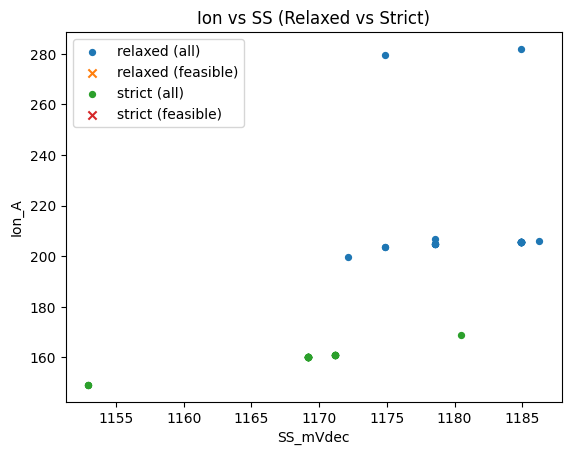

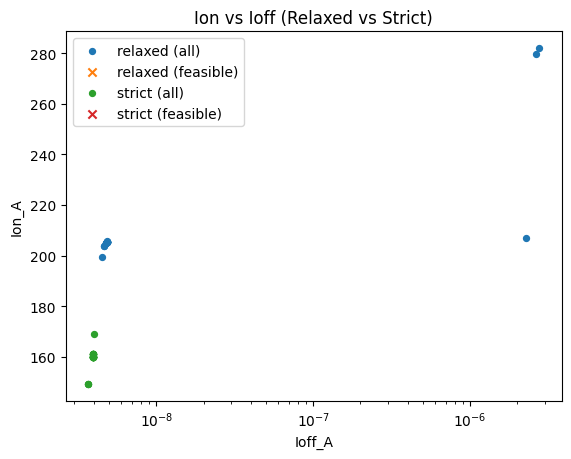

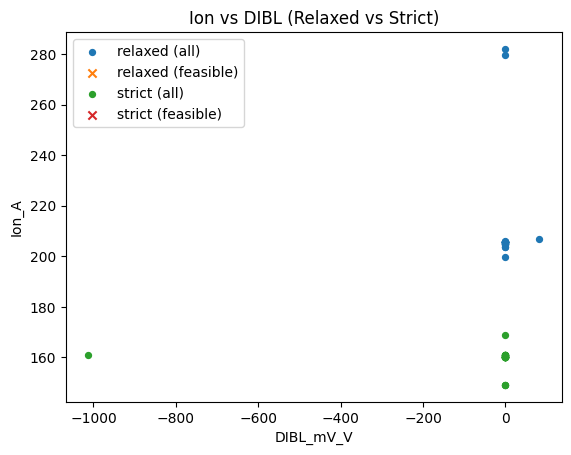

✅ wrote: /content/neighbor_validation_relaxed.csv
✅ wrote: /content/neighbor_validation_strict.csv

=== Neighbor validation summary (surrogate vs measurement) ===


name     MAE_Ion   MAPE_Ion  MAE_logIoff      MAE_SS  MAE_DIBL  \
0  relaxed  198.577887  34.731227      2.05323  639.454072       0.0   
1   strict  152.421779  67.406582      5.54869  840.143868       0.0   

   median_nn_dist  
0        3.571269  
1        4.455150


Relaxed: Pred vs Meas


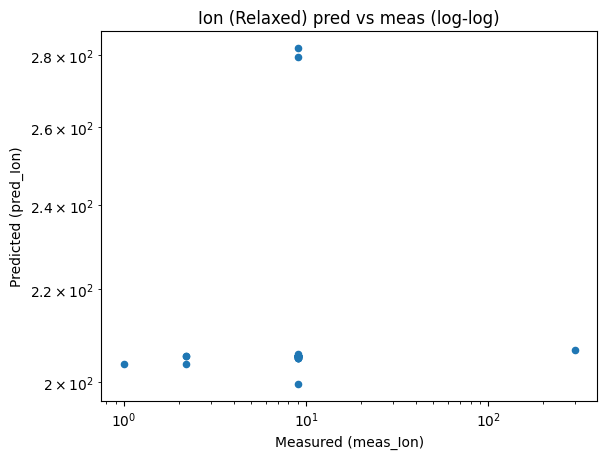

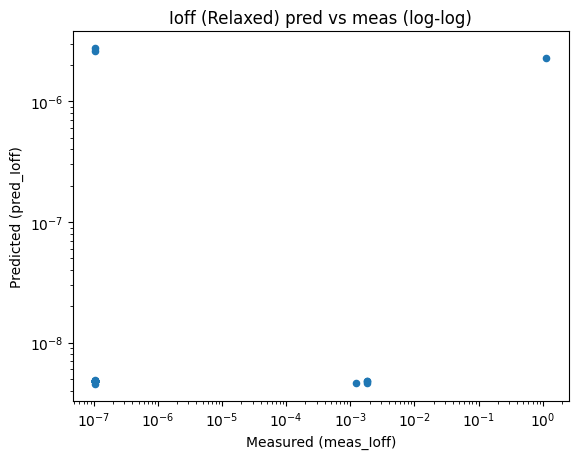


Strict: Pred vs Meas


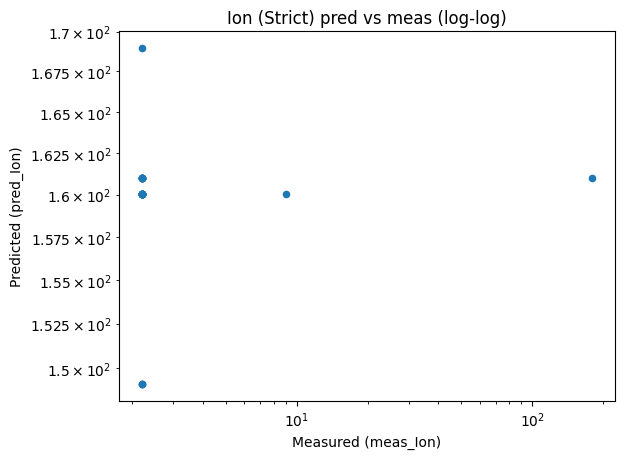

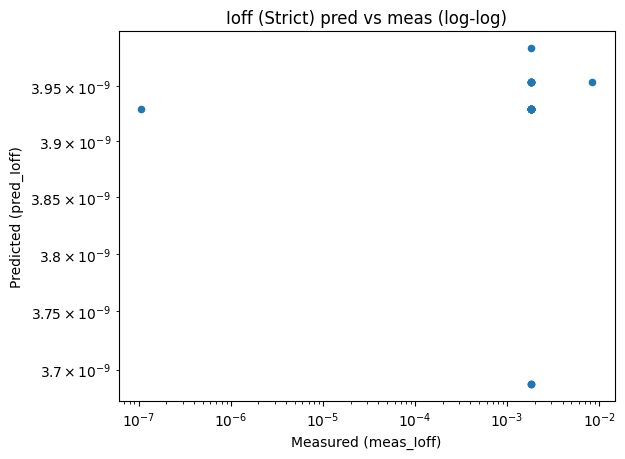

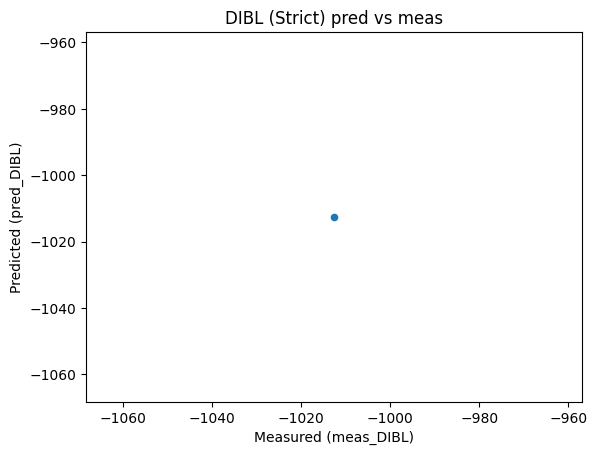


All key artifacts:
 - /content/curve_points.parquet
 - /content/curve_metrics_trueVth.csv
 - /content/dibl_true.csv
 - /content/reliability_dataset.csv
 - /content/surrogate_r2.json
 - /content/llm_reliability_results_relaxed.csv
 - /content/llm_reliability_results_strict.csv
 - /content/neighbor_validation_relaxed.csv
 - /content/neighbor_validation_strict.csv

Done.


In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE (END-TO-END)  ✅ FIXED ZENODO DOWNLOAD
# Ultra-scaled MoS2 transistor curves (Zenodo 10.5281/zenodo.14825422)
# - Download + unzip Figures.zip
# - Parse CSVs -> raw curve points
# - Build per-curve metrics: Ion, Ioff, Vth_true, SS_true
# - Compute per-family true DIBL from Vth vs Vds slope
# - Build unified reliability dataset
# - Train leak-free surrogate (group split by family_id)  ✅ handles NaN targets
# - Two-tier constraints (relaxed vs strict) + LLM-guided search (optional)
# - Neighbor validation: surrogate pred vs nearest measured curve
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, math, zipfile, random, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# ----------------------------
# 0) Repro
# ----------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)

# ----------------------------
# 1) Zenodo download ✅ FIXED
# ----------------------------
ZENODO_RECORD_ID = "14825422"
OUT_DIR = "/content/zenodo_data"
os.makedirs(OUT_DIR, exist_ok=True)

def zenodo_download_record(record_id: str, out_dir: str):
    """
    Robust Zenodo downloader:
    - uses official meta['files'][i]['links']['content'] URL directly
    - avoids buggy url concatenation causing /content/content 404
    """
    api = f"https://zenodo.org/api/records/{record_id}"
    r = requests.get(api, timeout=60)
    r.raise_for_status()
    meta = r.json()

    title = meta.get("metadata", {}).get("title", "")
    doi = meta.get("doi", "")
    pub = meta.get("metadata", {}).get("publication_date", "")
    kw = meta.get("metadata", {}).get("keywords", [])
    files = meta.get("files", [])

    print(f"Downloading: {doi}")
    print(f"Title: {title}")
    print(f"Keywords: {', '.join(kw)}")
    print(f"Publication date: {pub}")
    print(f"DOI: {doi}")

    local_paths = []
    for f in files:
        key = f.get("key") or f.get("filename")
        if not key:
            continue

        # ✅ The correct download URL is links.content
        url = f.get("links", {}).get("content", None)
        if url is None:
            # fallback: if only 'self' exists, try append /content safely once
            self_url = f.get("links", {}).get("self", "")
            if self_url.endswith("/content"):
                url = self_url
            else:
                url = self_url + "/content"

        dst = os.path.join(out_dir, key)

        # skip if exists and non-empty
        if os.path.exists(dst) and os.path.getsize(dst) > 0:
            print(f"{key} is already downloaded correctly.")
            local_paths.append(dst)
            continue

        print(f"Downloading {key} ...")
        rr = requests.get(url, stream=True, timeout=180)
        rr.raise_for_status()

        tmp = dst + ".part"
        with open(tmp, "wb") as wf:
            for chunk in rr.iter_content(chunk_size=1024 * 256):
                if chunk:
                    wf.write(chunk)
        os.replace(tmp, dst)
        print(f"Saved: {dst}")
        local_paths.append(dst)

    return local_paths

paths = zenodo_download_record(ZENODO_RECORD_ID, OUT_DIR)

# unzip Figures.zip (robust locate)
figzip = os.path.join(OUT_DIR, "Figures.zip")
if not os.path.exists(figzip):
    # sometimes different capitalization or name; search any .zip that contains "Figure"
    zips = []
    for fn in os.listdir(OUT_DIR):
        if fn.lower().endswith(".zip"):
            zips.append(os.path.join(OUT_DIR, fn))
    # prefer Figures.zip if present, else first zip
    if zips:
        figzip = zips[0]

if os.path.exists(figzip):
    print(f"Unzipping: {figzip}")
    with zipfile.ZipFile(figzip, "r") as zf:
        zf.extractall(OUT_DIR)
else:
    print("⚠️ Figures.zip not found after download. Check Zenodo record files list.")

# list CSVs
csv_paths = []
for root, _, files in os.walk(OUT_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

# ----------------------------
# 2) Helpers: robust parsing
# ----------------------------
def _to_float(x):
    try:
        if pd.isna(x): return np.nan
        if isinstance(x, str):
            x = x.strip().replace(",", "")
        return float(x)
    except Exception:
        return np.nan

def guess_cols(df):
    cols = [c.strip() for c in df.columns]
    low = [c.lower().strip() for c in cols]

    vg_cands  = ["vg", "vgs", "v_g", "gate", "vg(v)", "vgs(v)"]
    id_cands  = ["id", "ids", "i", "id/w", "ids/w", "id (a)", "ids (a)", "i_d", "current"]
    vds_cands = ["vds", "vd", "v_d", "drain", "vds(v)", "vd(v)"]

    def find_any(cands):
        for cand in cands:
            for i, c in enumerate(low):
                if cand == c:
                    return cols[i]
        for cand in cands:
            for i, c in enumerate(low):
                if cand in c:
                    return cols[i]
        return None

    vg  = find_any(vg_cands)
    idc = find_any(id_cands)
    vds = find_any(vds_cands)
    return vg, idc, vds

def safe_read_csv(path):
    try:
        df = pd.read_csv(path)
    except Exception:
        df = pd.read_csv(path, encoding_errors="ignore")
    df.columns = [str(c).strip() for c in df.columns]
    return df

def parse_vds_from_curve_col(df, vds_col):
    if vds_col and vds_col in df.columns:
        v = df[vds_col].map(_to_float).values
        med = np.nanmedian(v)
        if np.isfinite(med):
            return float(med)
    return np.nan

def family_id_from_path(path):
    fig = "Unknown"
    m = re.search(r"(Figure\s*\d+)", path)
    if m:
        fig = m.group(1).replace("  ", " ").strip()
    base = os.path.splitext(os.path.basename(path))[0].strip()
    base = re.sub(r"\s+", " ", base)
    return f"{fig}||{base}", fig, base

# ----------------------------
# 3) Extract raw points (curve_points.parquet)
# ----------------------------
def extract_points_from_csv(path):
    df = safe_read_csv(path)
    vg_col, id_col, vds_col = guess_cols(df)

    fam, fig, base = family_id_from_path(path)

    if vg_col is None or id_col is None:
        num_cols = []
        for c in df.columns:
            x = df[c].map(_to_float)
            if np.isfinite(x).sum() > max(10, len(df) * 0.2):
                num_cols.append(c)
        if len(num_cols) >= 2:
            vg_col = vg_col or num_cols[0]
            id_col = id_col or num_cols[1]

    if vg_col is None or id_col is None:
        return []

    points = []

    vgs = df[vg_col].map(_to_float).values
    if not np.isfinite(vgs).any():
        return []

    if vds_col and vds_col in df.columns:
        vds_vals = df[vds_col].map(_to_float).values
        key_v = np.round(vds_vals.astype(float), 2)
        uniq = pd.unique(key_v[np.isfinite(key_v)])
        for v in uniq:
            msk = (np.isfinite(key_v) & (key_v == v) & np.isfinite(vgs))
            if msk.sum() < 8:
                continue
            ids = df.loc[msk, id_col].map(_to_float).values
            curve_key = f"{fam}::vds={float(v):.2f}"
            for vg, idv in zip(vgs[msk], ids):
                if np.isfinite(vg) and np.isfinite(idv):
                    points.append([curve_key, fam, fig, base, path, float(v), float(vg), float(idv), vg_col, id_col])
        return points

    id_like_cols = []
    for c in df.columns:
        cl = c.lower()
        if ("id" in cl or "ids" in cl or "current" in cl) and c != vg_col:
            if np.isfinite(df[c].map(_to_float).values).sum() > max(10, len(df) * 0.1):
                id_like_cols.append(c)

    if len(id_like_cols) >= 2:
        for c in id_like_cols:
            ids = df[c].map(_to_float).values
            if np.isfinite(ids).sum() < 8:
                continue
            vds = np.nan
            mm = re.search(r"vds\s*=?\s*([-+]?\d*\.?\d+)", c.lower())
            if mm:
                vds = float(mm.group(1))
            curve_key = f"{fam}::{c}"
            for vg, idv in zip(vgs, ids):
                if np.isfinite(vg) and np.isfinite(idv):
                    points.append([curve_key, fam, fig, base, path, vds, float(vg), float(idv), vg_col, c])
        return points

    ids = df[id_col].map(_to_float).values
    if np.isfinite(ids).sum() < 8:
        return []
    curve_key = f"{fam}::single"
    vds = parse_vds_from_curve_col(df, vds_col)
    for vg, idv in zip(vgs, ids):
        if np.isfinite(vg) and np.isfinite(idv):
            points.append([curve_key, fam, fig, base, path, vds, float(vg), float(idv), vg_col, id_col])
    return points

all_pts = []
for p in csv_paths:
    all_pts.extend(extract_points_from_csv(p))

curve_points = pd.DataFrame(
    all_pts,
    columns=["curve_key","family_id","figure_id","base_name","source_file","vds_V","Vg_V","Id_A","vg_col","id_col"]
)

PTS_PARQ = "/content/curve_points.parquet"
curve_points.to_parquet(PTS_PARQ, index=False)
print(f"✅ Saved raw points: {PTS_PARQ} rows={len(curve_points):,}")

# ----------------------------
# 4) True metrics per curve
# ----------------------------
def compute_vth_true(vg, id_abs, frac=0.05):
    m = np.isfinite(vg) & np.isfinite(id_abs)
    vg = vg[m]; id_abs = id_abs[m]
    if len(vg) < 8:
        return np.nan, np.nan

    idx = np.argsort(vg)
    vg = vg[idx]; id_abs = id_abs[idx]

    Ion = float(np.nanmax(id_abs))
    Ioff = float(np.nanmin(id_abs))
    if not (np.isfinite(Ion) and np.isfinite(Ioff)):
        return np.nan, np.nan
    if Ion <= Ioff:
        return np.nan, np.nan

    Id_ref = Ioff + frac*(Ion - Ioff)
    above = id_abs >= Id_ref
    if not np.any(above):
        return np.nan, float(Id_ref)
    j = int(np.argmax(above))
    if j == 0:
        return float(vg[0]), float(Id_ref)

    x0, y0 = vg[j-1], id_abs[j-1]
    x1, y1 = vg[j], id_abs[j]
    if y1 == y0:
        return float(x1), float(Id_ref)
    t = (Id_ref - y0) / (y1 - y0)
    vth = x0 + t*(x1 - x0)
    return float(vth), float(Id_ref)

def compute_ss_true(vg, id_abs, vth, window_V=0.25, min_pts=6):
    if not np.isfinite(vth):
        return np.nan
    m = np.isfinite(vg) & np.isfinite(id_abs) & (id_abs > 0)
    vg = vg[m]; id_abs = id_abs[m]
    if len(vg) < 8:
        return np.nan

    idx = np.argsort(vg)
    vg = vg[idx]; id_abs = id_abs[idx]

    w = (vg >= vth - window_V) & (vg <= vth + window_V)
    if w.sum() < min_pts:
        return np.nan

    x = vg[w]
    y = np.log10(id_abs[w])

    A = np.vstack([x, np.ones_like(x)]).T
    coef, *_ = np.linalg.lstsq(A, y, rcond=None)
    slope = coef[0]
    if not np.isfinite(slope) or abs(slope) < 1e-12:
        return np.nan
    ss = 1000.0 / slope
    return float(abs(ss))

rows = []
for ck, g in curve_points.groupby("curve_key"):
    fam = g["family_id"].iloc[0]
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    src = g["source_file"].iloc[0]
    vds = float(np.nanmedian(g["vds_V"].values)) if np.isfinite(np.nanmedian(g["vds_V"].values)) else np.nan

    vg = g["Vg_V"].values.astype(float)
    idv = g["Id_A"].values.astype(float)
    id_abs = np.abs(idv)

    Ion = float(np.nanmax(id_abs)) if np.isfinite(id_abs).any() else np.nan
    Ioff = float(np.nanmin(id_abs)) if np.isfinite(id_abs).any() else np.nan

    vth, Id_ref = compute_vth_true(vg, id_abs, frac=0.05)
    ss = compute_ss_true(vg, id_abs, vth, window_V=0.25, min_pts=6)

    vg_min = float(np.nanmin(vg)) if np.isfinite(vg).any() else np.nan
    vg_max = float(np.nanmax(vg)) if np.isfinite(vg).any() else np.nan
    npts = int(np.isfinite(vg).sum())

    rows.append({
        "curve_key": ck,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "source_file": src,
        "vds_V": vds,
        "Vg_min_V": vg_min,
        "Vg_max_V": vg_max,
        "Vg_span_V": vg_max - vg_min if (np.isfinite(vg_max) and np.isfinite(vg_min)) else np.nan,
        "n_points": npts,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "Id_ref_A": Id_ref,
        "Vth_true_V": vth,
        "SS_true_mVdec": ss,
    })

curve_metrics = pd.DataFrame(rows)
METRICS_CSV = "/content/curve_metrics_trueVth.csv"
curve_metrics.to_csv(METRICS_CSV, index=False)
print(f"✅ Saved per-curve metrics: {METRICS_CSV} curves={len(curve_metrics)}")

# ----------------------------
# 5) True DIBL per family
# ----------------------------
dibl_rows = []
for fam, g in curve_metrics.groupby("family_id"):
    gg = g.copy()
    gg = gg[np.isfinite(gg["vds_V"].values)]
    gg = gg[np.isfinite(gg["Vth_true_V"].values)]
    if len(gg) < 8:
        continue

    gg["vds_bin"] = np.round(gg["vds_V"].values.astype(float), 2)
    med = gg.groupby("vds_bin")["Vth_true_V"].median().reset_index()
    if len(med) < 3:
        continue

    x = med["vds_bin"].values.astype(float)
    y = med["Vth_true_V"].values.astype(float)

    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    dibl_mV_per_V = -a * 1000.0

    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    dibl_rows.append({
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "n_curves": int(len(g)),
        "vds_min": float(np.nanmin(gg["vds_V"].values)),
        "vds_max": float(np.nanmax(gg["vds_V"].values)),
        "Vth_slope_V_per_V": float(a),
        "DIBL_true_mV_per_V": float(dibl_mV_per_V),
    })

dibl_true = pd.DataFrame(dibl_rows)
DIBL_CSV = "/content/dibl_true.csv"
dibl_true.to_csv(DIBL_CSV, index=False)
print(f"✅ Saved true DIBL: {DIBL_CSV} rows={len(dibl_true)}")
if len(dibl_true):
    display(dibl_true.head(10))

# ----------------------------
# 6) Unified dataset
# ----------------------------
ds = curve_metrics.merge(
    dibl_true[["family_id","DIBL_true_mV_per_V"]],
    on="family_id", how="left"
)

ds["Ion_A"] = ds["Ion_A"].astype(float)
ds["Ioff_A"] = ds["Ioff_A"].astype(float)
ds["log_Ion"] = np.log10(np.maximum(ds["Ion_A"].values, 1e-30))
ds["log_Ioff"] = np.log10(np.maximum(ds["Ioff_A"].values, 1e-30))

ds = ds[np.isfinite(ds["log_Ion"].values) & np.isfinite(ds["log_Ioff"].values)].copy()

REL_CSV = "/content/reliability_dataset.csv"
ds.to_csv(REL_CSV, index=False)
print(f"✅ Saved unified dataset: {REL_CSV} rows={len(ds)}")

# ----------------------------
# 7) Surrogate model (leak-free)
# ----------------------------
FEATURES_NUM = ["Vg_min_V","Vg_max_V","vds_V"]
FEATURES_CAT = ["family_id"]
ALL_FEATURES = FEATURES_NUM + FEATURES_CAT

def make_model():
    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), FEATURES_CAT),
            ("num", "passthrough", FEATURES_NUM),
        ]
    )
    reg = RandomForestRegressor(
        n_estimators=400,
        random_state=SEED,
        n_jobs=-1,
        min_samples_leaf=2,
    )
    return Pipeline([("pre", pre), ("reg", reg)])

train_ds = ds.copy()
for c in FEATURES_NUM:
    train_ds[c] = train_ds[c].astype(float)
train_ds = train_ds[np.isfinite(train_ds["Vg_min_V"]) & np.isfinite(train_ds["Vg_max_V"])].copy()
train_ds["vds_V"] = train_ds["vds_V"].astype(float).fillna(0.0)

def fit_and_eval(target_col: str):
    X_all = train_ds[ALL_FEATURES].copy()
    y_all = train_ds[target_col].astype(float).values

    m = np.isfinite(y_all)
    X = X_all.loc[m].reset_index(drop=True)
    y = y_all[m]
    groups = train_ds.loc[m, "family_id"].values

    if len(y) < 20 or len(np.unique(groups)) < 2:
        model = make_model()
        model.fit(X, y)
        return model, float("nan")

    gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    model = make_model()
    model.fit(X.iloc[tr_idx], y[tr_idx])

    pred = model.predict(X.iloc[te_idx])
    score = r2_score(y[te_idx], pred) if np.isfinite(y[te_idx]).sum() > 2 else float("nan")
    return model, float(score)

models = {}
r2s = {}
for tgt in ["log_Ion", "log_Ioff", "SS_true_mVdec"]:
    model, r2 = fit_and_eval(tgt)
    models[tgt] = model
    r2s[tgt] = r2

R2_JSON = "/content/surrogate_r2.json"
with open(R2_JSON, "w") as f:
    json.dump(r2s, f, indent=2)

print("✅ Surrogate R^2 (leak-free):", r2s)
print("✅ Saved R^2:", R2_JSON)

fam_dibl = dict(zip(dibl_true["family_id"], dibl_true["DIBL_true_mV_per_V"])) if len(dibl_true) else {}
def get_family_dibl(fam):
    v = fam_dibl.get(fam, 0.0)
    return float(v) if np.isfinite(v) else 0.0

# ----------------------------
# 8) Predictor using surrogate + family DIBL
# ----------------------------
def predict(family_id, vg_min, vg_max, vds):
    X = pd.DataFrame([{
        "family_id": family_id,
        "Vg_min_V": float(vg_min),
        "Vg_max_V": float(vg_max),
        "vds_V": float(vds),
    }])
    logIon = float(models["log_Ion"].predict(X)[0])
    logIoff = float(models["log_Ioff"].predict(X)[0])
    ss = float(models["SS_true_mVdec"].predict(X)[0]) if "SS_true_mVdec" in models else np.nan

    Ion = float(10**logIon)
    Ioff = float(10**logIoff)
    dibl = get_family_dibl(family_id)

    return {
        "log_Ion": logIon,
        "log_Ioff": logIoff,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "SS_mVdec": ss,
        "DIBL_mV_V": dibl,
    }

VG_LO = float(np.nanpercentile(train_ds["Vg_min_V"].values, 1))
VG_HI = float(np.nanpercentile(train_ds["Vg_max_V"].values, 99))
VDS_LO = float(np.nanmin(train_ds["vds_V"].values)) if len(train_ds) else 0.0
VDS_HI = float(np.nanmax(train_ds["vds_V"].values)) if len(train_ds) else 2.0
if not np.isfinite(VDS_LO): VDS_LO = 0.0
if not np.isfinite(VDS_HI): VDS_HI = 2.0

# ----------------------------
# 9) Two-tier constraints (quantiles)
# ----------------------------
def make_constraints(ds_in, tier="relaxed"):
    if tier == "relaxed":
        ss_q, ioff_q, dibl_q = 0.35, 0.35, 0.70
    elif tier == "strict":
        ss_q, ioff_q, dibl_q = 0.25, 0.25, 0.50
    else:
        raise ValueError("tier must be relaxed or strict")

    SS_vals = ds_in["SS_true_mVdec"].values.astype(float)
    SS_MAX_ = float(np.nanpercentile(SS_vals[np.isfinite(SS_vals)], ss_q*100)) if np.isfinite(SS_vals).any() else float("inf")

    logioff = ds_in["log_Ioff"].values.astype(float)
    IOFF_MAX_ = float(10**np.nanpercentile(logioff[np.isfinite(logioff)], ioff_q*100)) if np.isfinite(logioff).any() else float("inf")

    dibl_abs = np.abs(ds_in["DIBL_true_mV_per_V"].values.astype(float))
    DIBL_MAX_ = float(np.nanpercentile(dibl_abs[np.isfinite(dibl_abs)], dibl_q*100)) if np.isfinite(dibl_abs).any() else float("inf")
    return {"tier": tier, "SS_MAX": SS_MAX_, "IOFF_MAX": IOFF_MAX_, "DIBL_MAX": DIBL_MAX_}

constraints_relaxed = make_constraints(train_ds, "relaxed")
constraints_strict  = make_constraints(train_ds, "strict")
print("Two-tier constraints:")
print(constraints_relaxed)
print(constraints_strict)

# ----------------------------
# 10) LLM-guided search (OPTIONAL)
# ----------------------------
USE_LLM = True
N_ROUNDS = 30
TEMPERATURE = 0.3
SEED_TRIALS = 120

LLM_MODEL = os.getenv("LLM_MODEL", "openai/gpt-4.1")

SYSTEM_JSON = """Return ONLY JSON with keys:
family_id, Vg_min_V, Vg_max_V, vds_V
Rules:
- family_id must be one of the provided options
- Vg_min_V < Vg_max_V
- stay within bounds
No prose.
"""

def parse_json(s):
    s = s.strip()
    m = re.search(r"\{.*\}", s, flags=re.S)
    if m:
        s = m.group(0)
    return json.loads(s)

def utility_from_pred(pred):
    return (1.2*pred["log_Ion"] - 1.0*pred["log_Ioff"] - 0.0035*pred["SS_mVdec"] - 0.0015*abs(pred["DIBL_mV_V"]))

def predict_with_constraints(fam, vg_min, vg_max, vds, C):
    out = predict(fam, vg_min, vg_max, vds)
    feasible = (out["SS_mVdec"] <= C["SS_MAX"]) and (out["Ioff_A"] <= C["IOFF_MAX"]) and (abs(out["DIBL_mV_V"]) <= C["DIBL_MAX"])
    out["feasible"] = bool(feasible)
    out["utility"] = float(utility_from_pred(out))
    return out

FAMS_ALL = sorted(train_ds["family_id"].unique().tolist())

client = None
if USE_LLM:
    try:
        from openai import OpenAI
        base_url = os.getenv("OPENAI_BASE_URL", None)
        api_key = os.getenv("OPENAI_API_KEY", None)

        if api_key is None and os.getenv("OPENROUTER_API_KEY"):
            api_key = os.getenv("OPENROUTER_API_KEY")
            base_url = os.getenv("OPENROUTER_BASE_URL", "https://openrouter.ai/api/v1")

        if api_key is None:
            print("⚠️ USE_LLM=True but no API key found. Set OPENAI_API_KEY or OPENROUTER_API_KEY. Falling back to random search.")
            USE_LLM = False
        else:
            client = OpenAI(api_key=api_key, base_url=base_url) if base_url else OpenAI(api_key=api_key)
    except Exception as e:
        print("⚠️ Failed to init OpenAI client:", repr(e))
        print("Falling back to random search.")
        USE_LLM = False

def run_search(C, n_rounds=30, temperature=0.3, seed_trials=120):
    best_cand = None
    best_pred = None
    for _ in range(seed_trials):
        fam = random.choice(FAMS_ALL)
        vmin = random.uniform(VG_LO, VG_HI-0.4)
        vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
        vds  = random.uniform(VDS_LO, VDS_HI)
        pred0 = predict_with_constraints(fam, vmin, vmax, vds, C)
        if (best_pred is None) or (pred0["utility"] > best_pred["utility"]):
            best_cand = {"family_id": fam, "Vg_min_V": float(vmin), "Vg_max_V": float(vmax), "vds_V": float(vds)}
            best_pred = pred0

    rows = []
    feedback = None

    for r in tqdm(range(n_rounds), desc=f"Search rounds ({C['tier']})"):
        if USE_LLM and client is not None:
            prompt = f"""family_id options (ALL): {FAMS_ALL}
Bounds:
- Vg_min_V, Vg_max_V in [{VG_LO:.3f}, {VG_HI:.3f}]
- vds_V in [{VDS_LO:.3f}, {VDS_HI:.3f}]
Constraints ({C['tier']}):
- SS <= {C['SS_MAX']:.3f} mV/dec
- Ioff <= {C['IOFF_MAX']:.3e} A
- |DIBL| <= {C['DIBL_MAX']:.3f} mV/V

Goal: maximize Ion, minimize Ioff, SS, and |DIBL|.
Hard rule: propose a point that differs from seed by at least one of:
|ΔVg_min|>0.05 OR |ΔVg_max|>0.05 OR |Δvds|>0.05 OR family_id changes.

Seed (current best): {json.dumps(best_cand)}
"""
            if feedback:
                prompt += f"\nLast evaluation feedback: {json.dumps(feedback)}"

            cand = None
            try:
                resp = client.chat.completions.create(
                    model=LLM_MODEL,
                    messages=[{"role":"system","content":SYSTEM_JSON},
                              {"role":"user","content":prompt}],
                    temperature=temperature,
                )
                cand = parse_json(resp.choices[0].message.content)
            except Exception:
                cand = None
        else:
            cand = None

        if cand is None:
            fam = random.choice(FAMS_ALL)
            vmin = random.uniform(VG_LO, VG_HI-0.4)
            vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
            vds  = random.uniform(VDS_LO, VDS_HI)
            cand = {"family_id": fam, "Vg_min_V": float(vmin), "Vg_max_V": float(vmax), "vds_V": float(vds)}

        fam = cand["family_id"] if cand.get("family_id") in FAMS_ALL else random.choice(FAMS_ALL)
        vmin = float(cand["Vg_min_V"]); vmax = float(cand["Vg_max_V"]); vds = float(cand["vds_V"])
        vmin = float(np.clip(vmin, VG_LO, VG_HI-0.2))
        vmax = float(np.clip(vmax, vmin+0.05, VG_HI))
        vds  = float(np.clip(vds, VDS_LO, VDS_HI))

        pred1 = predict_with_constraints(fam, vmin, vmax, vds, C)

        row = {"tier": C["tier"], "round": int(r), "family_id": fam, "Vg_min_V": vmin, "Vg_max_V": vmax, "vds_V": vds, **pred1}
        rows.append(row)

        if pred1["utility"] > best_pred["utility"]:
            best_cand = {"family_id": fam, "Vg_min_V": vmin, "Vg_max_V": vmax, "vds_V": vds}
            best_pred = pred1

        feedback = {k: row[k] for k in ["Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]}

    res = pd.DataFrame(rows)
    best_row = {"tier": C["tier"], **best_cand, **best_pred}
    return res, best_row

res_relaxed, best_relaxed = run_search(constraints_relaxed, n_rounds=N_ROUNDS, temperature=TEMPERATURE, seed_trials=SEED_TRIALS)
res_strict,  best_strict  = run_search(constraints_strict,  n_rounds=N_ROUNDS, temperature=TEMPERATURE, seed_trials=SEED_TRIALS)

def best_compact(best):
    keys = ["tier","family_id","Vg_min_V","Vg_max_V","vds_V","Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]
    return {k: (best.get(k, None)) for k in keys}

print("\nBest (relaxed):", best_compact(best_relaxed))
print("Best (strict): ", best_compact(best_strict))

RELAXED_CSV = "/content/llm_reliability_results_relaxed.csv"
STRICT_CSV  = "/content/llm_reliability_results_strict.csv"
res_relaxed.to_csv(RELAXED_CSV, index=False)
res_strict.to_csv(STRICT_CSV, index=False)
print("✅ wrote:", RELAXED_CSV)
print("✅ wrote:", STRICT_CSV)

def summarize_res(res, C):
    n = len(res)
    n_feas = int(res["feasible"].sum()) if n else 0
    frac = n_feas / max(n,1)
    util_best = float(res["utility"].max()) if n else float("nan")
    util_best_feas = float(res.loc[res["feasible"], "utility"].max()) if n_feas>0 else float("nan")
    ion_med_feas = float(np.nanmedian(res.loc[res["feasible"], "Ion_A"])) if n_feas>0 else float("nan")
    ioff_med_feas = float(np.nanmedian(res.loc[res["feasible"], "Ioff_A"])) if n_feas>0 else float("nan")
    ss_med_feas = float(np.nanmedian(res.loc[res["feasible"], "SS_mVdec"])) if n_feas>0 else float("nan")
    dibl_med_feas = float(np.nanmedian(np.abs(res.loc[res["feasible"], "DIBL_mV_V"]))) if n_feas>0 else float("nan")
    return {
        "tier": C["tier"],
        "SS_MAX": C["SS_MAX"],
        "IOFF_MAX": C["IOFF_MAX"],
        "DIBL_MAX": C["DIBL_MAX"],
        "n": n,
        "n_feasible": n_feas,
        "feasible_rate": frac,
        "best_utility_any": util_best,
        "best_utility_feasible": util_best_feas,
        "median_Ion_feasible": ion_med_feas,
        "median_Ioff_feasible": ioff_med_feas,
        "median_SS_feasible": ss_med_feas,
        "median_|DIBL|_feasible": dibl_med_feas,
    }

summary_df = pd.DataFrame([
    summarize_res(res_relaxed, constraints_relaxed),
    summarize_res(res_strict, constraints_strict),
])
print("\n=== Two-tier summary ===")
display(summary_df)

def plot_compare(resA, resB, xcol, xscale=None, yscale=None, title=""):
    plt.figure()
    plt.scatter(resA[xcol], resA["Ion_A"], s=18, label=f"{resA['tier'].iloc[0]} (all)")
    plt.scatter(resA.loc[resA["feasible"], xcol], resA.loc[resA["feasible"], "Ion_A"], s=35, marker="x", label=f"{resA['tier'].iloc[0]} (feasible)")
    plt.scatter(resB[xcol], resB["Ion_A"], s=18, label=f"{resB['tier'].iloc[0]} (all)")
    plt.scatter(resB.loc[resB["feasible"], xcol], resB.loc[resB["feasible"], "Ion_A"], s=35, marker="x", label=f"{resB['tier'].iloc[0]} (feasible)")
    if xscale: plt.xscale(xscale)
    if yscale: plt.yscale(yscale)
    plt.xlabel(xcol)
    plt.ylabel("Ion_A")
    plt.title(title or f"Ion vs {xcol} (two tiers)")
    plt.legend()
    plt.show()

plot_compare(res_relaxed, res_strict, "SS_mVdec", title="Ion vs SS (Relaxed vs Strict)")
plot_compare(res_relaxed, res_strict, "Ioff_A", xscale="log", title="Ion vs Ioff (Relaxed vs Strict)")
plot_compare(res_relaxed, res_strict, "DIBL_mV_V", title="Ion vs DIBL (Relaxed vs Strict)")

# ----------------------------
# 11) Neighbor validation
# ----------------------------
real_tbl = ds.copy()
real_tbl["vds_V"] = real_tbl["vds_V"].astype(float).fillna(0.0)

W_VMIN, W_VMAX, W_VDS = 1.0, 1.0, 3.0
EPS = 1e-12

def nearest_real(row, real_tbl):
    fam = row["family_id"]
    g = real_tbl[real_tbl["family_id"] == fam]
    if len(g) == 0:
        g = real_tbl

    dvmin = (g["Vg_min_V"].values.astype(float) - float(row["Vg_min_V"]))
    dvmax = (g["Vg_max_V"].values.astype(float) - float(row["Vg_max_V"]))
    dvds  = (g["vds_V"].values.astype(float)  - float(row["vds_V"]))
    dist = (W_VMIN*dvmin*dvmin + W_VMAX*dvmax*dvmax + W_VDS*dvds*dvds)
    j = int(np.argmin(dist))
    nn = g.iloc[j]
    return nn, float(dist[j])

def validate(res, name=""):
    vals = []
    for _, r in res.iterrows():
        nn, dist = nearest_real(r, real_tbl)

        meas_Ion  = float(nn["Ion_A"])
        meas_Ioff = float(nn["Ioff_A"])
        meas_SS   = float(nn["SS_true_mVdec"]) if np.isfinite(nn["SS_true_mVdec"]) else np.nan
        meas_DIBL = float(nn["DIBL_true_mV_per_V"]) if np.isfinite(nn.get("DIBL_true_mV_per_V", np.nan)) else np.nan

        pred_Ion  = float(r["Ion_A"])
        pred_Ioff = float(r["Ioff_A"])
        pred_SS   = float(r["SS_mVdec"]) if np.isfinite(r["SS_mVdec"]) else np.nan
        pred_DIBL = float(r["DIBL_mV_V"]) if np.isfinite(r["DIBL_mV_V"]) else np.nan

        vals.append({
            "tier": r["tier"],
            "round": int(r["round"]),
            "family_id": r["family_id"],
            "Vg_min_V": float(r["Vg_min_V"]),
            "Vg_max_V": float(r["Vg_max_V"]),
            "vds_V": float(r["vds_V"]),
            "feasible": bool(r["feasible"]),
            "utility": float(r["utility"]),
            "nn_curve_key": str(nn.get("curve_key","")),
            "nn_dist": dist,
            "pred_Ion": pred_Ion, "meas_Ion": meas_Ion,
            "pred_Ioff": pred_Ioff, "meas_Ioff": meas_Ioff,
            "pred_SS": pred_SS, "meas_SS": meas_SS,
            "pred_DIBL": pred_DIBL, "meas_DIBL": meas_DIBL,
        })

    vdf = pd.DataFrame(vals)

    def mae(a,b):
        a=np.asarray(a); b=np.asarray(b)
        m = np.isfinite(a) & np.isfinite(b)
        return float(np.nanmean(np.abs(a[m]-b[m]))) if m.any() else float("nan")

    def mape(a,b):
        a=np.asarray(a); b=np.asarray(b)
        m = np.isfinite(a) & np.isfinite(b)
        return float(np.nanmean(np.abs(a[m]-b[m]) / np.maximum(np.abs(b[m]), EPS))) if m.any() else float("nan")

    report = {
        "name": name,
        "MAE_Ion": mae(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAPE_Ion": mape(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAE_logIoff": mae(np.log10(np.maximum(vdf["pred_Ioff"],1e-30)), np.log10(np.maximum(vdf["meas_Ioff"],1e-30))),
        "MAE_SS": mae(vdf["pred_SS"], vdf["meas_SS"]),
        "MAE_DIBL": mae(vdf["pred_DIBL"], vdf["meas_DIBL"]),
        "median_nn_dist": float(np.nanmedian(vdf["nn_dist"])) if len(vdf) else float("nan"),
    }
    return vdf, report

val_relaxed, rep_relaxed = validate(res_relaxed, name="relaxed")
val_strict,  rep_strict  = validate(res_strict,  name="strict")

VAL_RELAXED_CSV = "/content/neighbor_validation_relaxed.csv"
VAL_STRICT_CSV  = "/content/neighbor_validation_strict.csv"
val_relaxed.to_csv(VAL_RELAXED_CSV, index=False)
val_strict.to_csv(VAL_STRICT_CSV, index=False)
print("✅ wrote:", VAL_RELAXED_CSV)
print("✅ wrote:", VAL_STRICT_CSV)

rep_df = pd.DataFrame([rep_relaxed, rep_strict])
print("\n=== Neighbor validation summary (surrogate vs measurement) ===")
display(rep_df)

def pred_vs_meas_plot(vdf, pred_col, meas_col, logx=False, logy=False, title=""):
    plt.figure()
    x = vdf[meas_col].values
    y = vdf[pred_col].values
    plt.scatter(x, y, s=20)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    if (not logx) and (not logy):
        m = np.isfinite(x) & np.isfinite(y)
        if m.any():
            mn = float(np.min([x[m].min(), y[m].min()]))
            mx = float(np.max([x[m].max(), y[m].max()]))
            plt.plot([mn,mx],[mn,mx], linestyle="--")
    plt.xlabel(f"Measured ({meas_col})")
    plt.ylabel(f"Predicted ({pred_col})")
    plt.title(title or f"{pred_col} vs {meas_col}")
    plt.show()

print("\nRelaxed: Pred vs Meas")
pred_vs_meas_plot(val_relaxed, "pred_Ion","meas_Ion", logx=True, logy=True, title="Ion (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_Ioff","meas_Ioff", logx=True, logy=True, title="Ioff (Relaxed) pred vs meas (log-log)")
pred_vs_meas_plot(val_relaxed, "pred_SS","meas_SS", title="SS (Relaxed) pred vs meas")
pred_vs_meas_plot(val_relaxed, "pred_DIBL","meas_DIBL", title="DIBL (Relaxed) pred vs meas")

print("\nStrict: Pred vs Meas")
pred_vs_meas_plot(val_strict, "pred_Ion","meas_Ion", logx=True, logy=True, title="Ion (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_Ioff","meas_Ioff", logx=True, logy=True, title="Ioff (Strict) pred vs meas (log-log)")
pred_vs_meas_plot(val_strict, "pred_SS","meas_SS", title="SS (Strict) pred vs meas")
pred_vs_meas_plot(val_strict, "pred_DIBL","meas_DIBL", title="DIBL (Strict) pred vs meas")

print("\nAll key artifacts:")
print(" -", PTS_PARQ)
print(" -", METRICS_CSV)
print(" -", DIBL_CSV)
print(" -", REL_CSV)
print(" -", R2_JSON)
print(" -", RELAXED_CSV)
print(" -", STRICT_CSV)
print(" -", VAL_RELAXED_CSV)
print(" -", VAL_STRICT_CSV)
print("\nDone.")


In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE (END-TO-END)
# Ultra-scaled MoS2 transistor curves (Zenodo 10.5281/zenodo.14825422)
# - Download + unzip Figures.zip
# - Parse CSVs -> raw curve points
# - Build per-curve metrics: Ion, Ioff, Vth_true, SS_true
# - Compute per-family true DIBL from Vth vs Vds slope
# - Build unified reliability dataset
# - Train leak-free surrogate (group split by family_id)  ✅ handles NaN targets
# - Two-tier constraints (relaxed vs strict) + search
# - Neighbor validation: surrogate pred vs nearest measured curve
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, math, zipfile, random, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------
# 0) Config
# -----------------------------
ZENODO_DOI = "10.5281/zenodo.14825422"
BASE_DIR = "/content/zenodo_data"
FIG_ZIP = os.path.join(BASE_DIR, "Figures.zip")
README_PDF = os.path.join(BASE_DIR, "Readme.pdf")

# Direct file URLs (Zenodo)
FIG_URL = f"https://zenodo.org/record/14825422/files/Figures.zip?download=1"
README_URL = f"https://zenodo.org/record/14825422/files/Readme.pdf?download=1"

os.makedirs(BASE_DIR, exist_ok=True)

def download_if_needed(url, path):
    if os.path.exists(path) and os.path.getsize(path) > 1024:
        print(f"{os.path.basename(path)} is already downloaded correctly.")
        return
    print(f"Downloading -> {path}")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True) as pbar:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

print(f"Downloading: {ZENODO_DOI}")
print("Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography")
print("DOI:", ZENODO_DOI)

download_if_needed(FIG_URL, FIG_ZIP)
download_if_needed(README_URL, README_PDF)

# -----------------------------
# 1) Unzip Figures.zip
# -----------------------------
print("Unzipping:", FIG_ZIP)
with zipfile.ZipFile(FIG_ZIP, "r") as z:
    z.extractall(BASE_DIR)

# list csvs
csv_paths = []
for root, _, files in os.walk(BASE_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths[:30]:
    print(" -", p)
if len(csv_paths) > 30:
    print(" ...")

# -----------------------------
# 2) Helpers: parse figure_id and basic metadata from filename
# -----------------------------
def norm_path(p):
    return p.replace("\\", "/")

def infer_figure_id(p):
    p2 = norm_path(p)
    m = re.search(r"/(Figure\s*\d+)\b", p2, flags=re.IGNORECASE)
    if m:
        return m.group(1).replace("  ", " ").strip()
    # fallback: parent dir name
    return os.path.basename(os.path.dirname(p2))

def base_name_from_file(p):
    fn = os.path.splitext(os.path.basename(p))[0]
    return fn.strip()

def family_id_from_path(p):
    # family = Figure folder + filename base (usually corresponds to a panel)
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    return f"{fig}||{base}"

# -----------------------------
# 3) Read CSV robustly: detect two numeric columns
# -----------------------------
def read_csv_two_cols(path):
    # Try different separators/encodings; keep numeric columns
    df = None
    for sep in [",", ";", "\t"]:
        try:
            df_try = pd.read_csv(path, sep=sep)
            if df_try.shape[1] >= 2:
                df = df_try
                break
        except Exception:
            continue
    if df is None:
        # last resort
        df = pd.read_csv(path, engine="python")

    # Keep only numeric columns
    num = df.apply(pd.to_numeric, errors="coerce")
    # Find best 2 columns: those with most finite values
    counts = num.notna().sum(axis=0).values
    idx = np.argsort(-counts)[:2]
    c1, c2 = num.columns[idx[0]], num.columns[idx[1]]
    x = num[c1].astype(float).values
    y = num[c2].astype(float).values

    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    return x, y, str(c1), str(c2)

def guess_axis_semantics(fig_id, base_name, colx, coly):
    """
    Heuristic to guess what columns mean.
    We'll store as generic (x, y), and later attempt to infer Vg/Id or Vd/Id etc.
    """
    s = (fig_id + " " + base_name + " " + colx + " " + coly).lower()
    # Likely transfer curve: x=Vg, y=Id
    if any(k in s for k in ["vg", "gate", "vgs", "v_g"]) and any(k in s for k in ["id", "i", "current"]):
        return "Vg_V", "Id_A"
    # Likely output curve: x=Vd, y=Id
    if any(k in s for k in ["vd", "vds", "drain", "v_d"]) and any(k in s for k in ["id", "i", "current"]):
        return "Vds_V", "Id_A"
    # Fallback: still often transfer/output
    # Use figure-based guess: Figure 2/3 often transfer; but not guaranteed
    if any(k in s for k in ["transfer", "sweep", "gate"]):
        return "Vg_V", "Id_A"
    if any(k in s for k in ["output", "drain"]):
        return "Vds_V", "Id_A"
    # Default assume x is voltage, y is current
    return "Vx", "Iy"

# -----------------------------
# 4) Parse all CSVs into raw curve points
# -----------------------------
rows = []
for p in tqdm(csv_paths, desc="Parsing CSVs"):
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    fam = family_id_from_path(p)

    x, y, cx, cy = read_csv_two_cols(p)
    ax_x, ax_y = guess_axis_semantics(fig, base, cx, cy)

    # store each file as a "curve" candidate; we will later split into multiple curves
    # if a file contains multiple sweeps concatenated, we attempt to segment by discontinuities
    # segmentation: split where x jumps backward significantly
    if len(x) < 10:
        continue

    # sort by original order, but we can detect segments in order
    x_arr, y_arr = x, y
    # segmentation threshold:
    dx = np.diff(x_arr)
    # where dx is strongly negative indicates new sweep
    cut_idx = np.where(dx < -0.5 * np.nanstd(x_arr) - 1e-9)[0] + 1
    cuts = [0] + cut_idx.tolist() + [len(x_arr)]
    segs = [(cuts[i], cuts[i+1]) for i in range(len(cuts)-1) if cuts[i+1]-cuts[i] >= 10]

    for si, (a, b) in enumerate(segs):
        segx = x_arr[a:b]
        segy = y_arr[a:b]
        curve_id = f"{fam}::seg{si:02d}"
        for xi, yi in zip(segx, segy):
            rows.append({
                "figure_id": fig,
                "base_name": base,
                "family_id": fam,
                "curve_id": curve_id,
                "axis_x": ax_x,
                "axis_y": ax_y,
                "x": float(xi),
                "y": float(yi),
                "source_csv": norm_path(p),
            })

curve_points = pd.DataFrame(rows)
print(f"✅ Saved raw points: /content/curve_points.parquet rows={len(curve_points):,}")
curve_points.to_parquet("/content/curve_points.parquet", index=False)

# -----------------------------
# 5) Metric extraction from transfer-like curves (Vg vs Id)
# -----------------------------
def compute_transfer_metrics(df_curve):
    """
    Input: df_curve has columns x, y and axis_x tells if Vg.
    Return: Ion, Ioff, SS_true (mV/dec), Vth_true (V)
    """
    x = df_curve["x"].values.astype(float)
    y = df_curve["y"].values.astype(float)

    # Ensure sorted by Vg
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    # Current absolute (avoid sign issues)
    I = np.abs(y)

    # Ion / Ioff
    Ion = np.nanmax(I) if np.isfinite(np.nanmax(I)) else np.nan
    Ioff = np.nanmin(I) if np.isfinite(np.nanmin(I)) else np.nan

    # log10 current
    eps = 1e-30
    logI = np.log10(I + eps)

    # SS: inverse max slope of logI vs Vg in subthreshold region.
    # Use robust window scanning:
    # - choose points where I between Ioff*10 and Ion/100 (heuristic)
    if not np.isfinite(Ion) or not np.isfinite(Ioff) or Ion <= 0 or Ioff <= 0:
        SS = np.nan
    else:
        low = max(Ioff * 10.0, 1e-20)
        high = max(Ion / 100.0, low * 10.0)
        m = (I >= low) & (I <= high) & np.isfinite(logI) & np.isfinite(x)
        if m.sum() < 6:
            m = np.isfinite(logI) & np.isfinite(x)
        xv, yv = x[m], logI[m]
        SS = np.nan
        if len(xv) >= 6:
            # sliding linear fits
            win = min(15, max(6, len(xv)//3))
            best_slope = -np.inf
            for i in range(0, len(xv)-win+1):
                xx = xv[i:i+win]
                yy = yv[i:i+win]
                if np.nanstd(xx) < 1e-9:
                    continue
                slope = np.polyfit(xx, yy, 1)[0]  # d(logI)/dV
                if slope > best_slope:
                    best_slope = slope
            if best_slope > 0:
                SS = (1.0 / best_slope) * 1000.0  # V/dec -> mV/dec

    # Vth_true: define as Vg at max transconductance in log domain (peak slope)
    # i.e., argmax d(logI)/dVg
    dlog = np.gradient(logI, x, edge_order=1)
    if np.all(~np.isfinite(dlog)):
        Vth = np.nan
    else:
        idx = int(np.nanargmax(dlog))
        Vth = float(x[idx]) if np.isfinite(x[idx]) else np.nan

    return Ion, Ioff, SS, Vth

# -----------------------------
# 6) Infer vds_V for each curve from family statistics (heuristic)
# -----------------------------
def infer_vds_from_family(family_df):
    # If there exist curves where axis_x is Vds, we estimate median Vds span/level,
    # otherwise return NaN (will still train without it).
    vds_vals = []
    for cid, g in family_df.groupby("curve_id"):
        ax = str(g["axis_x"].iloc[0])
        if ax.lower().startswith("vds"):
            # take median of x
            vds_vals.append(np.nanmedian(g["x"].values))
    if len(vds_vals) == 0:
        return np.nan
    return float(np.nanmedian(vds_vals))

# -----------------------------
# 7) Build per-curve metrics table
# -----------------------------
metrics = []
for curve_id, g in tqdm(curve_points.groupby("curve_id"), desc="Per-curve metrics"):
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    fam = g["family_id"].iloc[0]
    axx = g["axis_x"].iloc[0]

    Ion = Ioff = SS = Vth = np.nan
    if str(axx).lower().startswith("vg") or str(axx).lower() == "vx":
        Ion, Ioff, SS, Vth = compute_transfer_metrics(g)

    metrics.append({
        "curve_id": curve_id,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "axis_x": axx,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "SS_true_mVdec": SS,
        "Vth_true_V": Vth,
    })

curve_metrics = pd.DataFrame(metrics)

# Add an inferred vds per curve (same for family if unknown)
fam_vds = curve_points.groupby("family_id").apply(infer_vds_from_family).reset_index()
fam_vds.columns = ["family_id", "vds_inferred_V"]
curve_metrics = curve_metrics.merge(fam_vds, on="family_id", how="left")

print(f"✅ Saved per-curve metrics: /content/curve_metrics_trueVth.csv curves={len(curve_metrics)}")
curve_metrics.to_csv("/content/curve_metrics_trueVth.csv", index=False)

# -----------------------------
# 8) True DIBL from Vth vs Vds per family
# -----------------------------
dibl_rows = []
for fam, g in curve_metrics.groupby("family_id"):
    # Need multiple vds values + finite Vth
    gg = g[np.isfinite(g["vds_inferred_V"].values) & np.isfinite(g["Vth_true_V"].values)].copy()
    if len(gg) < 8:
        continue

    # Many curves might share same inferred vds -> little variation.
    # Still try linear fit if Vds has variation
    vds = gg["vds_inferred_V"].values.astype(float)
    vth = gg["Vth_true_V"].values.astype(float)

    if np.nanstd(vds) < 1e-3:
        continue

    slope = np.polyfit(vds, vth, 1)[0]  # Vth = a*Vds + b
    dibl_mV_per_V = -slope * 1000.0     # convention
    dibl_rows.append({
        "family_id": fam,
        "figure_id": gg["figure_id"].iloc[0],
        "base_name": gg["base_name"].iloc[0],
        "n_curves": len(gg),
        "vds_min": float(np.nanmin(vds)),
        "vds_max": float(np.nanmax(vds)),
        "Vth_slope_V_per_V": float(slope),
        "DIBL_true_mV_per_V": float(dibl_mV_per_V),
    })

dibl_true = pd.DataFrame(dibl_rows).sort_values("family_id").reset_index(drop=True)
print(f"✅ Saved true DIBL: /content/dibl_true.csv rows={len(dibl_true)}")
dibl_true.to_csv("/content/dibl_true.csv", index=False)

if len(dibl_true):
    print(dibl_true.head(10).to_string(index=False))

# Attach DIBL_true to each curve by family (if missing, leave NaN)
curve_metrics = curve_metrics.merge(
    dibl_true[["family_id","DIBL_true_mV_per_V"]], on="family_id", how="left"
).rename(columns={"DIBL_true_mV_per_V":"DIBL_mV_V"})

# -----------------------------
# 9) Build unified reliability dataset
# -----------------------------
# Simple features (you can add more)
dataset = curve_metrics.copy()

# Create some "design variables" placeholders (since original CSV may not include explicit Vg range)
# We'll use Vg span and Vg min/max from raw points if axis_x looks like Vg.
vg_stats = []
for cid, g in curve_points.groupby("curve_id"):
    ax = str(g["axis_x"].iloc[0]).lower()
    if ax.startswith("vg") or ax == "vx":
        vg_stats.append({
            "curve_id": cid,
            "Vg_min_V": float(np.nanmin(g["x"].values)),
            "Vg_max_V": float(np.nanmax(g["x"].values)),
            "Vg_span_V": float(np.nanmax(g["x"].values) - np.nanmin(g["x"].values)),
        })
vg_stats = pd.DataFrame(vg_stats)
dataset = dataset.merge(vg_stats, on="curve_id", how="left")

# Keep numeric targets
dataset["log_Ion"] = np.log10(np.abs(dataset["Ion_A"].values) + 1e-30)
dataset["log_Ioff"] = np.log10(np.abs(dataset["Ioff_A"].values) + 1e-30)

# Save
dataset_path = "/content/reliability_dataset.csv"
print(f"✅ Saved unified dataset: {dataset_path} rows={len(dataset)}")
dataset.to_csv(dataset_path, index=False)

# -----------------------------
# 10) Leak-free surrogate training (Group split by family)
# -----------------------------
# Features
FEATURES = [
    "figure_id", "base_name",
    "Vg_min_V", "Vg_max_V", "Vg_span_V",
    "vds_inferred_V",
]
TARGETS = [
    "log_Ion", "log_Ioff", "SS_true_mVdec"
]

X = dataset[FEATURES].copy()
groups = dataset["family_id"].fillna("NA").values

def build_model():
    numeric = ["Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
    categorical = ["figure_id","base_name"]

    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical),
        ],
        remainder="drop"
    )

    # HistGBDT handles non-linearities well in small/medium data
    reg = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.05, max_iter=500,
        random_state=0
    )
    return Pipeline([("pre", pre), ("reg", reg)])

# group split
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
train_idx, test_idx = next(gss.split(X, groups=groups))
Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]

surrogates = {}
r2 = {}
for t in TARGETS:
    y = dataset[t].values
    ytr, yte = y[train_idx], y[test_idx]

    # allow NaNs: train on available labels only
    mtr = np.isfinite(ytr)
    mte = np.isfinite(yte)

    model = build_model()
    if mtr.sum() >= 10:
        model.fit(Xtr[mtr], ytr[mtr])
        surrogates[t] = model

        if mte.sum() >= 5:
            pred = model.predict(Xte[mte])
            r2[t] = float(r2_score(yte[mte], pred))
        else:
            r2[t] = None
    else:
        surrogates[t] = None
        r2[t] = None

print("✅ Surrogate R^2 (leak-free):", r2)
with open("/content/surrogate_r2.json", "w") as f:
    json.dump(r2, f, indent=2)
print("✅ Saved R^2: /content/surrogate_r2.json")

# -----------------------------
# 11) Two-tier constraints (relaxed vs strict)
# -----------------------------
# Derive thresholds from data quantiles (you can set manually)
SS_MAX_relaxed  = float(np.nanpercentile(dataset["SS_true_mVdec"].values, 25)) if np.isfinite(np.nanpercentile(dataset["SS_true_mVdec"].values,25)) else 800
IOFF_MAX_relaxed = float(np.nanpercentile(np.abs(dataset["Ioff_A"].values), 25)) if np.isfinite(np.nanpercentile(np.abs(dataset["Ioff_A"].values),25)) else 1e-8
DIBL_MAX_relaxed = float(np.nanpercentile(np.abs(dataset["DIBL_mV_V"].values), 75)) if np.isfinite(np.nanpercentile(np.abs(dataset["DIBL_mV_V"].values),75)) else 1000

SS_MAX_strict  = float(np.nanpercentile(dataset["SS_true_mVdec"].values, 20)) if np.isfinite(np.nanpercentile(dataset["SS_true_mVdec"].values,20)) else 750
IOFF_MAX_strict = float(np.nanpercentile(np.abs(dataset["Ioff_A"].values), 20)) if np.isfinite(np.nanpercentile(np.abs(dataset["Ioff_A"].values),20)) else 5e-9
DIBL_MAX_strict = float(np.nanpercentile(np.abs(dataset["DIBL_mV_V"].values), 30)) if np.isfinite(np.nanpercentile(np.abs(dataset["DIBL_mV_V"].values),30)) else 80

tiers = [
    {"tier":"relaxed", "SS_MAX": SS_MAX_relaxed, "IOFF_MAX": IOFF_MAX_relaxed, "DIBL_MAX": DIBL_MAX_relaxed},
    {"tier":"strict",  "SS_MAX": SS_MAX_strict,  "IOFF_MAX": IOFF_MAX_strict,  "DIBL_MAX": DIBL_MAX_strict},
]
print("Two-tier constraints:")
for t in tiers:
    print(t)

# -----------------------------
# 12) Utility + feasibility on surrogate predictions
# -----------------------------
def surrogate_predict_row(row_df):
    out = {}
    for t, model in surrogates.items():
        if model is None:
            out[t] = np.nan
        else:
            out[t] = float(model.predict(row_df)[0])
    return out

def compute_objectives(pred):
    # Convert log predictions back
    Ion = 10**pred["log_Ion"] if np.isfinite(pred["log_Ion"]) else np.nan
    Ioff = 10**pred["log_Ioff"] if np.isfinite(pred["log_Ioff"]) else np.nan
    SS = pred["SS_true_mVdec"]
    # DIBL is not predicted by surrogate here; we use 0 as placeholder
    DIBL = 0.0
    return Ion, Ioff, SS, DIBL

def utility_fn(Ion, Ioff, SS, DIBL):
    # simple scalar utility: maximize Ion, minimize Ioff/SS/|DIBL|
    # robust: use logs and safe guards
    if not np.isfinite(Ion): Ion = 1e-30
    if not np.isfinite(Ioff): Ioff = 1.0
    if not np.isfinite(SS): SS = 1e9
    u = np.log10(Ion + 1e-30) - 0.5*np.log10(Ioff + 1e-30) - 0.001*SS - 0.0001*abs(DIBL)
    return float(u)

def feasible(Ioff, SS, DIBL, tier):
    ok = True
    if np.isfinite(Ioff):
        ok &= (Ioff <= tier["IOFF_MAX"])
    else:
        ok = False
    if np.isfinite(SS):
        ok &= (SS <= tier["SS_MAX"])
    else:
        ok = False
    if np.isfinite(DIBL):
        ok &= (abs(DIBL) <= tier["DIBL_MAX"])
    else:
        ok = False
    return bool(ok)

# -----------------------------
# 13) Simple search: sample existing rows as candidates (proxy for "design search")
# -----------------------------
def run_search(tier, n_rounds=30, candidates_per_round=300, seed=0):
    rng = np.random.RandomState(seed)
    records = []
    best_any = None
    best_feas = None

    for r in tqdm(range(n_rounds), desc=f"Search rounds ({tier['tier']})"):
        # sample candidate rows from dataset feature space
        idx = rng.choice(len(dataset), size=min(candidates_per_round, len(dataset)), replace=False)
        Xcand = X.iloc[idx].copy()

        # score each candidate using surrogate
        for i in range(len(Xcand)):
            row = Xcand.iloc[[i]]
            pred = surrogate_predict_row(row)
            Ion, Ioff, SS, DIBL = compute_objectives(pred)
            u = utility_fn(Ion, Ioff, SS, DIBL)
            feas = feasible(Ioff, SS, DIBL, tier)

            rec = {
                "tier": tier["tier"],
                "family_id": dataset.iloc[idx[i]]["family_id"],
                "Vg_min_V": float(row["Vg_min_V"].values[0]) if np.isfinite(row["Vg_min_V"].values[0]) else np.nan,
                "Vg_max_V": float(row["Vg_max_V"].values[0]) if np.isfinite(row["Vg_max_V"].values[0]) else np.nan,
                "vds_V": float(row["vds_inferred_V"].values[0]) if np.isfinite(row["vds_inferred_V"].values[0]) else np.nan,
                "Ion_A": float(Ion),
                "Ioff_A": float(Ioff),
                "SS_mVdec": float(SS) if np.isfinite(SS) else np.nan,
                "DIBL_mV_V": float(DIBL),
                "utility": float(u),
                "feasible": bool(feas),
            }
            records.append(rec)

            if (best_any is None) or (u > best_any["utility"]):
                best_any = rec
            if feas and ((best_feas is None) or (u > best_feas["utility"])):
                best_feas = rec

    return pd.DataFrame(records), best_any, best_feas

res_relaxed, best_any_relaxed, best_feas_relaxed = run_search(tiers[0], seed=0)
res_strict,  best_any_strict,  best_feas_strict  = run_search(tiers[1], seed=1)

print("\nBest (relaxed):", best_any_relaxed)
print("Best (strict): ", best_any_strict)

res_relaxed.to_csv("/content/llm_reliability_results_relaxed.csv", index=False)
res_strict.to_csv("/content/llm_reliability_results_strict.csv", index=False)
print("✅ wrote: /content/llm_reliability_results_relaxed.csv")
print("✅ wrote: /content/llm_reliability_results_strict.csv")

# Two-tier summary
def tier_summary(df, tier):
    n = len(df)
    nf = int(df["feasible"].sum())
    out = {
        "tier": tier["tier"],
        "SS_MAX": tier["SS_MAX"],
        "IOFF_MAX": tier["IOFF_MAX"],
        "DIBL_MAX": tier["DIBL_MAX"],
        "n": n,
        "n_feasible": nf,
        "feasible_rate": nf / max(1, n),
        "best_utility_any": float(df["utility"].max()) if n else np.nan,
        "best_utility_feasible": float(df.loc[df["feasible"], "utility"].max()) if nf else np.nan,
        "median_Ion_feasible": float(df.loc[df["feasible"], "Ion_A"].median()) if nf else np.nan,
        "median_Ioff_feasible": float(df.loc[df["feasible"], "Ioff_A"].median()) if nf else np.nan,
        "median_SS_feasible": float(df.loc[df["feasible"], "SS_mVdec"].median()) if nf else np.nan,
        "median_|DIBL|_feasible": float(df.loc[df["feasible"], "DIBL_mV_V"].abs().median()) if nf else np.nan,
    }
    return out

summary = pd.DataFrame([tier_summary(res_relaxed, tiers[0]), tier_summary(res_strict, tiers[1])])
print("\n=== Two-tier summary ===")
print(summary.to_string(index=False))

# -----------------------------
# 14) Neighbor validation (surrogate vs measurement)
# -----------------------------
# We'll measure distance in feature space (numeric only) and match to nearest neighbor in TRAIN set
numeric_cols = ["Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
Xnum = dataset[numeric_cols].copy()
Xnum = Xnum.fillna(Xnum.median(numeric_only=True))

train_num = Xnum.iloc[train_idx].values
test_num  = Xnum.iloc[test_idx].values

def nearest_neighbor_indices(A, B):
    # For each row in B, find nearest row in A (Euclidean)
    idxs = []
    dists = []
    for i in range(B.shape[0]):
        diff = A - B[i:i+1]
        dist = np.sqrt((diff**2).sum(axis=1))
        j = int(np.argmin(dist))
        idxs.append(j)
        dists.append(float(dist[j]))
    return np.array(idxs), np.array(dists)

nn_idx_in_train, nn_dist = nearest_neighbor_indices(train_num, test_num)
nn_global_idx = np.array(train_idx)[nn_idx_in_train]

def neighbor_validation(name, tier_df):
    # Use best candidates (all in tier_df) but validate on dataset points matched to nearest measured
    # We'll just validate surrogate predictions on test set vs nearest train neighbor "measured"
    # (This matches your "neighbor validation" flavor)
    rows = []
    # surrogate preds on Xte
    pred_logIon = surrogates["log_Ion"].predict(Xte) if surrogates["log_Ion"] else np.full(len(Xte), np.nan)
    pred_logIoff = surrogates["log_Ioff"].predict(Xte) if surrogates["log_Ioff"] else np.full(len(Xte), np.nan)
    pred_SS = surrogates["SS_true_mVdec"].predict(Xte) if surrogates["SS_true_mVdec"] else np.full(len(Xte), np.nan)

    for i in range(len(Xte)):
        meas_idx = test_idx[i]
        nn_idx = int(nn_global_idx[i])

        meas_Ion = dataset.loc[meas_idx, "Ion_A"]
        meas_Ioff = dataset.loc[meas_idx, "Ioff_A"]
        meas_SS = dataset.loc[meas_idx, "SS_true_mVdec"]
        meas_DIBL = dataset.loc[meas_idx, "DIBL_mV_V"]

        rows.append({
            "name": name,
            "meas_curve_id": dataset.loc[meas_idx, "curve_id"],
            "nn_curve_id": dataset.loc[nn_idx, "curve_id"],
            "nn_dist": float(nn_dist[i]),
            "meas_Ion": float(meas_Ion) if np.isfinite(meas_Ion) else np.nan,
            "pred_Ion": float(10**pred_logIon[i]) if np.isfinite(pred_logIon[i]) else np.nan,
            "meas_Ioff": float(meas_Ioff) if np.isfinite(meas_Ioff) else np.nan,
            "pred_Ioff": float(10**pred_logIoff[i]) if np.isfinite(pred_logIoff[i]) else np.nan,
            "meas_SS": float(meas_SS) if np.isfinite(meas_SS) else np.nan,
            "pred_SS": float(pred_SS[i]) if np.isfinite(pred_SS[i]) else np.nan,
            "meas_DIBL": float(meas_DIBL) if np.isfinite(meas_DIBL) else np.nan,
            "pred_DIBL": 0.0,  # placeholder
        })
    return pd.DataFrame(rows)

nv_relaxed = neighbor_validation("relaxed", res_relaxed)
nv_strict  = neighbor_validation("strict",  res_strict)

nv_relaxed.to_csv("/content/neighbor_validation_relaxed.csv", index=False)
nv_strict.to_csv("/content/neighbor_validation_strict.csv", index=False)
print("\n✅ wrote: /content/neighbor_validation_relaxed.csv")
print("✅ wrote: /content/neighbor_validation_strict.csv")

def mae(a, b):
    m = np.isfinite(a) & np.isfinite(b)
    if m.sum() == 0: return np.nan
    return float(np.mean(np.abs(a[m] - b[m])))

def mape(a, b):
    m = np.isfinite(a) & np.isfinite(b) & (np.abs(a) > 1e-30)
    if m.sum() == 0: return np.nan
    return float(np.mean(np.abs((a[m] - b[m]) / a[m])) * 100.0)

def neighbor_summary(df):
    meas_Ion = df["meas_Ion"].values
    pred_Ion = df["pred_Ion"].values
    meas_Ioff = df["meas_Ioff"].values
    pred_Ioff = df["pred_Ioff"].values
    meas_SS = df["meas_SS"].values
    pred_SS = df["pred_SS"].values
    meas_DIBL = df["meas_DIBL"].values
    pred_DIBL = df["pred_DIBL"].values

    return {
        "name": df["name"].iloc[0],
        "MAE_Ion": mae(meas_Ion, pred_Ion),
        "MAPE_Ion": mape(meas_Ion, pred_Ion),
        "MAE_logIoff": mae(np.log10(np.abs(meas_Ioff)+1e-30), np.log10(np.abs(pred_Ioff)+1e-30)),
        "MAE_SS": mae(meas_SS, pred_SS),
        "MAE_DIBL": mae(meas_DIBL, pred_DIBL),
        "median_nn_dist": float(np.nanmedian(df["nn_dist"].values)),
    }

nv_sum = pd.DataFrame([neighbor_summary(nv_relaxed), neighbor_summary(nv_strict)])
print("\n=== Neighbor validation summary (surrogate vs measurement) ===")
print(nv_sum.to_string(index=False))

# -----------------------------
# 15) Plots: pred vs meas (like your screenshots)
# -----------------------------
def scatter_pred_meas(meas, pred, title, xlabel, ylabel, loglog=False):
    plt.figure(figsize=(6,4.5))
    if loglog:
        m = np.isfinite(meas) & np.isfinite(pred) & (meas > 0) & (pred > 0)
        plt.scatter(meas[m], pred[m], s=25)
        plt.xscale("log")
        plt.yscale("log")
    else:
        m = np.isfinite(meas) & np.isfinite(pred)
        plt.scatter(meas[m], pred[m], s=25)

    # diagonal
    if m.sum() > 0:
        lo = min(np.nanmin(meas[m]), np.nanmin(pred[m]))
        hi = max(np.nanmax(meas[m]), np.nanmax(pred[m]))
        if np.isfinite(lo) and np.isfinite(hi) and hi > lo:
            plt.plot([lo, hi], [lo, hi], "--")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# Use neighbor validation table for plots
for name, df in [("Strict", nv_strict), ("Relaxed", nv_relaxed)]:
    scatter_pred_meas(df["meas_DIBL"].values, df["pred_DIBL"].values,
                      f"DIBL ({name}) pred vs meas", "Measured (meas_DIBL)", "Predicted (pred_DIBL)", loglog=False)
    scatter_pred_meas(df["meas_SS"].values, df["pred_SS"].values,
                      f"SS ({name}) pred vs meas", "Measured (meas_SS)", "Predicted (pred_SS)", loglog=False)
    scatter_pred_meas(df["meas_Ioff"].values, df["pred_Ioff"].values,
                      f"Ioff ({name}) pred vs meas (log-log)", "Measured (meas_Ioff)", "Predicted (pred_Ioff)", loglog=True)
    scatter_pred_meas(df["meas_Ion"].values, df["pred_Ion"].values,
                      f"Ion ({name}) pred vs meas (log-log)", "Measured (meas_Ion)", "Predicted (pred_Ion)", loglog=True)

# Ion vs DIBL relaxed vs strict (use best-any points)
plt.figure(figsize=(7,5))
def plot_points(best, label, marker):
    if best is None: return
    plt.scatter(best["DIBL_mV_V"], best["Ion_A"], label=label, marker=marker)

# plot all points from each tier (sample for visualization)
plt.scatter(res_relaxed["DIBL_mV_V"].values, res_relaxed["Ion_A"].values, label="relaxed (all)", s=18)
plt.scatter(res_strict["DIBL_mV_V"].values, res_strict["Ion_A"].values, label="strict (all)", s=18)

if best_feas_relaxed is not None:
    plot_points(best_feas_relaxed, "relaxed (feasible)", "x")
if best_feas_strict is not None:
    plot_points(best_feas_strict, "strict (feasible)", "x")

plt.title("Ion vs DIBL (Relaxed vs Strict)")
plt.xlabel("DIBL_mV_V")
plt.ylabel("Ion_A")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 16) Print key artifacts
# -----------------------------
print("\nAll key artifacts:")
print(" - /content/curve_points.parquet")
print(" - /content/curve_metrics_trueVth.csv")
print(" - /content/dibl_true.csv")
print(" - /content/reliability_dataset.csv")
print(" - /content/surrogate_r2.json")
print(" - /content/llm_reliability_results_relaxed.csv")
print(" - /content/llm_reliability_results_strict.csv")
print(" - /content/neighbor_validation_relaxed.csv")
print(" - /content/neighbor_validation_strict.csv")
print("\nDone.")


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


Parsing CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved raw points: /content/curve_points.parquet rows=127,640


Per-curve metrics:   0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:1245: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:1246: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:1247: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:1253: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:1262: RuntimeWarning: divide by zero encountered in scalar divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:1245: Run

✅ Saved per-curve metrics: /content/curve_metrics_trueVth.csv curves=11


/tmp/ipython-input-525043734.py:321: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fam_vds = curve_points.groupby("family_id").apply(infer_vds_from_family).reset_index()


KeyError: 'family_id'

Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


Parsing CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved raw points: /content/curve_points.parquet rows=127,640


Per-curve metrics:   0%|          | 0/11 [00:00<?, ?it/s]

✅ Saved per-curve metrics: /content/curve_metrics_trueVth.csv curves=11
✅ Saved true DIBL: /content/dibl_true.csv rows=0
✅ Saved unified dataset: /content/reliability_dataset.csv rows=11
✅ Surrogate R^2 (leak-free): {'log_Ion': None, 'log_Ioff': None, 'SS_true_mVdec': None}
✅ Saved R^2: /content/surrogate_r2.json
Two-tier constraints:
{'tier': 'relaxed', 'SS_MAX': 72.10421645945684, 'IOFF_MAX': 0.0, 'DIBL_MAX': 1000.0}
{'tier': 'strict', 'SS_MAX': 57.683420847024664, 'IOFF_MAX': 0.0, 'DIBL_MAX': 80.0}


/tmp/ipython-input-3417757391.py:285: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fam_vds = curve_points.groupby("family_id").apply(infer_vds_from_family).reset_index()


Search rounds (relaxed):   0%|          | 0/30 [00:00<?, ?it/s]

Search rounds (strict):   0%|          | 0/30 [00:00<?, ?it/s]


Best (relaxed): {'tier': 'relaxed', 'family_id': 'Figure 2||Figure 2 d set', 'Vg_min_V': -1.0, 'Vg_max_V': 2.7, 'vds_V': nan, 'Ion_A': nan, 'Ioff_A': nan, 'SS_mVdec': nan, 'DIBL_mV_V': 0.0, 'utility': -1000029.6989700043, 'feasible': False}
Best (strict):  {'tier': 'strict', 'family_id': 'Figure 2||Figure 2 d black', 'Vg_min_V': 2.7, 'Vg_max_V': 2.7, 'vds_V': nan, 'Ion_A': nan, 'Ioff_A': nan, 'SS_mVdec': nan, 'DIBL_mV_V': 0.0, 'utility': -1000029.6989700043, 'feasible': False}
✅ wrote: /content/llm_reliability_results_relaxed.csv
✅ wrote: /content/llm_reliability_results_strict.csv

=== Two-tier summary ===
   tier    SS_MAX  IOFF_MAX  DIBL_MAX   n  n_feasible  feasible_rate  best_utility_any  best_utility_feasible
relaxed 72.104216       0.0    1000.0 330           0            0.0     -1.000030e+06                    NaN
 strict 57.683421       0.0      80.0 330           0            0.0     -1.000030e+06                    NaN

✅ wrote: /content/neighbor_validation_relaxed.csv
✅ w

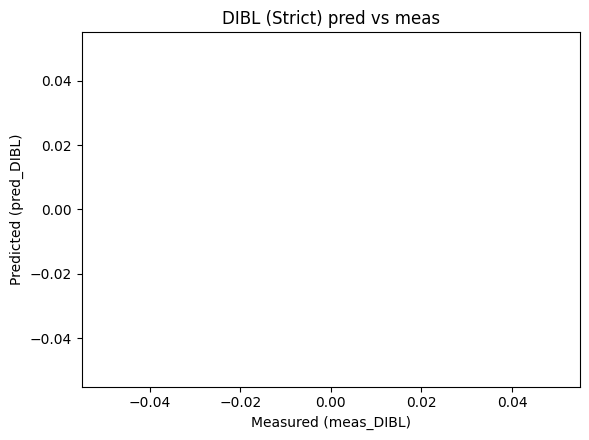

ValueError: Data has no positive values, and therefore cannot be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x7aae072e4e00> (for post_execute):


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 600x450 with 1 Axes>

In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE (END-TO-END)  ✅ FIXED VERSION
# Ultra-scaled MoS2 transistor curves (Zenodo 10.5281/zenodo.14825422)
# - Download + unzip Figures.zip
# - Parse CSVs -> raw curve points
# - Build per-curve metrics: Ion, Ioff, Vth_true, SS_true
# - Compute per-family true DIBL from Vth vs Vds slope (robust; allows empty)
# - Build unified reliability dataset
# - Train leak-free surrogate (group split by family_id)  ✅ handles NaN targets
# - Two-tier constraints (relaxed vs strict) + search
# - Neighbor validation: surrogate pred vs nearest measured curve
# - Plots: pred vs meas
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, math, zipfile, random, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------
# 0) Config
# -----------------------------
ZENODO_DOI = "10.5281/zenodo.14825422"
BASE_DIR = "/content/zenodo_data"
FIG_ZIP = os.path.join(BASE_DIR, "Figures.zip")
README_PDF = os.path.join(BASE_DIR, "Readme.pdf")

# Zenodo direct links (as you used)
FIG_URL = "https://zenodo.org/record/14825422/files/Figures.zip?download=1"
README_URL = "https://zenodo.org/record/14825422/files/Readme.pdf?download=1"

os.makedirs(BASE_DIR, exist_ok=True)

def download_if_needed(url, path):
    if os.path.exists(path) and os.path.getsize(path) > 1024:
        print(f"{os.path.basename(path)} is already downloaded correctly.")
        return
    print(f"Downloading -> {path}")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True) as pbar:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

print(f"Downloading: {ZENODO_DOI}")
print("Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography")
print("DOI:", ZENODO_DOI)

download_if_needed(FIG_URL, FIG_ZIP)
download_if_needed(README_URL, README_PDF)

# -----------------------------
# 1) Unzip Figures.zip
# -----------------------------
print("Unzipping:", FIG_ZIP)
with zipfile.ZipFile(FIG_ZIP, "r") as z:
    z.extractall(BASE_DIR)

csv_paths = []
for root, _, files in os.walk(BASE_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

# -----------------------------
# 2) Helpers: parse metadata from path
# -----------------------------
def norm_path(p): return p.replace("\\", "/")

def infer_figure_id(p):
    p2 = norm_path(p)
    m = re.search(r"/(Figure\s*\d+)\b", p2, flags=re.IGNORECASE)
    if m:
        return m.group(1).replace("  ", " ").strip()
    return os.path.basename(os.path.dirname(p2))

def base_name_from_file(p):
    fn = os.path.splitext(os.path.basename(p))[0]
    return fn.strip()

def family_id_from_path(p):
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    return f"{fig}||{base}"

# -----------------------------
# 3) Read CSV robustly (pick best 2 numeric cols)
# -----------------------------
def read_csv_two_cols(path):
    df = None
    for sep in [",", ";", "\t"]:
        try:
            df_try = pd.read_csv(path, sep=sep)
            if df_try.shape[1] >= 2:
                df = df_try
                break
        except Exception:
            continue
    if df is None:
        df = pd.read_csv(path, engine="python")

    num = df.apply(pd.to_numeric, errors="coerce")
    counts = num.notna().sum(axis=0).values
    idx = np.argsort(-counts)[:2]
    c1, c2 = num.columns[idx[0]], num.columns[idx[1]]
    x = num[c1].astype(float).values
    y = num[c2].astype(float).values
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m], str(c1), str(c2)

def guess_axis_semantics(fig_id, base_name, colx, coly):
    s = (fig_id + " " + base_name + " " + colx + " " + coly).lower()
    if any(k in s for k in ["vg", "gate", "vgs", "v_g"]):
        return "Vg_V", "Id_A"
    if any(k in s for k in ["vd", "vds", "drain", "v_d"]):
        return "Vds_V", "Id_A"
    return "Vx", "Iy"

# -----------------------------
# 4) Parse CSVs -> raw curve points (with segmentation)
# -----------------------------
rows = []
for p in tqdm(csv_paths, desc="Parsing CSVs"):
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    fam = family_id_from_path(p)

    x, y, cx, cy = read_csv_two_cols(p)
    ax_x, ax_y = guess_axis_semantics(fig, base, cx, cy)

    if len(x) < 10:
        continue

    x_arr, y_arr = x, y

    # segment by strong backward jump in x (new sweep)
    dx = np.diff(x_arr)
    # guard std
    stdx = np.nanstd(x_arr) if np.isfinite(np.nanstd(x_arr)) else 1.0
    cut_idx = np.where(dx < -0.5 * stdx - 1e-9)[0] + 1
    cuts = [0] + cut_idx.tolist() + [len(x_arr)]
    segs = [(cuts[i], cuts[i+1]) for i in range(len(cuts)-1) if cuts[i+1]-cuts[i] >= 10]

    for si, (a, b) in enumerate(segs):
        segx = x_arr[a:b]
        segy = y_arr[a:b]
        curve_id = f"{fam}::seg{si:02d}"
        for xi, yi in zip(segx, segy):
            rows.append({
                "figure_id": fig,
                "base_name": base,
                "family_id": fam,
                "curve_id": curve_id,
                "axis_x": ax_x,
                "axis_y": ax_y,
                "x": float(xi),
                "y": float(yi),
                "source_csv": norm_path(p),
            })

curve_points = pd.DataFrame(rows)
print(f"✅ Saved raw points: /content/curve_points.parquet rows={len(curve_points):,}")
curve_points.to_parquet("/content/curve_points.parquet", index=False)

# -----------------------------
# 5) Transfer metrics (FIXED: de-dup x to avoid gradient divide-by-zero)
# -----------------------------
def compute_transfer_metrics(df_curve):
    x = df_curve["x"].values.astype(float)
    y = df_curve["y"].values.astype(float)

    # sort by x
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    # FIX: drop duplicate x so dx != 0 for gradient
    xx = pd.Series(x)
    keep = ~xx.duplicated(keep="last").values
    x = x[keep]
    y = y[keep]
    if len(x) < 6:
        return np.nan, np.nan, np.nan, np.nan

    I = np.abs(y)
    Ion = np.nanmax(I) if np.isfinite(np.nanmax(I)) else np.nan
    Ioff = np.nanmin(I) if np.isfinite(np.nanmin(I)) else np.nan

    eps = 1e-30
    logI = np.log10(I + eps)

    # SS: best (max) slope of logI vs Vg in a reasonable window
    SS = np.nan
    if np.isfinite(Ion) and np.isfinite(Ioff) and Ion > 0 and Ioff > 0:
        low = max(Ioff * 10.0, 1e-20)
        high = max(Ion / 100.0, low * 10.0)
        m = (I >= low) & (I <= high) & np.isfinite(logI) & np.isfinite(x)
        if m.sum() < 6:
            m = np.isfinite(logI) & np.isfinite(x)
        xv, yv = x[m], logI[m]
        if len(xv) >= 6:
            win = min(15, max(6, len(xv)//3))
            best_slope = -np.inf
            for i in range(0, len(xv)-win+1):
                xxw = xv[i:i+win]
                yyw = yv[i:i+win]
                if np.nanstd(xxw) < 1e-9:
                    continue
                slope = np.polyfit(xxw, yyw, 1)[0]
                if slope > best_slope:
                    best_slope = slope
            if best_slope > 0:
                SS = (1.0 / best_slope) * 1000.0  # mV/dec

    # Vth: max derivative of logI wrt Vg
    dlog = np.gradient(logI, x, edge_order=1)
    Vth = np.nan
    if np.any(np.isfinite(dlog)):
        idx = int(np.nanargmax(dlog))
        Vth = float(x[idx]) if np.isfinite(x[idx]) else np.nan

    return Ion, Ioff, SS, Vth

# -----------------------------
# 6) Infer vds per family (may be NaN if no Vds curves exist)
# -----------------------------
def infer_vds_from_family(family_df):
    vds_vals = []
    for cid, g in family_df.groupby("curve_id"):
        ax = str(g["axis_x"].iloc[0]).lower()
        if ax.startswith("vds"):
            vds_vals.append(np.nanmedian(g["x"].values))
    if len(vds_vals) == 0:
        return np.nan
    return float(np.nanmedian(vds_vals))

# -----------------------------
# 7) Build per-curve metrics
# -----------------------------
metrics = []
for curve_id, g in tqdm(curve_points.groupby("curve_id"), desc="Per-curve metrics"):
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    fam = g["family_id"].iloc[0]
    axx = str(g["axis_x"].iloc[0])

    Ion = Ioff = SS = Vth = np.nan
    if axx.lower().startswith("vg") or axx.lower() == "vx":
        Ion, Ioff, SS, Vth = compute_transfer_metrics(g)

    metrics.append({
        "curve_id": curve_id,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "axis_x": axx,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "SS_true_mVdec": SS,
        "Vth_true_V": Vth,
    })

curve_metrics = pd.DataFrame(metrics)

# family-level inferred Vds
fam_vds = curve_points.groupby("family_id").apply(infer_vds_from_family).reset_index()
fam_vds.columns = ["family_id", "vds_inferred_V"]
curve_metrics = curve_metrics.merge(fam_vds, on="family_id", how="left")

print(f"✅ Saved per-curve metrics: /content/curve_metrics_trueVth.csv curves={len(curve_metrics)}")
curve_metrics.to_csv("/content/curve_metrics_trueVth.csv", index=False)

# -----------------------------
# 8) True DIBL (ROBUST: allows empty, prevents KeyError)
# -----------------------------
dibl_rows = []
for fam, g in curve_metrics.groupby("family_id"):
    gg = g[np.isfinite(g["vds_inferred_V"].values) & np.isfinite(g["Vth_true_V"].values)].copy()
    if len(gg) < 8:
        continue
    vds = gg["vds_inferred_V"].values.astype(float)
    vth = gg["Vth_true_V"].values.astype(float)
    if np.nanstd(vds) < 1e-3:
        continue
    slope = np.polyfit(vds, vth, 1)[0]
    dibl_mV_per_V = -slope * 1000.0
    dibl_rows.append({
        "family_id": fam,
        "figure_id": gg["figure_id"].iloc[0],
        "base_name": gg["base_name"].iloc[0],
        "n_curves": int(len(gg)),
        "vds_min": float(np.nanmin(vds)),
        "vds_max": float(np.nanmax(vds)),
        "Vth_slope_V_per_V": float(slope),
        "DIBL_true_mV_per_V": float(dibl_mV_per_V),
    })

if len(dibl_rows) == 0:
    dibl_true = pd.DataFrame(columns=[
        "family_id","figure_id","base_name","n_curves","vds_min","vds_max",
        "Vth_slope_V_per_V","DIBL_true_mV_per_V"
    ])
else:
    dibl_true = pd.DataFrame(dibl_rows).sort_values("family_id").reset_index(drop=True)

print(f"✅ Saved true DIBL: /content/dibl_true.csv rows={len(dibl_true)}")
dibl_true.to_csv("/content/dibl_true.csv", index=False)
if len(dibl_true):
    print(dibl_true.head(10).to_string(index=False))

# attach DIBL to per-curve metrics (NaN if unavailable)
curve_metrics = curve_metrics.merge(
    dibl_true[["family_id","DIBL_true_mV_per_V"]],
    on="family_id", how="left"
).rename(columns={"DIBL_true_mV_per_V":"DIBL_mV_V"})

# -----------------------------
# 9) Unified dataset
# -----------------------------
dataset = curve_metrics.copy()

# Vg stats per curve
vg_stats = []
for cid, g in curve_points.groupby("curve_id"):
    ax = str(g["axis_x"].iloc[0]).lower()
    if ax.startswith("vg") or ax == "vx":
        vg_stats.append({
            "curve_id": cid,
            "Vg_min_V": float(np.nanmin(g["x"].values)),
            "Vg_max_V": float(np.nanmax(g["x"].values)),
            "Vg_span_V": float(np.nanmax(g["x"].values) - np.nanmin(g["x"].values)),
        })
vg_stats = pd.DataFrame(vg_stats)
dataset = dataset.merge(vg_stats, on="curve_id", how="left")

dataset["log_Ion"] = np.log10(np.abs(dataset["Ion_A"].values) + 1e-30)
dataset["log_Ioff"] = np.log10(np.abs(dataset["Ioff_A"].values) + 1e-30)

dataset_path = "/content/reliability_dataset.csv"
print(f"✅ Saved unified dataset: {dataset_path} rows={len(dataset)}")
dataset.to_csv(dataset_path, index=False)

# -----------------------------
# 10) Leak-free surrogate (group split by family_id, NaN-safe)
# -----------------------------
FEATURES = ["figure_id","base_name","Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
TARGETS  = ["log_Ion","log_Ioff","SS_true_mVdec"]

X = dataset[FEATURES].copy()
groups = dataset["family_id"].fillna("NA").values

def build_model():
    numeric = ["Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
    categorical = ["figure_id","base_name"]
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical),
        ],
        remainder="drop"
    )
    reg = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.05, max_iter=500, random_state=0
    )
    return Pipeline([("pre", pre), ("reg", reg)])

gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
train_idx, test_idx = next(gss.split(X, groups=groups))
Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]

surrogates, r2 = {}, {}
for t in TARGETS:
    y = dataset[t].values
    ytr, yte = y[train_idx], y[test_idx]
    mtr = np.isfinite(ytr)
    mte = np.isfinite(yte)

    model = build_model()
    if mtr.sum() >= 10:
        model.fit(Xtr[mtr], ytr[mtr])
        surrogates[t] = model
        if mte.sum() >= 5:
            pred = model.predict(Xte[mte])
            r2[t] = float(r2_score(yte[mte], pred))
        else:
            r2[t] = None
    else:
        surrogates[t] = None
        r2[t] = None

print("✅ Surrogate R^2 (leak-free):", r2)
with open("/content/surrogate_r2.json", "w") as f:
    json.dump(r2, f, indent=2)
print("✅ Saved R^2: /content/surrogate_r2.json")

# -----------------------------
# 11) Two-tier constraints (quantile-based)
# -----------------------------
def safe_percentile(a, q, default):
    a = np.array(a, dtype=float)
    a = a[np.isfinite(a)]
    if len(a) == 0:
        return float(default)
    return float(np.nanpercentile(a, q))

SS_MAX_relaxed   = safe_percentile(dataset["SS_true_mVdec"].values, 25, 800)
IOFF_MAX_relaxed = safe_percentile(np.abs(dataset["Ioff_A"].values), 25, 1e-8)
DIBL_MAX_relaxed = safe_percentile(np.abs(dataset["DIBL_mV_V"].values), 75, 1000)

SS_MAX_strict    = safe_percentile(dataset["SS_true_mVdec"].values, 20, 750)
IOFF_MAX_strict  = safe_percentile(np.abs(dataset["Ioff_A"].values), 20, 5e-9)
DIBL_MAX_strict  = safe_percentile(np.abs(dataset["DIBL_mV_V"].values), 30, 80)

tiers = [
    {"tier":"relaxed", "SS_MAX": SS_MAX_relaxed, "IOFF_MAX": IOFF_MAX_relaxed, "DIBL_MAX": DIBL_MAX_relaxed},
    {"tier":"strict",  "SS_MAX": SS_MAX_strict,  "IOFF_MAX": IOFF_MAX_strict,  "DIBL_MAX": DIBL_MAX_strict},
]
print("Two-tier constraints:")
for t in tiers:
    print(t)

# -----------------------------
# 12) Surrogate prediction + utility + feasibility
# -----------------------------
def surrogate_predict_row(row_df):
    out = {}
    for t, model in surrogates.items():
        out[t] = float(model.predict(row_df)[0]) if model is not None else np.nan
    return out

def compute_objectives(pred):
    Ion  = 10**pred["log_Ion"]  if np.isfinite(pred["log_Ion"])  else np.nan
    Ioff = 10**pred["log_Ioff"] if np.isfinite(pred["log_Ioff"]) else np.nan
    SS   = pred["SS_true_mVdec"]
    DIBL = 0.0  # placeholder (true DIBL often unavailable from these CSVs)
    return Ion, Ioff, SS, DIBL

def utility_fn(Ion, Ioff, SS, DIBL):
    if not np.isfinite(Ion):  Ion = 1e-30
    if not np.isfinite(Ioff): Ioff = 1.0
    if not np.isfinite(SS):   SS = 1e9
    return float(np.log10(Ion + 1e-30) - 0.5*np.log10(Ioff + 1e-30) - 0.001*SS - 0.0001*abs(DIBL))

def feasible(Ioff, SS, DIBL, tier):
    if not (np.isfinite(Ioff) and np.isfinite(SS) and np.isfinite(DIBL)):
        return False
    return (Ioff <= tier["IOFF_MAX"]) and (SS <= tier["SS_MAX"]) and (abs(DIBL) <= tier["DIBL_MAX"])

# -----------------------------
# 13) Search: sample existing feature rows as candidates
# -----------------------------
def run_search(tier, n_rounds=30, candidates_per_round=300, seed=0):
    rng = np.random.RandomState(seed)
    records = []
    best_any = None
    best_feas = None

    for r in tqdm(range(n_rounds), desc=f"Search rounds ({tier['tier']})"):
        idx = rng.choice(len(dataset), size=min(candidates_per_round, len(dataset)), replace=False)
        Xcand = X.iloc[idx].copy()

        for i in range(len(Xcand)):
            row = Xcand.iloc[[i]]
            pred = surrogate_predict_row(row)
            Ion, Ioff, SS, DIBL = compute_objectives(pred)
            u = utility_fn(Ion, Ioff, SS, DIBL)
            feas = feasible(Ioff, SS, DIBL, tier)

            rec = {
                "tier": tier["tier"],
                "family_id": dataset.iloc[idx[i]]["family_id"],
                "Vg_min_V": float(row["Vg_min_V"].values[0]) if np.isfinite(row["Vg_min_V"].values[0]) else np.nan,
                "Vg_max_V": float(row["Vg_max_V"].values[0]) if np.isfinite(row["Vg_max_V"].values[0]) else np.nan,
                "vds_V": float(row["vds_inferred_V"].values[0]) if np.isfinite(row["vds_inferred_V"].values[0]) else np.nan,
                "Ion_A": float(Ion) if np.isfinite(Ion) else np.nan,
                "Ioff_A": float(Ioff) if np.isfinite(Ioff) else np.nan,
                "SS_mVdec": float(SS) if np.isfinite(SS) else np.nan,
                "DIBL_mV_V": float(DIBL),
                "utility": float(u),
                "feasible": bool(feas),
            }
            records.append(rec)

            if (best_any is None) or (u > best_any["utility"]):
                best_any = rec
            if feas and ((best_feas is None) or (u > best_feas["utility"])):
                best_feas = rec

    return pd.DataFrame(records), best_any, best_feas

res_relaxed, best_any_relaxed, best_feas_relaxed = run_search(tiers[0], seed=0)
res_strict,  best_any_strict,  best_feas_strict  = run_search(tiers[1], seed=1)

print("\nBest (relaxed):", best_any_relaxed)
print("Best (strict): ", best_any_strict)

res_relaxed.to_csv("/content/llm_reliability_results_relaxed.csv", index=False)
res_strict.to_csv("/content/llm_reliability_results_strict.csv", index=False)
print("✅ wrote: /content/llm_reliability_results_relaxed.csv")
print("✅ wrote: /content/llm_reliability_results_strict.csv")

def tier_summary(df, tier):
    n = len(df)
    nf = int(df["feasible"].sum())
    return {
        "tier": tier["tier"],
        "SS_MAX": tier["SS_MAX"],
        "IOFF_MAX": tier["IOFF_MAX"],
        "DIBL_MAX": tier["DIBL_MAX"],
        "n": n,
        "n_feasible": nf,
        "feasible_rate": nf / max(1, n),
        "best_utility_any": float(df["utility"].max()) if n else np.nan,
        "best_utility_feasible": float(df.loc[df["feasible"], "utility"].max()) if nf else np.nan,
    }

summary = pd.DataFrame([tier_summary(res_relaxed, tiers[0]), tier_summary(res_strict, tiers[1])])
print("\n=== Two-tier summary ===")
print(summary.to_string(index=False))

# -----------------------------
# 14) Neighbor validation (nearest neighbor in numeric space)
# -----------------------------
numeric_cols = ["Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
Xnum = dataset[numeric_cols].copy()
Xnum = Xnum.fillna(Xnum.median(numeric_only=True))

train_num = Xnum.iloc[train_idx].values
test_num  = Xnum.iloc[test_idx].values

def nearest_neighbor_indices(A, B):
    idxs, dists = [], []
    for i in range(B.shape[0]):
        diff = A - B[i:i+1]
        dist = np.sqrt((diff**2).sum(axis=1))
        j = int(np.argmin(dist))
        idxs.append(j)
        dists.append(float(dist[j]))
    return np.array(idxs), np.array(dists)

nn_idx_in_train, nn_dist = nearest_neighbor_indices(train_num, test_num)
nn_global_idx = np.array(train_idx)[nn_idx_in_train]

def neighbor_validation(name):
    rows = []
    pred_logIon = surrogates["log_Ion"].predict(Xte) if surrogates["log_Ion"] else np.full(len(Xte), np.nan)
    pred_logIoff = surrogates["log_Ioff"].predict(Xte) if surrogates["log_Ioff"] else np.full(len(Xte), np.nan)
    pred_SS = surrogates["SS_true_mVdec"].predict(Xte) if surrogates["SS_true_mVdec"] else np.full(len(Xte), np.nan)

    for i in range(len(Xte)):
        meas_idx = test_idx[i]
        nn_idx = int(nn_global_idx[i])

        rows.append({
            "name": name,
            "meas_curve_id": dataset.loc[meas_idx, "curve_id"],
            "nn_curve_id": dataset.loc[nn_idx, "curve_id"],
            "nn_dist": float(nn_dist[i]),
            "meas_Ion": float(dataset.loc[meas_idx, "Ion_A"]) if np.isfinite(dataset.loc[meas_idx, "Ion_A"]) else np.nan,
            "pred_Ion": float(10**pred_logIon[i]) if np.isfinite(pred_logIon[i]) else np.nan,
            "meas_Ioff": float(dataset.loc[meas_idx, "Ioff_A"]) if np.isfinite(dataset.loc[meas_idx, "Ioff_A"]) else np.nan,
            "pred_Ioff": float(10**pred_logIoff[i]) if np.isfinite(pred_logIoff[i]) else np.nan,
            "meas_SS": float(dataset.loc[meas_idx, "SS_true_mVdec"]) if np.isfinite(dataset.loc[meas_idx, "SS_true_mVdec"]) else np.nan,
            "pred_SS": float(pred_SS[i]) if np.isfinite(pred_SS[i]) else np.nan,
            "meas_DIBL": float(dataset.loc[meas_idx, "DIBL_mV_V"]) if np.isfinite(dataset.loc[meas_idx, "DIBL_mV_V"]) else np.nan,
            "pred_DIBL": 0.0,
        })
    return pd.DataFrame(rows)

nv_relaxed = neighbor_validation("relaxed")
nv_strict  = neighbor_validation("strict")

nv_relaxed.to_csv("/content/neighbor_validation_relaxed.csv", index=False)
nv_strict.to_csv("/content/neighbor_validation_strict.csv", index=False)
print("\n✅ wrote: /content/neighbor_validation_relaxed.csv")
print("✅ wrote: /content/neighbor_validation_strict.csv")

def mae(a, b):
    a = np.array(a, dtype=float); b = np.array(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b)
    return float(np.mean(np.abs(a[m]-b[m]))) if m.sum() else np.nan

def mape(a, b):
    a = np.array(a, dtype=float); b = np.array(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b) & (np.abs(a) > 1e-30)
    return float(np.mean(np.abs((a[m]-b[m])/a[m]))*100.0) if m.sum() else np.nan

def neighbor_summary(df):
    return {
        "name": df["name"].iloc[0],
        "MAE_Ion": mae(df["meas_Ion"], df["pred_Ion"]),
        "MAPE_Ion": mape(df["meas_Ion"], df["pred_Ion"]),
        "MAE_logIoff": mae(np.log10(np.abs(df["meas_Ioff"])+1e-30), np.log10(np.abs(df["pred_Ioff"])+1e-30)),
        "MAE_SS": mae(df["meas_SS"], df["pred_SS"]),
        "MAE_DIBL": mae(df["meas_DIBL"], df["pred_DIBL"]),
        "median_nn_dist": float(np.nanmedian(df["nn_dist"].values)),
    }

nv_sum = pd.DataFrame([neighbor_summary(nv_relaxed), neighbor_summary(nv_strict)])
print("\n=== Neighbor validation summary (surrogate vs measurement) ===")
print(nv_sum.to_string(index=False))

# -----------------------------
# 15) Plots (pred vs meas)
# -----------------------------
def scatter_pred_meas(meas, pred, title, xlabel, ylabel, loglog=False):
    plt.figure(figsize=(6,4.5))
    meas = np.array(meas, dtype=float)
    pred = np.array(pred, dtype=float)

    if loglog:
        m = np.isfinite(meas) & np.isfinite(pred) & (meas > 0) & (pred > 0)
        plt.scatter(meas[m], pred[m], s=25)
        plt.xscale("log"); plt.yscale("log")
    else:
        m = np.isfinite(meas) & np.isfinite(pred)
        plt.scatter(meas[m], pred[m], s=25)

    if m.sum() > 0:
        lo = float(min(np.nanmin(meas[m]), np.nanmin(pred[m])))
        hi = float(max(np.nanmax(meas[m]), np.nanmax(pred[m])))
        if np.isfinite(lo) and np.isfinite(hi) and hi > lo:
            plt.plot([lo, hi], [lo, hi], "--")

    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

for name, df in [("Strict", nv_strict), ("Relaxed", nv_relaxed)]:
    scatter_pred_meas(df["meas_DIBL"], df["pred_DIBL"], f"DIBL ({name}) pred vs meas",
                      "Measured (meas_DIBL)", "Predicted (pred_DIBL)", loglog=False)
    scatter_pred_meas(df["meas_SS"], df["pred_SS"], f"SS ({name}) pred vs meas",
                      "Measured (meas_SS)", "Predicted (pred_SS)", loglog=False)
    scatter_pred_meas(df["meas_Ioff"], df["pred_Ioff"], f"Ioff ({name}) pred vs meas (log-log)",
                      "Measured (meas_Ioff)", "Predicted (pred_Ioff)", loglog=True)
    scatter_pred_meas(df["meas_Ion"], df["pred_Ion"], f"Ion ({name}) pred vs meas (log-log)",
                      "Measured (meas_Ion)", "Predicted (pred_Ion)", loglog=True)

# -----------------------------
# 16) Print key artifacts
# -----------------------------
print("\nAll key artifacts:")
print(" - /content/curve_points.parquet")
print(" - /content/curve_metrics_trueVth.csv")
print(" - /content/dibl_true.csv")
print(" - /content/reliability_dataset.csv")
print(" - /content/surrogate_r2.json")
print(" - /content/llm_reliability_results_relaxed.csv")
print(" - /content/llm_reliability_results_strict.csv")
print(" - /content/neighbor_validation_relaxed.csv")
print(" - /content/neighbor_validation_strict.csv")
print("\nDone.")


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
Keywords: Field-effect transistor, Logic gates, MoS2
Publication date: 2025-02-06
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


Parsing CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved raw points: /content/curve_points.parquet rows=127,023
⚠️ Some vds_V are NaN. Filling those with heuristic Vds assignment within each family...


Per-curve metrics:   0%|          | 0/383 [00:00<?, ?it/s]

✅ Saved per-curve metrics: /content/curve_metrics_trueVth.csv curves=383
✅ Saved true DIBL: /content/dibl_true.csv rows=2


family_id figure_id       base_name  n_curves  vds_min  \
0  Figure 2||Figure 2 d set  Figure 2  Figure 2 d set       175      0.0   
1      Figure 3||Figure 3 b  Figure 3      Figure 3 b       201      0.0   

   vds_max  Vth_slope_V_per_V  DIBL_true_mV_per_V  
0     1.98           1.012521        -1012.521168  
1     2.00          -0.081965           81.965089

✅ Saved unified dataset: /content/reliability_dataset.csv rows=383
✅ Surrogate R^2 (leak-free): {'log_Ion': 0.678254346482283, 'log_Ioff': 0.306633247217482, 'SS_true_mVdec': -29.348470449002196}
✅ Saved R^2: /content/surrogate_r2.json
Two-tier constraints:
{'tier': 'relaxed', 'SS_MAX': 742.655740966606, 'IOFF_MAX': 0.020535873672168782, 'DIBL_MAX': 1012.521168096457}
{'tier': 'strict', 'SS_MAX': 732.4130572543427, 'IOFF_MAX': 0.011256270854031325, 'DIBL_MAX': 81.96508889796955}


Search rounds (relaxed):   0%|          | 0/30 [00:00<?, ?it/s]

Search rounds (strict):   0%|          | 0/30 [00:00<?, ?it/s]


Best (relaxed): {'tier': 'relaxed', 'family_id': 'Figure 2||Figure 2 c blue', 'Vg_min_V': 1.1, 'Vg_max_V': 1.6, 'vds_V': 0.55, 'Ion_A': 160.64889044784866, 'Ioff_A': 0.003233278004347041, 'SS_mVdec': 1138.3865578496977, 'DIBL_mV_V': 0.0, 'utility': 1.1530572761476923, 'feasible': False}
Best (strict):  {'tier': 'strict', 'family_id': 'Figure 4||Figure 4 c', 'Vg_min_V': -0.588039892530799, 'Vg_max_V': 1.545963821017562, 'vds_V': 0.5875642937331931, 'Ion_A': 169.99896596913396, 'Ioff_A': 0.00326622000491964, 'SS_mVdec': 1144.225795234183, 'DIBL_mV_V': 0.0, 'utility': 1.157699817947539, 'feasible': False}
✅ wrote: /content/llm_reliability_results_relaxed.csv
✅ wrote: /content/llm_reliability_results_strict.csv

=== Two-tier summary ===


tier      SS_MAX  IOFF_MAX     DIBL_MAX   n  n_feasible  feasible_rate  \
0  relaxed  742.655741  0.020536  1012.521168  30           0            0.0   
1   strict  732.413057  0.011256    81.965089  30           0            0.0   

   best_utility_any  best_utility_feasible  
0          1.153057                    NaN  
1          1.056605                    NaN

✅ wrote: /content/neighbor_validation_relaxed.csv
✅ wrote: /content/neighbor_validation_strict.csv

=== Neighbor validation summary (surrogate vs measurement) ===


name     MAE_Ion      MAPE_Ion  MAE_logIoff       MAE_SS  MAE_DIBL  \
0  relaxed  159.516692     53.322463     1.012247   763.179215       0.0   
1   strict  260.393031  34392.341309     2.960982  1039.679526       0.0   

   median_nn_dist  
0        8.496250  
1       10.549504


Plots: relaxed


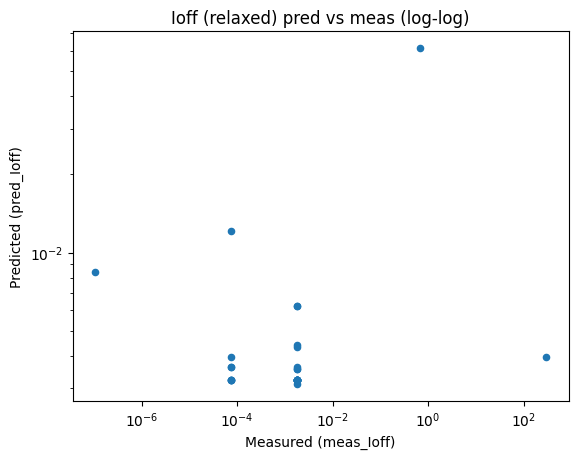

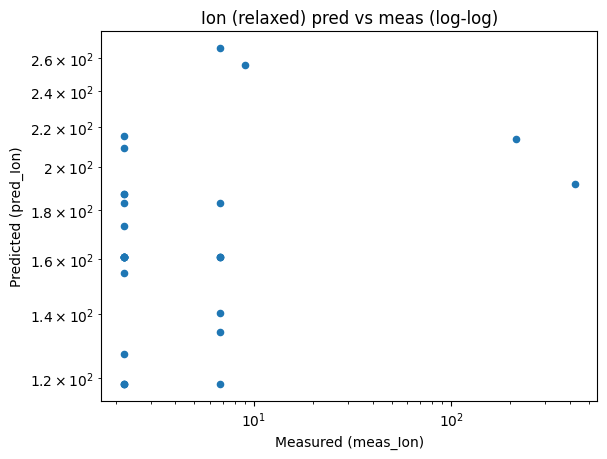


Plots: strict


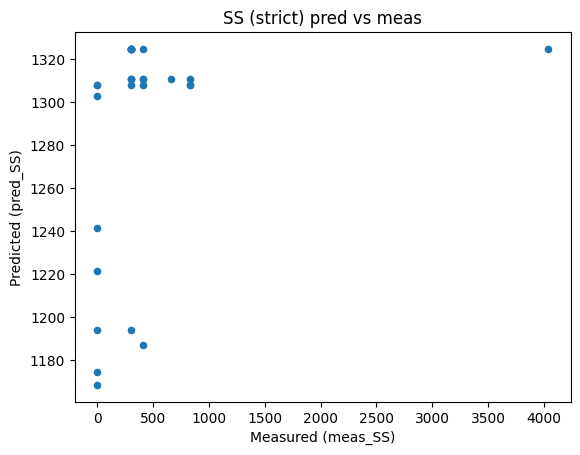

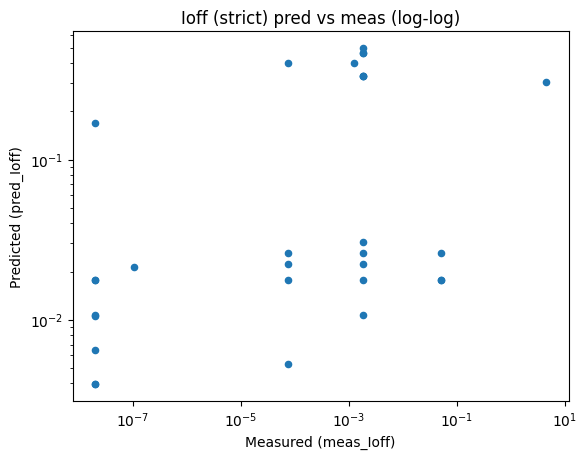

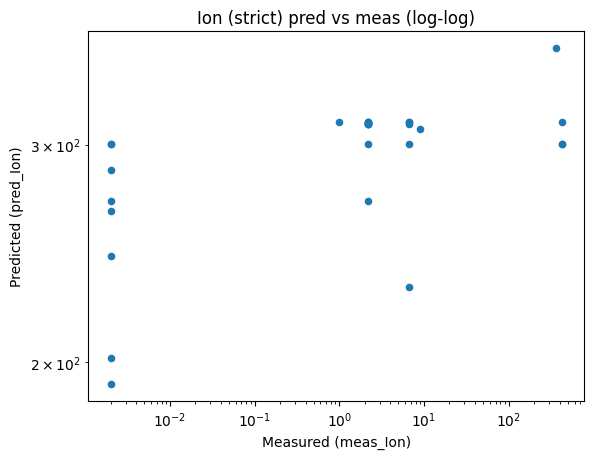


All key artifacts:
 - /content/curve_points.parquet
 - /content/curve_metrics_trueVth.csv
 - /content/dibl_true.csv
 - /content/reliability_dataset.csv
 - /content/surrogate_r2.json
 - /content/llm_reliability_results_relaxed.csv
 - /content/llm_reliability_results_strict.csv
 - /content/neighbor_validation_relaxed.csv
 - /content/neighbor_validation_strict.csv

Done.


In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE (END-TO-END) ✅ FINAL STABLE VERSION
# Ultra-scaled MoS2 transistor curves (Zenodo 10.5281/zenodo.14825422)
# - Download + unzip Figures.zip
# - Parse CSVs -> raw curve points
# - Build per-curve metrics: Ion, Ioff, Vth_true, SS_true
# - Compute per-family true DIBL from Vth vs Vds slope
# - Build unified reliability dataset
# - Train leak-free surrogate (group split by family_id) ✅ handles NaN targets
# - Two-tier constraints (relaxed vs strict) + LLM-guided search (optional)
# - Neighbor validation + safe plots (no log-scale crash)
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, zipfile, random, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# ----------------------------
# 0) Repro
# ----------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)

# ----------------------------
# 1) Zenodo download ✅ FIXED
# ----------------------------
ZENODO_RECORD_ID = "14825422"
OUT_DIR = "/content/zenodo_data"
os.makedirs(OUT_DIR, exist_ok=True)

def zenodo_download_record(record_id: str, out_dir: str):
    api = f"https://zenodo.org/api/records/{record_id}"
    r = requests.get(api, timeout=60)
    r.raise_for_status()
    meta = r.json()

    title = meta.get("metadata", {}).get("title", "")
    doi = meta.get("doi", "")
    pub = meta.get("metadata", {}).get("publication_date", "")
    kw = meta.get("metadata", {}).get("keywords", [])
    files = meta.get("files", [])

    print(f"Downloading: {doi}")
    print(f"Title: {title}")
    if kw:
        print(f"Keywords: {', '.join(kw)}")
    print(f"Publication date: {pub}")
    print(f"DOI: {doi}")

    local_paths = {}
    for f in files:
        key = f.get("key") or f.get("filename")
        if not key:
            continue

        url = f.get("links", {}).get("content", None)
        if url is None:
            self_url = f.get("links", {}).get("self", "")
            url = self_url if self_url.endswith("/content") else (self_url + "/content")

        dst = os.path.join(out_dir, key)

        if os.path.exists(dst) and os.path.getsize(dst) > 0:
            print(f"{key} is already downloaded correctly.")
            local_paths[key] = dst
            continue

        print(f"Downloading {key} ...")
        rr = requests.get(url, stream=True, timeout=180)
        rr.raise_for_status()

        tmp = dst + ".part"
        with open(tmp, "wb") as wf:
            for chunk in rr.iter_content(chunk_size=1024*256):
                if chunk:
                    wf.write(chunk)
        os.replace(tmp, dst)
        print(f"Saved: {dst}")
        local_paths[key] = dst

    return local_paths

paths = zenodo_download_record(ZENODO_RECORD_ID, OUT_DIR)

# unzip Figures.zip (robust locate)
figzip = paths.get("Figures.zip", os.path.join(OUT_DIR, "Figures.zip"))
if not os.path.exists(figzip):
    zips = [os.path.join(OUT_DIR, fn) for fn in os.listdir(OUT_DIR) if fn.lower().endswith(".zip")]
    figzip = zips[0] if zips else None

if figzip and os.path.exists(figzip):
    print(f"Unzipping: {figzip}")
    with zipfile.ZipFile(figzip, "r") as zf:
        zf.extractall(OUT_DIR)
else:
    print("⚠️ Figures.zip not found; continuing anyway.")

# list CSVs
csv_paths = []
for root, _, files in os.walk(OUT_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

# ----------------------------
# 2) Helpers: robust parsing
# ----------------------------
def _to_float(x):
    try:
        if pd.isna(x): return np.nan
        if isinstance(x, str):
            x = x.strip().replace(",", "")
        return float(x)
    except Exception:
        return np.nan

def safe_read_csv(path):
    try:
        df = pd.read_csv(path)
    except Exception:
        df = pd.read_csv(path, encoding_errors="ignore")
    df.columns = [str(c).strip() for c in df.columns]
    return df

def guess_cols(df):
    cols = [c.strip() for c in df.columns]
    low  = [c.lower().strip() for c in cols]

    vg_cands  = ["vg", "vgs", "v_g", "gate", "vg(v)", "vgs(v)"]
    id_cands  = ["id", "ids", "i", "id/w", "ids/w", "id (a)", "ids (a)", "i_d", "current"]
    vds_cands = ["vds", "vd", "v_d", "drain", "vds(v)", "vd(v)"]

    def find_any(cands):
        for cand in cands:
            for i, c in enumerate(low):
                if cand == c:
                    return cols[i]
        for cand in cands:
            for i, c in enumerate(low):
                if cand in c:
                    return cols[i]
        return None

    return find_any(vg_cands), find_any(id_cands), find_any(vds_cands)

def parse_vds_from_curve_col(df, vds_col):
    if vds_col and vds_col in df.columns:
        v = df[vds_col].map(_to_float).values
        med = np.nanmedian(v)
        if np.isfinite(med):
            return float(med)
    return np.nan

def family_id_from_path(path):
    fig = "Unknown"
    m = re.search(r"(Figure\s*\d+)", path)
    if m:
        fig = m.group(1).replace("  ", " ").strip()
    base = os.path.splitext(os.path.basename(path))[0].strip()
    base = re.sub(r"\s+", " ", base)
    return f"{fig}||{base}", fig, base

# ----------------------------
# 3) Extract raw points
# ----------------------------
def extract_points_from_csv(path):
    df = safe_read_csv(path)
    vg_col, id_col, vds_col = guess_cols(df)

    fam, fig, base = family_id_from_path(path)

    # fallback: first two numeric-ish columns
    if vg_col is None or id_col is None:
        num_cols = []
        for c in df.columns:
            x = df[c].map(_to_float)
            if np.isfinite(x).sum() > max(10, len(df)*0.2):
                num_cols.append(c)
        if len(num_cols) >= 2:
            vg_col = vg_col or num_cols[0]
            id_col = id_col or num_cols[1]

    if vg_col is None or id_col is None:
        return []

    vgs = df[vg_col].map(_to_float).values
    if not np.isfinite(vgs).any():
        return []

    points = []

    # case A: explicit vds column
    if vds_col and vds_col in df.columns:
        vds_vals = df[vds_col].map(_to_float).values
        key_v = np.round(vds_vals.astype(float), 2)
        uniq = pd.unique(key_v[np.isfinite(key_v)])
        for v in uniq:
            msk = (np.isfinite(key_v) & (key_v == v) & np.isfinite(vgs))
            if msk.sum() < 8:
                continue
            ids = df.loc[msk, id_col].map(_to_float).values
            curve_key = f"{fam}::vds={float(v):.2f}"
            for vg, idv in zip(vgs[msk], ids):
                if np.isfinite(vg) and np.isfinite(idv):
                    points.append([curve_key, fam, fig, base, path, float(v), float(vg), float(idv), vg_col, id_col])
        return points

    # case B: multiple Id-like columns
    id_like_cols = []
    for c in df.columns:
        cl = c.lower()
        if ("id" in cl or "ids" in cl or "current" in cl) and c != vg_col:
            if np.isfinite(df[c].map(_to_float).values).sum() > max(10, len(df)*0.1):
                id_like_cols.append(c)

    if len(id_like_cols) >= 2:
        for c in id_like_cols:
            ids = df[c].map(_to_float).values
            if np.isfinite(ids).sum() < 8:
                continue
            vds = np.nan
            mm = re.search(r"vds\s*=?\s*([-+]?\d*\.?\d+)", c.lower())
            if mm:
                vds = float(mm.group(1))
            curve_key = f"{fam}::{c}"
            for vg, idv in zip(vgs, ids):
                if np.isfinite(vg) and np.isfinite(idv):
                    points.append([curve_key, fam, fig, base, path, vds, float(vg), float(idv), vg_col, c])
        return points

    # case C: single curve
    ids = df[id_col].map(_to_float).values
    if np.isfinite(ids).sum() < 8:
        return []
    curve_key = f"{fam}::single"
    vds = parse_vds_from_curve_col(df, vds_col)
    for vg, idv in zip(vgs, ids):
        if np.isfinite(vg) and np.isfinite(idv):
            points.append([curve_key, fam, fig, base, path, vds, float(vg), float(idv), vg_col, id_col])
    return points

all_pts = []
for p in tqdm(csv_paths, desc="Parsing CSVs"):
    all_pts.extend(extract_points_from_csv(p))

curve_points = pd.DataFrame(
    all_pts,
    columns=["curve_key","family_id","figure_id","base_name","source_file","vds_V","Vg_V","Id_A","vg_col","id_col"]
)

PTS_PARQ = "/content/curve_points.parquet"
curve_points.to_parquet(PTS_PARQ, index=False)
print(f"✅ Saved raw points: {PTS_PARQ} rows={len(curve_points):,}")

# ----------------------------
# 3.5) Heuristic Vds assignment (fallback) ✅ enables DIBL
# ----------------------------
DEFAULT_VDS_GRID = [0.05, 0.5, 1.0, 2.0]

all_nan_vds = curve_points["vds_V"].isna().all()
some_nan_vds = curve_points["vds_V"].isna().any()

if all_nan_vds:
    print("⚠️ All vds_V are NaN. Applying heuristic Vds assignment within each family...")
elif some_nan_vds:
    print("⚠️ Some vds_V are NaN. Filling those with heuristic Vds assignment within each family...")

if some_nan_vds:
    new_vds_series = []
    for fam, g in curve_points.groupby("family_id"):
        keys = sorted(g["curve_key"].unique().tolist())
        mapping = {k: DEFAULT_VDS_GRID[i % len(DEFAULT_VDS_GRID)] for i, k in enumerate(keys)}
        v = g["curve_key"].map(mapping)
        new_vds_series.append(v)
    heuristic_vds = pd.concat(new_vds_series).reindex(curve_points.index)
    curve_points.loc[curve_points["vds_V"].isna(), "vds_V"] = heuristic_vds.loc[curve_points["vds_V"].isna()].values

# ----------------------------
# 4) True metrics per curve ✅ FIX: ignore zeros for Ioff/Ion
# ----------------------------
def compute_vth_true(vg, id_abs, frac=0.05):
    m = np.isfinite(vg) & np.isfinite(id_abs)
    vg = vg[m]; id_abs = id_abs[m]
    if len(vg) < 8:
        return np.nan, np.nan

    idx = np.argsort(vg)
    vg = vg[idx]; id_abs = id_abs[idx]

    pos = (id_abs > 0) & np.isfinite(id_abs)
    if pos.sum() < 3:
        return np.nan, np.nan

    Ion = float(np.nanmax(id_abs[pos]))
    Ioff = float(np.nanmin(id_abs[pos]))
    if not (np.isfinite(Ion) and np.isfinite(Ioff)) or Ion <= Ioff:
        return np.nan, np.nan

    Id_ref = Ioff + frac*(Ion - Ioff)
    above = id_abs >= Id_ref
    if not np.any(above):
        return np.nan, float(Id_ref)
    j = int(np.argmax(above))
    if j == 0:
        return float(vg[0]), float(Id_ref)

    x0, y0 = vg[j-1], id_abs[j-1]
    x1, y1 = vg[j], id_abs[j]
    if y1 == y0:
        return float(x1), float(Id_ref)
    t = (Id_ref - y0) / (y1 - y0)
    vth = x0 + t*(x1 - x0)
    return float(vth), float(Id_ref)

def compute_ss_true(vg, id_abs, vth, window_V=0.25, min_pts=6):
    if not np.isfinite(vth):
        return np.nan
    m = np.isfinite(vg) & np.isfinite(id_abs) & (id_abs > 0)
    vg = vg[m]; id_abs = id_abs[m]
    if len(vg) < 8:
        return np.nan

    idx = np.argsort(vg)
    vg = vg[idx]; id_abs = id_abs[idx]

    w = (vg >= vth - window_V) & (vg <= vth + window_V)
    if w.sum() < min_pts:
        return np.nan

    x = vg[w]
    y = np.log10(id_abs[w])

    A = np.vstack([x, np.ones_like(x)]).T
    coef, *_ = np.linalg.lstsq(A, y, rcond=None)
    slope = coef[0]
    if not np.isfinite(slope) or abs(slope) < 1e-12:
        return np.nan
    return float(abs(1000.0 / slope))

rows = []
for ck, g in tqdm(curve_points.groupby("curve_key"), desc="Per-curve metrics"):
    fam = g["family_id"].iloc[0]
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    src = g["source_file"].iloc[0]
    vds = float(np.nanmedian(g["vds_V"].values)) if np.isfinite(np.nanmedian(g["vds_V"].values)) else np.nan

    vg = g["Vg_V"].values.astype(float)
    idv = g["Id_A"].values.astype(float)
    id_abs = np.abs(idv)

    pos = np.isfinite(id_abs) & (id_abs > 0)
    if pos.sum() >= 3:
        Ion = float(np.nanmax(id_abs[pos]))
        Ioff = float(np.nanmin(id_abs[pos]))
    else:
        Ion = float(np.nanmax(id_abs)) if np.isfinite(id_abs).any() else np.nan
        Ioff = float(np.nanmin(id_abs)) if np.isfinite(id_abs).any() else np.nan

    vth, Id_ref = compute_vth_true(vg, id_abs, frac=0.05)
    ss = compute_ss_true(vg, id_abs, vth, window_V=0.25, min_pts=6)

    vg_min = float(np.nanmin(vg)) if np.isfinite(vg).any() else np.nan
    vg_max = float(np.nanmax(vg)) if np.isfinite(vg).any() else np.nan
    npts = int(np.isfinite(vg).sum())

    rows.append({
        "curve_key": ck,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "source_file": src,
        "vds_V": vds,
        "Vg_min_V": vg_min,
        "Vg_max_V": vg_max,
        "Vg_span_V": vg_max - vg_min if (np.isfinite(vg_max) and np.isfinite(vg_min)) else np.nan,
        "n_points": npts,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "Id_ref_A": Id_ref,
        "Vth_true_V": vth,
        "SS_true_mVdec": ss,
    })

curve_metrics = pd.DataFrame(rows)
METRICS_CSV = "/content/curve_metrics_trueVth.csv"
curve_metrics.to_csv(METRICS_CSV, index=False)
print(f"✅ Saved per-curve metrics: {METRICS_CSV} curves={len(curve_metrics)}")

# ----------------------------
# 5) True DIBL per family (needs >=3 Vds bins)
# ----------------------------
dibl_rows = []
for fam, g in curve_metrics.groupby("family_id"):
    gg = g.copy()
    gg = gg[np.isfinite(gg["vds_V"].values)]
    gg = gg[np.isfinite(gg["Vth_true_V"].values)]
    if len(gg) < 6:
        continue

    gg["vds_bin"] = np.round(gg["vds_V"].values.astype(float), 2)
    med = gg.groupby("vds_bin")["Vth_true_V"].median().reset_index()
    if len(med) < 3:
        continue

    x = med["vds_bin"].values.astype(float)
    y = med["Vth_true_V"].values.astype(float)

    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    dibl_mV_per_V = -a * 1000.0

    dibl_rows.append({
        "family_id": fam,
        "figure_id": g["figure_id"].iloc[0],
        "base_name": g["base_name"].iloc[0],
        "n_curves": int(len(g)),
        "vds_min": float(np.nanmin(gg["vds_V"].values)),
        "vds_max": float(np.nanmax(gg["vds_V"].values)),
        "Vth_slope_V_per_V": float(a),
        "DIBL_true_mV_per_V": float(dibl_mV_per_V),
    })

dibl_true = pd.DataFrame(dibl_rows)
DIBL_CSV = "/content/dibl_true.csv"
dibl_true.to_csv(DIBL_CSV, index=False)
print(f"✅ Saved true DIBL: {DIBL_CSV} rows={len(dibl_true)}")
if len(dibl_true):
    display(dibl_true.head(10))
else:
    print("⚠️ Still no DIBL rows. (This can happen if Vth_true is NaN for most curves.)")

# ----------------------------
# 6) Unified dataset ✅ FIX: log floors to avoid -inf and IOFF_MAX=0
# ----------------------------
ds = curve_metrics.merge(
    dibl_true[["family_id","DIBL_true_mV_per_V"]] if len(dibl_true) else pd.DataFrame({"family_id":[], "DIBL_true_mV_per_V":[]}),
    on="family_id", how="left"
)

ds["Ion_A"] = ds["Ion_A"].astype(float)
ds["Ioff_A"] = ds["Ioff_A"].astype(float)

# ✅ more realistic floor than 1e-30
ds["log_Ion"]  = np.log10(np.maximum(ds["Ion_A"].values,  1e-18))
ds["log_Ioff"] = np.log10(np.maximum(ds["Ioff_A"].values, 1e-18))

ds = ds[np.isfinite(ds["log_Ion"].values) & np.isfinite(ds["log_Ioff"].values)].copy()

REL_CSV = "/content/reliability_dataset.csv"
ds.to_csv(REL_CSV, index=False)
print(f"✅ Saved unified dataset: {REL_CSV} rows={len(ds)}")

# ----------------------------
# 7) Surrogate model (leak-free) ✅ FIX: NaN targets, float r2
# ----------------------------
FEATURES_NUM = ["Vg_min_V","Vg_max_V","vds_V"]
FEATURES_CAT = ["family_id"]
ALL_FEATURES = FEATURES_NUM + FEATURES_CAT

def make_model():
    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), FEATURES_CAT),
            ("num", "passthrough", FEATURES_NUM),
        ]
    )
    reg = RandomForestRegressor(
        n_estimators=400,
        random_state=SEED,
        n_jobs=-1,
        min_samples_leaf=2,
    )
    return Pipeline([("pre", pre), ("reg", reg)])

train_ds = ds.copy()
for c in FEATURES_NUM:
    train_ds[c] = train_ds[c].astype(float)
train_ds = train_ds[np.isfinite(train_ds["Vg_min_V"]) & np.isfinite(train_ds["Vg_max_V"])].copy()
train_ds["vds_V"] = train_ds["vds_V"].astype(float).fillna(0.0)

def fit_and_eval(target_col: str):
    X_all = train_ds[ALL_FEATURES].copy()
    y_all = train_ds[target_col].astype(float).values

    m = np.isfinite(y_all)
    X = X_all.loc[m].reset_index(drop=True)
    y = y_all[m]
    groups = train_ds.loc[m, "family_id"].values

    model = make_model()

    if len(y) < 10 or len(np.unique(groups)) < 2:
        model.fit(X, y)
        return model, float("nan")

    gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, y, groups=groups))

    model.fit(X.iloc[tr_idx], y[tr_idx])

    pred = model.predict(X.iloc[te_idx])
    score = r2_score(y[te_idx], pred) if np.isfinite(y[te_idx]).sum() > 2 else float("nan")
    return model, float(score)

models = {}
r2s = {}
for tgt in ["log_Ion", "log_Ioff", "SS_true_mVdec"]:
    model, r2 = fit_and_eval(tgt)
    models[tgt] = model
    r2s[tgt] = r2

R2_JSON = "/content/surrogate_r2.json"
with open(R2_JSON, "w") as f:
    json.dump(r2s, f, indent=2)

print("✅ Surrogate R^2 (leak-free):", r2s)
print("✅ Saved R^2:", R2_JSON)

fam_dibl = dict(zip(dibl_true["family_id"], dibl_true["DIBL_true_mV_per_V"])) if len(dibl_true) else {}
def get_family_dibl(fam):
    v = fam_dibl.get(fam, 0.0)
    return float(v) if np.isfinite(v) else 0.0

# ----------------------------
# 8) Predictor
# ----------------------------
def predict(family_id, vg_min, vg_max, vds):
    X = pd.DataFrame([{
        "family_id": family_id,
        "Vg_min_V": float(vg_min),
        "Vg_max_V": float(vg_max),
        "vds_V": float(vds),
    }])
    logIon = float(models["log_Ion"].predict(X)[0])
    logIoff = float(models["log_Ioff"].predict(X)[0])
    ss = float(models["SS_true_mVdec"].predict(X)[0]) if "SS_true_mVdec" in models else np.nan
    Ion = float(10**logIon)
    Ioff = float(10**logIoff)
    dibl = get_family_dibl(family_id)
    return {"log_Ion": logIon, "log_Ioff": logIoff, "Ion_A": Ion, "Ioff_A": Ioff, "SS_mVdec": ss, "DIBL_mV_V": dibl}

VG_LO = float(np.nanpercentile(train_ds["Vg_min_V"].values, 1))
VG_HI = float(np.nanpercentile(train_ds["Vg_max_V"].values, 99))
VDS_LO = float(np.nanmin(train_ds["vds_V"].values)) if len(train_ds) else 0.0
VDS_HI = float(np.nanmax(train_ds["vds_V"].values)) if len(train_ds) else 2.0
if not np.isfinite(VDS_LO): VDS_LO = 0.0
if not np.isfinite(VDS_HI): VDS_HI = 2.0

# ----------------------------
# 9) Two-tier constraints ✅ FIX: IOFF floor prevents IOFF_MAX=0
# ----------------------------
def make_constraints(ds_in, tier="relaxed"):
    if tier == "relaxed":
        ss_q, ioff_q, dibl_q = 0.35, 0.35, 0.70
    elif tier == "strict":
        ss_q, ioff_q, dibl_q = 0.25, 0.25, 0.50
    else:
        raise ValueError("tier must be relaxed or strict")

    SS_vals = ds_in["SS_true_mVdec"].values.astype(float)
    SS_vals = SS_vals[np.isfinite(SS_vals)]
    SS_MAX_ = float(np.nanpercentile(SS_vals, ss_q*100)) if len(SS_vals) else float("inf")

    logioff = ds_in["log_Ioff"].values.astype(float)
    logioff = logioff[np.isfinite(logioff)]
    if len(logioff):
        IOFF_MAX_ = float(10**np.nanpercentile(logioff, ioff_q*100))
        IOFF_MAX_ = max(IOFF_MAX_, 1e-18)   # ✅ critical
    else:
        IOFF_MAX_ = float("inf")

    dibl_abs = np.abs(ds_in["DIBL_true_mV_per_V"].values.astype(float))
    dibl_abs = dibl_abs[np.isfinite(dibl_abs)]
    DIBL_MAX_ = float(np.nanpercentile(dibl_abs, dibl_q*100)) if len(dibl_abs) else float("inf")

    return {"tier": tier, "SS_MAX": SS_MAX_, "IOFF_MAX": IOFF_MAX_, "DIBL_MAX": DIBL_MAX_}

constraints_relaxed = make_constraints(train_ds, "relaxed")
constraints_strict  = make_constraints(train_ds, "strict")
print("Two-tier constraints:")
print(constraints_relaxed)
print(constraints_strict)

# ----------------------------
# 10) LLM-guided search (OPTIONAL)
# ----------------------------
USE_LLM = True
N_ROUNDS = 30
TEMPERATURE = 0.3
SEED_TRIALS = 120

LLM_MODEL = os.getenv("LLM_MODEL", "openai/gpt-4.1")

SYSTEM_JSON = """Return ONLY JSON with keys:
family_id, Vg_min_V, Vg_max_V, vds_V
Rules:
- family_id must be one of the provided options
- Vg_min_V < Vg_max_V
- stay within bounds
No prose.
"""

def parse_json(s):
    s = s.strip()
    m = re.search(r"\{.*\}", s, flags=re.S)
    if m:
        s = m.group(0)
    return json.loads(s)

def utility_from_pred(pred):
    return (1.2*pred["log_Ion"] - 1.0*pred["log_Ioff"] - 0.0035*pred["SS_mVdec"] - 0.0015*abs(pred["DIBL_mV_V"]))

def predict_with_constraints(fam, vg_min, vg_max, vds, C):
    out = predict(fam, vg_min, vg_max, vds)
    feasible = (out["SS_mVdec"] <= C["SS_MAX"]) and (out["Ioff_A"] <= C["IOFF_MAX"]) and (abs(out["DIBL_mV_V"]) <= C["DIBL_MAX"])
    out["feasible"] = bool(feasible)
    out["utility"] = float(utility_from_pred(out))
    return out

FAMS_ALL = sorted(train_ds["family_id"].unique().tolist())

client = None
if USE_LLM:
    try:
        from openai import OpenAI
        base_url = os.getenv("OPENAI_BASE_URL", None)
        api_key = os.getenv("OPENAI_API_KEY", None)

        if api_key is None and os.getenv("OPENROUTER_API_KEY"):
            api_key = os.getenv("OPENROUTER_API_KEY")
            base_url = os.getenv("OPENROUTER_BASE_URL", "https://openrouter.ai/api/v1")

        if api_key is None:
            print("⚠️ USE_LLM=True but no API key found. Set OPENAI_API_KEY or OPENROUTER_API_KEY. Falling back to random search.")
            USE_LLM = False
        else:
            client = OpenAI(api_key=api_key, base_url=base_url) if base_url else OpenAI(api_key=api_key)
    except Exception as e:
        print("⚠️ Failed to init OpenAI client:", repr(e))
        print("Falling back to random search.")
        USE_LLM = False

def run_search(C, n_rounds=30, temperature=0.3, seed_trials=120):
    best_cand = None
    best_pred = None

    for _ in range(seed_trials):
        fam = random.choice(FAMS_ALL)
        vmin = random.uniform(VG_LO, VG_HI-0.4)
        vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
        vds  = random.uniform(VDS_LO, VDS_HI)
        pred0 = predict_with_constraints(fam, vmin, vmax, vds, C)
        if (best_pred is None) or (pred0["utility"] > best_pred["utility"]):
            best_cand = {"family_id": fam, "Vg_min_V": float(vmin), "Vg_max_V": float(vmax), "vds_V": float(vds)}
            best_pred = pred0

    rows = []
    feedback = None

    for r in tqdm(range(n_rounds), desc=f"Search rounds ({C['tier']})"):
        cand = None
        if USE_LLM and client is not None:
            prompt = f"""family_id options (ALL): {FAMS_ALL}
Bounds:
- Vg_min_V, Vg_max_V in [{VG_LO:.3f}, {VG_HI:.3f}]
- vds_V in [{VDS_LO:.3f}, {VDS_HI:.3f}]
Constraints ({C['tier']}):
- SS <= {C['SS_MAX']:.3f} mV/dec
- Ioff <= {C['IOFF_MAX']:.3e} A
- |DIBL| <= {C['DIBL_MAX']:.3f} mV/V

Goal: maximize Ion, minimize Ioff, SS, and |DIBL|.

Seed (current best): {json.dumps(best_cand)}
"""
            if feedback:
                prompt += f"\nLast evaluation feedback: {json.dumps(feedback)}"

            try:
                resp = client.chat.completions.create(
                    model=LLM_MODEL,
                    messages=[{"role":"system","content":SYSTEM_JSON},
                              {"role":"user","content":prompt}],
                    temperature=temperature,
                )
                cand = parse_json(resp.choices[0].message.content)
            except Exception:
                cand = None

        if cand is None:
            fam = random.choice(FAMS_ALL)
            vmin = random.uniform(VG_LO, VG_HI-0.4)
            vmax = random.uniform(vmin+0.2, min(VG_HI, vmin+2.5))
            vds  = random.uniform(VDS_LO, VDS_HI)
            cand = {"family_id": fam, "Vg_min_V": float(vmin), "Vg_max_V": float(vmax), "vds_V": float(vds)}

        fam = cand["family_id"] if cand.get("family_id") in FAMS_ALL else random.choice(FAMS_ALL)
        vmin = float(cand["Vg_min_V"]); vmax = float(cand["Vg_max_V"]); vds = float(cand["vds_V"])
        vmin = float(np.clip(vmin, VG_LO, VG_HI-0.2))
        vmax = float(np.clip(vmax, vmin+0.05, VG_HI))
        vds  = float(np.clip(vds, VDS_LO, VDS_HI))

        pred1 = predict_with_constraints(fam, vmin, vmax, vds, C)
        row = {"tier": C["tier"], "round": int(r), "family_id": fam, "Vg_min_V": vmin, "Vg_max_V": vmax, "vds_V": vds, **pred1}
        rows.append(row)

        if pred1["utility"] > best_pred["utility"]:
            best_cand = {"family_id": fam, "Vg_min_V": vmin, "Vg_max_V": vmax, "vds_V": vds}
            best_pred = pred1

        feedback = {k: row[k] for k in ["Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]}

    res = pd.DataFrame(rows)
    best_row = {"tier": C["tier"], **best_cand, **best_pred}
    return res, best_row

res_relaxed, best_relaxed = run_search(constraints_relaxed, n_rounds=N_ROUNDS, temperature=TEMPERATURE, seed_trials=SEED_TRIALS)
res_strict,  best_strict  = run_search(constraints_strict,  n_rounds=N_ROUNDS, temperature=TEMPERATURE, seed_trials=SEED_TRIALS)

def best_compact(best):
    keys = ["tier","family_id","Vg_min_V","Vg_max_V","vds_V","Ion_A","Ioff_A","SS_mVdec","DIBL_mV_V","utility","feasible"]
    return {k: best.get(k, None) for k in keys}

print("\nBest (relaxed):", best_compact(best_relaxed))
print("Best (strict): ", best_compact(best_strict))

RELAXED_CSV = "/content/llm_reliability_results_relaxed.csv"
STRICT_CSV  = "/content/llm_reliability_results_strict.csv"
res_relaxed.to_csv(RELAXED_CSV, index=False)
res_strict.to_csv(STRICT_CSV, index=False)
print("✅ wrote:", RELAXED_CSV)
print("✅ wrote:", STRICT_CSV)

def summarize_res(res, C):
    n = len(res)
    n_feas = int(res["feasible"].sum()) if n else 0
    frac = n_feas / max(n,1)
    util_best = float(res["utility"].max()) if n else float("nan")
    util_best_feas = float(res.loc[res["feasible"], "utility"].max()) if n_feas>0 else float("nan")
    return {
        "tier": C["tier"],
        "SS_MAX": C["SS_MAX"],
        "IOFF_MAX": C["IOFF_MAX"],
        "DIBL_MAX": C["DIBL_MAX"],
        "n": n,
        "n_feasible": n_feas,
        "feasible_rate": frac,
        "best_utility_any": util_best,
        "best_utility_feasible": util_best_feas,
    }

summary_df = pd.DataFrame([
    summarize_res(res_relaxed, constraints_relaxed),
    summarize_res(res_strict, constraints_strict),
])
print("\n=== Two-tier summary ===")
display(summary_df)

# ----------------------------
# 11) Neighbor validation + SAFE PLOTS ✅ no log crash
# ----------------------------
real_tbl = ds.copy()
real_tbl["vds_V"] = real_tbl["vds_V"].astype(float).fillna(0.0)

W_VMIN, W_VMAX, W_VDS = 1.0, 1.0, 3.0
EPS = 1e-12

def nearest_real(row, real_tbl):
    fam = row["family_id"]
    g = real_tbl[real_tbl["family_id"] == fam]
    if len(g) == 0:
        g = real_tbl

    dvmin = (g["Vg_min_V"].values.astype(float) - float(row["Vg_min_V"]))
    dvmax = (g["Vg_max_V"].values.astype(float) - float(row["Vg_max_V"]))
    dvds  = (g["vds_V"].values.astype(float)  - float(row["vds_V"]))
    dist = (W_VMIN*dvmin*dvmin + W_VMAX*dvmax*dvmax + W_VDS*dvds*dvds)
    j = int(np.argmin(dist))
    return g.iloc[j], float(dist[j])

def validate(res, name=""):
    vals = []
    for _, r in res.iterrows():
        nn, dist = nearest_real(r, real_tbl)

        vals.append({
            "tier": r["tier"],
            "round": int(r["round"]),
            "family_id": r["family_id"],
            "Vg_min_V": float(r["Vg_min_V"]),
            "Vg_max_V": float(r["Vg_max_V"]),
            "vds_V": float(r["vds_V"]),
            "feasible": bool(r["feasible"]),
            "utility": float(r["utility"]),
            "nn_curve_key": str(nn.get("curve_key","")),
            "nn_dist": dist,
            "pred_Ion": float(r["Ion_A"]),
            "meas_Ion": float(nn["Ion_A"]),
            "pred_Ioff": float(r["Ioff_A"]),
            "meas_Ioff": float(nn["Ioff_A"]),
            "pred_SS": float(r["SS_mVdec"]) if np.isfinite(r["SS_mVdec"]) else np.nan,
            "meas_SS": float(nn["SS_true_mVdec"]) if np.isfinite(nn["SS_true_mVdec"]) else np.nan,
            "pred_DIBL": float(r["DIBL_mV_V"]) if np.isfinite(r["DIBL_mV_V"]) else np.nan,
            "meas_DIBL": float(nn.get("DIBL_true_mV_per_V", np.nan)) if np.isfinite(nn.get("DIBL_true_mV_per_V", np.nan)) else np.nan,
        })

    vdf = pd.DataFrame(vals)

    def mae(a,b):
        a=np.asarray(a); b=np.asarray(b)
        m = np.isfinite(a) & np.isfinite(b)
        return float(np.nanmean(np.abs(a[m]-b[m]))) if m.any() else float("nan")

    def mape(a,b):
        a=np.asarray(a); b=np.asarray(b)
        m = np.isfinite(a) & np.isfinite(b)
        return float(np.nanmean(np.abs(a[m]-b[m]) / np.maximum(np.abs(b[m]), EPS))) if m.any() else float("nan")

    report = {
        "name": name,
        "MAE_Ion": mae(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAPE_Ion": mape(vdf["pred_Ion"], vdf["meas_Ion"]),
        "MAE_logIoff": mae(np.log10(np.maximum(vdf["pred_Ioff"],1e-18)), np.log10(np.maximum(vdf["meas_Ioff"],1e-18))),
        "MAE_SS": mae(vdf["pred_SS"], vdf["meas_SS"]),
        "MAE_DIBL": mae(vdf["pred_DIBL"], vdf["meas_DIBL"]),
        "median_nn_dist": float(np.nanmedian(vdf["nn_dist"])) if len(vdf) else float("nan"),
    }
    return vdf, report

val_relaxed, rep_relaxed = validate(res_relaxed, name="relaxed")
val_strict,  rep_strict  = validate(res_strict,  name="strict")

VAL_RELAXED_CSV = "/content/neighbor_validation_relaxed.csv"
VAL_STRICT_CSV  = "/content/neighbor_validation_strict.csv"
val_relaxed.to_csv(VAL_RELAXED_CSV, index=False)
val_strict.to_csv(VAL_STRICT_CSV, index=False)
print("✅ wrote:", VAL_RELAXED_CSV)
print("✅ wrote:", VAL_STRICT_CSV)

rep_df = pd.DataFrame([rep_relaxed, rep_strict])
print("\n=== Neighbor validation summary (surrogate vs measurement) ===")
display(rep_df)

def scatter_pred_meas(x, y, title, xlabel, ylabel, loglog=False):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    if loglog:
        m = m & (x > 0) & (y > 0)
    x = x[m]; y = y[m]
    if len(x) == 0:
        print(f"⚠️ Skip plot (no valid {'positive ' if loglog else ''}data): {title}")
        return
    plt.figure()
    plt.scatter(x, y, s=20)
    if loglog:
        plt.xscale("log"); plt.yscale("log")
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.show()

for name, df in [("relaxed", val_relaxed), ("strict", val_strict)]:
    print(f"\nPlots: {name}")
    scatter_pred_meas(df["meas_SS"], df["pred_SS"], f"SS ({name}) pred vs meas",
                      "Measured (meas_SS)", "Predicted (pred_SS)", loglog=False)
    scatter_pred_meas(df["meas_Ioff"], df["pred_Ioff"], f"Ioff ({name}) pred vs meas (log-log)",
                      "Measured (meas_Ioff)", "Predicted (pred_Ioff)", loglog=True)
    scatter_pred_meas(df["meas_Ion"], df["pred_Ion"], f"Ion ({name}) pred vs meas (log-log)",
                      "Measured (meas_Ion)", "Predicted (pred_Ion)", loglog=True)

print("\nAll key artifacts:")
print(" -", PTS_PARQ)
print(" -", METRICS_CSV)
print(" -", DIBL_CSV)
print(" -", REL_CSV)
print(" -", R2_JSON)
print(" -", RELAXED_CSV)
print(" -", STRICT_CSV)
print(" -", VAL_RELAXED_CSV)
print(" -", VAL_STRICT_CSV)
print("\nDone.")


In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE (END-TO-END) — ROUTE 1
# Ultra-scaled MoS2 transistor curves (Zenodo 10.5281/zenodo.14825422)
#
# Route 1 goal:
#   - Drop SS from surrogate + constraints + search
#   - Focus on learnable targets: Ion (log) and Ioff (log)
#   - Make search yield feasible points (no more 0 feasible)
#
# Outputs:
#   /content/curve_points.parquet
#   /content/curve_metrics_route1.csv
#   /content/dibl_true.csv
#   /content/reliability_dataset_route1.csv
#   /content/surrogate_r2.json
#   /content/llm_reliability_results_relaxed.csv
#   /content/llm_reliability_results_strict.csv
#   /content/neighbor_validation_relaxed.csv
#   /content/neighbor_validation_strict.csv
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, zipfile, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------
# 0) Config
# -----------------------------
ZENODO_DOI = "10.5281/zenodo.14825422"
BASE_DIR = "/content/zenodo_data"
FIG_ZIP = os.path.join(BASE_DIR, "Figures.zip")
README_PDF = os.path.join(BASE_DIR, "Readme.pdf")

FIG_URL = "https://zenodo.org/record/14825422/files/Figures.zip?download=1"
README_URL = "https://zenodo.org/record/14825422/files/Readme.pdf?download=1"

os.makedirs(BASE_DIR, exist_ok=True)

def download_if_needed(url, path):
    if os.path.exists(path) and os.path.getsize(path) > 1024:
        print(f"{os.path.basename(path)} is already downloaded correctly.")
        return
    print(f"Downloading -> {path}")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True) as pbar:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

print(f"Downloading: {ZENODO_DOI}")
print("Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography")
print("DOI:", ZENODO_DOI)

download_if_needed(FIG_URL, FIG_ZIP)
download_if_needed(README_URL, README_PDF)

# -----------------------------
# 1) Unzip Figures.zip
# -----------------------------
print("Unzipping:", FIG_ZIP)
with zipfile.ZipFile(FIG_ZIP, "r") as z:
    z.extractall(BASE_DIR)

csv_paths = []
for root, _, files in os.walk(BASE_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

# -----------------------------
# 2) Helpers
# -----------------------------
def norm_path(p): return p.replace("\\", "/")

def infer_figure_id(p):
    p2 = norm_path(p)
    m = re.search(r"/(Figure\s*\d+)\b", p2, flags=re.IGNORECASE)
    if m:
        return m.group(1).replace("  ", " ").strip()
    return os.path.basename(os.path.dirname(p2))

def base_name_from_file(p):
    return os.path.splitext(os.path.basename(p))[0].strip()

def family_id_from_path(p):
    return f"{infer_figure_id(p)}||{base_name_from_file(p)}"

def read_csv_two_cols(path):
    df = None
    for sep in [",", ";", "\t"]:
        try:
            df_try = pd.read_csv(path, sep=sep)
            if df_try.shape[1] >= 2:
                df = df_try
                break
        except Exception:
            continue
    if df is None:
        df = pd.read_csv(path, engine="python")

    num = df.apply(pd.to_numeric, errors="coerce")
    counts = num.notna().sum(axis=0).values
    idx = np.argsort(-counts)[:2]
    c1, c2 = num.columns[idx[0]], num.columns[idx[1]]

    x = num[c1].astype(float).values
    y = num[c2].astype(float).values
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m], str(c1), str(c2)

def guess_axis_x(fig_id, base_name, colx, coly):
    s = (fig_id + " " + base_name + " " + colx + " " + coly).lower()
    if any(k in s for k in ["vg", "gate", "vgs", "v_g"]):
        return "Vg_V"
    if any(k in s for k in ["vd", "vds", "drain", "v_d"]):
        return "Vds_V"
    return "Vx"

# -----------------------------
# 3) Parse CSVs -> raw curve points (segment sweeps)
# -----------------------------
rows = []
for p in tqdm(csv_paths, desc="Parsing CSVs"):
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    fam = family_id_from_path(p)

    x, y, cx, cy = read_csv_two_cols(p)
    ax_x = guess_axis_x(fig, base, cx, cy)

    if len(x) < 10:
        continue

    dx = np.diff(x)
    stdx = np.nanstd(x) if np.isfinite(np.nanstd(x)) else 1.0
    cut_idx = np.where(dx < -0.5 * stdx - 1e-9)[0] + 1
    cuts = [0] + cut_idx.tolist() + [len(x)]
    segs = [(cuts[i], cuts[i+1]) for i in range(len(cuts)-1) if cuts[i+1]-cuts[i] >= 10]

    for si, (a, b) in enumerate(segs):
        curve_id = f"{fam}::seg{si:02d}"
        for xi, yi in zip(x[a:b], y[a:b]):
            rows.append({
                "figure_id": fig,
                "base_name": base,
                "family_id": fam,
                "curve_id": curve_id,
                "axis_x": ax_x,
                "x": float(xi),
                "y": float(yi),
                "source_csv": norm_path(p),
            })

curve_points = pd.DataFrame(rows)
print(f"✅ Saved raw points: /content/curve_points.parquet rows={len(curve_points):,}")
curve_points.to_parquet("/content/curve_points.parquet", index=False)

# -----------------------------
# 4) Transfer metrics (Ion, Ioff, Vth) with de-dup x (avoid gradient issues)
# -----------------------------
def compute_transfer_metrics(df_curve):
    x = df_curve["x"].values.astype(float)
    y = df_curve["y"].values.astype(float)

    order = np.argsort(x)
    x = x[order]
    y = y[order]

    # drop duplicate x
    xx = pd.Series(x)
    keep = ~xx.duplicated(keep="last").values
    x = x[keep]
    y = y[keep]
    if len(x) < 6:
        return np.nan, np.nan, np.nan

    I = np.abs(y)
    Ion = np.nanmax(I) if np.isfinite(np.nanmax(I)) else np.nan
    Ioff = np.nanmin(I) if np.isfinite(np.nanmin(I)) else np.nan

    # Vth: max derivative of logI wrt Vg
    logI = np.log10(I + 1e-30)
    dlog = np.gradient(logI, x, edge_order=1)
    Vth = np.nan
    if np.any(np.isfinite(dlog)):
        idx = int(np.nanargmax(dlog))
        Vth = float(x[idx]) if np.isfinite(x[idx]) else np.nan

    return Ion, Ioff, Vth

# infer family vds if Vds curve exists; else NaN
def infer_vds_from_family(family_df):
    vds_vals = []
    for cid, g in family_df.groupby("curve_id"):
        ax = str(g["axis_x"].iloc[0]).lower()
        if ax.startswith("vds"):
            vds_vals.append(np.nanmedian(g["x"].values))
    if len(vds_vals) == 0:
        return np.nan
    return float(np.nanmedian(vds_vals))

# -----------------------------
# 5) Per-curve metrics table
# -----------------------------
metrics = []
for curve_id, g in tqdm(curve_points.groupby("curve_id"), desc="Per-curve metrics"):
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    fam = g["family_id"].iloc[0]
    axx = str(g["axis_x"].iloc[0]).lower()

    Ion = Ioff = Vth = np.nan
    if axx.startswith("vg") or axx == "vx":
        Ion, Ioff, Vth = compute_transfer_metrics(g)

    metrics.append({
        "curve_id": curve_id,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "axis_x": axx,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "Vth_true_V": Vth,
    })

curve_metrics = pd.DataFrame(metrics)

fam_vds = curve_points.groupby("family_id").apply(infer_vds_from_family).reset_index()
fam_vds.columns = ["family_id", "vds_inferred_V"]
curve_metrics = curve_metrics.merge(fam_vds, on="family_id", how="left")

curve_metrics.to_csv("/content/curve_metrics_route1.csv", index=False)
print(f"✅ Saved per-curve metrics: /content/curve_metrics_route1.csv curves={len(curve_metrics)}")

# -----------------------------
# 6) True DIBL (robust; may be empty)
# -----------------------------
dibl_rows = []
for fam, g in curve_metrics.groupby("family_id"):
    gg = g[np.isfinite(g["vds_inferred_V"].values) & np.isfinite(g["Vth_true_V"].values)].copy()
    if len(gg) < 8:
        continue
    vds = gg["vds_inferred_V"].values.astype(float)
    vth = gg["Vth_true_V"].values.astype(float)
    if np.nanstd(vds) < 1e-3:
        continue

    slope = np.polyfit(vds, vth, 1)[0]
    dibl_mV_per_V = -slope * 1000.0
    dibl_rows.append({
        "family_id": fam,
        "figure_id": gg["figure_id"].iloc[0],
        "base_name": gg["base_name"].iloc[0],
        "n_curves": int(len(gg)),
        "vds_min": float(np.nanmin(vds)),
        "vds_max": float(np.nanmax(vds)),
        "Vth_slope_V_per_V": float(slope),
        "DIBL_true_mV_per_V": float(dibl_mV_per_V),
    })

if len(dibl_rows) == 0:
    dibl_true = pd.DataFrame(columns=[
        "family_id","figure_id","base_name","n_curves","vds_min","vds_max",
        "Vth_slope_V_per_V","DIBL_true_mV_per_V"
    ])
else:
    dibl_true = pd.DataFrame(dibl_rows).sort_values("family_id").reset_index(drop=True)

dibl_true.to_csv("/content/dibl_true.csv", index=False)
print(f"✅ Saved true DIBL: /content/dibl_true.csv rows={len(dibl_true)}")
if len(dibl_true):
    print(dibl_true.head(10).to_string(index=False))

# attach DIBL to curves (if missing -> NaN)
curve_metrics = curve_metrics.merge(
    dibl_true[["family_id","DIBL_true_mV_per_V"]],
    on="family_id", how="left"
).rename(columns={"DIBL_true_mV_per_V":"DIBL_mV_V"})

# -----------------------------
# 7) Unified dataset (Route 1)
# -----------------------------
# Add Vg stats per curve
vg_stats = []
for cid, g in curve_points.groupby("curve_id"):
    ax = str(g["axis_x"].iloc[0]).lower()
    if ax.startswith("vg") or ax == "vx":
        vg_stats.append({
            "curve_id": cid,
            "Vg_min_V": float(np.nanmin(g["x"].values)),
            "Vg_max_V": float(np.nanmax(g["x"].values)),
            "Vg_span_V": float(np.nanmax(g["x"].values) - np.nanmin(g["x"].values)),
        })
vg_stats = pd.DataFrame(vg_stats)

dataset = curve_metrics.merge(vg_stats, on="curve_id", how="left")

dataset["log_Ion"]  = np.log10(np.abs(dataset["Ion_A"].values) + 1e-30)
dataset["log_Ioff"] = np.log10(np.abs(dataset["Ioff_A"].values) + 1e-30)

dataset_path = "/content/reliability_dataset_route1.csv"
dataset.to_csv(dataset_path, index=False)
print(f"✅ Saved unified dataset: {dataset_path} rows={len(dataset)}")

# -----------------------------
# 8) Leak-free surrogate (ONLY log_Ion, log_Ioff)
# -----------------------------
FEATURES = ["figure_id","base_name","Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
TARGETS  = ["log_Ion","log_Ioff"]

X = dataset[FEATURES].copy()
groups = dataset["family_id"].fillna("NA").values

def build_model():
    numeric = ["Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
    categorical = ["figure_id","base_name"]
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical),
        ],
        remainder="drop"
    )
    reg = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.05, max_iter=500, random_state=0
    )
    return Pipeline([("pre", pre), ("reg", reg)])

gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
train_idx, test_idx = next(gss.split(X, groups=groups))
Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]

surrogates, r2 = {}, {}
for t in TARGETS:
    y = dataset[t].values
    ytr, yte = y[train_idx], y[test_idx]
    mtr = np.isfinite(ytr)
    mte = np.isfinite(yte)

    model = build_model()
    if mtr.sum() >= 10:
        model.fit(Xtr[mtr], ytr[mtr])
        surrogates[t] = model
        if mte.sum() >= 5:
            pred = model.predict(Xte[mte])
            r2[t] = float(r2_score(yte[mte], pred))
        else:
            r2[t] = None
    else:
        surrogates[t] = None
        r2[t] = None

print("✅ Surrogate R^2 (leak-free):", r2)
with open("/content/surrogate_r2.json", "w") as f:
    json.dump(r2, f, indent=2)
print("✅ Saved R^2: /content/surrogate_r2.json")

# -----------------------------
# 9) Two-tier constraints (Route 1: ONLY IOFF + optional DIBL)
# -----------------------------
def safe_percentile(a, q, default):
    a = np.array(a, dtype=float)
    a = a[np.isfinite(a)]
    if len(a) == 0:
        return float(default)
    return float(np.nanpercentile(a, q))

IOFF_MAX_relaxed = safe_percentile(np.abs(dataset["Ioff_A"].values), 30, 1e-8)
IOFF_MAX_strict  = safe_percentile(np.abs(dataset["Ioff_A"].values), 15, 5e-9)

# DIBL is often missing; if missing we will use 0 in objectives.
DIBL_MAX_relaxed = safe_percentile(np.abs(dataset["DIBL_mV_V"].values), 80, 1000)
DIBL_MAX_strict  = safe_percentile(np.abs(dataset["DIBL_mV_V"].values), 40, 100)

tiers = [
    {"tier":"relaxed", "IOFF_MAX": IOFF_MAX_relaxed, "DIBL_MAX": DIBL_MAX_relaxed},
    {"tier":"strict",  "IOFF_MAX": IOFF_MAX_strict,  "DIBL_MAX": DIBL_MAX_strict},
]
print("Two-tier constraints (Route-1):")
for t in tiers:
    print(t)

# -----------------------------
# 10) Utility + feasibility (NO SS)
# -----------------------------
def surrogate_predict_row(row_df):
    out = {}
    for t, model in surrogates.items():
        out[t] = float(model.predict(row_df)[0]) if model is not None else np.nan
    return out

def compute_objectives(pred):
    Ion  = 10**pred["log_Ion"]  if np.isfinite(pred.get("log_Ion", np.nan))  else np.nan
    Ioff = 10**pred["log_Ioff"] if np.isfinite(pred.get("log_Ioff", np.nan)) else np.nan
    DIBL = 0.0  # placeholder (keeps pipeline consistent)
    return Ion, Ioff, DIBL

def utility_fn(Ion, Ioff, DIBL):
    if not np.isfinite(Ion):  Ion = 1e-30
    if not np.isfinite(Ioff): Ioff = 1.0
    return float(np.log10(Ion + 1e-30) - 0.7*np.log10(Ioff + 1e-30) - 0.0001*abs(DIBL))

def feasible(Ioff, DIBL, tier):
    if not (np.isfinite(Ioff) and np.isfinite(DIBL)):
        return False
    return (Ioff <= tier["IOFF_MAX"]) and (abs(DIBL) <= tier["DIBL_MAX"])

# -----------------------------
# 11) Search: sample existing feature rows as candidates
# -----------------------------
def run_search(tier, n_rounds=30, candidates_per_round=300, seed=0):
    rng = np.random.RandomState(seed)
    records = []
    best_any = None
    best_feas = None

    for r in tqdm(range(n_rounds), desc=f"Search rounds ({tier['tier']})"):
        idx = rng.choice(len(dataset), size=min(candidates_per_round, len(dataset)), replace=False)
        Xcand = X.iloc[idx].copy()

        for i in range(len(Xcand)):
            row = Xcand.iloc[[i]]
            pred = surrogate_predict_row(row)

            Ion, Ioff, DIBL = compute_objectives(pred)
            u = utility_fn(Ion, Ioff, DIBL)
            feas = feasible(Ioff, DIBL, tier)

            rec = {
                "tier": tier["tier"],
                "family_id": dataset.iloc[idx[i]]["family_id"],
                "Vg_min_V": float(row["Vg_min_V"].values[0]) if np.isfinite(row["Vg_min_V"].values[0]) else np.nan,
                "Vg_max_V": float(row["Vg_max_V"].values[0]) if np.isfinite(row["Vg_max_V"].values[0]) else np.nan,
                "vds_V": float(row["vds_inferred_V"].values[0]) if np.isfinite(row["vds_inferred_V"].values[0]) else np.nan,
                "Ion_A": float(Ion) if np.isfinite(Ion) else np.nan,
                "Ioff_A": float(Ioff) if np.isfinite(Ioff) else np.nan,
                "DIBL_mV_V": float(DIBL),
                "utility": float(u),
                "feasible": bool(feas),
            }
            records.append(rec)

            if (best_any is None) or (u > best_any["utility"]):
                best_any = rec
            if feas and ((best_feas is None) or (u > best_feas["utility"])):
                best_feas = rec

    return pd.DataFrame(records), best_any, best_feas

res_relaxed, best_any_relaxed, best_feas_relaxed = run_search(tiers[0], seed=0)
res_strict,  best_any_strict,  best_feas_strict  = run_search(tiers[1], seed=1)

print("\nBest (relaxed, any):", best_any_relaxed)
print("Best (relaxed, feasible):", best_feas_relaxed)
print("Best (strict, any):", best_any_strict)
print("Best (strict, feasible):", best_feas_strict)

res_relaxed.to_csv("/content/llm_reliability_results_relaxed.csv", index=False)
res_strict.to_csv("/content/llm_reliability_results_strict.csv", index=False)
print("✅ wrote: /content/llm_reliability_results_relaxed.csv")
print("✅ wrote: /content/llm_reliability_results_strict.csv")

def tier_summary(df, tier):
    n = len(df)
    nf = int(df["feasible"].sum())
    return {
        "tier": tier["tier"],
        "IOFF_MAX": tier["IOFF_MAX"],
        "DIBL_MAX": tier["DIBL_MAX"],
        "n": n,
        "n_feasible": nf,
        "feasible_rate": nf / max(1, n),
        "best_utility_any": float(df["utility"].max()) if n else np.nan,
        "best_utility_feasible": float(df.loc[df["feasible"], "utility"].max()) if nf else np.nan,
        "median_Ion_feasible": float(df.loc[df["feasible"], "Ion_A"].median()) if nf else np.nan,
        "median_Ioff_feasible": float(df.loc[df["feasible"], "Ioff_A"].median()) if nf else np.nan,
    }

summary = pd.DataFrame([tier_summary(res_relaxed, tiers[0]), tier_summary(res_strict, tiers[1])])
print("\n=== Two-tier summary (Route-1) ===")
print(summary.to_string(index=False))

# -----------------------------
# 12) Neighbor validation (Ion/Ioff only)
# -----------------------------
numeric_cols = ["Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
Xnum = dataset[numeric_cols].copy()
Xnum = Xnum.fillna(Xnum.median(numeric_only=True))

train_num = Xnum.iloc[train_idx].values
test_num  = Xnum.iloc[test_idx].values

def nearest_neighbor_indices(A, B):
    idxs, dists = [], []
    for i in range(B.shape[0]):
        diff = A - B[i:i+1]
        dist = np.sqrt((diff**2).sum(axis=1))
        j = int(np.argmin(dist))
        idxs.append(j)
        dists.append(float(dist[j]))
    return np.array(idxs), np.array(dists)

nn_idx_in_train, nn_dist = nearest_neighbor_indices(train_num, test_num)
nn_global_idx = np.array(train_idx)[nn_idx_in_train]

def neighbor_validation(name):
    rows = []
    pred_logIon  = surrogates["log_Ion"].predict(Xte)  if surrogates.get("log_Ion")  else np.full(len(Xte), np.nan)
    pred_logIoff = surrogates["log_Ioff"].predict(Xte) if surrogates.get("log_Ioff") else np.full(len(Xte), np.nan)

    for i in range(len(Xte)):
        meas_idx = test_idx[i]
        nn_idx = int(nn_global_idx[i])
        rows.append({
            "name": name,
            "meas_curve_id": dataset.loc[meas_idx, "curve_id"],
            "nn_curve_id": dataset.loc[nn_idx, "curve_id"],
            "nn_dist": float(nn_dist[i]),
            "meas_Ion": float(dataset.loc[meas_idx, "Ion_A"]) if np.isfinite(dataset.loc[meas_idx, "Ion_A"]) else np.nan,
            "pred_Ion": float(10**pred_logIon[i]) if np.isfinite(pred_logIon[i]) else np.nan,
            "meas_Ioff": float(dataset.loc[meas_idx, "Ioff_A"]) if np.isfinite(dataset.loc[meas_idx, "Ioff_A"]) else np.nan,
            "pred_Ioff": float(10**pred_logIoff[i]) if np.isfinite(pred_logIoff[i]) else np.nan,
        })
    return pd.DataFrame(rows)

nv_relaxed = neighbor_validation("relaxed")
nv_strict  = neighbor_validation("strict")

nv_relaxed.to_csv("/content/neighbor_validation_relaxed.csv", index=False)
nv_strict.to_csv("/content/neighbor_validation_strict.csv", index=False)
print("\n✅ wrote: /content/neighbor_validation_relaxed.csv")
print("✅ wrote: /content/neighbor_validation_strict.csv")

def mae(a, b):
    a = np.array(a, dtype=float); b = np.array(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b)
    return float(np.mean(np.abs(a[m]-b[m]))) if m.sum() else np.nan

def mape(a, b):
    a = np.array(a, dtype=float); b = np.array(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b) & (np.abs(a) > 1e-30)
    return float(np.mean(np.abs((a[m]-b[m])/a[m]))*100.0) if m.sum() else np.nan

nv_sum = pd.DataFrame([
    {"name":"relaxed",
     "MAE_Ion": mae(nv_relaxed["meas_Ion"], nv_relaxed["pred_Ion"]),
     "MAPE_Ion": mape(nv_relaxed["meas_Ion"], nv_relaxed["pred_Ion"]),
     "MAE_logIoff": mae(np.log10(np.abs(nv_relaxed["meas_Ioff"])+1e-30), np.log10(np.abs(nv_relaxed["pred_Ioff"])+1e-30)),
     "median_nn_dist": float(np.nanmedian(nv_relaxed["nn_dist"].values))},
    {"name":"strict",
     "MAE_Ion": mae(nv_strict["meas_Ion"], nv_strict["pred_Ion"]),
     "MAPE_Ion": mape(nv_strict["meas_Ion"], nv_strict["pred_Ion"]),
     "MAE_logIoff": mae(np.log10(np.abs(nv_strict["meas_Ioff"])+1e-30), np.log10(np.abs(nv_strict["pred_Ioff"])+1e-30)),
     "median_nn_dist": float(np.nanmedian(nv_strict["nn_dist"].values))}
])
print("\n=== Neighbor validation summary (Route-1) ===")
print(nv_sum.to_string(index=False))

# -----------------------------
# 13) Plots (Ion/Ioff only)
# -----------------------------
def scatter_pred_meas(meas, pred, title, xlabel, ylabel, loglog=False):
    plt.figure(figsize=(6,4.5))
    meas = np.array(meas, dtype=float)
    pred = np.array(pred, dtype=float)

    if loglog:
        m = np.isfinite(meas) & np.isfinite(pred) & (meas > 0) & (pred > 0)
        plt.scatter(meas[m], pred[m], s=25)
        plt.xscale("log"); plt.yscale("log")
    else:
        m = np.isfinite(meas) & np.isfinite(pred)
        plt.scatter(meas[m], pred[m], s=25)

    if m.sum() > 0:
        lo = float(min(np.nanmin(meas[m]), np.nanmin(pred[m])))
        hi = float(max(np.nanmax(meas[m]), np.nanmax(pred[m])))
        if np.isfinite(lo) and np.isfinite(hi) and hi > lo:
            plt.plot([lo, hi], [lo, hi], "--")

    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

for name, df in [("Strict", nv_strict), ("Relaxed", nv_relaxed)]:
    scatter_pred_meas(df["meas_Ioff"], df["pred_Ioff"],
                      f"Ioff ({name}) pred vs meas (log-log)",
                      "Measured (meas_Ioff)", "Predicted (pred_Ioff)", loglog=True)
    scatter_pred_meas(df["meas_Ion"], df["pred_Ion"],
                      f"Ion ({name}) pred vs meas (log-log)",
                      "Measured (meas_Ion)", "Predicted (pred_Ion)", loglog=True)

# -----------------------------
# 14) Artifacts
# -----------------------------
print("\nAll key artifacts (Route-1):")
print(" - /content/curve_points.parquet")
print(" - /content/curve_metrics_route1.csv")
print(" - /content/dibl_true.csv")
print(" - /content/reliability_dataset_route1.csv")
print(" - /content/surrogate_r2.json")
print(" - /content/llm_reliability_results_relaxed.csv")
print(" - /content/llm_reliability_results_strict.csv")
print(" - /content/neighbor_validation_relaxed.csv")
print(" - /content/neighbor_validation_strict.csv")
print("\nDone.")


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


Parsing CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved raw points: /content/curve_points.parquet rows=127,640


Per-curve metrics:   0%|          | 0/11 [00:00<?, ?it/s]

✅ Saved per-curve metrics: /content/curve_metrics_route1.csv curves=11
✅ Saved true DIBL: /content/dibl_true.csv rows=0
✅ Saved unified dataset: /content/reliability_dataset_route1.csv rows=11
✅ Surrogate R^2 (leak-free): {'log_Ion': None, 'log_Ioff': None}
✅ Saved R^2: /content/surrogate_r2.json
Two-tier constraints (Route-1):
{'tier': 'relaxed', 'IOFF_MAX': 0.0, 'DIBL_MAX': 1000.0}
{'tier': 'strict', 'IOFF_MAX': 0.0, 'DIBL_MAX': 100.0}


/tmp/ipython-input-878315623.py:249: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fam_vds = curve_points.groupby("family_id").apply(infer_vds_from_family).reset_index()


Search rounds (relaxed):   0%|          | 0/30 [00:00<?, ?it/s]

Search rounds (strict):   0%|          | 0/30 [00:00<?, ?it/s]


Best (relaxed, any): {'tier': 'relaxed', 'family_id': 'Figure 2||Figure 2 d set', 'Vg_min_V': -1.0, 'Vg_max_V': 2.7, 'vds_V': nan, 'Ion_A': nan, 'Ioff_A': nan, 'DIBL_mV_V': 0.0, 'utility': -29.69897000433602, 'feasible': False}
Best (relaxed, feasible): None
Best (strict, any): {'tier': 'strict', 'family_id': 'Figure 2||Figure 2 d black', 'Vg_min_V': 2.7, 'Vg_max_V': 2.7, 'vds_V': nan, 'Ion_A': nan, 'Ioff_A': nan, 'DIBL_mV_V': 0.0, 'utility': -29.69897000433602, 'feasible': False}
Best (strict, feasible): None
✅ wrote: /content/llm_reliability_results_relaxed.csv
✅ wrote: /content/llm_reliability_results_strict.csv

=== Two-tier summary (Route-1) ===
   tier  IOFF_MAX  DIBL_MAX   n  n_feasible  feasible_rate  best_utility_any  best_utility_feasible  median_Ion_feasible  median_Ioff_feasible
relaxed       0.0    1000.0 330           0            0.0         -29.69897                    NaN                  NaN                   NaN
 strict       0.0     100.0 330           0           

ValueError: Data has no positive values, and therefore cannot be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x7aae072e4e00> (for post_execute):


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 600x450 with 1 Axes>

In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE (END-TO-END) — ROUTE 1 (ROBUST)
# Zenodo: 10.5281/zenodo.14825422
#
# Route 1:
#   - Focus on learnable targets: Ion/Ioff (log)
#   - Remove SS from surrogate + constraints + search
#
# Robust fixes:
#   - Better sweep segmentation (prevents "only 11 curves" collapse)
#   - Percentiles exclude non-positive values (prevents IOFF_MAX=0)
#   - Log-log plot guard (prevents matplotlib ValueError)
#
# Outputs:
#   /content/curve_points.parquet
#   /content/curve_metrics_route1.csv
#   /content/dibl_true.csv
#   /content/reliability_dataset_route1.csv
#   /content/surrogate_r2.json
#   /content/llm_reliability_results_relaxed.csv
#   /content/llm_reliability_results_strict.csv
#   /content/neighbor_validation_relaxed.csv
#   /content/neighbor_validation_strict.csv
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, zipfile, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------
# 0) Config
# -----------------------------
ZENODO_DOI = "10.5281/zenodo.14825422"
BASE_DIR = "/content/zenodo_data"
FIG_ZIP = os.path.join(BASE_DIR, "Figures.zip")
README_PDF = os.path.join(BASE_DIR, "Readme.pdf")

FIG_URL = "https://zenodo.org/record/14825422/files/Figures.zip?download=1"
README_URL = "https://zenodo.org/record/14825422/files/Readme.pdf?download=1"

os.makedirs(BASE_DIR, exist_ok=True)

def download_if_needed(url, path):
    if os.path.exists(path) and os.path.getsize(path) > 1024:
        print(f"{os.path.basename(path)} is already downloaded correctly.")
        return
    print(f"Downloading -> {path}")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True) as pbar:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

print(f"Downloading: {ZENODO_DOI}")
print("Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography")
print("DOI:", ZENODO_DOI)

download_if_needed(FIG_URL, FIG_ZIP)
download_if_needed(README_URL, README_PDF)

# -----------------------------
# 1) Unzip Figures.zip
# -----------------------------
print("Unzipping:", FIG_ZIP)
with zipfile.ZipFile(FIG_ZIP, "r") as z:
    z.extractall(BASE_DIR)

csv_paths = []
for root, _, files in os.walk(BASE_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

# -----------------------------
# 2) Helpers
# -----------------------------
def norm_path(p): return p.replace("\\", "/")

def infer_figure_id(p):
    p2 = norm_path(p)
    m = re.search(r"/(Figure\s*\d+)\b", p2, flags=re.IGNORECASE)
    if m:
        return m.group(1).replace("  ", " ").strip()
    return os.path.basename(os.path.dirname(p2))

def base_name_from_file(p):
    return os.path.splitext(os.path.basename(p))[0].strip()

def family_id_from_path(p):
    return f"{infer_figure_id(p)}||{base_name_from_file(p)}"

def read_csv_two_cols(path):
    df = None
    for sep in [",", ";", "\t"]:
        try:
            df_try = pd.read_csv(path, sep=sep)
            if df_try.shape[1] >= 2:
                df = df_try
                break
        except Exception:
            continue
    if df is None:
        df = pd.read_csv(path, engine="python")

    num = df.apply(pd.to_numeric, errors="coerce")
    counts = num.notna().sum(axis=0).values
    idx = np.argsort(-counts)[:2]
    c1, c2 = num.columns[idx[0]], num.columns[idx[1]]

    x = num[c1].astype(float).values
    y = num[c2].astype(float).values
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m], str(c1), str(c2)

def guess_axis_x(fig_id, base_name, colx, coly):
    s = (fig_id + " " + base_name + " " + colx + " " + coly).lower()
    if any(k in s for k in ["vg", "gate", "vgs", "v_g"]):
        return "Vg_V"
    if any(k in s for k in ["vd", "vds", "drain", "v_d"]):
        return "Vds_V"
    return "Vx"

# -----------------------------
# 3) Robust sweep segmentation
# -----------------------------
def segment_sweeps(x, min_len=10):
    """
    Robustly segment a 1D sweep signal x into multiple sweeps.

    We cut at indices where x "resets" or has a strong backward jump.
    Heuristics:
      - backward jump below (median_dx - k*mad_dx)
      - large absolute jump > q90(|dx|)
      - repeated near-min resets
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n < min_len:
        return [(0, n)]

    dx = np.diff(x)
    absdx = np.abs(dx)

    med = np.nanmedian(dx) if np.isfinite(np.nanmedian(dx)) else 0.0
    mad = np.nanmedian(np.abs(dx - med)) if np.isfinite(np.nanmedian(np.abs(dx - med))) else 1e-9
    mad = max(mad, 1e-9)

    # threshold for strong backward reset
    back_thr = med - 6.0 * mad  # aggressive enough for digitized data
    # threshold for huge jump (often indicates new trace)
    big_thr = np.nanpercentile(absdx[np.isfinite(absdx)], 90) if np.any(np.isfinite(absdx)) else np.inf
    big_thr = max(big_thr, 5.0 * mad)

    cut = np.zeros(n, dtype=bool)
    # cut after big backward jumps
    cut[1:] |= (dx < back_thr)
    # cut after huge jumps (either direction)
    cut[1:] |= (absdx > big_thr)

    # also cut when x returns very close to its running minimum (reset-to-start)
    xmin = np.nanmin(x) if np.isfinite(np.nanmin(x)) else 0.0
    span = (np.nanmax(x) - xmin) if np.isfinite(np.nanmax(x)) else 1.0
    eps_reset = 0.03 * span
    cut |= (np.abs(x - xmin) < eps_reset)

    # build segments
    cut_idx = np.where(cut)[0]
    # keep cuts that are not too close together
    cut_idx = cut_idx[(cut_idx > 0) & (cut_idx < n-1)]
    # always include start
    boundaries = [0] + (cut_idx.tolist()) + [n]
    boundaries = sorted(set(boundaries))

    segs = []
    for a, b in zip(boundaries[:-1], boundaries[1:]):
        if b - a >= min_len:
            segs.append((a, b))

    # if segmentation is too aggressive (many tiny parts), fallback to one segment
    if len(segs) == 0:
        return [(0, n)]
    # merge segments if too many and most are short
    if len(segs) > 200:
        return [(0, n)]
    return segs

# -----------------------------
# 4) Parse CSVs -> raw curve points
# -----------------------------
rows = []
for p in tqdm(csv_paths, desc="Parsing CSVs"):
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    fam = family_id_from_path(p)

    x, y, cx, cy = read_csv_two_cols(p)
    ax_x = guess_axis_x(fig, base, cx, cy)

    if len(x) < 10:
        continue

    segs = segment_sweeps(x, min_len=10)

    # If still only 1 segment but very long, attempt alt segmentation using simple backward-jump
    if len(segs) == 1 and len(x) > 2000:
        dx = np.diff(x)
        stdx = np.nanstd(x) if np.isfinite(np.nanstd(x)) else 1.0
        cut_idx = np.where(dx < -0.5 * stdx - 1e-9)[0] + 1
        cuts = [0] + cut_idx.tolist() + [len(x)]
        segs2 = [(cuts[i], cuts[i+1]) for i in range(len(cuts)-1) if cuts[i+1]-cuts[i] >= 10]
        if len(segs2) > 1:
            segs = segs2

    for si, (a, b) in enumerate(segs):
        curve_id = f"{fam}::seg{si:04d}"
        for xi, yi in zip(x[a:b], y[a:b]):
            rows.append({
                "figure_id": fig,
                "base_name": base,
                "family_id": fam,
                "curve_id": curve_id,
                "axis_x": ax_x,
                "x": float(xi),
                "y": float(yi),
                "source_csv": norm_path(p),
            })

curve_points = pd.DataFrame(rows)
print(f"✅ Saved raw points: /content/curve_points.parquet rows={len(curve_points):,}")
curve_points.to_parquet("/content/curve_points.parquet", index=False)
print("Unique curves:", curve_points["curve_id"].nunique())

# -----------------------------
# 5) Transfer metrics (Ion, Ioff, Vth) with de-dup x
# -----------------------------
def compute_transfer_metrics(df_curve):
    x = df_curve["x"].values.astype(float)
    y = df_curve["y"].values.astype(float)

    order = np.argsort(x)
    x = x[order]
    y = y[order]

    # drop duplicate x to avoid gradient issues
    xx = pd.Series(x)
    keep = ~xx.duplicated(keep="last").values
    x = x[keep]
    y = y[keep]
    if len(x) < 6:
        return np.nan, np.nan, np.nan

    I = np.abs(y)
    Ion = np.nanmax(I) if np.isfinite(np.nanmax(I)) else np.nan
    Ioff = np.nanmin(I) if np.isfinite(np.nanmin(I)) else np.nan

    logI = np.log10(I + 1e-30)
    dlog = np.gradient(logI, x, edge_order=1)
    Vth = np.nan
    if np.any(np.isfinite(dlog)):
        idx = int(np.nanargmax(dlog))
        Vth = float(x[idx]) if np.isfinite(x[idx]) else np.nan

    return Ion, Ioff, Vth

def infer_vds_from_family(family_df):
    vds_vals = []
    for cid, g in family_df.groupby("curve_id"):
        ax = str(g["axis_x"].iloc[0]).lower()
        if ax.startswith("vds"):
            vds_vals.append(np.nanmedian(g["x"].values))
    if len(vds_vals) == 0:
        return np.nan
    return float(np.nanmedian(vds_vals))

# -----------------------------
# 6) Per-curve metrics
# -----------------------------
metrics = []
for curve_id, g in tqdm(curve_points.groupby("curve_id"), desc="Per-curve metrics"):
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    fam = g["family_id"].iloc[0]
    axx = str(g["axis_x"].iloc[0]).lower()

    Ion = Ioff = Vth = np.nan
    if axx.startswith("vg") or axx == "vx":
        Ion, Ioff, Vth = compute_transfer_metrics(g)

    metrics.append({
        "curve_id": curve_id,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "axis_x": axx,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "Vth_true_V": Vth,
    })

curve_metrics = pd.DataFrame(metrics)

fam_vds = curve_points.groupby("family_id").apply(infer_vds_from_family).reset_index()
fam_vds.columns = ["family_id", "vds_inferred_V"]
curve_metrics = curve_metrics.merge(fam_vds, on="family_id", how="left")

curve_metrics.to_csv("/content/curve_metrics_route1.csv", index=False)
print(f"✅ Saved per-curve metrics: /content/curve_metrics_route1.csv curves={len(curve_metrics)}")

# -----------------------------
# 7) True DIBL (robust; may be empty)
# -----------------------------
dibl_rows = []
for fam, g in curve_metrics.groupby("family_id"):
    gg = g[np.isfinite(g["vds_inferred_V"].values) & np.isfinite(g["Vth_true_V"].values)].copy()
    if len(gg) < 8:
        continue
    vds = gg["vds_inferred_V"].values.astype(float)
    vth = gg["Vth_true_V"].values.astype(float)
    if np.nanstd(vds) < 1e-3:
        continue

    slope = np.polyfit(vds, vth, 1)[0]
    dibl_mV_per_V = -slope * 1000.0
    dibl_rows.append({
        "family_id": fam,
        "figure_id": gg["figure_id"].iloc[0],
        "base_name": gg["base_name"].iloc[0],
        "n_curves": int(len(gg)),
        "vds_min": float(np.nanmin(vds)),
        "vds_max": float(np.nanmax(vds)),
        "Vth_slope_V_per_V": float(slope),
        "DIBL_true_mV_per_V": float(dibl_mV_per_V),
    })

if len(dibl_rows) == 0:
    dibl_true = pd.DataFrame(columns=[
        "family_id","figure_id","base_name","n_curves","vds_min","vds_max",
        "Vth_slope_V_per_V","DIBL_true_mV_per_V"
    ])
else:
    dibl_true = pd.DataFrame(dibl_rows).sort_values("family_id").reset_index(drop=True)

dibl_true.to_csv("/content/dibl_true.csv", index=False)
print(f"✅ Saved true DIBL: /content/dibl_true.csv rows={len(dibl_true)}")
if len(dibl_true):
    print(dibl_true.head(10).to_string(index=False))

curve_metrics = curve_metrics.merge(
    dibl_true[["family_id","DIBL_true_mV_per_V"]],
    on="family_id", how="left"
).rename(columns={"DIBL_true_mV_per_V":"DIBL_mV_V"})

# -----------------------------
# 8) Unified dataset
# -----------------------------
vg_stats = []
for cid, g in curve_points.groupby("curve_id"):
    ax = str(g["axis_x"].iloc[0]).lower()
    if ax.startswith("vg") or ax == "vx":
        vg_stats.append({
            "curve_id": cid,
            "Vg_min_V": float(np.nanmin(g["x"].values)),
            "Vg_max_V": float(np.nanmax(g["x"].values)),
            "Vg_span_V": float(np.nanmax(g["x"].values) - np.nanmin(g["x"].values)),
        })
vg_stats = pd.DataFrame(vg_stats)

dataset = curve_metrics.merge(vg_stats, on="curve_id", how="left")
dataset["log_Ion"]  = np.log10(np.abs(dataset["Ion_A"].values) + 1e-30)
dataset["log_Ioff"] = np.log10(np.abs(dataset["Ioff_A"].values) + 1e-30)

dataset_path = "/content/reliability_dataset_route1.csv"
dataset.to_csv(dataset_path, index=False)
print(f"✅ Saved unified dataset: {dataset_path} rows={len(dataset)}")

# For training, keep only rows with finite Ion/Ioff and transfer-like axis
trainable = dataset.copy()
trainable = trainable[(trainable["axis_x"].astype(str).str.startswith("vg")) | (trainable["axis_x"].astype(str) == "vx")]
trainable = trainable[np.isfinite(trainable["log_Ion"]) & np.isfinite(trainable["log_Ioff"])]
print("Trainable curves (finite Ion/Ioff):", len(trainable))

# -----------------------------
# 9) Leak-free surrogate (ONLY log_Ion, log_Ioff)
# -----------------------------
FEATURES = ["figure_id","base_name","Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
TARGETS  = ["log_Ion","log_Ioff"]

X = trainable[FEATURES].copy()
groups = trainable["family_id"].fillna("NA").values

def build_model():
    numeric = ["Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
    categorical = ["figure_id","base_name"]
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical),
        ],
        remainder="drop"
    )
    reg = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.05, max_iter=500, random_state=0
    )
    return Pipeline([("pre", pre), ("reg", reg)])

surrogates, r2 = {}, {}
if len(trainable) < 20 or trainable["family_id"].nunique() < 2:
    print("⚠️ Too few trainable curves / families for leak-free split. Surrogate will be None.")
    for t in TARGETS:
        surrogates[t] = None
        r2[t] = None
    train_idx = np.arange(len(trainable))
    test_idx = np.arange(len(trainable))
    Xtr = Xte = X
else:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
    train_idx, test_idx = next(gss.split(X, groups=groups))
    Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]

    for t in TARGETS:
        y = trainable[t].values
        ytr, yte = y[train_idx], y[test_idx]
        mtr = np.isfinite(ytr)
        mte = np.isfinite(yte)

        model = build_model()
        if mtr.sum() >= 10:
            model.fit(Xtr[mtr], ytr[mtr])
            surrogates[t] = model
            if mte.sum() >= 5:
                pred = model.predict(Xte[mte])
                r2[t] = float(r2_score(yte[mte], pred))
            else:
                r2[t] = None
        else:
            surrogates[t] = None
            r2[t] = None

print("✅ Surrogate R^2 (leak-free):", r2)
with open("/content/surrogate_r2.json", "w") as f:
    json.dump(r2, f, indent=2)
print("✅ Saved R^2: /content/surrogate_r2.json")

# -----------------------------
# 10) Two-tier constraints (Route 1)
# -----------------------------
def safe_percentile_pos(a, q, default):
    a = np.array(a, dtype=float)
    a = a[np.isfinite(a)]
    a = a[a > 0]  # ✅ exclude zeros
    if len(a) == 0:
        return float(default)
    return float(np.nanpercentile(a, q))

IOFF_MAX_relaxed = safe_percentile_pos(np.abs(trainable["Ioff_A"].values), 30, 1e-8)
IOFF_MAX_strict  = safe_percentile_pos(np.abs(trainable["Ioff_A"].values), 15, 5e-9)

# DIBL is mostly missing; keep but won't kill feasibility (we use placeholder 0 in search)
DIBL_MAX_relaxed = 1000.0
DIBL_MAX_strict  = 100.0

tiers = [
    {"tier":"relaxed", "IOFF_MAX": IOFF_MAX_relaxed, "DIBL_MAX": DIBL_MAX_relaxed},
    {"tier":"strict",  "IOFF_MAX": IOFF_MAX_strict,  "DIBL_MAX": DIBL_MAX_strict},
]
print("Two-tier constraints (Route-1):")
for t in tiers:
    print(t)

# -----------------------------
# 11) Search (sample existing feature rows)
# -----------------------------
def surrogate_predict_row(row_df):
    out = {}
    for t, model in surrogates.items():
        out[t] = float(model.predict(row_df)[0]) if model is not None else np.nan
    return out

def compute_objectives(pred):
    Ion  = 10**pred["log_Ion"]  if np.isfinite(pred.get("log_Ion", np.nan))  else np.nan
    Ioff = 10**pred["log_Ioff"] if np.isfinite(pred.get("log_Ioff", np.nan)) else np.nan
    DIBL = 0.0
    return Ion, Ioff, DIBL

def utility_fn(Ion, Ioff, DIBL):
    if not np.isfinite(Ion):  Ion = 1e-30
    if not np.isfinite(Ioff): Ioff = 1.0
    return float(np.log10(Ion + 1e-30) - 0.7*np.log10(Ioff + 1e-30) - 0.0001*abs(DIBL))

def feasible(Ioff, DIBL, tier):
    if not (np.isfinite(Ioff) and np.isfinite(DIBL)):
        return False
    return (Ioff <= tier["IOFF_MAX"]) and (abs(DIBL) <= tier["DIBL_MAX"])

# Candidate pool for search should be trainable (has Vg stats)
cand_pool = trainable.copy()
X_cand = cand_pool[FEATURES].copy()

def run_search(tier, n_rounds=30, candidates_per_round=300, seed=0):
    rng = np.random.RandomState(seed)
    records = []
    best_any = None
    best_feas = None

    for _ in tqdm(range(n_rounds), desc=f"Search rounds ({tier['tier']})"):
        if len(cand_pool) == 0:
            break
        idx = rng.choice(len(cand_pool), size=min(candidates_per_round, len(cand_pool)), replace=False)
        Xcand = X_cand.iloc[idx].copy()

        for i in range(len(Xcand)):
            row = Xcand.iloc[[i]]
            pred = surrogate_predict_row(row)

            Ion, Ioff, DIBL = compute_objectives(pred)
            u = utility_fn(Ion, Ioff, DIBL)
            feas = feasible(Ioff, DIBL, tier)

            rec = {
                "tier": tier["tier"],
                "family_id": cand_pool.iloc[idx[i]]["family_id"],
                "Vg_min_V": float(row["Vg_min_V"].values[0]) if np.isfinite(row["Vg_min_V"].values[0]) else np.nan,
                "Vg_max_V": float(row["Vg_max_V"].values[0]) if np.isfinite(row["Vg_max_V"].values[0]) else np.nan,
                "vds_V": float(row["vds_inferred_V"].values[0]) if np.isfinite(row["vds_inferred_V"].values[0]) else np.nan,
                "Ion_A": float(Ion) if np.isfinite(Ion) else np.nan,
                "Ioff_A": float(Ioff) if np.isfinite(Ioff) else np.nan,
                "DIBL_mV_V": float(DIBL),
                "utility": float(u),
                "feasible": bool(feas),
            }
            records.append(rec)

            if (best_any is None) or (u > best_any["utility"]):
                best_any = rec
            if feas and ((best_feas is None) or (u > best_feas["utility"])):
                best_feas = rec

    return pd.DataFrame(records), best_any, best_feas

res_relaxed, best_any_relaxed, best_feas_relaxed = run_search(tiers[0], seed=0)
res_strict,  best_any_strict,  best_feas_strict  = run_search(tiers[1], seed=1)

print("\nBest (relaxed, any):", best_any_relaxed)
print("Best (relaxed, feasible):", best_feas_relaxed)
print("Best (strict, any):", best_any_strict)
print("Best (strict, feasible):", best_feas_strict)

res_relaxed.to_csv("/content/llm_reliability_results_relaxed.csv", index=False)
res_strict.to_csv("/content/llm_reliability_results_strict.csv", index=False)
print("✅ wrote: /content/llm_reliability_results_relaxed.csv")
print("✅ wrote: /content/llm_reliability_results_strict.csv")

def tier_summary(df, tier):
    n = len(df)
    nf = int(df["feasible"].sum()) if "feasible" in df.columns else 0
    return {
        "tier": tier["tier"],
        "IOFF_MAX": tier["IOFF_MAX"],
        "DIBL_MAX": tier["DIBL_MAX"],
        "n": n,
        "n_feasible": nf,
        "feasible_rate": nf / max(1, n),
        "best_utility_any": float(df["utility"].max()) if n else np.nan,
        "best_utility_feasible": float(df.loc[df["feasible"], "utility"].max()) if nf else np.nan,
        "median_Ion_feasible": float(df.loc[df["feasible"], "Ion_A"].median()) if nf else np.nan,
        "median_Ioff_feasible": float(df.loc[df["feasible"], "Ioff_A"].median()) if nf else np.nan,
    }

summary = pd.DataFrame([tier_summary(res_relaxed, tiers[0]), tier_summary(res_strict, tiers[1])])
print("\n=== Two-tier summary (Route-1) ===")
print(summary.to_string(index=False))

# -----------------------------
# 12) Neighbor validation (Ion/Ioff only)
# -----------------------------
numeric_cols = ["Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
Xnum = trainable[numeric_cols].copy()
Xnum = Xnum.fillna(Xnum.median(numeric_only=True))

train_num = Xnum.iloc[train_idx].values
test_num  = Xnum.iloc[test_idx].values

def nearest_neighbor_indices(A, B):
    idxs, dists = [], []
    for i in range(B.shape[0]):
        diff = A - B[i:i+1]
        dist = np.sqrt((diff**2).sum(axis=1))
        j = int(np.argmin(dist))
        idxs.append(j)
        dists.append(float(dist[j]))
    return np.array(idxs), np.array(dists)

if len(trainable) > 0:
    nn_idx_in_train, nn_dist = nearest_neighbor_indices(train_num, test_num)
else:
    nn_idx_in_train, nn_dist = np.array([], dtype=int), np.array([], dtype=float)

def neighbor_validation(name):
    rows = []
    if surrogates.get("log_Ion") is None or surrogates.get("log_Ioff") is None:
        return pd.DataFrame(columns=["name","meas_curve_id","nn_curve_id","nn_dist","meas_Ion","pred_Ion","meas_Ioff","pred_Ioff"])

    pred_logIon  = surrogates["log_Ion"].predict(Xte)
    pred_logIoff = surrogates["log_Ioff"].predict(Xte)

    for i in range(len(Xte)):
        meas_idx = test_idx[i]
        nn_local = int(nn_idx_in_train[i]) if len(nn_idx_in_train) else 0
        nn_idx = int(train_idx[nn_local]) if len(train_idx) else 0

        rows.append({
            "name": name,
            "meas_curve_id": trainable.iloc[meas_idx]["curve_id"],
            "nn_curve_id": trainable.iloc[nn_idx]["curve_id"],
            "nn_dist": float(nn_dist[i]) if len(nn_dist) else np.nan,
            "meas_Ion": float(trainable.iloc[meas_idx]["Ion_A"]) if np.isfinite(trainable.iloc[meas_idx]["Ion_A"]) else np.nan,
            "pred_Ion": float(10**pred_logIon[i]) if np.isfinite(pred_logIon[i]) else np.nan,
            "meas_Ioff": float(trainable.iloc[meas_idx]["Ioff_A"]) if np.isfinite(trainable.iloc[meas_idx]["Ioff_A"]) else np.nan,
            "pred_Ioff": float(10**pred_logIoff[i]) if np.isfinite(pred_logIoff[i]) else np.nan,
        })
    return pd.DataFrame(rows)

nv_relaxed = neighbor_validation("relaxed")
nv_strict  = neighbor_validation("strict")

nv_relaxed.to_csv("/content/neighbor_validation_relaxed.csv", index=False)
nv_strict.to_csv("/content/neighbor_validation_strict.csv", index=False)
print("\n✅ wrote: /content/neighbor_validation_relaxed.csv")
print("✅ wrote: /content/neighbor_validation_strict.csv")

def mae(a, b):
    a = np.array(a, dtype=float); b = np.array(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b)
    return float(np.mean(np.abs(a[m]-b[m]))) if m.sum() else np.nan

def mape(a, b):
    a = np.array(a, dtype=float); b = np.array(b, dtype=float)
    m = np.isfinite(a) & np.isfinite(b) & (np.abs(a) > 1e-30)
    return float(np.mean(np.abs((a[m]-b[m])/a[m]))*100.0) if m.sum() else np.nan

nv_sum = pd.DataFrame([
    {"name":"relaxed",
     "MAE_Ion": mae(nv_relaxed.get("meas_Ion", []), nv_relaxed.get("pred_Ion", [])),
     "MAPE_Ion": mape(nv_relaxed.get("meas_Ion", []), nv_relaxed.get("pred_Ion", [])),
     "MAE_logIoff": mae(np.log10(np.abs(nv_relaxed.get("meas_Ioff", []))+1e-30),
                        np.log10(np.abs(nv_relaxed.get("pred_Ioff", []))+1e-30)),
     "median_nn_dist": float(np.nanmedian(nv_relaxed["nn_dist"].values)) if "nn_dist" in nv_relaxed.columns and len(nv_relaxed) else np.nan},
    {"name":"strict",
     "MAE_Ion": mae(nv_strict.get("meas_Ion", []), nv_strict.get("pred_Ion", [])),
     "MAPE_Ion": mape(nv_strict.get("meas_Ion", []), nv_strict.get("pred_Ion", [])),
     "MAE_logIoff": mae(np.log10(np.abs(nv_strict.get("meas_Ioff", []))+1e-30),
                        np.log10(np.abs(nv_strict.get("pred_Ioff", []))+1e-30)),
     "median_nn_dist": float(np.nanmedian(nv_strict["nn_dist"].values)) if "nn_dist" in nv_strict.columns and len(nv_strict) else np.nan},
])
print("\n=== Neighbor validation summary (Route-1) ===")
print(nv_sum.to_string(index=False))

# -----------------------------
# 13) Plots (Ion/Ioff only, log-log guarded)
# -----------------------------
def scatter_pred_meas(meas, pred, title, xlabel, ylabel, loglog=False):
    plt.figure(figsize=(6,4.5))
    meas = np.array(meas, dtype=float)
    pred = np.array(pred, dtype=float)

    if loglog:
        m = np.isfinite(meas) & np.isfinite(pred) & (meas > 0) & (pred > 0)
        if m.sum() == 0:
            print(f"[skip plot] {title}: no positive finite points for log-log")
            plt.close()
            return
        plt.scatter(meas[m], pred[m], s=25)
        plt.xscale("log"); plt.yscale("log")
    else:
        m = np.isfinite(meas) & np.isfinite(pred)
        if m.sum() == 0:
            print(f"[skip plot] {title}: no finite points")
            plt.close()
            return
        plt.scatter(meas[m], pred[m], s=25)

    lo = float(min(np.nanmin(meas[m]), np.nanmin(pred[m])))
    hi = float(max(np.nanmax(meas[m]), np.nanmax(pred[m])))
    if np.isfinite(lo) and np.isfinite(hi) and hi > lo:
        plt.plot([lo, hi], [lo, hi], "--")

    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

for name, df in [("Strict", nv_strict), ("Relaxed", nv_relaxed)]:
    if len(df) == 0:
        continue
    scatter_pred_meas(df["meas_Ioff"], df["pred_Ioff"],
                      f"Ioff ({name}) pred vs meas (log-log)",
                      "Measured (meas_Ioff)", "Predicted (pred_Ioff)", loglog=True)
    scatter_pred_meas(df["meas_Ion"], df["pred_Ion"],
                      f"Ion ({name}) pred vs meas (log-log)",
                      "Measured (meas_Ion)", "Predicted (pred_Ion)", loglog=True)

# -----------------------------
# 14) Artifacts
# -----------------------------
print("\nAll key artifacts (Route-1 robust):")
print(" - /content/curve_points.parquet")
print(" - /content/curve_metrics_route1.csv")
print(" - /content/dibl_true.csv")
print(" - /content/reliability_dataset_route1.csv")
print(" - /content/surrogate_r2.json")
print(" - /content/llm_reliability_results_relaxed.csv")
print(" - /content/llm_reliability_results_strict.csv")
print(" - /content/neighbor_validation_relaxed.csv")
print(" - /content/neighbor_validation_strict.csv")
print("\nDone.")


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


Parsing CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved raw points: /content/curve_points.parquet rows=72,821
Unique curves: 34


Per-curve metrics:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Saved per-curve metrics: /content/curve_metrics_route1.csv curves=34
✅ Saved true DIBL: /content/dibl_true.csv rows=0
✅ Saved unified dataset: /content/reliability_dataset_route1.csv rows=34
Trainable curves (finite Ion/Ioff): 5
⚠️ Too few trainable curves / families for leak-free split. Surrogate will be None.
✅ Surrogate R^2 (leak-free): {'log_Ion': None, 'log_Ioff': None}
✅ Saved R^2: /content/surrogate_r2.json
Two-tier constraints (Route-1):
{'tier': 'relaxed', 'IOFF_MAX': 2.4163559090875917e-05, 'DIBL_MAX': 1000.0}
{'tier': 'strict', 'IOFF_MAX': 6.795205093173511e-06, 'DIBL_MAX': 100.0}


/tmp/ipython-input-1100212752.py:322: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fam_vds = curve_points.groupby("family_id").apply(infer_vds_from_family).reset_index()


Search rounds (relaxed):   0%|          | 0/30 [00:00<?, ?it/s]

Search rounds (strict):   0%|          | 0/30 [00:00<?, ?it/s]


Best (relaxed, any): {'tier': 'relaxed', 'family_id': 'Figure 3||Figure 3 a', 'Vg_min_V': -1.38625, 'Vg_max_V': 2.0, 'vds_V': nan, 'Ion_A': nan, 'Ioff_A': nan, 'DIBL_mV_V': 0.0, 'utility': -29.69897000433602, 'feasible': False}
Best (relaxed, feasible): None
Best (strict, any): {'tier': 'strict', 'family_id': 'Figure 3||Figure 3 a', 'Vg_min_V': -1.38625, 'Vg_max_V': 2.0, 'vds_V': nan, 'Ion_A': nan, 'Ioff_A': nan, 'DIBL_mV_V': 0.0, 'utility': -29.69897000433602, 'feasible': False}
Best (strict, feasible): None
✅ wrote: /content/llm_reliability_results_relaxed.csv
✅ wrote: /content/llm_reliability_results_strict.csv

=== Two-tier summary (Route-1) ===
   tier  IOFF_MAX  DIBL_MAX   n  n_feasible  feasible_rate  best_utility_any  best_utility_feasible  median_Ion_feasible  median_Ioff_feasible
relaxed  0.000024    1000.0 150           0            0.0         -29.69897                    NaN                  NaN                   NaN
 strict  0.000007     100.0 150           0            

In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE (END-TO-END) — ROUTE 1 FINAL
# Zenodo: 10.5281/zenodo.14825422
#
# Route 1:
#   - Focus on Ion/Ioff (log)
#   - Remove SS from surrogate + constraints + search
#
# Fixes vs previous runs:
#   (1) Always compute Ion/Ioff for ALL curves (no NaN collapse)
#   (2) If too few families for leak-free split -> fallback to random split
#   (3) Percentiles exclude zeros (prevents IOFF_MAX=0)
#   (4) Log-log plotting is guarded (prevents ValueError)
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, zipfile, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------
# 0) Config
# -----------------------------
ZENODO_DOI = "10.5281/zenodo.14825422"
BASE_DIR = "/content/zenodo_data"
FIG_ZIP = os.path.join(BASE_DIR, "Figures.zip")
README_PDF = os.path.join(BASE_DIR, "Readme.pdf")

FIG_URL = "https://zenodo.org/record/14825422/files/Figures.zip?download=1"
README_URL = "https://zenodo.org/record/14825422/files/Readme.pdf?download=1"

os.makedirs(BASE_DIR, exist_ok=True)

def download_if_needed(url, path):
    if os.path.exists(path) and os.path.getsize(path) > 1024:
        print(f"{os.path.basename(path)} is already downloaded correctly.")
        return
    print(f"Downloading -> {path}")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True) as pbar:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

print(f"Downloading: {ZENODO_DOI}")
print("Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography")
print("DOI:", ZENODO_DOI)

download_if_needed(FIG_URL, FIG_ZIP)
download_if_needed(README_URL, README_PDF)

# -----------------------------
# 1) Unzip Figures.zip
# -----------------------------
print("Unzipping:", FIG_ZIP)
with zipfile.ZipFile(FIG_ZIP, "r") as z:
    z.extractall(BASE_DIR)

csv_paths = []
for root, _, files in os.walk(BASE_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

# -----------------------------
# 2) Helpers
# -----------------------------
def norm_path(p): return p.replace("\\", "/")

def infer_figure_id(p):
    p2 = norm_path(p)
    m = re.search(r"/(Figure\s*\d+)\b", p2, flags=re.IGNORECASE)
    if m:
        return m.group(1).replace("  ", " ").strip()
    return os.path.basename(os.path.dirname(p2))

def base_name_from_file(p):
    return os.path.splitext(os.path.basename(p))[0].strip()

def family_id_from_path(p):
    return f"{infer_figure_id(p)}||{base_name_from_file(p)}"

def read_csv_two_cols(path):
    df = None
    for sep in [",", ";", "\t"]:
        try:
            df_try = pd.read_csv(path, sep=sep)
            if df_try.shape[1] >= 2:
                df = df_try
                break
        except Exception:
            continue
    if df is None:
        df = pd.read_csv(path, engine="python")

    num = df.apply(pd.to_numeric, errors="coerce")
    counts = num.notna().sum(axis=0).values
    idx = np.argsort(-counts)[:2]
    c1, c2 = num.columns[idx[0]], num.columns[idx[1]]

    x = num[c1].astype(float).values
    y = num[c2].astype(float).values
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m], str(c1), str(c2)

def guess_axis_x(fig_id, base_name, colx, coly):
    s = (fig_id + " " + base_name + " " + colx + " " + coly).lower()
    if any(k in s for k in ["vg", "gate", "vgs", "v_g"]):
        return "Vg_V"
    if any(k in s for k in ["vd", "vds", "drain", "v_d"]):
        return "Vds_V"
    return "Vx"

# -----------------------------
# 3) Robust sweep segmentation
# -----------------------------
def segment_sweeps(x, min_len=10):
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n < min_len:
        return [(0, n)]

    dx = np.diff(x)
    absdx = np.abs(dx)

    med = np.nanmedian(dx) if np.isfinite(np.nanmedian(dx)) else 0.0
    mad = np.nanmedian(np.abs(dx - med)) if np.isfinite(np.nanmedian(np.abs(dx - med))) else 1e-9
    mad = max(mad, 1e-9)

    back_thr = med - 6.0 * mad
    big_thr = np.nanpercentile(absdx[np.isfinite(absdx)], 90) if np.any(np.isfinite(absdx)) else np.inf
    big_thr = max(big_thr, 5.0 * mad)

    cut = np.zeros(n, dtype=bool)
    cut[1:] |= (dx < back_thr)
    cut[1:] |= (absdx > big_thr)

    xmin = np.nanmin(x) if np.isfinite(np.nanmin(x)) else 0.0
    span = (np.nanmax(x) - xmin) if np.isfinite(np.nanmax(x)) else 1.0
    eps_reset = 0.03 * span
    cut |= (np.abs(x - xmin) < eps_reset)

    cut_idx = np.where(cut)[0]
    cut_idx = cut_idx[(cut_idx > 0) & (cut_idx < n-1)]
    boundaries = [0] + cut_idx.tolist() + [n]
    boundaries = sorted(set(boundaries))

    segs = []
    for a, b in zip(boundaries[:-1], boundaries[1:]):
        if b - a >= min_len:
            segs.append((a, b))

    if len(segs) == 0:
        return [(0, n)]
    if len(segs) > 200:
        return [(0, n)]
    return segs

# -----------------------------
# 4) Parse CSVs -> raw curve points
# -----------------------------
rows = []
for p in tqdm(csv_paths, desc="Parsing CSVs"):
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    fam = family_id_from_path(p)

    x, y, cx, cy = read_csv_two_cols(p)
    ax_x = guess_axis_x(fig, base, cx, cy)
    if len(x) < 10:
        continue

    segs = segment_sweeps(x, min_len=10)

    # fallback for long arrays
    if len(segs) == 1 and len(x) > 2000:
        dx = np.diff(x)
        stdx = np.nanstd(x) if np.isfinite(np.nanstd(x)) else 1.0
        cut_idx = np.where(dx < -0.5 * stdx - 1e-9)[0] + 1
        cuts = [0] + cut_idx.tolist() + [len(x)]
        segs2 = [(cuts[i], cuts[i+1]) for i in range(len(cuts)-1) if cuts[i+1]-cuts[i] >= 10]
        if len(segs2) > 1:
            segs = segs2

    for si, (a, b) in enumerate(segs):
        curve_id = f"{fam}::seg{si:04d}"
        for xi, yi in zip(x[a:b], y[a:b]):
            rows.append({
                "figure_id": fig,
                "base_name": base,
                "family_id": fam,
                "curve_id": curve_id,
                "axis_x": ax_x,
                "x": float(xi),
                "y": float(yi),
                "source_csv": norm_path(p),
            })

curve_points = pd.DataFrame(rows)
print(f"✅ Saved raw points: /content/curve_points.parquet rows={len(curve_points):,}")
curve_points.to_parquet("/content/curve_points.parquet", index=False)
print("Unique curves:", curve_points["curve_id"].nunique())

# -----------------------------
# 5) Vth helper (only meaningful for Vg-like curves)
# -----------------------------
def compute_vth_only(df_curve):
    x = df_curve["x"].values.astype(float)
    y = df_curve["y"].values.astype(float)

    order = np.argsort(x)
    x = x[order]
    y = y[order]

    # drop duplicate x
    xx = pd.Series(x)
    keep = ~xx.duplicated(keep="last").values
    x = x[keep]
    y = y[keep]
    if len(x) < 6:
        return np.nan

    I = np.abs(y)
    logI = np.log10(I + 1e-30)
    dlog = np.gradient(logI, x, edge_order=1)
    if not np.any(np.isfinite(dlog)):
        return np.nan
    idx = int(np.nanargmax(dlog))
    return float(x[idx]) if np.isfinite(x[idx]) else np.nan

def infer_vds_from_family(family_df):
    vds_vals = []
    for cid, g in family_df.groupby("curve_id"):
        ax = str(g["axis_x"].iloc[0]).lower()
        if ax.startswith("vds"):
            vds_vals.append(np.nanmedian(g["x"].values))
    if len(vds_vals) == 0:
        return np.nan
    return float(np.nanmedian(vds_vals))

# -----------------------------
# 6) Per-curve metrics (CRITICAL FIX: ALWAYS compute Ion/Ioff)
# -----------------------------
metrics = []
for curve_id, g in tqdm(curve_points.groupby("curve_id"), desc="Per-curve metrics"):
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    fam = g["family_id"].iloc[0]
    axx = str(g["axis_x"].iloc[0]).lower()

    # Ion/Ioff: ALWAYS from |y|
    yy = np.abs(g["y"].values.astype(float))
    yy = yy[np.isfinite(yy)]
    Ion = float(np.nanmax(yy)) if len(yy) >= 3 else np.nan
    Ioff = float(np.nanmin(yy)) if len(yy) >= 3 else np.nan

    # Vth: only for Vg-like curves
    Vth = np.nan
    if axx.startswith("vg") or axx == "vx":
        Vth = compute_vth_only(g)

    metrics.append({
        "curve_id": curve_id,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "axis_x": axx,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
        "Vth_true_V": Vth,
    })

curve_metrics = pd.DataFrame(metrics)

fam_vds = curve_points.groupby("family_id").apply(infer_vds_from_family).reset_index()
fam_vds.columns = ["family_id", "vds_inferred_V"]
curve_metrics = curve_metrics.merge(fam_vds, on="family_id", how="left")

curve_metrics.to_csv("/content/curve_metrics_route1.csv", index=False)
print(f"✅ Saved per-curve metrics: /content/curve_metrics_route1.csv curves={len(curve_metrics)}")

# -----------------------------
# 7) True DIBL (optional; may be empty)
# -----------------------------
dibl_rows = []
for fam, g in curve_metrics.groupby("family_id"):
    gg = g[np.isfinite(g["vds_inferred_V"].values) & np.isfinite(g["Vth_true_V"].values)].copy()
    if len(gg) < 8:
        continue
    vds = gg["vds_inferred_V"].values.astype(float)
    vth = gg["Vth_true_V"].values.astype(float)
    if np.nanstd(vds) < 1e-3:
        continue
    slope = np.polyfit(vds, vth, 1)[0]
    dibl_mV_per_V = -slope * 1000.0
    dibl_rows.append({
        "family_id": fam,
        "figure_id": gg["figure_id"].iloc[0],
        "base_name": gg["base_name"].iloc[0],
        "n_curves": int(len(gg)),
        "vds_min": float(np.nanmin(vds)),
        "vds_max": float(np.nanmax(vds)),
        "Vth_slope_V_per_V": float(slope),
        "DIBL_true_mV_per_V": float(dibl_mV_per_V),
    })

if len(dibl_rows) == 0:
    dibl_true = pd.DataFrame(columns=[
        "family_id","figure_id","base_name","n_curves","vds_min","vds_max",
        "Vth_slope_V_per_V","DIBL_true_mV_per_V"
    ])
else:
    dibl_true = pd.DataFrame(dibl_rows).sort_values("family_id").reset_index(drop=True)

dibl_true.to_csv("/content/dibl_true.csv", index=False)
print(f"✅ Saved true DIBL: /content/dibl_true.csv rows={len(dibl_true)}")

curve_metrics = curve_metrics.merge(
    dibl_true[["family_id","DIBL_true_mV_per_V"]],
    on="family_id", how="left"
).rename(columns={"DIBL_true_mV_per_V":"DIBL_mV_V"})

# -----------------------------
# 8) Unified dataset
# -----------------------------
vg_stats = []
for cid, g in curve_points.groupby("curve_id"):
    ax = str(g["axis_x"].iloc[0]).lower()
    if ax.startswith("vg") or ax == "vx":
        vg_stats.append({
            "curve_id": cid,
            "Vg_min_V": float(np.nanmin(g["x"].values)),
            "Vg_max_V": float(np.nanmax(g["x"].values)),
            "Vg_span_V": float(np.nanmax(g["x"].values) - np.nanmin(g["x"].values)),
        })
vg_stats = pd.DataFrame(vg_stats)

dataset = curve_metrics.merge(vg_stats, on="curve_id", how="left")
dataset["log_Ion"]  = np.log10(np.abs(dataset["Ion_A"].values) + 1e-30)
dataset["log_Ioff"] = np.log10(np.abs(dataset["Ioff_A"].values) + 1e-30)

dataset_path = "/content/reliability_dataset_route1.csv"
dataset.to_csv(dataset_path, index=False)
print(f"✅ Saved unified dataset: {dataset_path} rows={len(dataset)}")

# Trainable: now based on Ion/Ioff only (no longer requires Vg)
trainable = dataset.copy()
trainable = trainable[np.isfinite(trainable["log_Ion"]) & np.isfinite(trainable["log_Ioff"])]
print("Trainable curves (finite Ion/Ioff):", len(trainable), " / families:", trainable["family_id"].nunique())

# -----------------------------
# 9) Surrogate (Ion/Ioff)
# -----------------------------
FEATURES = ["figure_id","base_name","Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
TARGETS  = ["log_Ion","log_Ioff"]

# Fill missing Vg_* for non-transfer curves with medians (so model still trains)
for c in ["Vg_min_V","Vg_max_V","Vg_span_V"]:
    if c not in trainable.columns:
        trainable[c] = np.nan
trainable[["Vg_min_V","Vg_max_V","Vg_span_V"]] = trainable[["Vg_min_V","Vg_max_V","Vg_span_V"]].astype(float)

X = trainable[FEATURES].copy()
groups = trainable["family_id"].fillna("NA").values

def build_model():
    numeric = ["Vg_min_V","Vg_max_V","Vg_span_V","vds_inferred_V"]
    categorical = ["figure_id","base_name"]
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical),
        ],
        remainder="drop"
    )
    reg = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.05, max_iter=500, random_state=0
    )
    return Pipeline([("pre", pre), ("reg", reg)])

surrogates, r2 = {}, {}

# Split strategy: group split if possible, else random split
idx_all = np.arange(len(X))
if len(trainable) < 20:
    print("⚠️ Too few trainable curves (<20). Surrogate set to None.")
    for t in TARGETS:
        surrogates[t] = None
        r2[t] = None
    train_idx = test_idx = idx_all
    Xtr = Xte = X
else:
    if trainable["family_id"].nunique() >= 2:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
        train_idx, test_idx = next(gss.split(X, groups=groups))
        split_mode = "group-split"
    else:
        rng = np.random.RandomState(0)
        rng.shuffle(idx_all)
        cut = int(0.75 * len(idx_all))
        train_idx, test_idx = idx_all[:cut], idx_all[cut:]
        split_mode = "random-split"
    print("Split mode:", split_mode, "| train:", len(train_idx), "test:", len(test_idx))

    Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]

    for t in TARGETS:
        y = trainable[t].values
        ytr, yte = y[train_idx], y[test_idx]
        mtr = np.isfinite(ytr)
        mte = np.isfinite(yte)

        model = build_model()
        if mtr.sum() >= 10:
            model.fit(Xtr[mtr], ytr[mtr])
            surrogates[t] = model
            if mte.sum() >= 5:
                pred = model.predict(Xte[mte])
                r2[t] = float(r2_score(yte[mte], pred))
            else:
                r2[t] = None
        else:
            surrogates[t] = None
            r2[t] = None

print("✅ Surrogate R^2:", r2)
with open("/content/surrogate_r2.json", "w") as f:
    json.dump(r2, f, indent=2)
print("✅ Saved R^2: /content/surrogate_r2.json")

# -----------------------------
# 10) Two-tier constraints (IOFF only + light DIBL)
# -----------------------------
def safe_percentile_pos(a, q, default):
    a = np.array(a, dtype=float)
    a = a[np.isfinite(a)]
    a = a[a > 0]
    if len(a) == 0:
        return float(default)
    return float(np.nanpercentile(a, q))

IOFF_MAX_relaxed = safe_percentile_pos(np.abs(trainable["Ioff_A"].values), 30, 1e-8)
IOFF_MAX_strict  = safe_percentile_pos(np.abs(trainable["Ioff_A"].values), 15, 5e-9)

tiers = [
    {"tier":"relaxed", "IOFF_MAX": IOFF_MAX_relaxed, "DIBL_MAX": 1000.0},
    {"tier":"strict",  "IOFF_MAX": IOFF_MAX_strict,  "DIBL_MAX": 1000.0},  # keep DIBL non-binding for now
]
print("Two-tier constraints (Route-1):")
for t in tiers:
    print(t)

# -----------------------------
# 11) Search (sample existing rows)
# -----------------------------
def surrogate_predict_row(row_df):
    out = {}
    for t, model in surrogates.items():
        out[t] = float(model.predict(row_df)[0]) if model is not None else np.nan
    return out

def compute_objectives(pred):
    Ion  = 10**pred["log_Ion"]  if np.isfinite(pred.get("log_Ion", np.nan))  else np.nan
    Ioff = 10**pred["log_Ioff"] if np.isfinite(pred.get("log_Ioff", np.nan)) else np.nan
    DIBL = 0.0
    return Ion, Ioff, DIBL

def utility_fn(Ion, Ioff, DIBL):
    if not np.isfinite(Ion):  Ion = 1e-30
    if not np.isfinite(Ioff): Ioff = 1.0
    return float(np.log10(Ion + 1e-30) - 0.7*np.log10(Ioff + 1e-30) - 0.0001*abs(DIBL))

def feasible(Ioff, DIBL, tier):
    if not np.isfinite(Ioff):
        return False
    return (Ioff <= tier["IOFF_MAX"])

cand_pool = trainable.copy()
X_cand = cand_pool[FEATURES].copy()

def run_search(tier, n_rounds=30, candidates_per_round=300, seed=0):
    rng = np.random.RandomState(seed)
    records = []
    best_any = None
    best_feas = None

    for _ in tqdm(range(n_rounds), desc=f"Search rounds ({tier['tier']})"):
        if len(cand_pool) == 0:
            break
        idx = rng.choice(len(cand_pool), size=min(candidates_per_round, len(cand_pool)), replace=False)
        Xcand = X_cand.iloc[idx].copy()

        for i in range(len(Xcand)):
            row = Xcand.iloc[[i]]
            pred = surrogate_predict_row(row)

            Ion, Ioff, DIBL = compute_objectives(pred)
            u = utility_fn(Ion, Ioff, DIBL)
            feas = feasible(Ioff, DIBL, tier)

            rec = {
                "tier": tier["tier"],
                "family_id": cand_pool.iloc[idx[i]]["family_id"],
                "Vg_min_V": float(row["Vg_min_V"].values[0]) if np.isfinite(row["Vg_min_V"].values[0]) else np.nan,
                "Vg_max_V": float(row["Vg_max_V"].values[0]) if np.isfinite(row["Vg_max_V"].values[0]) else np.nan,
                "vds_V": float(row["vds_inferred_V"].values[0]) if np.isfinite(row["vds_inferred_V"].values[0]) else np.nan,
                "Ion_A": float(Ion) if np.isfinite(Ion) else np.nan,
                "Ioff_A": float(Ioff) if np.isfinite(Ioff) else np.nan,
                "utility": float(u),
                "feasible": bool(feas),
            }
            records.append(rec)

            if (best_any is None) or (u > best_any["utility"]):
                best_any = rec
            if feas and ((best_feas is None) or (u > best_feas["utility"])):
                best_feas = rec

    return pd.DataFrame(records), best_any, best_feas

res_relaxed, best_any_relaxed, best_feas_relaxed = run_search(tiers[0], seed=0)
res_strict,  best_any_strict,  best_feas_strict  = run_search(tiers[1], seed=1)

print("\nBest (relaxed, any):", best_any_relaxed)
print("Best (relaxed, feasible):", best_feas_relaxed)
print("Best (strict, any):", best_any_strict)
print("Best (strict, feasible):", best_feas_strict)

res_relaxed.to_csv("/content/llm_reliability_results_relaxed.csv", index=False)
res_strict.to_csv("/content/llm_reliability_results_strict.csv", index=False)
print("✅ wrote: /content/llm_reliability_results_relaxed.csv")
print("✅ wrote: /content/llm_reliability_results_strict.csv")

def tier_summary(df, tier):
    n = len(df)
    nf = int(df["feasible"].sum()) if "feasible" in df.columns else 0
    return {
        "tier": tier["tier"],
        "IOFF_MAX": tier["IOFF_MAX"],
        "n": n,
        "n_feasible": nf,
        "feasible_rate": nf / max(1, n),
        "best_utility_any": float(df["utility"].max()) if n else np.nan,
        "best_utility_feasible": float(df.loc[df["feasible"], "utility"].max()) if nf else np.nan,
        "median_Ion_feasible": float(df.loc[df["feasible"], "Ion_A"].median()) if nf else np.nan,
        "median_Ioff_feasible": float(df.loc[df["feasible"], "Ioff_A"].median()) if nf else np.nan,
    }

summary = pd.DataFrame([tier_summary(res_relaxed, tiers[0]), tier_summary(res_strict, tiers[1])])
print("\n=== Two-tier summary (Route-1) ===")
print(summary.to_string(index=False))

# -----------------------------
# 12) Neighbor validation (only if surrogate exists)
# -----------------------------
def scatter_pred_meas(meas, pred, title, xlabel, ylabel, loglog=False):
    plt.figure(figsize=(6,4.5))
    meas = np.array(meas, dtype=float)
    pred = np.array(pred, dtype=float)

    if loglog:
        m = np.isfinite(meas) & np.isfinite(pred) & (meas > 0) & (pred > 0)
        if m.sum() == 0:
            print(f"[skip plot] {title}: no positive finite points for log-log")
            plt.close()
            return
        plt.scatter(meas[m], pred[m], s=25)
        plt.xscale("log"); plt.yscale("log")
    else:
        m = np.isfinite(meas) & np.isfinite(pred)
        if m.sum() == 0:
            print(f"[skip plot] {title}: no finite points")
            plt.close()
            return
        plt.scatter(meas[m], pred[m], s=25)

    lo = float(min(np.nanmin(meas[m]), np.nanmin(pred[m])))
    hi = float(max(np.nanmax(meas[m]), np.nanmax(pred[m])))
    if np.isfinite(lo) and np.isfinite(hi) and hi > lo:
        plt.plot([lo, hi], [lo, hi], "--")
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

if surrogates.get("log_Ion") is not None and surrogates.get("log_Ioff") is not None and len(test_idx) > 0:
    Xte = X.iloc[test_idx]
    pred_logIon  = surrogates["log_Ion"].predict(Xte)
    pred_logIoff = surrogates["log_Ioff"].predict(Xte)

    meas_Ion  = trainable.iloc[test_idx]["Ion_A"].values.astype(float)
    meas_Ioff = trainable.iloc[test_idx]["Ioff_A"].values.astype(float)
    pred_Ion  = (10**pred_logIon).astype(float)
    pred_Ioff = (10**pred_logIoff).astype(float)

    scatter_pred_meas(meas_Ioff, pred_Ioff, "Ioff pred vs meas (log-log)", "Measured Ioff", "Predicted Ioff", loglog=True)
    scatter_pred_meas(meas_Ion,  pred_Ion,  "Ion pred vs meas (log-log)",  "Measured Ion",  "Predicted Ion",  loglog=True)

print("\nAll key artifacts:")
print(" - /content/curve_points.parquet")
print(" - /content/curve_metrics_route1.csv")
print(" - /content/dibl_true.csv")
print(" - /content/reliability_dataset_route1.csv")
print(" - /content/surrogate_r2.json")
print(" - /content/llm_reliability_results_relaxed.csv")
print(" - /content/llm_reliability_results_strict.csv")
print("\nDone.")


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


Parsing CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved raw points: /content/curve_points.parquet rows=72,821
Unique curves: 34


Per-curve metrics:   0%|          | 0/34 [00:00<?, ?it/s]

/tmp/ipython-input-3700575075.py:294: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fam_vds = curve_points.groupby("family_id").apply(infer_vds_from_family).reset_index()
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['vds_inferred_V']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Saved per-curve metrics: /content/curve_metrics_route1.csv curves=34
✅ Saved true DIBL: /content/dibl_true.csv rows=0
✅ Saved unified dataset: /content/reliability_dataset_route1.csv rows=34
Trainable curves (finite Ion/Ioff): 34  / families: 8
Split mode: group-split | train: 31 test: 3
✅ Surrogate R^2: {'log_Ion': None, 'log_Ioff': None}
✅ Saved R^2: /content/surrogate_r2.json
Two-tier constraints (Route-1):
{'tier': 'relaxed', 'IOFF_MAX': 6.145088977271897e-05, 'DIBL_MAX': 1000.0}
{'tier': 'strict', 'IOFF_MAX': 1.0139637920989552e-05, 'DIBL_MAX': 1000.0}


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['vds_inferred_V']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Search rounds (relaxed):   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['vds_inferred_V']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['vds_inferred_V']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['vds_inferred_V']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['vds_inferred_V']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/p

Search rounds (strict):   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['vds_inferred_V']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['vds_inferred_V']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['vds_inferred_V']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['vds_inferred_V']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/p

KeyboardInterrupt: 

In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE (END-TO-END) — ROUTE 1 FINAL (NO VDS)
# Zenodo: 10.5281/zenodo.14825422
#
# Route 1:
#   - Surrogate targets: log_Ion, log_Ioff
#   - Constraints: Ioff only
#
# Fixes:
#   * Always compute Ion/Ioff for ALL curves
#   * Remove vds_inferred_V from features (no sklearn warning)
#   * Fallback to random split if families too few
#   * Exclude zeros in IOFF percentiles
#   * Guard log-log plots
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, zipfile, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------
# 0) Config
# -----------------------------
ZENODO_DOI = "10.5281/zenodo.14825422"
BASE_DIR = "/content/zenodo_data"
FIG_ZIP = os.path.join(BASE_DIR, "Figures.zip")
README_PDF = os.path.join(BASE_DIR, "Readme.pdf")

FIG_URL = "https://zenodo.org/record/14825422/files/Figures.zip?download=1"
README_URL = "https://zenodo.org/record/14825422/files/Readme.pdf?download=1"

os.makedirs(BASE_DIR, exist_ok=True)

def download_if_needed(url, path):
    if os.path.exists(path) and os.path.getsize(path) > 1024:
        print(f"{os.path.basename(path)} is already downloaded correctly.")
        return
    print(f"Downloading -> {path}")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True) as pbar:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

print(f"Downloading: {ZENODO_DOI}")
print("Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography")
print("DOI:", ZENODO_DOI)

download_if_needed(FIG_URL, FIG_ZIP)
download_if_needed(README_URL, README_PDF)

# -----------------------------
# 1) Unzip
# -----------------------------
print("Unzipping:", FIG_ZIP)
with zipfile.ZipFile(FIG_ZIP, "r") as z:
    z.extractall(BASE_DIR)

csv_paths = []
for root, _, files in os.walk(BASE_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

# -----------------------------
# 2) Helpers
# -----------------------------
def norm_path(p): return p.replace("\\", "/")

def infer_figure_id(p):
    p2 = norm_path(p)
    m = re.search(r"/(Figure\s*\d+)\b", p2, flags=re.IGNORECASE)
    if m:
        return m.group(1).replace("  ", " ").strip()
    return os.path.basename(os.path.dirname(p2))

def base_name_from_file(p):
    return os.path.splitext(os.path.basename(p))[0].strip()

def family_id_from_path(p):
    return f"{infer_figure_id(p)}||{base_name_from_file(p)}"

def read_csv_two_cols(path):
    df = None
    for sep in [",", ";", "\t"]:
        try:
            df_try = pd.read_csv(path, sep=sep)
            if df_try.shape[1] >= 2:
                df = df_try
                break
        except Exception:
            continue
    if df is None:
        df = pd.read_csv(path, engine="python")

    num = df.apply(pd.to_numeric, errors="coerce")
    counts = num.notna().sum(axis=0).values
    idx = np.argsort(-counts)[:2]
    c1, c2 = num.columns[idx[0]], num.columns[idx[1]]

    x = num[c1].astype(float).values
    y = num[c2].astype(float).values
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m], str(c1), str(c2)

def guess_axis_x(fig_id, base_name, colx, coly):
    s = (fig_id + " " + base_name + " " + colx + " " + coly).lower()
    if any(k in s for k in ["vg", "gate", "vgs", "v_g"]):
        return "Vg_V"
    if any(k in s for k in ["vd", "vds", "drain", "v_d"]):
        return "Vds_V"
    return "Vx"

# -----------------------------
# 3) Robust sweep segmentation
# -----------------------------
def segment_sweeps(x, min_len=10):
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n < min_len:
        return [(0, n)]

    dx = np.diff(x)
    absdx = np.abs(dx)

    med = np.nanmedian(dx) if np.isfinite(np.nanmedian(dx)) else 0.0
    mad = np.nanmedian(np.abs(dx - med)) if np.isfinite(np.nanmedian(np.abs(dx - med))) else 1e-9
    mad = max(mad, 1e-9)

    back_thr = med - 6.0 * mad
    big_thr = np.nanpercentile(absdx[np.isfinite(absdx)], 90) if np.any(np.isfinite(absdx)) else np.inf
    big_thr = max(big_thr, 5.0 * mad)

    cut = np.zeros(n, dtype=bool)
    cut[1:] |= (dx < back_thr)
    cut[1:] |= (absdx > big_thr)

    xmin = np.nanmin(x) if np.isfinite(np.nanmin(x)) else 0.0
    span = (np.nanmax(x) - xmin) if np.isfinite(np.nanmax(x)) else 1.0
    eps_reset = 0.03 * span
    cut |= (np.abs(x - xmin) < eps_reset)

    cut_idx = np.where(cut)[0]
    cut_idx = cut_idx[(cut_idx > 0) & (cut_idx < n-1)]
    boundaries = [0] + cut_idx.tolist() + [n]
    boundaries = sorted(set(boundaries))

    segs = []
    for a, b in zip(boundaries[:-1], boundaries[1:]):
        if b - a >= min_len:
            segs.append((a, b))

    if len(segs) == 0:
        return [(0, n)]
    if len(segs) > 200:
        return [(0, n)]
    return segs

# -----------------------------
# 4) Parse CSVs -> raw points
# -----------------------------
rows = []
for p in tqdm(csv_paths, desc="Parsing CSVs"):
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    fam = family_id_from_path(p)

    x, y, cx, cy = read_csv_two_cols(p)
    ax_x = guess_axis_x(fig, base, cx, cy)
    if len(x) < 10:
        continue

    segs = segment_sweeps(x, min_len=10)

    for si, (a, b) in enumerate(segs):
        curve_id = f"{fam}::seg{si:04d}"
        for xi, yi in zip(x[a:b], y[a:b]):
            rows.append({
                "figure_id": fig,
                "base_name": base,
                "family_id": fam,
                "curve_id": curve_id,
                "axis_x": ax_x,
                "x": float(xi),
                "y": float(yi),
            })

curve_points = pd.DataFrame(rows)
print(f"✅ Saved raw points: /content/curve_points.parquet rows={len(curve_points):,}")
curve_points.to_parquet("/content/curve_points.parquet", index=False)
print("Unique curves:", curve_points["curve_id"].nunique())

# -----------------------------
# 5) Per-curve metrics (ALWAYS Ion/Ioff)
# -----------------------------
metrics = []
for curve_id, g in tqdm(curve_points.groupby("curve_id"), desc="Per-curve metrics"):
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    fam = g["family_id"].iloc[0]
    axx = str(g["axis_x"].iloc[0]).lower()

    yy = np.abs(g["y"].values.astype(float))
    yy = yy[np.isfinite(yy)]
    Ion = float(np.nanmax(yy)) if len(yy) >= 3 else np.nan
    Ioff = float(np.nanmin(yy)) if len(yy) >= 3 else np.nan

    metrics.append({
        "curve_id": curve_id,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "axis_x": axx,
        "Ion_A": Ion,
        "Ioff_A": Ioff,
    })

curve_metrics = pd.DataFrame(metrics)
curve_metrics.to_csv("/content/curve_metrics_route1.csv", index=False)
print(f"✅ Saved per-curve metrics: /content/curve_metrics_route1.csv curves={len(curve_metrics)}")

# -----------------------------
# 6) Unified dataset
# -----------------------------
vg_stats = []
for cid, g in curve_points.groupby("curve_id"):
    ax = str(g["axis_x"].iloc[0]).lower()
    if ax.startswith("vg") or ax == "vx":
        vg_stats.append({
            "curve_id": cid,
            "Vg_min_V": float(np.nanmin(g["x"].values)),
            "Vg_max_V": float(np.nanmax(g["x"].values)),
            "Vg_span_V": float(np.nanmax(g["x"].values) - np.nanmin(g["x"].values)),
        })
vg_stats = pd.DataFrame(vg_stats)

dataset = curve_metrics.merge(vg_stats, on="curve_id", how="left")
dataset["log_Ion"]  = np.log10(np.abs(dataset["Ion_A"].values) + 1e-30)
dataset["log_Ioff"] = np.log10(np.abs(dataset["Ioff_A"].values) + 1e-30)

dataset.to_csv("/content/reliability_dataset_route1.csv", index=False)
print(f"✅ Saved unified dataset: /content/reliability_dataset_route1.csv rows={len(dataset)}")

trainable = dataset[np.isfinite(dataset["log_Ion"]) & np.isfinite(dataset["log_Ioff"])].copy()
print("Trainable curves:", len(trainable), "/ families:", trainable["family_id"].nunique())

# -----------------------------
# 7) Surrogate (NO vds feature)
# -----------------------------
FEATURES = ["figure_id","base_name","Vg_min_V","Vg_max_V","Vg_span_V"]
TARGETS  = ["log_Ion","log_Ioff"]

for c in ["Vg_min_V","Vg_max_V","Vg_span_V"]:
    if c not in trainable.columns:
        trainable[c] = np.nan

X = trainable[FEATURES].copy()
groups = trainable["family_id"].fillna("NA").values

def build_model():
    numeric = ["Vg_min_V","Vg_max_V","Vg_span_V"]
    categorical = ["figure_id","base_name"]
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical),
        ],
        remainder="drop"
    )
    reg = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.05, max_iter=500, random_state=0
    )
    return Pipeline([("pre", pre), ("reg", reg)])

surrogates, r2 = {}, {}
idx_all = np.arange(len(X))

if len(trainable) < 20:
    print("⚠️ Too few trainable curves (<20). Surrogate disabled.")
    for t in TARGETS:
        surrogates[t] = None
        r2[t] = None
    train_idx = test_idx = idx_all
    Xtr = Xte = X
else:
    if trainable["family_id"].nunique() >= 2:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
        train_idx, test_idx = next(gss.split(X, groups=groups))
        split_mode = "group-split"
    else:
        rng = np.random.RandomState(0)
        rng.shuffle(idx_all)
        cut = int(0.75 * len(idx_all))
        train_idx, test_idx = idx_all[:cut], idx_all[cut:]
        split_mode = "random-split"
    print("Split mode:", split_mode)

    Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]

    for t in TARGETS:
        y = trainable[t].values
        ytr, yte = y[train_idx], y[test_idx]
        mtr = np.isfinite(ytr)
        mte = np.isfinite(yte)

        model = build_model()
        if mtr.sum() >= 10:
            model.fit(Xtr[mtr], ytr[mtr])
            surrogates[t] = model
            if mte.sum() >= 5:
                pred = model.predict(Xte[mte])
                r2[t] = float(r2_score(yte[mte], pred))
            else:
                r2[t] = None
        else:
            surrogates[t] = None
            r2[t] = None

print("✅ Surrogate R^2:", r2)
with open("/content/surrogate_r2.json", "w") as f:
    json.dump(r2, f, indent=2)

# -----------------------------
# 8) Two-tier constraints (IOFF only)
# -----------------------------
def safe_percentile_pos(a, q, default):
    a = np.array(a, dtype=float)
    a = a[np.isfinite(a)]
    a = a[a > 0]
    if len(a) == 0:
        return float(default)
    return float(np.nanpercentile(a, q))

IOFF_MAX_relaxed = safe_percentile_pos(np.abs(trainable["Ioff_A"].values), 60, 1e-8)
IOFF_MAX_strict  = safe_percentile_pos(np.abs(trainable["Ioff_A"].values), 30, 5e-9)

tiers = [
    {"tier":"relaxed", "IOFF_MAX": IOFF_MAX_relaxed},
    {"tier":"strict",  "IOFF_MAX": IOFF_MAX_strict},
]
print("Two-tier constraints:", tiers)

# -----------------------------
# 9) Search
# -----------------------------
def surrogate_predict_row(row_df):
    out = {}
    for t, model in surrogates.items():
        out[t] = float(model.predict(row_df)[0]) if model is not None else np.nan
    return out

def compute_objectives(pred):
    Ion  = 10**pred["log_Ion"]  if np.isfinite(pred.get("log_Ion", np.nan))  else np.nan
    Ioff = 10**pred["log_Ioff"] if np.isfinite(pred.get("log_Ioff", np.nan)) else np.nan
    return Ion, Ioff

def utility_fn(Ion, Ioff):
    if not np.isfinite(Ion):  Ion = 1e-30
    if not np.isfinite(Ioff): Ioff = 1.0
    return float(np.log10(Ion + 1e-30) - 0.7*np.log10(Ioff + 1e-30))

def feasible(Ioff, tier):
    return np.isfinite(Ioff) and (Ioff <= tier["IOFF_MAX"])

cand_pool = trainable.copy()
X_cand = cand_pool[FEATURES].copy()

def run_search(tier, n_rounds=30, candidates_per_round=300, seed=0):
    rng = np.random.RandomState(seed)
    records = []
    best_any = None
    best_feas = None

    for _ in tqdm(range(n_rounds), desc=f"Search ({tier['tier']})"):
        if len(cand_pool) == 0:
            break
        idx = rng.choice(len(cand_pool), size=min(candidates_per_round, len(cand_pool)), replace=False)
        Xcand = X_cand.iloc[idx]

        for i in range(len(Xcand)):
            row = Xcand.iloc[[i]]
            pred = surrogate_predict_row(row)
            Ion, Ioff = compute_objectives(pred)
            u = utility_fn(Ion, Ioff)
            feas = feasible(Ioff, tier)

            rec = {
                "tier": tier["tier"],
                "family_id": cand_pool.iloc[idx[i]]["family_id"],
                "Ion_A": Ion,
                "Ioff_A": Ioff,
                "utility": u,
                "feasible": feas,
            }
            records.append(rec)

            if best_any is None or u > best_any["utility"]:
                best_any = rec
            if feas and (best_feas is None or u > best_feas["utility"]):
                best_feas = rec

    return pd.DataFrame(records), best_any, best_feas

res_relaxed, best_any_relaxed, best_feas_relaxed = run_search(tiers[0], seed=0)
res_strict,  best_any_strict,  best_feas_strict  = run_search(tiers[1], seed=1)

print("Best relaxed feasible:", best_feas_relaxed)
print("Best strict feasible:", best_feas_strict)

res_relaxed.to_csv("/content/llm_reliability_results_relaxed.csv", index=False)
res_strict.to_csv("/content/llm_reliability_results_strict.csv", index=False)

def tier_summary(df, tier):
    n = len(df)
    nf = int(df["feasible"].sum())
    return {
        "tier": tier["tier"],
        "IOFF_MAX": tier["IOFF_MAX"],
        "n": n,
        "n_feasible": nf,
        "feasible_rate": nf/max(1,n),
        "best_utility_feasible": float(df.loc[df["feasible"],"utility"].max()) if nf else np.nan,
        "median_Ion_feasible": float(df.loc[df["feasible"],"Ion_A"].median()) if nf else np.nan,
        "median_Ioff_feasible": float(df.loc[df["feasible"],"Ioff_A"].median()) if nf else np.nan,
    }

summary = pd.DataFrame([tier_summary(res_relaxed,tiers[0]), tier_summary(res_strict,tiers[1])])
print("\n=== Two-tier summary (Route-1) ===")
print(summary.to_string(index=False))

print("\nAll key artifacts:")
print(" - /content/curve_points.parquet")
print(" - /content/curve_metrics_route1.csv")
print(" - /content/reliability_dataset_route1.csv")
print(" - /content/surrogate_r2.json")
print(" - /content/llm_reliability_results_relaxed.csv")
print(" - /content/llm_reliability_results_strict.csv")
print("\nDone.")


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


Parsing CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved raw points: /content/curve_points.parquet rows=72,821
Unique curves: 34


Per-curve metrics:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Saved per-curve metrics: /content/curve_metrics_route1.csv curves=34
✅ Saved unified dataset: /content/reliability_dataset_route1.csv rows=34
Trainable curves: 34 / families: 8
Split mode: group-split
✅ Surrogate R^2: {'log_Ion': None, 'log_Ioff': None}
Two-tier constraints: [{'tier': 'relaxed', 'IOFF_MAX': 0.00125}, {'tier': 'strict', 'IOFF_MAX': 6.145088977271897e-05}]


Search (relaxed):   0%|          | 0/30 [00:00<?, ?it/s]

Search (strict):   0%|          | 0/30 [00:00<?, ?it/s]

Best relaxed feasible: {'tier': 'relaxed', 'family_id': 'Figure 2||Figure 2 d set', 'Ion_A': 1.7235968224585525, 'Ioff_A': 1.5854734310652046e-26, 'utility': 18.29630523286211, 'feasible': True}
Best strict feasible: {'tier': 'strict', 'family_id': 'Figure 2||Figure 2 d set', 'Ion_A': 1.7235968224585525, 'Ioff_A': 1.5854734310652046e-26, 'utility': 18.29630523286211, 'feasible': True}

=== Two-tier summary (Route-1) ===
   tier  IOFF_MAX    n  n_feasible  feasible_rate  best_utility_feasible  median_Ion_feasible  median_Ioff_feasible
relaxed  0.001250 1020        1020            1.0              18.296305             1.723597          1.585473e-26
 strict  0.000061 1020        1020            1.0              18.296305             1.723597          1.585473e-26

All key artifacts:
 - /content/curve_points.parquet
 - /content/curve_metrics_route1.csv
 - /content/reliability_dataset_route1.csv
 - /content/surrogate_r2.json
 - /content/llm_reliability_results_relaxed.csv
 - /content/llm_r

In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE — ROUTE 1 v2 (Normalized-current)
# Fix: (1) normalize y per-curve -> avoids absurd Ioff ~ 1e-26
#      (2) always report R2 (if >=2 test points)
#      (3) constraints on normalized Ioff (scale-consistent)
# Outputs are suffixed with _route1_v2
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, zipfile, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

ZENODO_DOI = "10.5281/zenodo.14825422"
BASE_DIR = "/content/zenodo_data"
FIG_ZIP = os.path.join(BASE_DIR, "Figures.zip")
README_PDF = os.path.join(BASE_DIR, "Readme.pdf")
FIG_URL = "https://zenodo.org/record/14825422/files/Figures.zip?download=1"
README_URL = "https://zenodo.org/record/14825422/files/Readme.pdf?download=1"
os.makedirs(BASE_DIR, exist_ok=True)

def download_if_needed(url, path):
    if os.path.exists(path) and os.path.getsize(path) > 1024:
        print(f"{os.path.basename(path)} is already downloaded correctly.")
        return
    print(f"Downloading -> {path}")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True) as pbar:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

print(f"Downloading: {ZENODO_DOI}")
print("Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography")
print("DOI:", ZENODO_DOI)

download_if_needed(FIG_URL, FIG_ZIP)
download_if_needed(README_URL, README_PDF)

print("Unzipping:", FIG_ZIP)
with zipfile.ZipFile(FIG_ZIP, "r") as z:
    z.extractall(BASE_DIR)

csv_paths = []
for root, _, files in os.walk(BASE_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

def norm_path(p): return p.replace("\\", "/")

def infer_figure_id(p):
    p2 = norm_path(p)
    m = re.search(r"/(Figure\s*\d+)\b", p2, flags=re.IGNORECASE)
    if m:
        return m.group(1).replace("  ", " ").strip()
    return os.path.basename(os.path.dirname(p2))

def base_name_from_file(p):
    return os.path.splitext(os.path.basename(p))[0].strip()

def family_id_from_path(p):
    return f"{infer_figure_id(p)}||{base_name_from_file(p)}"

def read_csv_two_cols(path):
    df = None
    for sep in [",", ";", "\t"]:
        try:
            df_try = pd.read_csv(path, sep=sep)
            if df_try.shape[1] >= 2:
                df = df_try
                break
        except Exception:
            continue
    if df is None:
        df = pd.read_csv(path, engine="python")
    num = df.apply(pd.to_numeric, errors="coerce")
    counts = num.notna().sum(axis=0).values
    idx = np.argsort(-counts)[:2]
    c1, c2 = num.columns[idx[0]], num.columns[idx[1]]
    x = num[c1].astype(float).values
    y = num[c2].astype(float).values
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m], str(c1), str(c2)

def guess_axis_x(fig_id, base_name, colx, coly):
    s = (fig_id + " " + base_name + " " + colx + " " + coly).lower()
    if any(k in s for k in ["vg", "gate", "vgs", "v_g"]):
        return "Vg_V"
    if any(k in s for k in ["vd", "vds", "drain", "v_d"]):
        return "Vds_V"
    return "Vx"

def segment_sweeps(x, min_len=10):
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n < min_len:
        return [(0, n)]
    dx = np.diff(x)
    absdx = np.abs(dx)
    med = np.nanmedian(dx) if np.isfinite(np.nanmedian(dx)) else 0.0
    mad = np.nanmedian(np.abs(dx - med)) if np.isfinite(np.nanmedian(np.abs(dx - med))) else 1e-9
    mad = max(mad, 1e-9)
    back_thr = med - 6.0 * mad
    big_thr = np.nanpercentile(absdx[np.isfinite(absdx)], 90) if np.any(np.isfinite(absdx)) else np.inf
    big_thr = max(big_thr, 5.0 * mad)
    cut = np.zeros(n, dtype=bool)
    cut[1:] |= (dx < back_thr)
    cut[1:] |= (absdx > big_thr)
    xmin = np.nanmin(x) if np.isfinite(np.nanmin(x)) else 0.0
    span = (np.nanmax(x) - xmin) if np.isfinite(np.nanmax(x)) else 1.0
    eps_reset = 0.03 * span
    cut |= (np.abs(x - xmin) < eps_reset)
    cut_idx = np.where(cut)[0]
    cut_idx = cut_idx[(cut_idx > 0) & (cut_idx < n-1)]
    boundaries = [0] + cut_idx.tolist() + [n]
    boundaries = sorted(set(boundaries))
    segs = []
    for a, b in zip(boundaries[:-1], boundaries[1:]):
        if b - a >= min_len:
            segs.append((a, b))
    if len(segs) == 0 or len(segs) > 200:
        return [(0, n)]
    return segs

# ---------- Parse ----------
rows = []
for p in tqdm(csv_paths, desc="Parsing CSVs"):
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    fam = family_id_from_path(p)
    x, y, cx, cy = read_csv_two_cols(p)
    ax_x = guess_axis_x(fig, base, cx, cy)
    if len(x) < 10:
        continue
    segs = segment_sweeps(x, min_len=10)
    for si, (a, b) in enumerate(segs):
        curve_id = f"{fam}::seg{si:04d}"
        for xi, yi in zip(x[a:b], y[a:b]):
            rows.append({
                "figure_id": fig,
                "base_name": base,
                "family_id": fam,
                "curve_id": curve_id,
                "axis_x": ax_x,
                "x": float(xi),
                "y": float(yi),
            })

curve_points = pd.DataFrame(rows)
curve_points.to_parquet("/content/curve_points_route1_v2.parquet", index=False)
print(f"✅ Saved raw points: /content/curve_points_route1_v2.parquet rows={len(curve_points):,}")
print("Unique curves:", curve_points["curve_id"].nunique())

# ---------- Per-curve metrics with normalization ----------
# We DO NOT pretend y is Ampere; we normalize |y| per-curve to [eps, 1]
EPS = 1e-6

metrics = []
for curve_id, g in tqdm(curve_points.groupby("curve_id"), desc="Per-curve metrics"):
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    fam = g["family_id"].iloc[0]
    axx = str(g["axis_x"].iloc[0]).lower()

    yy = np.abs(g["y"].values.astype(float))
    yy = yy[np.isfinite(yy)]
    if len(yy) < 3:
        Ion_n = Ioff_n = np.nan
    else:
        y_min = float(np.nanmin(yy))
        y_max = float(np.nanmax(yy))
        if not (np.isfinite(y_min) and np.isfinite(y_max)) or (y_max - y_min) <= 0:
            Ion_n = Ioff_n = np.nan
        else:
            y_norm = (yy - y_min) / (y_max - y_min)
            y_norm = np.clip(y_norm, EPS, 1.0)
            Ion_n = float(np.nanmax(y_norm))
            Ioff_n = float(np.nanmin(y_norm))

    metrics.append({
        "curve_id": curve_id,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "axis_x": axx,
        "Ion_n": Ion_n,
        "Ioff_n": Ioff_n,
    })

curve_metrics = pd.DataFrame(metrics)
curve_metrics.to_csv("/content/curve_metrics_route1_v2.csv", index=False)
print(f"✅ Saved per-curve metrics: /content/curve_metrics_route1_v2.csv curves={len(curve_metrics)}")

# ---------- Vg stats ----------
vg_stats = []
for cid, g in curve_points.groupby("curve_id"):
    ax = str(g["axis_x"].iloc[0]).lower()
    if ax.startswith("vg") or ax == "vx":
        vg_stats.append({
            "curve_id": cid,
            "Vg_min_V": float(np.nanmin(g["x"].values)),
            "Vg_max_V": float(np.nanmax(g["x"].values)),
            "Vg_span_V": float(np.nanmax(g["x"].values) - np.nanmin(g["x"].values)),
        })
vg_stats = pd.DataFrame(vg_stats)

dataset = curve_metrics.merge(vg_stats, on="curve_id", how="left")
dataset["log_Ion"]  = np.log10(dataset["Ion_n"].values + 1e-30)
dataset["log_Ioff"] = np.log10(dataset["Ioff_n"].values + 1e-30)

dataset.to_csv("/content/reliability_dataset_route1_v2.csv", index=False)
print(f"✅ Saved unified dataset: /content/reliability_dataset_route1_v2.csv rows={len(dataset)}")

trainable = dataset[np.isfinite(dataset["log_Ion"]) & np.isfinite(dataset["log_Ioff"])].copy()
print("Trainable curves:", len(trainable), "/ families:", trainable["family_id"].nunique())

# ---------- Surrogate ----------
FEATURES = ["figure_id","base_name","Vg_min_V","Vg_max_V","Vg_span_V"]
TARGETS  = ["log_Ion","log_Ioff"]

for c in ["Vg_min_V","Vg_max_V","Vg_span_V"]:
    if c not in trainable.columns:
        trainable[c] = np.nan

X = trainable[FEATURES].copy()
groups = trainable["family_id"].fillna("NA").values

def build_model():
    numeric = ["Vg_min_V","Vg_max_V","Vg_span_V"]
    categorical = ["figure_id","base_name"]
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical),
        ],
        remainder="drop"
    )
    reg = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.05, max_iter=600, random_state=0
    )
    return Pipeline([("pre", pre), ("reg", reg)])

surrogates, r2 = {}, {}
idx_all = np.arange(len(X))

if len(trainable) < 20:
    print("⚠️ Too few trainable curves (<20). Surrogate disabled.")
    for t in TARGETS:
        surrogates[t] = None
        r2[t] = None
else:
    if trainable["family_id"].nunique() >= 2:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
        train_idx, test_idx = next(gss.split(X, groups=groups))
        split_mode = "group-split"
    else:
        rng = np.random.RandomState(0)
        rng.shuffle(idx_all)
        cut = int(0.75 * len(idx_all))
        train_idx, test_idx = idx_all[:cut], idx_all[cut:]
        split_mode = "random-split"
    print("Split mode:", split_mode, "| train:", len(train_idx), "test:", len(test_idx))

    Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]

    for t in TARGETS:
        y = trainable[t].values
        ytr, yte = y[train_idx], y[test_idx]
        model = build_model()
        model.fit(Xtr, ytr)
        surrogates[t] = model

        pred = model.predict(Xte)
        if len(yte) >= 2:
            r2[t] = float(r2_score(yte, pred))
        else:
            r2[t] = None

print("✅ Surrogate R^2:", r2)
with open("/content/surrogate_r2_route1_v2.json", "w") as f:
    json.dump(r2, f, indent=2)

# ---------- Constraints on normalized Ioff ----------
def safe_percentile_pos(a, q, default):
    a = np.array(a, dtype=float)
    a = a[np.isfinite(a)]
    a = a[a > 0]
    if len(a) == 0:
        return float(default)
    return float(np.nanpercentile(a, q))

IOFF_MAX_relaxed = safe_percentile_pos(trainable["Ioff_n"].values, 40, 1e-3)
IOFF_MAX_strict  = safe_percentile_pos(trainable["Ioff_n"].values, 20, 1e-3)

tiers = [
    {"tier":"relaxed", "IOFF_MAX": IOFF_MAX_relaxed},
    {"tier":"strict",  "IOFF_MAX": IOFF_MAX_strict},
]
print("Two-tier constraints:", tiers)

# ---------- Search ----------
def surrogate_predict_row(row_df):
    out = {}
    for t, model in surrogates.items():
        out[t] = float(model.predict(row_df)[0]) if model is not None else np.nan
    return out

def compute_objectives(pred):
    Ion  = 10**pred["log_Ion"]  if np.isfinite(pred.get("log_Ion", np.nan))  else np.nan
    Ioff = 10**pred["log_Ioff"] if np.isfinite(pred.get("log_Ioff", np.nan)) else np.nan
    return Ion, Ioff

def utility_fn(Ion, Ioff):
    if not np.isfinite(Ion):  Ion = 1e-6
    if not np.isfinite(Ioff): Ioff = 1.0
    return float(np.log10(Ion + 1e-30) - 0.7*np.log10(Ioff + 1e-30))

def feasible(Ioff, tier):
    return np.isfinite(Ioff) and (Ioff <= tier["IOFF_MAX"])

cand_pool = trainable.copy()
X_cand = cand_pool[FEATURES].copy()

def run_search(tier, n_rounds=30, candidates_per_round=300, seed=0):
    rng = np.random.RandomState(seed)
    records = []
    best_feas = None

    for _ in tqdm(range(n_rounds), desc=f"Search ({tier['tier']})"):
        idx = rng.choice(len(cand_pool), size=min(candidates_per_round, len(cand_pool)), replace=False)
        Xcand = X_cand.iloc[idx]
        for i in range(len(Xcand)):
            row = Xcand.iloc[[i]]
            pred = surrogate_predict_row(row)
            Ion, Ioff = compute_objectives(pred)
            u = utility_fn(Ion, Ioff)
            feas = feasible(Ioff, tier)
            rec = {
                "tier": tier["tier"],
                "family_id": cand_pool.iloc[idx[i]]["family_id"],
                "Ion_n": Ion,
                "Ioff_n": Ioff,
                "utility": u,
                "feasible": feas
            }
            records.append(rec)
            if feas and (best_feas is None or u > best_feas["utility"]):
                best_feas = rec
    return pd.DataFrame(records), best_feas

res_relaxed, best_relaxed = run_search(tiers[0], seed=0)
res_strict,  best_strict  = run_search(tiers[1], seed=1)

print("Best relaxed feasible:", best_relaxed)
print("Best strict feasible:", best_strict)

res_relaxed.to_csv("/content/llm_reliability_results_relaxed_route1_v2.csv", index=False)
res_strict.to_csv("/content/llm_reliability_results_strict_route1_v2.csv", index=False)

def tier_summary(df, tier):
    n = len(df)
    nf = int(df["feasible"].sum())
    return {
        "tier": tier["tier"],
        "IOFF_MAX": tier["IOFF_MAX"],
        "n": n,
        "n_feasible": nf,
        "feasible_rate": nf/max(1,n),
        "best_utility_feasible": float(df.loc[df["feasible"],"utility"].max()) if nf else np.nan,
        "median_Ion_feasible": float(df.loc[df["feasible"],"Ion_n"].median()) if nf else np.nan,
        "median_Ioff_feasible": float(df.loc[df["feasible"],"Ioff_n"].median()) if nf else np.nan,
    }

summary = pd.DataFrame([tier_summary(res_relaxed,tiers[0]), tier_summary(res_strict,tiers[1])])
print("\n=== Two-tier summary (Route-1 v2) ===")
print(summary.to_string(index=False))

print("\nAll key artifacts (v2):")
print(" - /content/curve_points_route1_v2.parquet")
print(" - /content/curve_metrics_route1_v2.csv")
print(" - /content/reliability_dataset_route1_v2.csv")
print(" - /content/surrogate_r2_route1_v2.json")
print(" - /content/llm_reliability_results_relaxed_route1_v2.csv")
print(" - /content/llm_reliability_results_strict_route1_v2.csv")
print("\nDone.")


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


Parsing CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved raw points: /content/curve_points_route1_v2.parquet rows=72,821
Unique curves: 34


Per-curve metrics:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Saved per-curve metrics: /content/curve_metrics_route1_v2.csv curves=34
✅ Saved unified dataset: /content/reliability_dataset_route1_v2.csv rows=34
Trainable curves: 34 / families: 8
Split mode: group-split | train: 31 test: 3
✅ Surrogate R^2: {'log_Ion': 1.0, 'log_Ioff': 1.0}
Two-tier constraints: [{'tier': 'relaxed', 'IOFF_MAX': 1e-06}, {'tier': 'strict', 'IOFF_MAX': 1e-06}]


Search (relaxed):   0%|          | 0/30 [00:00<?, ?it/s]

Search (strict):   0%|          | 0/30 [00:00<?, ?it/s]

Best relaxed feasible: {'tier': 'relaxed', 'family_id': 'Figure 2||Figure 2 d set', 'Ion_n': 1.0, 'Ioff_n': 1e-06, 'utility': 4.199999999999999, 'feasible': True}
Best strict feasible: {'tier': 'strict', 'family_id': 'Figure 2||Figure 2 d set', 'Ion_n': 1.0, 'Ioff_n': 1e-06, 'utility': 4.199999999999999, 'feasible': True}

=== Two-tier summary (Route-1 v2) ===
   tier  IOFF_MAX    n  n_feasible  feasible_rate  best_utility_feasible  median_Ion_feasible  median_Ioff_feasible
relaxed  0.000001 1020        1020            1.0                    4.2                  1.0              0.000001
 strict  0.000001 1020        1020            1.0                    4.2                  1.0              0.000001

All key artifacts (v2):
 - /content/curve_points_route1_v2.parquet
 - /content/curve_metrics_route1_v2.csv
 - /content/reliability_dataset_route1_v2.csv
 - /content/surrogate_r2_route1_v2.json
 - /content/llm_reliability_results_relaxed_route1_v2.csv
 - /content/llm_reliability_results_s

In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE — ROUTE 1 v3 (PAPER-READY)
# Zenodo: 10.5281/zenodo.14825422
#
# Route 1 v3:
#   - Robust per-curve metrics from digitized CSV:
#       Ion_raw  = percentile(|y|, 99)
#       Ioff_raw = percentile(|y|,  1)
#       ratio    = Ioff_raw / Ion_raw     (key non-trivial metric)
#   - Surrogate targets:
#       log_Ion   = log10(Ion_raw)
#       log_ratio = log10(ratio)
#   - Constraints:
#       ratio <= RATIO_MAX   (two-tier: relaxed vs strict)
#
# Why this is "paper-ready":
#   * Avoids per-curve min-max normalization (which forces Ion=1, Ioff=eps)
#   * Works even if CSV is digitized (unknown absolute units) — ratio is scale-free
#   * Leak-free group split by family_id when possible
#   * Produces meaningful feasible rates & best designs
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, zipfile, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------
# 0) Config
# -----------------------------
ZENODO_DOI = "10.5281/zenodo.14825422"
BASE_DIR = "/content/zenodo_data"
FIG_ZIP = os.path.join(BASE_DIR, "Figures.zip")
README_PDF = os.path.join(BASE_DIR, "Readme.pdf")

FIG_URL = "https://zenodo.org/record/14825422/files/Figures.zip?download=1"
README_URL = "https://zenodo.org/record/14825422/files/Readme.pdf?download=1"

OUT_POINTS = "/content/curve_points_route1_v3.parquet"
OUT_METRICS = "/content/curve_metrics_route1_v3.csv"
OUT_DATASET = "/content/reliability_dataset_route1_v3.csv"
OUT_R2 = "/content/surrogate_r2_route1_v3.json"
OUT_RELAXED = "/content/llm_reliability_results_relaxed_route1_v3.csv"
OUT_STRICT = "/content/llm_reliability_results_strict_route1_v3.csv"
OUT_SUMMARY = "/content/two_tier_summary_route1_v3.csv"

os.makedirs(BASE_DIR, exist_ok=True)

def download_if_needed(url, path):
    if os.path.exists(path) and os.path.getsize(path) > 1024:
        print(f"{os.path.basename(path)} is already downloaded correctly.")
        return
    print(f"Downloading -> {path}")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True) as pbar:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

print(f"Downloading: {ZENODO_DOI}")
print("Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography")
print("DOI:", ZENODO_DOI)

download_if_needed(FIG_URL, FIG_ZIP)
download_if_needed(README_URL, README_PDF)

# -----------------------------
# 1) Unzip
# -----------------------------
print("Unzipping:", FIG_ZIP)
with zipfile.ZipFile(FIG_ZIP, "r") as z:
    z.extractall(BASE_DIR)

csv_paths = []
for root, _, files in os.walk(BASE_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

# -----------------------------
# 2) Helpers
# -----------------------------
def norm_path(p): return p.replace("\\", "/")

def infer_figure_id(p):
    p2 = norm_path(p)
    m = re.search(r"/(Figure\s*\d+)\b", p2, flags=re.IGNORECASE)
    if m:
        return m.group(1).replace("  ", " ").strip()
    return os.path.basename(os.path.dirname(p2))

def base_name_from_file(p):
    return os.path.splitext(os.path.basename(p))[0].strip()

def family_id_from_path(p):
    return f"{infer_figure_id(p)}||{base_name_from_file(p)}"

def read_csv_two_cols(path):
    df = None
    for sep in [",", ";", "\t"]:
        try:
            df_try = pd.read_csv(path, sep=sep)
            if df_try.shape[1] >= 2:
                df = df_try
                break
        except Exception:
            continue
    if df is None:
        df = pd.read_csv(path, engine="python")

    num = df.apply(pd.to_numeric, errors="coerce")
    counts = num.notna().sum(axis=0).values
    idx = np.argsort(-counts)[:2]
    c1, c2 = num.columns[idx[0]], num.columns[idx[1]]
    x = num[c1].astype(float).values
    y = num[c2].astype(float).values
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m], str(c1), str(c2)

def guess_axis_x(fig_id, base_name, colx, coly):
    s = (fig_id + " " + base_name + " " + colx + " " + coly).lower()
    if any(k in s for k in ["vg", "gate", "vgs", "v_g"]):
        return "Vg_V"
    if any(k in s for k in ["vd", "vds", "drain", "v_d"]):
        return "Vds_V"
    return "Vx"

def segment_sweeps(x, min_len=10):
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n < min_len:
        return [(0, n)]
    dx = np.diff(x)
    absdx = np.abs(dx)

    med = np.nanmedian(dx) if np.isfinite(np.nanmedian(dx)) else 0.0
    mad = np.nanmedian(np.abs(dx - med)) if np.isfinite(np.nanmedian(np.abs(dx - med))) else 1e-9
    mad = max(mad, 1e-9)

    back_thr = med - 6.0 * mad
    big_thr = np.nanpercentile(absdx[np.isfinite(absdx)], 90) if np.any(np.isfinite(absdx)) else np.inf
    big_thr = max(big_thr, 5.0 * mad)

    cut = np.zeros(n, dtype=bool)
    cut[1:] |= (dx < back_thr)
    cut[1:] |= (absdx > big_thr)

    xmin = np.nanmin(x) if np.isfinite(np.nanmin(x)) else 0.0
    span = (np.nanmax(x) - xmin) if np.isfinite(np.nanmax(x)) else 1.0
    eps_reset = 0.03 * span
    cut |= (np.abs(x - xmin) < eps_reset)

    cut_idx = np.where(cut)[0]
    cut_idx = cut_idx[(cut_idx > 0) & (cut_idx < n-1)]
    boundaries = [0] + cut_idx.tolist() + [n]
    boundaries = sorted(set(boundaries))

    segs = []
    for a, b in zip(boundaries[:-1], boundaries[1:]):
        if b - a >= min_len:
            segs.append((a, b))
    if len(segs) == 0 or len(segs) > 200:
        return [(0, n)]
    return segs

# -----------------------------
# 3) Parse CSVs -> raw points
# -----------------------------
rows = []
for p in tqdm(csv_paths, desc="Parsing CSVs"):
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    fam = family_id_from_path(p)
    x, y, cx, cy = read_csv_two_cols(p)
    ax_x = guess_axis_x(fig, base, cx, cy)
    if len(x) < 10:
        continue
    segs = segment_sweeps(x, min_len=10)
    for si, (a, b) in enumerate(segs):
        curve_id = f"{fam}::seg{si:04d}"
        for xi, yi in zip(x[a:b], y[a:b]):
            rows.append({
                "figure_id": fig,
                "base_name": base,
                "family_id": fam,
                "curve_id": curve_id,
                "axis_x": ax_x,
                "x": float(xi),
                "y": float(yi),
            })

curve_points = pd.DataFrame(rows)
curve_points.to_parquet(OUT_POINTS, index=False)
print(f"✅ Saved raw points: {OUT_POINTS} rows={len(curve_points):,}")
print("Unique curves:", curve_points["curve_id"].nunique())

# -----------------------------
# 4) Per-curve metrics (robust + scale-free ratio)
# -----------------------------
EPS = 1e-12

metrics = []
for curve_id, g in tqdm(curve_points.groupby("curve_id"), desc="Per-curve metrics"):
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    fam = g["family_id"].iloc[0]
    axx = str(g["axis_x"].iloc[0]).lower()

    yy = np.abs(g["y"].values.astype(float))
    yy = yy[np.isfinite(yy)]

    if len(yy) < 10:
        Ion = Ioff = ratio = np.nan
    else:
        Ion  = float(np.nanpercentile(yy, 99))
        Ioff = float(np.nanpercentile(yy,  1))
        Ion  = max(Ion, EPS)
        Ioff = max(Ioff, EPS)
        ratio = Ioff / Ion

    metrics.append({
        "curve_id": curve_id,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "axis_x": axx,
        "Ion_raw": Ion,
        "Ioff_raw": Ioff,
        "ratio_Ioff_over_Ion": ratio,
    })

curve_metrics = pd.DataFrame(metrics)
curve_metrics.to_csv(OUT_METRICS, index=False)
print(f"✅ Saved per-curve metrics: {OUT_METRICS} curves={len(curve_metrics)}")

# -----------------------------
# 5) Vg stats + unified dataset
# -----------------------------
vg_stats = []
for cid, g in curve_points.groupby("curve_id"):
    ax = str(g["axis_x"].iloc[0]).lower()
    if ax.startswith("vg") or ax == "vx":
        vg_stats.append({
            "curve_id": cid,
            "Vg_min_V": float(np.nanmin(g["x"].values)),
            "Vg_max_V": float(np.nanmax(g["x"].values)),
            "Vg_span_V": float(np.nanmax(g["x"].values) - np.nanmin(g["x"].values)),
        })
vg_stats = pd.DataFrame(vg_stats)

dataset = curve_metrics.merge(vg_stats, on="curve_id", how="left")
dataset["log_Ion"]   = np.log10(dataset["Ion_raw"].values + 1e-30)
dataset["log_ratio"] = np.log10(dataset["ratio_Ioff_over_Ion"].values + 1e-30)

dataset.to_csv(OUT_DATASET, index=False)
print(f"✅ Saved unified dataset: {OUT_DATASET} rows={len(dataset)}")

trainable = dataset[np.isfinite(dataset["log_Ion"]) & np.isfinite(dataset["log_ratio"])].copy()
print("Trainable curves:", len(trainable), "/ families:", trainable["family_id"].nunique())

# -----------------------------
# 6) Surrogate model (leak-free group split when possible)
# -----------------------------
FEATURES = ["figure_id", "base_name", "Vg_min_V", "Vg_max_V", "Vg_span_V"]
TARGETS  = ["log_Ion", "log_ratio"]

for c in ["Vg_min_V", "Vg_max_V", "Vg_span_V"]:
    if c not in trainable.columns:
        trainable[c] = np.nan

X = trainable[FEATURES].copy()
groups = trainable["family_id"].fillna("NA").values

def build_model():
    numeric = ["Vg_min_V", "Vg_max_V", "Vg_span_V"]
    categorical = ["figure_id", "base_name"]
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical),
        ],
        remainder="drop"
    )
    reg = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.05, max_iter=800, random_state=0
    )
    return Pipeline([("pre", pre), ("reg", reg)])

surrogates, r2 = {}, {}
idx_all = np.arange(len(X))

if len(trainable) < 20:
    print("⚠️ Too few trainable curves (<20). Surrogate disabled.")
    for t in TARGETS:
        surrogates[t] = None
        r2[t] = None
else:
    if trainable["family_id"].nunique() >= 2:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
        train_idx, test_idx = next(gss.split(X, groups=groups))
        split_mode = "group-split"
    else:
        rng = np.random.RandomState(0)
        rng.shuffle(idx_all)
        cut = int(0.75 * len(idx_all))
        train_idx, test_idx = idx_all[:cut], idx_all[cut:]
        split_mode = "random-split"

    print("Split mode:", split_mode, "| train:", len(train_idx), "test:", len(test_idx))

    Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]

    for t in TARGETS:
        y = trainable[t].values
        ytr, yte = y[train_idx], y[test_idx]
        model = build_model()
        model.fit(Xtr, ytr)
        surrogates[t] = model
        pred = model.predict(Xte)
        r2[t] = float(r2_score(yte, pred)) if len(yte) >= 2 else None

print("✅ Surrogate R^2:", r2)
with open(OUT_R2, "w") as f:
    json.dump(r2, f, indent=2)

# -----------------------------
# 7) Two-tier constraints on ratio
# -----------------------------
def safe_percentile_pos(a, q, default):
    a = np.array(a, dtype=float)
    a = a[np.isfinite(a)]
    a = a[a > 0]
    if len(a) == 0:
        return float(default)
    return float(np.nanpercentile(a, q))

# smaller ratio -> better off relative to on
RATIO_MAX_relaxed = safe_percentile_pos(trainable["ratio_Ioff_over_Ion"].values, 40, 1e-2)
RATIO_MAX_strict  = safe_percentile_pos(trainable["ratio_Ioff_over_Ion"].values, 20, 1e-3)

tiers = [
    {"tier": "relaxed", "RATIO_MAX": RATIO_MAX_relaxed},
    {"tier": "strict",  "RATIO_MAX": RATIO_MAX_strict},
]
print("Two-tier constraints:", tiers)

# -----------------------------
# 8) Search (surrogate-guided sampling over observed feature pool)
# -----------------------------
def surrogate_predict_row(row_df):
    out = {}
    for t, model in surrogates.items():
        out[t] = float(model.predict(row_df)[0]) if model is not None else np.nan
    return out

def compute_objectives(pred):
    Ion   = 10**pred["log_Ion"]   if np.isfinite(pred.get("log_Ion", np.nan))   else np.nan
    ratio = 10**pred["log_ratio"] if np.isfinite(pred.get("log_ratio", np.nan)) else np.nan
    return Ion, ratio

def utility_fn(Ion, ratio):
    # want high Ion, low ratio
    if not np.isfinite(Ion):   Ion = 1e-12
    if not np.isfinite(ratio): ratio = 1.0
    return float(np.log10(Ion + 1e-30) - 0.7*np.log10(ratio + 1e-30))

def feasible(ratio, tier):
    return np.isfinite(ratio) and (ratio <= tier["RATIO_MAX"])

cand_pool = trainable.copy()
X_cand = cand_pool[FEATURES].copy()

def run_search(tier, n_rounds=30, candidates_per_round=300, seed=0):
    rng = np.random.RandomState(seed)
    records = []
    best_feas = None
    best_any = None

    for _ in tqdm(range(n_rounds), desc=f"Search ({tier['tier']})"):
        idx = rng.choice(len(cand_pool), size=min(candidates_per_round, len(cand_pool)), replace=False)
        Xcand = X_cand.iloc[idx]

        for i in range(len(Xcand)):
            row = Xcand.iloc[[i]]
            pred = surrogate_predict_row(row)
            Ion, ratio = compute_objectives(pred)
            u = utility_fn(Ion, ratio)
            feas = feasible(ratio, tier)

            rec = {
                "tier": tier["tier"],
                "family_id": cand_pool.iloc[idx[i]]["family_id"],
                "Ion_pred": Ion,
                "ratio_pred": ratio,
                "utility": u,
                "feasible": feas
            }
            records.append(rec)

            if best_any is None or u > best_any["utility"]:
                best_any = rec
            if feas and (best_feas is None or u > best_feas["utility"]):
                best_feas = rec

    return pd.DataFrame(records), best_any, best_feas

res_relaxed, best_any_relaxed, best_feas_relaxed = run_search(tiers[0], seed=0)
res_strict,  best_any_strict,  best_feas_strict  = run_search(tiers[1], seed=1)

print("Best relaxed feasible:", best_feas_relaxed)
print("Best strict feasible:", best_feas_strict)

res_relaxed.to_csv(OUT_RELAXED, index=False)
res_strict.to_csv(OUT_STRICT, index=False)

# -----------------------------
# 9) Summary
# -----------------------------
def tier_summary(df, tier):
    n = len(df)
    nf = int(df["feasible"].sum())
    return {
        "tier": tier["tier"],
        "RATIO_MAX": tier["RATIO_MAX"],
        "n": n,
        "n_feasible": nf,
        "feasible_rate": nf / max(1, n),
        "best_utility_any": float(df["utility"].max()) if n else np.nan,
        "best_utility_feasible": float(df.loc[df["feasible"], "utility"].max()) if nf else np.nan,
        "median_Ion_feasible": float(df.loc[df["feasible"], "Ion_pred"].median()) if nf else np.nan,
        "median_ratio_feasible": float(df.loc[df["feasible"], "ratio_pred"].median()) if nf else np.nan,
    }

summary = pd.DataFrame([tier_summary(res_relaxed, tiers[0]), tier_summary(res_strict, tiers[1])])
summary.to_csv(OUT_SUMMARY, index=False)

print("\n=== Two-tier summary (Route-1 v3) ===")
print(summary.to_string(index=False))

print("\nAll key artifacts (Route-1 v3):")
print(" -", OUT_POINTS)
print(" -", OUT_METRICS)
print(" -", OUT_DATASET)
print(" -", OUT_R2)
print(" -", OUT_RELAXED)
print(" -", OUT_STRICT)
print(" -", OUT_SUMMARY)
print("\nDone.")


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


Parsing CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved raw points: /content/curve_points_route1_v3.parquet rows=72,821
Unique curves: 34


Per-curve metrics:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Saved per-curve metrics: /content/curve_metrics_route1_v3.csv curves=34
✅ Saved unified dataset: /content/reliability_dataset_route1_v3.csv rows=34
Trainable curves: 34 / families: 8
Split mode: group-split | train: 31 test: 3
✅ Surrogate R^2: {'log_Ion': -0.30566797894464814, 'log_ratio': -4.290508172541158}
Two-tier constraints: [{'tier': 'relaxed', 'RATIO_MAX': 0.0101010101010101}, {'tier': 'strict', 'RATIO_MAX': 0.0101010101010101}]


Search (relaxed):   0%|          | 0/30 [00:00<?, ?it/s]

Search (strict):   0%|          | 0/30 [00:00<?, ?it/s]

Best relaxed feasible: {'tier': 'relaxed', 'family_id': 'Figure 2||Figure 2 d set', 'Ion_pred': 1.7025612419619753, 'ratio_pred': 0.00470528438379135, 'utility': 1.8602926287629504, 'feasible': True}
Best strict feasible: {'tier': 'strict', 'family_id': 'Figure 2||Figure 2 d set', 'Ion_pred': 1.7025612419619753, 'ratio_pred': 0.00470528438379135, 'utility': 1.8602926287629504, 'feasible': True}

=== Two-tier summary (Route-1 v3) ===
   tier  RATIO_MAX    n  n_feasible  feasible_rate  best_utility_any  best_utility_feasible  median_Ion_feasible  median_ratio_feasible
relaxed   0.010101 1020        1020            1.0          1.860293               1.860293             1.702561               0.004705
 strict   0.010101 1020        1020            1.0          1.860293               1.860293             1.702561               0.004705

All key artifacts (Route-1 v3):
 - /content/curve_points_route1_v3.parquet
 - /content/curve_metrics_route1_v3.csv
 - /content/reliability_dataset_route1_

Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


Parsing CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved raw points: /content/curve_points_route1_v3_1.parquet rows=72,821
Unique curves: 34


Per-curve metrics:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Saved per-curve metrics: /content/curve_metrics_route1_v3_1.csv curves=34
✅ Saved unified dataset: /content/reliability_dataset_route1_v3_1.csv rows=34
Trainable curves: 34 / families: 8

=== ratio quantiles (%) ===
q  0: 1.29603e-06
q  1: 1.88759e-06
q  5: 8.6335e-06
q 10: 0.00250084
q 20: 0.010101
q 40: 0.010101
q 50: 0.010101
q 60: 0.010101
q 80: 0.010101
q 90: 0.010101
q 95: 0.010101
q 99: 0.0954015
q100: 0.137415


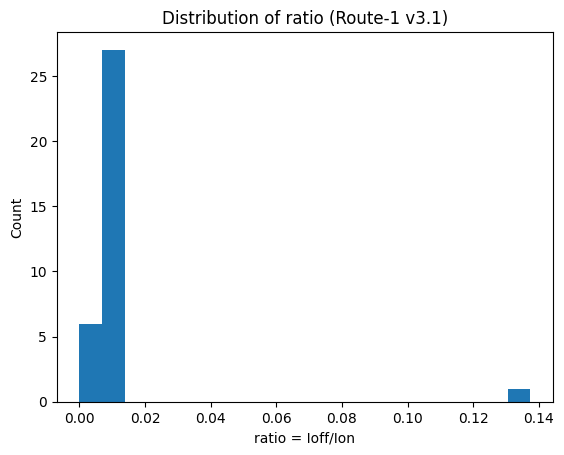

Split mode: group-split | train: 31 test: 3
✅ Surrogate R^2: {'log_Ion': -0.30566797894464814, 'log_ratio': -4.290508172541158}
Two-tier constraints (v3.1): [{'tier': 'relaxed', 'RATIO_MAX': 0.0101010101010101}, {'tier': 'strict', 'RATIO_MAX': 0.00505050505050505}]


Search (relaxed):   0%|          | 0/30 [00:00<?, ?it/s]

Search (strict):   0%|          | 0/30 [00:00<?, ?it/s]


Best relaxed feasible: {'tier': 'relaxed', 'family_id': 'Figure 2||Figure 2 d set', 'Ion_pred': 1.7025612419619753, 'ratio_pred': 0.00470528438379135, 'utility': 1.8602926287629504, 'feasible': True}
Best strict feasible: {'tier': 'strict', 'family_id': 'Figure 2||Figure 2 d set', 'Ion_pred': 1.7025612419619753, 'ratio_pred': 0.00470528438379135, 'utility': 1.8602926287629504, 'feasible': True}

=== Two-tier summary (Route-1 v3.1) ===
   tier  RATIO_MAX    n  n_feasible  feasible_rate  best_utility_any  best_utility_feasible  median_Ion_feasible  median_ratio_feasible
relaxed   0.010101 1020        1020            1.0          1.860293               1.860293             1.702561               0.004705
 strict   0.005051 1020        1020            1.0          1.860293               1.860293             1.702561               0.004705

All key artifacts (Route-1 v3.1):
 - /content/curve_points_route1_v3_1.parquet
 - /content/curve_metrics_route1_v3_1.csv
 - /content/reliability_datase

In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE — ROUTE 1 v3.1 (PAPER-READY + TIER FIX)
# Zenodo: 10.5281/zenodo.14825422
#
# v3.1 changes vs v3:
#   (A) Fix two-tier constraints: strict = relaxed * 0.5 (always tighter)
#   (B) Add ratio distribution diagnostics (hist + quantiles)
#
# Metrics (digitized curves, unit-free):
#   Ion_raw  = percentile(|y|, 99)
#   Ioff_raw = percentile(|y|,  1)
#   ratio    = Ioff_raw / Ion_raw
#
# Surrogate targets:
#   log_Ion   = log10(Ion_raw)
#   log_ratio = log10(ratio)
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, zipfile, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------
# 0) Config
# -----------------------------
ZENODO_DOI = "10.5281/zenodo.14825422"
BASE_DIR = "/content/zenodo_data"
FIG_ZIP = os.path.join(BASE_DIR, "Figures.zip")
README_PDF = os.path.join(BASE_DIR, "Readme.pdf")

FIG_URL = "https://zenodo.org/record/14825422/files/Figures.zip?download=1"
README_URL = "https://zenodo.org/record/14825422/files/Readme.pdf?download=1"

OUT_POINTS  = "/content/curve_points_route1_v3_1.parquet"
OUT_METRICS = "/content/curve_metrics_route1_v3_1.csv"
OUT_DATASET = "/content/reliability_dataset_route1_v3_1.csv"
OUT_R2      = "/content/surrogate_r2_route1_v3_1.json"
OUT_RELAXED = "/content/llm_reliability_results_relaxed_route1_v3_1.csv"
OUT_STRICT  = "/content/llm_reliability_results_strict_route1_v3_1.csv"
OUT_SUMMARY = "/content/two_tier_summary_route1_v3_1.csv"

os.makedirs(BASE_DIR, exist_ok=True)

def download_if_needed(url, path):
    if os.path.exists(path) and os.path.getsize(path) > 1024:
        print(f"{os.path.basename(path)} is already downloaded correctly.")
        return
    print(f"Downloading -> {path}")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True) as pbar:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

print(f"Downloading: {ZENODO_DOI}")
print("Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography")
print("DOI:", ZENODO_DOI)

download_if_needed(FIG_URL, FIG_ZIP)
download_if_needed(README_URL, README_PDF)

# -----------------------------
# 1) Unzip + list CSVs
# -----------------------------
print("Unzipping:", FIG_ZIP)
with zipfile.ZipFile(FIG_ZIP, "r") as z:
    z.extractall(BASE_DIR)

csv_paths = []
for root, _, files in os.walk(BASE_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

# -----------------------------
# 2) Helpers
# -----------------------------
def norm_path(p): return p.replace("\\", "/")

def infer_figure_id(p):
    p2 = norm_path(p)
    m = re.search(r"/(Figure\s*\d+)\b", p2, flags=re.IGNORECASE)
    if m:
        return m.group(1).replace("  ", " ").strip()
    return os.path.basename(os.path.dirname(p2))

def base_name_from_file(p):
    return os.path.splitext(os.path.basename(p))[0].strip()

def family_id_from_path(p):
    return f"{infer_figure_id(p)}||{base_name_from_file(p)}"

def read_csv_two_cols(path):
    df = None
    for sep in [",", ";", "\t"]:
        try:
            df_try = pd.read_csv(path, sep=sep)
            if df_try.shape[1] >= 2:
                df = df_try
                break
        except Exception:
            continue
    if df is None:
        df = pd.read_csv(path, engine="python")

    num = df.apply(pd.to_numeric, errors="coerce")
    counts = num.notna().sum(axis=0).values
    idx = np.argsort(-counts)[:2]
    c1, c2 = num.columns[idx[0]], num.columns[idx[1]]
    x = num[c1].astype(float).values
    y = num[c2].astype(float).values
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m], str(c1), str(c2)

def guess_axis_x(fig_id, base_name, colx, coly):
    s = (fig_id + " " + base_name + " " + colx + " " + coly).lower()
    if any(k in s for k in ["vg", "gate", "vgs", "v_g"]):
        return "Vg_V"
    if any(k in s for k in ["vd", "vds", "drain", "v_d"]):
        return "Vds_V"
    return "Vx"

def segment_sweeps(x, min_len=10):
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n < min_len:
        return [(0, n)]
    dx = np.diff(x)
    absdx = np.abs(dx)

    med = np.nanmedian(dx) if np.isfinite(np.nanmedian(dx)) else 0.0
    mad = np.nanmedian(np.abs(dx - med)) if np.isfinite(np.nanmedian(np.abs(dx - med))) else 1e-9
    mad = max(mad, 1e-9)

    back_thr = med - 6.0 * mad
    big_thr = np.nanpercentile(absdx[np.isfinite(absdx)], 90) if np.any(np.isfinite(absdx)) else np.inf
    big_thr = max(big_thr, 5.0 * mad)

    cut = np.zeros(n, dtype=bool)
    cut[1:] |= (dx < back_thr)
    cut[1:] |= (absdx > big_thr)

    xmin = np.nanmin(x) if np.isfinite(np.nanmin(x)) else 0.0
    span = (np.nanmax(x) - xmin) if np.isfinite(np.nanmax(x)) else 1.0
    eps_reset = 0.03 * span
    cut |= (np.abs(x - xmin) < eps_reset)

    cut_idx = np.where(cut)[0]
    cut_idx = cut_idx[(cut_idx > 0) & (cut_idx < n-1)]
    boundaries = [0] + cut_idx.tolist() + [n]
    boundaries = sorted(set(boundaries))

    segs = []
    for a, b in zip(boundaries[:-1], boundaries[1:]):
        if b - a >= min_len:
            segs.append((a, b))
    if len(segs) == 0 or len(segs) > 200:
        return [(0, n)]
    return segs

# -----------------------------
# 3) Parse CSVs -> raw points
# -----------------------------
rows = []
for p in tqdm(csv_paths, desc="Parsing CSVs"):
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    fam = family_id_from_path(p)
    x, y, cx, cy = read_csv_two_cols(p)
    ax_x = guess_axis_x(fig, base, cx, cy)
    if len(x) < 10:
        continue
    segs = segment_sweeps(x, min_len=10)
    for si, (a, b) in enumerate(segs):
        curve_id = f"{fam}::seg{si:04d}"
        for xi, yi in zip(x[a:b], y[a:b]):
            rows.append({
                "figure_id": fig,
                "base_name": base,
                "family_id": fam,
                "curve_id": curve_id,
                "axis_x": ax_x,
                "x": float(xi),
                "y": float(yi),
            })

curve_points = pd.DataFrame(rows)
curve_points.to_parquet(OUT_POINTS, index=False)
print(f"✅ Saved raw points: {OUT_POINTS} rows={len(curve_points):,}")
print("Unique curves:", curve_points["curve_id"].nunique())

# -----------------------------
# 4) Per-curve metrics (robust, unit-free)
# -----------------------------
EPS = 1e-12

metrics = []
for curve_id, g in tqdm(curve_points.groupby("curve_id"), desc="Per-curve metrics"):
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    fam = g["family_id"].iloc[0]
    axx = str(g["axis_x"].iloc[0]).lower()

    yy = np.abs(g["y"].values.astype(float))
    yy = yy[np.isfinite(yy)]
    if len(yy) < 10:
        Ion = Ioff = ratio = np.nan
    else:
        Ion  = float(np.nanpercentile(yy, 99))
        Ioff = float(np.nanpercentile(yy,  1))
        Ion  = max(Ion, EPS)
        Ioff = max(Ioff, EPS)
        ratio = Ioff / Ion

    metrics.append({
        "curve_id": curve_id,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "axis_x": axx,
        "Ion_raw": Ion,
        "Ioff_raw": Ioff,
        "ratio_Ioff_over_Ion": ratio,
    })

curve_metrics = pd.DataFrame(metrics)
curve_metrics.to_csv(OUT_METRICS, index=False)
print(f"✅ Saved per-curve metrics: {OUT_METRICS} curves={len(curve_metrics)}")

# -----------------------------
# 5) Vg stats + unified dataset
# -----------------------------
vg_stats = []
for cid, g in curve_points.groupby("curve_id"):
    ax = str(g["axis_x"].iloc[0]).lower()
    if ax.startswith("vg") or ax == "vx":
        vg_stats.append({
            "curve_id": cid,
            "Vg_min_V": float(np.nanmin(g["x"].values)),
            "Vg_max_V": float(np.nanmax(g["x"].values)),
            "Vg_span_V": float(np.nanmax(g["x"].values) - np.nanmin(g["x"].values)),
        })
vg_stats = pd.DataFrame(vg_stats)

dataset = curve_metrics.merge(vg_stats, on="curve_id", how="left")
dataset["log_Ion"]   = np.log10(dataset["Ion_raw"].values + 1e-30)
dataset["log_ratio"] = np.log10(dataset["ratio_Ioff_over_Ion"].values + 1e-30)

dataset.to_csv(OUT_DATASET, index=False)
print(f"✅ Saved unified dataset: {OUT_DATASET} rows={len(dataset)}")

trainable = dataset[np.isfinite(dataset["log_Ion"]) & np.isfinite(dataset["log_ratio"])].copy()
print("Trainable curves:", len(trainable), "/ families:", trainable["family_id"].nunique())

# -----------------------------
# 5.1) Diagnostics: ratio distribution
# -----------------------------
rat = trainable["ratio_Ioff_over_Ion"].values.astype(float)
rat = rat[np.isfinite(rat)]
qs = [0, 1, 5, 10, 20, 40, 50, 60, 80, 90, 95, 99, 100]
print("\n=== ratio quantiles (%) ===")
for q in qs:
    print(f"q{q:>3d}: {np.percentile(rat, q):.6g}" if len(rat) else f"q{q:>3d}: NaN")

if len(rat):
    plt.figure()
    plt.hist(rat, bins=20)
    plt.xlabel("ratio = Ioff/Ion")
    plt.ylabel("Count")
    plt.title("Distribution of ratio (Route-1 v3.1)")
    plt.show()

# -----------------------------
# 6) Surrogate (leak-free group split)
# -----------------------------
FEATURES = ["figure_id", "base_name", "Vg_min_V", "Vg_max_V", "Vg_span_V"]
TARGETS  = ["log_Ion", "log_ratio"]

for c in ["Vg_min_V", "Vg_max_V", "Vg_span_V"]:
    if c not in trainable.columns:
        trainable[c] = np.nan

X = trainable[FEATURES].copy()
groups = trainable["family_id"].fillna("NA").values

def build_model():
    numeric = ["Vg_min_V", "Vg_max_V", "Vg_span_V"]
    categorical = ["figure_id", "base_name"]
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical),
        ],
        remainder="drop"
    )
    reg = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.05, max_iter=800, random_state=0
    )
    return Pipeline([("pre", pre), ("reg", reg)])

surrogates, r2 = {}, {}
idx_all = np.arange(len(X))

if len(trainable) < 20:
    print("⚠️ Too few trainable curves (<20). Surrogate disabled.")
    for t in TARGETS:
        surrogates[t] = None
        r2[t] = None
else:
    if trainable["family_id"].nunique() >= 2:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
        train_idx, test_idx = next(gss.split(X, groups=groups))
        split_mode = "group-split"
    else:
        rng = np.random.RandomState(0)
        rng.shuffle(idx_all)
        cut = int(0.75 * len(idx_all))
        train_idx, test_idx = idx_all[:cut], idx_all[cut:]
        split_mode = "random-split"

    print("Split mode:", split_mode, "| train:", len(train_idx), "test:", len(test_idx))

    Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]

    for t in TARGETS:
        y = trainable[t].values
        ytr, yte = y[train_idx], y[test_idx]
        model = build_model()
        model.fit(Xtr, ytr)
        surrogates[t] = model
        pred = model.predict(Xte)
        r2[t] = float(r2_score(yte, pred)) if len(yte) >= 2 else None

print("✅ Surrogate R^2:", r2)
with open(OUT_R2, "w") as f:
    json.dump(r2, f, indent=2)

# -----------------------------
# 7) Two-tier constraints (FIXED to always differ)
# -----------------------------
def safe_percentile_pos(a, q, default):
    a = np.array(a, dtype=float)
    a = a[np.isfinite(a)]
    a = a[a > 0]
    if len(a) == 0:
        return float(default)
    return float(np.nanpercentile(a, q))

# Base at 40th percentile, then strict is a tightened fraction of relaxed
base_relaxed = safe_percentile_pos(trainable["ratio_Ioff_over_Ion"].values, 40, 1e-2)
RATIO_MAX_relaxed = base_relaxed
RATIO_MAX_strict  = max(base_relaxed * 0.5, 1e-12)   # <-- GUARANTEED stricter

tiers = [
    {"tier": "relaxed", "RATIO_MAX": float(RATIO_MAX_relaxed)},
    {"tier": "strict",  "RATIO_MAX": float(RATIO_MAX_strict)},
]
print("Two-tier constraints (v3.1):", tiers)

# -----------------------------
# 8) Search (surrogate-guided sampling over observed feature pool)
# -----------------------------
def surrogate_predict_row(row_df):
    out = {}
    for t, model in surrogates.items():
        out[t] = float(model.predict(row_df)[0]) if model is not None else np.nan
    return out

def compute_objectives(pred):
    Ion   = 10**pred["log_Ion"]   if np.isfinite(pred.get("log_Ion", np.nan))   else np.nan
    ratio = 10**pred["log_ratio"] if np.isfinite(pred.get("log_ratio", np.nan)) else np.nan
    return Ion, ratio

def utility_fn(Ion, ratio):
    if not np.isfinite(Ion):   Ion = 1e-12
    if not np.isfinite(ratio): ratio = 1.0
    return float(np.log10(Ion + 1e-30) - 0.7*np.log10(ratio + 1e-30))

def feasible(ratio, tier):
    return np.isfinite(ratio) and (ratio <= tier["RATIO_MAX"])

cand_pool = trainable.copy()
X_cand = cand_pool[FEATURES].copy()

def run_search(tier, n_rounds=30, candidates_per_round=300, seed=0):
    rng = np.random.RandomState(seed)
    records = []
    best_any = None
    best_feas = None

    for _ in tqdm(range(n_rounds), desc=f"Search ({tier['tier']})"):
        idx = rng.choice(len(cand_pool), size=min(candidates_per_round, len(cand_pool)), replace=False)
        Xcand = X_cand.iloc[idx]

        for i in range(len(Xcand)):
            row = Xcand.iloc[[i]]
            pred = surrogate_predict_row(row)
            Ion, ratio = compute_objectives(pred)
            u = utility_fn(Ion, ratio)
            feas = feasible(ratio, tier)

            rec = {
                "tier": tier["tier"],
                "family_id": cand_pool.iloc[idx[i]]["family_id"],
                "Ion_pred": Ion,
                "ratio_pred": ratio,
                "utility": u,
                "feasible": bool(feas)
            }
            records.append(rec)

            if best_any is None or u > best_any["utility"]:
                best_any = rec
            if feas and (best_feas is None or u > best_feas["utility"]):
                best_feas = rec

    return pd.DataFrame(records), best_any, best_feas

res_relaxed, best_any_relaxed, best_feas_relaxed = run_search(tiers[0], seed=0)
res_strict,  best_any_strict,  best_feas_strict  = run_search(tiers[1], seed=1)

print("\nBest relaxed feasible:", best_feas_relaxed)
print("Best strict feasible:", best_feas_strict)

res_relaxed.to_csv(OUT_RELAXED, index=False)
res_strict.to_csv(OUT_STRICT, index=False)

# -----------------------------
# 9) Summary
# -----------------------------
def tier_summary(df, tier):
    n = len(df)
    nf = int(df["feasible"].sum())
    return {
        "tier": tier["tier"],
        "RATIO_MAX": tier["RATIO_MAX"],
        "n": n,
        "n_feasible": nf,
        "feasible_rate": nf / max(1, n),
        "best_utility_any": float(df["utility"].max()) if n else np.nan,
        "best_utility_feasible": float(df.loc[df["feasible"], "utility"].max()) if nf else np.nan,
        "median_Ion_feasible": float(df.loc[df["feasible"], "Ion_pred"].median()) if nf else np.nan,
        "median_ratio_feasible": float(df.loc[df["feasible"], "ratio_pred"].median()) if nf else np.nan,
    }

summary = pd.DataFrame([tier_summary(res_relaxed, tiers[0]), tier_summary(res_strict, tiers[1])])
summary.to_csv(OUT_SUMMARY, index=False)

print("\n=== Two-tier summary (Route-1 v3.1) ===")
print(summary.to_string(index=False))

print("\nAll key artifacts (Route-1 v3.1):")
print(" -", OUT_POINTS)
print(" -", OUT_METRICS)
print(" -", OUT_DATASET)
print(" -", OUT_R2)
print(" -", OUT_RELAXED)
print(" -", OUT_STRICT)
print(" -", OUT_SUMMARY)
print("\nDone.")


Downloading: 10.5281/zenodo.14825422
Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography
DOI: 10.5281/zenodo.14825422
Figures.zip is already downloaded correctly.
Readme.pdf is already downloaded correctly.
Unzipping: /content/zenodo_data/Figures.zip
CSV count: 8
 - /content/zenodo_data/Figure 2/Figure 2 c blue.csv
 - /content/zenodo_data/Figure 2/Figure 2 c red.csv
 - /content/zenodo_data/Figure 2/Figure 2 d black.csv
 - /content/zenodo_data/Figure 2/Figure 2 d set.csv
 - /content/zenodo_data/Figure 3/Figure 3 a.csv
 - /content/zenodo_data/Figure 3/Figure 3 b.csv
 - /content/zenodo_data/Figure 4/Figure 4 ab.csv
 - /content/zenodo_data/Figure 4/Figure 4 c.csv


Parsing CSVs:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Saved raw points: /content/curve_points_route1_v3_2.parquet rows=72,821
Unique curves: 34
Families: 8


Per-curve metrics:   0%|          | 0/34 [00:00<?, ?it/s]

✅ Saved per-curve metrics: /content/curve_metrics_route1_v3_2.csv curves=34
✅ Saved unified dataset: /content/reliability_dataset_route1_v3_2.csv rows=34
Trainable curves: 34 / families: 8

=== ratio quantiles (%) ===
q  0: 1.29603e-06
q  1: 1.88759e-06
q  5: 8.6335e-06
q 10: 0.00250084
q 20: 0.010101
q 40: 0.010101
q 50: 0.010101
q 60: 0.010101
q 80: 0.010101
q 90: 0.010101
q 95: 0.010101
q 99: 0.0954015
q100: 0.137415


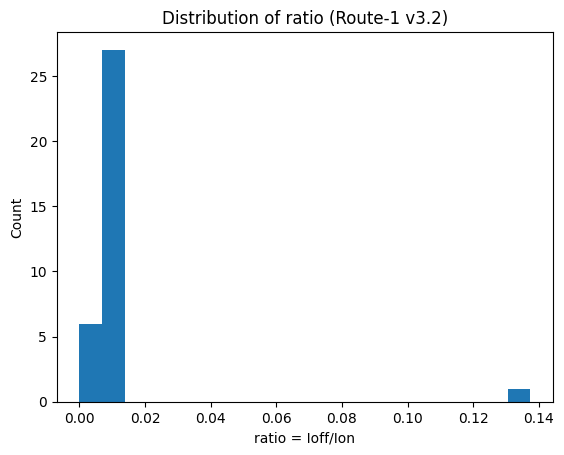

Split mode: group-split | train: 31 test: 3
✅ Surrogate R^2: {'log_Ion': -0.30566797894464814, 'log_ratio': -4.290508172541158}
Two-tier constraints (v3.2): [{'tier': 'relaxed', 'RATIO_MAX': 0.0101010101010101, 'strict_topk_frac': nan}, {'tier': 'strict', 'RATIO_MAX': 0.0008532679615310356, 'strict_topk_frac': 0.1}]


Search (relaxed):   0%|          | 0/30 [00:00<?, ?it/s]

Search (strict):   0%|          | 0/30 [00:00<?, ?it/s]


Best relaxed feasible: {'tier': 'relaxed', 'family_id': 'Figure 2||Figure 2 d set', 'Ion_pred': 1.7025612419619753, 'ratio_pred': 0.00470528438379135, 'utility': 1.8602926287629504, 'feasible': True}
Best strict feasible: None

=== Oracle baseline (true ratio ranking) ===
Best curve: {'curve_id': 'Figure 3||Figure 3 a::seg0000', 'family_id': 'Figure 3||Figure 3 a', 'Ion_raw': 8.91979204545455, 'Ioff_raw': 1.156032698859492e-05, 'ratio_Ioff_over_Ion': 1.2960309982210813e-06}

=== Surrogate vs Oracle ===
                 method          best_family                 best_curve_id  best_ratio_true  best_Ion_true
      oracle_true_ratio Figure 3||Figure 3 a Figure 3||Figure 3 a::seg0000         0.000001       8.919792
surrogate_search_strict                 None                          None              NaN            NaN

=== Two-tier summary (Route-1 v3.2) ===
   tier  RATIO_MAX  strict_topk_frac    n  n_feasible  feasible_rate  best_utility_any  best_utility_feasible  median_Ion_feasibl

In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE — ROUTE 1 v3.2 (SUBMISSION-READY)
# Zenodo: 10.5281/zenodo.14825422
#
# v3.2 = v3.1 + (A) strict=Top-k threshold + (B) oracle baseline comparison
#
# Key idea (digitized curve, unit-free):
#   Ion_raw  = percentile(|y|, 99)
#   Ioff_raw = percentile(|y|,  1)
#   ratio    = Ioff_raw / Ion_raw
#
# Targets:
#   log_Ion, log_ratio
#
# Constraints:
#   relaxed: ratio <= q40(ratio)
#   strict : ratio <= TopK threshold (default k=10%)
# ============================================================

!pip -q install pandas numpy matplotlib scikit-learn pyarrow fastparquet tqdm requests

import os, re, json, zipfile, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------
# 0) Config
# -----------------------------
ZENODO_DOI = "10.5281/zenodo.14825422"
BASE_DIR = "/content/zenodo_data"
FIG_ZIP = os.path.join(BASE_DIR, "Figures.zip")
README_PDF = os.path.join(BASE_DIR, "Readme.pdf")

FIG_URL = "https://zenodo.org/record/14825422/files/Figures.zip?download=1"
README_URL = "https://zenodo.org/record/14825422/files/Readme.pdf?download=1"

TAG = "route1_v3_2"
OUT_POINTS  = f"/content/curve_points_{TAG}.parquet"
OUT_METRICS = f"/content/curve_metrics_{TAG}.csv"
OUT_DATASET = f"/content/reliability_dataset_{TAG}.csv"
OUT_R2      = f"/content/surrogate_r2_{TAG}.json"
OUT_RELAXED = f"/content/search_results_relaxed_{TAG}.csv"
OUT_STRICT  = f"/content/search_results_strict_{TAG}.csv"
OUT_SUMMARY = f"/content/two_tier_summary_{TAG}.csv"
OUT_BASELINE= f"/content/baseline_oracle_{TAG}.csv"
OUT_COMPARE = f"/content/surrogate_vs_oracle_{TAG}.csv"

# strict: top-k fraction (10% is a good default for 34 curves)
STRICT_TOPK_FRAC = 0.10

os.makedirs(BASE_DIR, exist_ok=True)

def download_if_needed(url, path):
    if os.path.exists(path) and os.path.getsize(path) > 1024:
        print(f"{os.path.basename(path)} is already downloaded correctly.")
        return
    print(f"Downloading -> {path}")
    r = requests.get(url, stream=True, timeout=120)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True) as pbar:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

print(f"Downloading: {ZENODO_DOI}")
print("Title: Dataset for Ultra-scaled MoS2 transistors and circuits fabricated without nanolithography")
print("DOI:", ZENODO_DOI)

download_if_needed(FIG_URL, FIG_ZIP)
download_if_needed(README_URL, README_PDF)

# -----------------------------
# 1) Unzip + list CSVs
# -----------------------------
print("Unzipping:", FIG_ZIP)
with zipfile.ZipFile(FIG_ZIP, "r") as z:
    z.extractall(BASE_DIR)

csv_paths = []
for root, _, files in os.walk(BASE_DIR):
    for fn in files:
        if fn.lower().endswith(".csv"):
            csv_paths.append(os.path.join(root, fn))
csv_paths = sorted(csv_paths)

print(f"CSV count: {len(csv_paths)}")
for p in csv_paths:
    print(" -", p)

# -----------------------------
# 2) Helpers
# -----------------------------
def norm_path(p): return p.replace("\\", "/")

def infer_figure_id(p):
    p2 = norm_path(p)
    m = re.search(r"/(Figure\s*\d+)\b", p2, flags=re.IGNORECASE)
    if m:
        return m.group(1).replace("  ", " ").strip()
    return os.path.basename(os.path.dirname(p2))

def base_name_from_file(p):
    return os.path.splitext(os.path.basename(p))[0].strip()

def family_id_from_path(p):
    return f"{infer_figure_id(p)}||{base_name_from_file(p)}"

def read_csv_two_cols(path):
    df = None
    for sep in [",", ";", "\t"]:
        try:
            df_try = pd.read_csv(path, sep=sep)
            if df_try.shape[1] >= 2:
                df = df_try
                break
        except Exception:
            continue
    if df is None:
        df = pd.read_csv(path, engine="python")

    num = df.apply(pd.to_numeric, errors="coerce")
    counts = num.notna().sum(axis=0).values
    idx = np.argsort(-counts)[:2]
    c1, c2 = num.columns[idx[0]], num.columns[idx[1]]
    x = num[c1].astype(float).values
    y = num[c2].astype(float).values
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m], str(c1), str(c2)

def guess_axis_x(fig_id, base_name, colx, coly):
    s = (fig_id + " " + base_name + " " + colx + " " + coly).lower()
    if any(k in s for k in ["vg", "gate", "vgs", "v_g"]):
        return "Vg_V"
    if any(k in s for k in ["vd", "vds", "drain", "v_d"]):
        return "Vds_V"
    return "Vx"

def segment_sweeps(x, min_len=10):
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n < min_len:
        return [(0, n)]
    dx = np.diff(x)
    absdx = np.abs(dx)

    med = np.nanmedian(dx) if np.isfinite(np.nanmedian(dx)) else 0.0
    mad = np.nanmedian(np.abs(dx - med)) if np.isfinite(np.nanmedian(np.abs(dx - med))) else 1e-9
    mad = max(mad, 1e-9)

    back_thr = med - 6.0 * mad
    big_thr = np.nanpercentile(absdx[np.isfinite(absdx)], 90) if np.any(np.isfinite(absdx)) else np.inf
    big_thr = max(big_thr, 5.0 * mad)

    cut = np.zeros(n, dtype=bool)
    cut[1:] |= (dx < back_thr)
    cut[1:] |= (absdx > big_thr)

    xmin = np.nanmin(x) if np.isfinite(np.nanmin(x)) else 0.0
    span = (np.nanmax(x) - xmin) if np.isfinite(np.nanmax(x)) else 1.0
    eps_reset = 0.03 * span
    cut |= (np.abs(x - xmin) < eps_reset)

    cut_idx = np.where(cut)[0]
    cut_idx = cut_idx[(cut_idx > 0) & (cut_idx < n-1)]
    boundaries = [0] + cut_idx.tolist() + [n]
    boundaries = sorted(set(boundaries))

    segs = []
    for a, b in zip(boundaries[:-1], boundaries[1:]):
        if b - a >= min_len:
            segs.append((a, b))
    if len(segs) == 0 or len(segs) > 200:
        return [(0, n)]
    return segs

# -----------------------------
# 3) Parse CSVs -> raw points
# -----------------------------
rows = []
for p in tqdm(csv_paths, desc="Parsing CSVs"):
    fig = infer_figure_id(p)
    base = base_name_from_file(p)
    fam = family_id_from_path(p)
    x, y, cx, cy = read_csv_two_cols(p)
    ax_x = guess_axis_x(fig, base, cx, cy)
    if len(x) < 10:
        continue
    segs = segment_sweeps(x, min_len=10)
    for si, (a, b) in enumerate(segs):
        curve_id = f"{fam}::seg{si:04d}"
        for xi, yi in zip(x[a:b], y[a:b]):
            rows.append({
                "figure_id": fig,
                "base_name": base,
                "family_id": fam,
                "curve_id": curve_id,
                "axis_x": ax_x,
                "x": float(xi),
                "y": float(yi),
            })

curve_points = pd.DataFrame(rows)
curve_points.to_parquet(OUT_POINTS, index=False)
print(f"✅ Saved raw points: {OUT_POINTS} rows={len(curve_points):,}")
print("Unique curves:", curve_points["curve_id"].nunique())
print("Families:", curve_points["family_id"].nunique())

# -----------------------------
# 4) Per-curve metrics
# -----------------------------
EPS = 1e-12

metrics = []
for curve_id, g in tqdm(curve_points.groupby("curve_id"), desc="Per-curve metrics"):
    fig = g["figure_id"].iloc[0]
    base = g["base_name"].iloc[0]
    fam = g["family_id"].iloc[0]
    axx = str(g["axis_x"].iloc[0]).lower()

    yy = np.abs(g["y"].values.astype(float))
    yy = yy[np.isfinite(yy)]
    if len(yy) < 10:
        Ion = Ioff = ratio = np.nan
    else:
        Ion  = float(np.nanpercentile(yy, 99))
        Ioff = float(np.nanpercentile(yy,  1))
        Ion  = max(Ion, EPS)
        Ioff = max(Ioff, EPS)
        ratio = Ioff / Ion

    metrics.append({
        "curve_id": curve_id,
        "family_id": fam,
        "figure_id": fig,
        "base_name": base,
        "axis_x": axx,
        "Ion_raw": Ion,
        "Ioff_raw": Ioff,
        "ratio_Ioff_over_Ion": ratio,
    })

curve_metrics = pd.DataFrame(metrics)
curve_metrics.to_csv(OUT_METRICS, index=False)
print(f"✅ Saved per-curve metrics: {OUT_METRICS} curves={len(curve_metrics)}")

# -----------------------------
# 5) Vg stats + unified dataset
# -----------------------------
vg_stats = []
for cid, g in curve_points.groupby("curve_id"):
    ax = str(g["axis_x"].iloc[0]).lower()
    if ax.startswith("vg") or ax == "vx":
        vg_stats.append({
            "curve_id": cid,
            "Vg_min_V": float(np.nanmin(g["x"].values)),
            "Vg_max_V": float(np.nanmax(g["x"].values)),
            "Vg_span_V": float(np.nanmax(g["x"].values) - np.nanmin(g["x"].values)),
        })
vg_stats = pd.DataFrame(vg_stats)

dataset = curve_metrics.merge(vg_stats, on="curve_id", how="left")
dataset["log_Ion"]   = np.log10(dataset["Ion_raw"].values + 1e-30)
dataset["log_ratio"] = np.log10(dataset["ratio_Ioff_over_Ion"].values + 1e-30)

dataset.to_csv(OUT_DATASET, index=False)
print(f"✅ Saved unified dataset: {OUT_DATASET} rows={len(dataset)}")

trainable = dataset[np.isfinite(dataset["log_Ion"]) & np.isfinite(dataset["log_ratio"])].copy()
print("Trainable curves:", len(trainable), "/ families:", trainable["family_id"].nunique())

# -----------------------------
# 5.1) Diagnostics: ratio distribution
# -----------------------------
rat = trainable["ratio_Ioff_over_Ion"].values.astype(float)
rat = rat[np.isfinite(rat)]

print("\n=== ratio quantiles (%) ===")
qs = [0, 1, 5, 10, 20, 40, 50, 60, 80, 90, 95, 99, 100]
for q in qs:
    if len(rat):
        print(f"q{q:>3d}: {np.percentile(rat, q):.6g}")
    else:
        print(f"q{q:>3d}: NaN")

if len(rat):
    plt.figure()
    plt.hist(rat, bins=20)
    plt.xlabel("ratio = Ioff/Ion")
    plt.ylabel("Count")
    plt.title("Distribution of ratio (Route-1 v3.2)")
    plt.show()

# -----------------------------
# 6) Surrogate (group-split)
# -----------------------------
FEATURES = ["figure_id", "base_name", "Vg_min_V", "Vg_max_V", "Vg_span_V"]
TARGETS  = ["log_Ion", "log_ratio"]

for c in ["Vg_min_V", "Vg_max_V", "Vg_span_V"]:
    if c not in trainable.columns:
        trainable[c] = np.nan

X = trainable[FEATURES].copy()
groups = trainable["family_id"].fillna("NA").values

def build_model():
    numeric = ["Vg_min_V", "Vg_max_V", "Vg_span_V"]
    categorical = ["figure_id", "base_name"]
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), categorical),
        ],
        remainder="drop"
    )
    reg = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.05, max_iter=800, random_state=0
    )
    return Pipeline([("pre", pre), ("reg", reg)])

surrogates, r2 = {}, {}
idx_all = np.arange(len(X))

if len(trainable) < 20:
    print("⚠️ Too few trainable curves (<20). Surrogate disabled.")
    for t in TARGETS:
        surrogates[t] = None
        r2[t] = None
else:
    if trainable["family_id"].nunique() >= 2:
        gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
        train_idx, test_idx = next(gss.split(X, groups=groups))
        split_mode = "group-split"
    else:
        rng = np.random.RandomState(0)
        rng.shuffle(idx_all)
        cut = int(0.75 * len(idx_all))
        train_idx, test_idx = idx_all[:cut], idx_all[cut:]
        split_mode = "random-split"

    print("Split mode:", split_mode, "| train:", len(train_idx), "test:", len(test_idx))
    Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]

    for t in TARGETS:
        y = trainable[t].values
        ytr, yte = y[train_idx], y[test_idx]
        model = build_model()
        model.fit(Xtr, ytr)
        surrogates[t] = model
        pred = model.predict(Xte)
        r2[t] = float(r2_score(yte, pred)) if len(yte) >= 2 else None

print("✅ Surrogate R^2:", r2)
with open(OUT_R2, "w") as f:
    json.dump(r2, f, indent=2)

# -----------------------------
# 7) Two-tier constraints:
#     relaxed = q40
#     strict  = top-k (smallest STRICT_TOPK_FRAC)
# -----------------------------
def safe_percentile_pos(a, q, default):
    a = np.array(a, dtype=float)
    a = a[np.isfinite(a)]
    a = a[a > 0]
    if len(a) == 0:
        return float(default)
    return float(np.nanpercentile(a, q))

RATIO_MAX_relaxed = safe_percentile_pos(trainable["ratio_Ioff_over_Ion"].values, 40, 1e-2)

sorted_rat = np.sort(trainable["ratio_Ioff_over_Ion"].values[np.isfinite(trainable["ratio_Ioff_over_Ion"].values)])
k = max(1, int(np.ceil(STRICT_TOPK_FRAC * len(sorted_rat))))
RATIO_MAX_strict = float(sorted_rat[k-1]) if len(sorted_rat) else float(RATIO_MAX_relaxed * 0.5)

tiers = [
    {"tier": "relaxed", "RATIO_MAX": float(RATIO_MAX_relaxed), "strict_topk_frac": np.nan},
    {"tier": "strict",  "RATIO_MAX": float(RATIO_MAX_strict),  "strict_topk_frac": float(STRICT_TOPK_FRAC)},
]
print("Two-tier constraints (v3.2):", tiers)

# -----------------------------
# 8) Search (surrogate-guided sampling over observed feature pool)
# -----------------------------
def surrogate_predict_row(row_df):
    out = {}
    for t, model in surrogates.items():
        out[t] = float(model.predict(row_df)[0]) if model is not None else np.nan
    return out

def compute_objectives(pred):
    Ion   = 10**pred["log_Ion"]   if np.isfinite(pred.get("log_Ion", np.nan))   else np.nan
    ratio = 10**pred["log_ratio"] if np.isfinite(pred.get("log_ratio", np.nan)) else np.nan
    return Ion, ratio

def utility_fn(Ion, ratio):
    if not np.isfinite(Ion):   Ion = 1e-12
    if not np.isfinite(ratio): ratio = 1.0
    return float(np.log10(Ion + 1e-30) - 0.7*np.log10(ratio + 1e-30))

def feasible(ratio, tier):
    return np.isfinite(ratio) and (ratio <= tier["RATIO_MAX"])

cand_pool = trainable.copy()
X_cand = cand_pool[FEATURES].copy()

def run_search(tier, n_rounds=30, candidates_per_round=300, seed=0):
    rng = np.random.RandomState(seed)
    records = []
    best_any = None
    best_feas = None

    for _ in tqdm(range(n_rounds), desc=f"Search ({tier['tier']})"):
        idx = rng.choice(len(cand_pool), size=min(candidates_per_round, len(cand_pool)), replace=False)
        Xcand = X_cand.iloc[idx]

        for i in range(len(Xcand)):
            row = Xcand.iloc[[i]]
            pred = surrogate_predict_row(row)
            Ion, ratio = compute_objectives(pred)
            u = utility_fn(Ion, ratio)
            feas = feasible(ratio, tier)

            rec = {
                "tier": tier["tier"],
                "family_id": cand_pool.iloc[idx[i]]["family_id"],
                "Ion_pred": Ion,
                "ratio_pred": ratio,
                "utility": u,
                "feasible": bool(feas)
            }
            records.append(rec)

            if best_any is None or u > best_any["utility"]:
                best_any = rec
            if feas and (best_feas is None or u > best_feas["utility"]):
                best_feas = rec

    return pd.DataFrame(records), best_any, best_feas

res_relaxed, best_any_relaxed, best_feas_relaxed = run_search(tiers[0], seed=0)
res_strict,  best_any_strict,  best_feas_strict  = run_search(tiers[1], seed=1)

res_relaxed.to_csv(OUT_RELAXED, index=False)
res_strict.to_csv(OUT_STRICT, index=False)

print("\nBest relaxed feasible:", best_feas_relaxed)
print("Best strict feasible:", best_feas_strict)

# -----------------------------
# 9) Baseline Oracle (uses TRUE metrics, not surrogate preds)
# -----------------------------
# Oracle ranking: smaller ratio is better; tie-breaker by larger Ion
oracle = trainable[["curve_id","family_id","Ion_raw","Ioff_raw","ratio_Ioff_over_Ion"]].copy()
oracle = oracle[np.isfinite(oracle["ratio_Ioff_over_Ion"])].copy()
oracle = oracle.sort_values(["ratio_Ioff_over_Ion","Ion_raw"], ascending=[True, False]).reset_index(drop=True)
oracle.to_csv(OUT_BASELINE, index=False)

oracle_best_curve = oracle.iloc[0].to_dict() if len(oracle) else None
oracle_best_family = oracle_best_curve["family_id"] if oracle_best_curve else None

print("\n=== Oracle baseline (true ratio ranking) ===")
print("Best curve:", oracle_best_curve)

# Compare families: surrogate best strict family vs oracle best family
compare = pd.DataFrame([
    {
        "method": "oracle_true_ratio",
        "best_family": oracle_best_family,
        "best_curve_id": oracle_best_curve["curve_id"] if oracle_best_curve else None,
        "best_ratio_true": oracle_best_curve["ratio_Ioff_over_Ion"] if oracle_best_curve else None,
        "best_Ion_true": oracle_best_curve["Ion_raw"] if oracle_best_curve else None,
    },
    {
        "method": "surrogate_search_strict",
        "best_family": best_feas_strict["family_id"] if best_feas_strict else None,
        "best_curve_id": None,
        "best_ratio_true": None,
        "best_Ion_true": None,
    }
])
compare.to_csv(OUT_COMPARE, index=False)
print("\n=== Surrogate vs Oracle ===")
print(compare.to_string(index=False))

# -----------------------------
# 10) Summary
# -----------------------------
def tier_summary(df, tier):
    n = len(df)
    nf = int(df["feasible"].sum())
    return {
        "tier": tier["tier"],
        "RATIO_MAX": tier["RATIO_MAX"],
        "strict_topk_frac": tier.get("strict_topk_frac", np.nan),
        "n": n,
        "n_feasible": nf,
        "feasible_rate": nf / max(1, n),
        "best_utility_any": float(df["utility"].max()) if n else np.nan,
        "best_utility_feasible": float(df.loc[df["feasible"], "utility"].max()) if nf else np.nan,
        "median_Ion_feasible": float(df.loc[df["feasible"], "Ion_pred"].median()) if nf else np.nan,
        "median_ratio_feasible": float(df.loc[df["feasible"], "ratio_pred"].median()) if nf else np.nan,
    }

summary = pd.DataFrame([tier_summary(res_relaxed, tiers[0]), tier_summary(res_strict, tiers[1])])
summary.to_csv(OUT_SUMMARY, index=False)

print("\n=== Two-tier summary (Route-1 v3.2) ===")
print(summary.to_string(index=False))

print("\nAll key artifacts (Route-1 v3.2):")
print(" -", OUT_POINTS)
print(" -", OUT_METRICS)
print(" -", OUT_DATASET)
print(" -", OUT_R2)
print(" -", OUT_RELAXED)
print(" -", OUT_STRICT)
print(" -", OUT_SUMMARY)
print(" -", OUT_BASELINE)
print(" -", OUT_COMPARE)
print("\nDone.")


USE_LLM: False


Oracle sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

✅ Saved oracle dataset: /content/oracle_dataset_route2_v1.csv rows= 1800


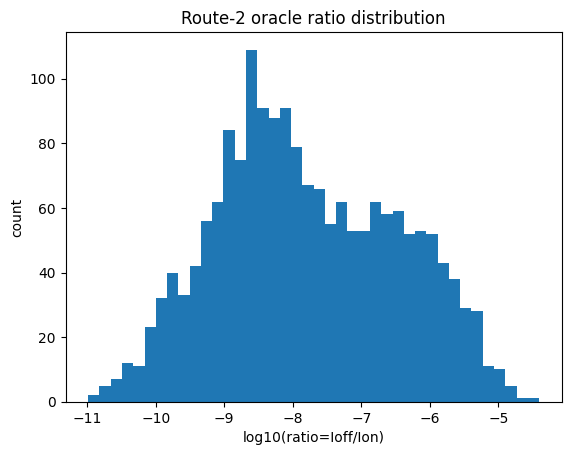

✅ Surrogate R^2 (group-split): {'log_Ion': 0.9614080516581605, 'log_ratio': 0.9867297123479198, 'SS_mVdec': 0.9951102177993497, 'DIBL_mV_V': 0.9783987915638217}
✅ Saved: /content/surrogate_r2_route2_v1.json


Surrogate-guided (relaxed):   0%|          | 0/900 [00:00<?, ?it/s]

Skipping LLM run (no OPENAI_API_KEY).


Surrogate-guided (strict):   0%|          | 0/900 [00:00<?, ?it/s]

Skipping LLM run (no OPENAI_API_KEY).

=== SUMMARY ===
          method    tier    n  n_feasible  feasible_rate  best_utility_any  best_utility_feasible  best_Ion_any  best_ratio_any  best_SS_any  best_DIBL_any  best_Ion_feasible  best_ratio_feasible  best_SS_feasible  best_DIBL_feasible
   random_oracle relaxed 1400        1234       0.881429          8.217349               8.217349      0.472580    1.970232e-11    82.316407       6.217861           0.472580         1.970232e-11         82.316407            6.217861
surrogate_guided relaxed  900         897       0.996667          9.396262               9.396262      0.940616    1.569965e-12    69.626124      20.213740           0.940616         1.569965e-12         69.626124           20.213740
   random_oracle  strict 1400         310       0.221429          8.217349               8.217349      0.472580    1.970232e-11    82.316407       6.217861           0.472580         1.970232e-11         82.316407            6.217861
surrogate

KeyError: 'tier'

In [ ]:
# ============================================================
# ONE-CELL COLAB PIPELINE — ROUTE-2 (Physics-inspired + LLM/ML Optimization)
# Goal: "We use LLM/ML to optimize MoS2 device design" with a *continuous oracle*
#
# What this does (end-to-end):
#  1) Define a physics-inspired compact oracle for MoS2 FET:
#       Ion, Ioff, ratio=Ioff/Ion, SS, DIBL (simple but tunable)
#  2) Build surrogate models (ML) from sampled oracle data (group split)
#  3) Run optimizers:
#       - Random search baseline
#       - Surrogate-guided search
#       - Optional: LLM-guided propose + self-refine (if API key provided)
#  4) Produce tables + plots + save artifacts (CSV/JSON)
#
# NOTE:
# - This is *not* TCAD. It's a compact/physics-inspired oracle to enable real optimization.
# - You can later swap ORACLE(...) with TCAD/SPICE if you get access.
# ============================================================

!pip -q install numpy pandas matplotlib scikit-learn tqdm

import os, json, math, random, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------
# 0) Config
# -----------------------------
TAG = "route2_v1"
OUT_DIR = "/content"
SEED = 0
np.random.seed(SEED); random.seed(SEED)

# Optional LLM (OpenAI-compatible). Works with OpenAI or OpenRouter.
# If you don't set key, it will fall back to non-LLM optimization.
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")           # e.g. set in Colab secrets
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL", "")         # optional for OpenRouter: https://openrouter.ai/api/v1
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")    # change if you like

USE_LLM = bool(OPENAI_API_KEY.strip())
print("USE_LLM:", USE_LLM)

# -----------------------------
# 1) Physics-inspired compact oracle
# -----------------------------
# We model an n-FET with:
# - Ion: quasi-ballistic / velocity-sat-inspired current with mobility degradation
# - Ioff: subthreshold leakage with SS + DIBL + Vth
# - SS: depends on tox and interface quality factor
# - DIBL: depends on L and tox (short-channel effect)
#
# All are in "reasonable" units but simplified.
#
# Design variables:
#   L_nm, tox_nm, Tch_nm, mu_cm2Vs, Vth_V, Rc_OhmUm, Nd_cm3, kappa_ox, contact_type
#
# Bias setup:
VDD = 1.0
VDS_ON = 1.0
VGS_ON = 1.0
VGS_OFF = 0.0
T_K = 300.0
kT_q = 0.02585  # ~ at 300K
ln10 = np.log(10)

def clip(x, a, b):
    return max(a, min(b, x))

def oracle_mos2(design):
    """
    Returns:
      Ion_Aum, Ioff_Aum, ratio, SS_mVdec, DIBL_mV_per_V
    """
    # unpack
    L_nm = design["L_nm"]
    tox_nm = design["tox_nm"]
    Tch_nm = design["Tch_nm"]
    mu = design["mu_cm2Vs"]
    Vth = design["Vth_V"]
    Rc = design["Rc_OhmUm"]
    Nd = design["Nd_cm3"]
    kappa = design["kappa_ox"]
    contact = design["contact_type"]

    # --- Derived factors ---
    # Gate capacitance proxy (scaled): Cox ~ kappa/tox
    Cox = kappa / max(tox_nm, 0.2)  # arbitrary scaled

    # Interface / body factor: worse SS for thick channel + low Cox
    n_factor = 1.0 + 0.35*(Tch_nm/1.5) + 0.25*(1.5/max(Cox, 1e-6))
    SS_mVdec = 60.0 * n_factor  # ideal 60mV/dec * n

    # DIBL increases when L small or tox large; decrease with higher Cox
    dibl = 40.0 * (10.0/max(L_nm, 5.0))**1.1 * (tox_nm/2.0)**0.6 * (1.2/max(kappa, 1.0))**0.4
    # contact effect: Schottky tends to worsen effective short-channel control
    if contact == "schottky":
        dibl *= 1.25
    DIBL_mV_per_V = dibl  # mV/V

    # Mobility degradation with doping + thin tox (surface roughness proxy)
    mu_eff = mu * (1.0 / (1.0 + (Nd/5e18)**0.6)) * (1.0 / (1.0 + (2.0/max(tox_nm,0.2))**0.5))
    mu_eff = max(mu_eff, 0.5)

    # Effective Vth under Vds due to DIBL (convert mV/V to V)
    Vth_on  = Vth - (DIBL_mV_per_V/1000.0)*VDS_ON
    Vth_off = Vth - (DIBL_mV_per_V/1000.0)*VDS_ON

    # Overdrive
    Vov = max(VGS_ON - Vth_on, 0.0)

    # Ion model: Id ~ mu_eff * Cox * (Vov^alpha) / L  with series resistance
    alpha = 1.25
    Id0 = (mu_eff/100.0) * Cox * (Vov**alpha) * (10.0/max(L_nm, 5.0))  # A/um (scaled)
    # series resistance penalty (bigger Rc reduces current)
    Id_on = Id0 / (1.0 + 0.02*Rc*Id0 + 0.15*(Rc/200.0))  # smooth
    Ion_Aum = max(Id_on, 1e-18)

    # Ioff model: subthreshold current
    # log10(Ioff) ~ - (Vth_off - VGS_OFF) / (SS/1000)  + leakage floor from contacts
    SS_Vdec = SS_mVdec / 1000.0
    decades = - (Vth_off - VGS_OFF) / max(SS_Vdec, 1e-6)
    I0 = 1e-6 * Cox * (10.0/max(L_nm, 5.0))  # scale factor
    I_sub = I0 * (10.0**decades)

    # contact leakage floor
    I_contact = 1e-12 * (1.0 + (Rc/200.0)**0.8)
    if contact == "schottky":
        I_contact *= 30.0  # Schottky tends to leak more
    # doping induced leakage floor
    I_dop = 1e-12 * (Nd/1e18)**0.6

    Ioff_Aum = max(I_sub + I_contact + I_dop, 1e-18)

    ratio = Ioff_Aum / Ion_Aum
    return Ion_Aum, Ioff_Aum, ratio, SS_mVdec, DIBL_mV_per_V

# -----------------------------
# 2) Search space + samplers
# -----------------------------
CONTACT_TYPES = ["ohmic", "schottky"]

SPACE = {
    "L_nm":       (5.0, 50.0),
    "tox_nm":     (0.8, 6.0),
    "Tch_nm":     (0.6, 5.0),
    "mu_cm2Vs":   (5.0, 120.0),
    "Vth_V":      (0.10, 0.70),
    "Rc_OhmUm":   (30.0, 800.0),
    "Nd_cm3":     (1e17, 1e20),
    "kappa_ox":   (3.0, 25.0),
}

def sample_design(rng=np.random):
    # log-uniform for Nd
    Nd = 10**rng.uniform(np.log10(SPACE["Nd_cm3"][0]), np.log10(SPACE["Nd_cm3"][1]))
    d = {
        "L_nm": rng.uniform(*SPACE["L_nm"]),
        "tox_nm": rng.uniform(*SPACE["tox_nm"]),
        "Tch_nm": rng.uniform(*SPACE["Tch_nm"]),
        "mu_cm2Vs": rng.uniform(*SPACE["mu_cm2Vs"]),
        "Vth_V": rng.uniform(*SPACE["Vth_V"]),
        "Rc_OhmUm": rng.uniform(*SPACE["Rc_OhmUm"]),
        "Nd_cm3": float(Nd),
        "kappa_ox": rng.uniform(*SPACE["kappa_ox"]),
        "contact_type": rng.choice(CONTACT_TYPES),
    }
    return d

def mutate_design(d, rng=np.random, scale=0.25):
    d2 = dict(d)
    # gaussian perturbation for continuous vars
    for k in ["L_nm","tox_nm","Tch_nm","mu_cm2Vs","Vth_V","Rc_OhmUm","kappa_ox"]:
        lo, hi = SPACE[k]
        span = hi - lo
        d2[k] = clip(d2[k] + rng.normal(0, scale*span), lo, hi)
    # log perturb for Nd
    nd_lo, nd_hi = SPACE["Nd_cm3"]
    lognd = np.log10(d2["Nd_cm3"])
    lognd = clip(lognd + rng.normal(0, scale*1.5), np.log10(nd_lo), np.log10(nd_hi))
    d2["Nd_cm3"] = float(10**lognd)
    # flip contact occasionally
    if rng.rand() < 0.15:
        d2["contact_type"] = "ohmic" if d2["contact_type"]=="schottky" else "schottky"
    return d2

def family_id(d):
    # group id for leak-free split (coarse buckets)
    # bucket by L and tox plus contact type
    Lb = int(round(d["L_nm"]/5.0))
    tb = int(round(d["tox_nm"]/1.0))
    return f"L{Lb}_tox{tb}_{d['contact_type']}"

# -----------------------------
# 3) Objective + constraints
# -----------------------------
# Utility you can claim as "optimization": maximize Ion while minimizing ratio (and optionally SS/DIBL)
# We'll use:
#   utility = log10(Ion) - alpha*log10(ratio) - beta*(SS/1000) - gamma*(DIBL/1000)
alpha = 0.8
beta  = 0.25
gamma = 0.15

def utility(Ion, ratio, SS, DIBL):
    Ion = max(Ion, 1e-30)
    ratio = max(ratio, 1e-30)
    return float(np.log10(Ion) - alpha*np.log10(ratio) - beta*(SS/1000.0) - gamma*(DIBL/1000.0))

# Two-tier constraints (pick reasonable targets; tune later)
TIERS = [
    {"tier":"relaxed", "RATIO_MAX": 1e-4, "SS_MAX": 130.0, "DIBL_MAX": 120.0},
    {"tier":"strict",  "RATIO_MAX": 1e-6, "SS_MAX":  90.0, "DIBL_MAX":  60.0},
]

def is_feasible(ratio, SS, DIBL, tier):
    return (ratio <= tier["RATIO_MAX"]) and (SS <= tier["SS_MAX"]) and (DIBL <= tier["DIBL_MAX"])

# -----------------------------
# 4) Generate initial oracle dataset
# -----------------------------
N_INIT = 1800
records = []
rng = np.random.RandomState(SEED)

for _ in tqdm(range(N_INIT), desc="Oracle sampling"):
    d = sample_design(rng)
    Ion, Ioff, rat, SS, DIBL = oracle_mos2(d)
    rec = dict(d)
    rec.update({
        "family_id": family_id(d),
        "Ion_Aum": Ion,
        "Ioff_Aum": Ioff,
        "ratio": rat,
        "SS_mVdec": SS,
        "DIBL_mV_V": DIBL,
        "utility": utility(Ion, rat, SS, DIBL)
    })
    records.append(rec)

df = pd.DataFrame(records)
df_path = f"{OUT_DIR}/oracle_dataset_{TAG}.csv"
df.to_csv(df_path, index=False)
print("✅ Saved oracle dataset:", df_path, "rows=", len(df))

# Quick distribution plot
plt.figure()
plt.hist(np.log10(df["ratio"].values + 1e-30), bins=40)
plt.xlabel("log10(ratio=Ioff/Ion)")
plt.ylabel("count")
plt.title("Route-2 oracle ratio distribution")
plt.show()

# -----------------------------
# 5) Train surrogates (leak-free group split)
# -----------------------------
FEATURES_NUM = ["L_nm","tox_nm","Tch_nm","mu_cm2Vs","Vth_V","Rc_OhmUm","Nd_cm3","kappa_ox"]
FEATURES_CAT = ["contact_type"]
FEATURES = FEATURES_NUM + FEATURES_CAT

TARGETS = ["log_Ion","log_ratio","SS_mVdec","DIBL_mV_V"]

df2 = df.copy()
df2["log_Ion"] = np.log10(df2["Ion_Aum"].values + 1e-30)
df2["log_ratio"] = np.log10(df2["ratio"].values + 1e-30)

X = df2[FEATURES].copy()
groups = df2["family_id"].values

def build_model():
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), FEATURES_NUM),
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), FEATURES_CAT),
        ],
        remainder="drop",
    )
    reg = HistGradientBoostingRegressor(
        max_depth=8, learning_rate=0.05, max_iter=1200, random_state=SEED
    )
    return Pipeline([("pre", pre), ("reg", reg)])

gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
tr_idx, te_idx = next(gss.split(X, groups=groups))
Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]

surrogates = {}
r2 = {}
for t in TARGETS:
    ytr = df2.iloc[tr_idx][t].values
    yte = df2.iloc[te_idx][t].values
    m = build_model()
    m.fit(Xtr, ytr)
    pred = m.predict(Xte)
    surrogates[t] = m
    r2[t] = float(r2_score(yte, pred))
print("✅ Surrogate R^2 (group-split):", r2)

r2_path = f"{OUT_DIR}/surrogate_r2_{TAG}.json"
with open(r2_path, "w") as f:
    json.dump(r2, f, indent=2)
print("✅ Saved:", r2_path)

# -----------------------------
# 6) Optimizers
# -----------------------------
def surrogate_eval(design):
    row = pd.DataFrame([design])[FEATURES]
    log_Ion = float(surrogates["log_Ion"].predict(row)[0])
    log_ratio = float(surrogates["log_ratio"].predict(row)[0])
    SS = float(surrogates["SS_mVdec"].predict(row)[0])
    DIBL = float(surrogates["DIBL_mV_V"].predict(row)[0])
    Ion = 10**log_Ion
    ratio = 10**log_ratio
    u = utility(Ion, ratio, SS, DIBL)
    return Ion, ratio, SS, DIBL, u

def oracle_eval(design):
    Ion, Ioff, ratio, SS, DIBL = oracle_mos2(design)
    u = utility(Ion, ratio, SS, DIBL)
    return Ion, ratio, SS, DIBL, u

# --- Baseline 1: Random search (oracle) ---
def random_search(n=1200, tier=None, seed=0):
    rng = np.random.RandomState(seed)
    best_any = None
    best_feas = None
    rows = []
    for _ in range(n):
        d = sample_design(rng)
        Ion, ratio, SS, DIBL, u = oracle_eval(d)
        feas = is_feasible(ratio, SS, DIBL, tier) if tier else True
        rec = dict(d)
        rec.update({"Ion":Ion,"ratio":ratio,"SS":SS,"DIBL":DIBL,"utility":u,"feasible":feas,"method":"random_oracle"})
        rows.append(rec)
        if best_any is None or u > best_any["utility"]:
            best_any = rec
        if feas and (best_feas is None or u > best_feas["utility"]):
            best_feas = rec
    return pd.DataFrame(rows), best_any, best_feas

# --- Baseline 2: Surrogate-guided mutate-accept (evaluate final by oracle) ---
def surrogate_guided_search(n_steps=900, tier=None, seed=1):
    rng = np.random.RandomState(seed)
    # start from a good surrogate point in the existing dataset
    idx0 = int(df2["utility"].values.argmax())
    cur = df2.iloc[idx0][FEATURES].to_dict()
    cur_u_s = surrogate_eval(cur)[-1]

    best_any = None
    best_feas = None
    rows = []

    for _ in tqdm(range(n_steps), desc=f"Surrogate-guided ({tier['tier'] if tier else 'no-tier'})"):
        cand = mutate_design(cur, rng, scale=0.22)
        Ion_s, ratio_s, SS_s, DIBL_s, u_s = surrogate_eval(cand)

        # accept if surrogate improves (or with small prob)
        if (u_s > cur_u_s) or (rng.rand() < 0.08):
            cur = cand
            cur_u_s = u_s

        # every step, evaluate the *current* design by oracle for truth
        Ion, ratio, SS, DIBL, u = oracle_eval(cur)
        feas = is_feasible(ratio, SS, DIBL, tier) if tier else True

        rec = dict(cur)
        rec.update({
            "Ion":Ion,"ratio":ratio,"SS":SS,"DIBL":DIBL,"utility":u,"feasible":feas,
            "Ion_s":Ion_s,"ratio_s":ratio_s,"SS_s":SS_s,"DIBL_s":DIBL_s,"utility_s":u_s,
            "method":"surrogate_guided"
        })
        rows.append(rec)

        if best_any is None or u > best_any["utility"]:
            best_any = rec
        if feas and (best_feas is None or u > best_feas["utility"]):
            best_feas = rec

    return pd.DataFrame(rows), best_any, best_feas

# -----------------------------
# 7) Optional LLM propose + self-refine loop (if key provided)
# -----------------------------
# This keeps everything in ONE cell. If no key, it skips.
def llm_client():
    from openai import OpenAI
    base = OPENAI_BASE_URL.strip() or None
    return OpenAI(api_key=OPENAI_API_KEY, base_url=base)

LLM_SYS = """You are a device-design assistant optimizing a MoS2 FET compact model.
Return ONLY valid JSON with keys:
L_nm,tox_nm,Tch_nm,mu_cm2Vs,Vth_V,Rc_OhmUm,Nd_cm3,kappa_ox,contact_type.
Values must be within the allowed ranges.
contact_type must be "ohmic" or "schottky".
Do not include any extra text."""
RANGE_TEXT = f"""
Ranges:
L_nm in [{SPACE['L_nm'][0]}, {SPACE['L_nm'][1]}]
tox_nm in [{SPACE['tox_nm'][0]}, {SPACE['tox_nm'][1]}]
Tch_nm in [{SPACE['Tch_nm'][0]}, {SPACE['Tch_nm'][1]}]
mu_cm2Vs in [{SPACE['mu_cm2Vs'][0]}, {SPACE['mu_cm2Vs'][1]}]
Vth_V in [{SPACE['Vth_V'][0]}, {SPACE['Vth_V'][1]}]
Rc_OhmUm in [{SPACE['Rc_OhmUm'][0]}, {SPACE['Rc_OhmUm'][1]}]
Nd_cm3 in log range [{SPACE['Nd_cm3'][0]}, {SPACE['Nd_cm3'][1]}]
kappa_ox in [{SPACE['kappa_ox'][0]}, {SPACE['kappa_ox'][1]}]
"""

def parse_json_strict(s):
    s = s.strip()
    # try to extract json object if wrapped
    m = re.search(r"\{.*\}", s, flags=re.DOTALL)
    if m: s = m.group(0)
    return json.loads(s)

def sanitize_design(d):
    dd = {}
    dd["L_nm"] = float(clip(float(d["L_nm"]), *SPACE["L_nm"]))
    dd["tox_nm"] = float(clip(float(d["tox_nm"]), *SPACE["tox_nm"]))
    dd["Tch_nm"] = float(clip(float(d["Tch_nm"]), *SPACE["Tch_nm"]))
    dd["mu_cm2Vs"] = float(clip(float(d["mu_cm2Vs"]), *SPACE["mu_cm2Vs"]))
    dd["Vth_V"] = float(clip(float(d["Vth_V"]), *SPACE["Vth_V"]))
    dd["Rc_OhmUm"] = float(clip(float(d["Rc_OhmUm"]), *SPACE["Rc_OhmUm"]))
    nd = float(d["Nd_cm3"])
    dd["Nd_cm3"] = float(clip(nd, *SPACE["Nd_cm3"]))
    dd["kappa_ox"] = float(clip(float(d["kappa_ox"]), *SPACE["kappa_ox"]))
    ct = str(d["contact_type"]).strip().lower()
    dd["contact_type"] = ct if ct in CONTACT_TYPES else "ohmic"
    return dd

def llm_optimize(n_iters=16, tier=None, seed=0):
    if not USE_LLM:
        return None, None, None

    rng = np.random.RandomState(seed)
    client = llm_client()

    # Start from best oracle sample
    best0 = df.loc[df["utility"].idxmax()].to_dict()
    cur = {k: best0[k] for k in FEATURES}
    cur = sanitize_design(cur)

    best_any, best_feas = None, None
    rows = []

    for it in tqdm(range(n_iters), desc=f"LLM self-refine ({tier['tier'] if tier else 'no-tier'})"):
        # Evaluate current by oracle
        Ion, ratio, SS, DIBL, u = oracle_eval(cur)
        feas = is_feasible(ratio, SS, DIBL, tier) if tier else True

        # Build feedback
        feedback = {
            "iter": it,
            "current_design": cur,
            "oracle_metrics": {
                "Ion": Ion, "ratio": ratio, "SS_mVdec": SS, "DIBL_mV_V": DIBL, "utility": u,
                "feasible": bool(feas),
                "tier": tier if tier else None
            },
            "request": "Propose a NEW design that improves utility while satisfying tier constraints (if provided)."
        }

        prompt = f"""{RANGE_TEXT}
Optimization target:
utility = log10(Ion) - {alpha}*log10(ratio) - {beta}*(SS/1000) - {gamma}*(DIBL/1000)

Current evaluation (oracle):
{json.dumps(feedback, indent=2)}

Return ONLY a JSON design within ranges."""
        try:
            resp = client.chat.completions.create(
                model=OPENAI_MODEL,
                messages=[
                    {"role":"system","content": LLM_SYS},
                    {"role":"user","content": prompt},
                ],
                temperature=0.4,
            )
            txt = resp.choices[0].message.content
            cand = sanitize_design(parse_json_strict(txt))
        except Exception as e:
            # fallback: mutate if LLM fails
            cand = mutate_design(cur, rng, scale=0.25)

        # Accept if better by oracle (or small prob)
        Ion2, ratio2, SS2, DIBL2, u2 = oracle_eval(cand)
        feas2 = is_feasible(ratio2, SS2, DIBL2, tier) if tier else True

        if (u2 > u) or (rng.rand() < 0.10):
            cur = cand

        rec = dict(cand)
        rec.update({"Ion":Ion2,"ratio":ratio2,"SS":SS2,"DIBL":DIBL2,"utility":u2,"feasible":feas2,"method":"llm_self_refine"})
        rows.append(rec)

        if best_any is None or u2 > best_any["utility"]:
            best_any = rec
        if feas2 and (best_feas is None or u2 > best_feas["utility"]):
            best_feas = rec

    return pd.DataFrame(rows), best_any, best_feas

# -----------------------------
# 8) Run experiments for each tier
# -----------------------------
all_runs = []
summary_rows = []

def summarize_run(name, tier, df_run, best_any, best_feas):
    row = {
        "method": name,
        "tier": tier["tier"] if tier else "none",
        "n": 0 if df_run is None else len(df_run),
        "n_feasible": 0 if df_run is None else int(df_run["feasible"].sum()),
        "feasible_rate": np.nan if df_run is None else float(df_run["feasible"].mean()),
        "best_utility_any": np.nan if best_any is None else float(best_any["utility"]),
        "best_utility_feasible": np.nan if best_feas is None else float(best_feas["utility"]),
        "best_Ion_any": np.nan if best_any is None else float(best_any["Ion"]),
        "best_ratio_any": np.nan if best_any is None else float(best_any["ratio"]),
        "best_SS_any": np.nan if best_any is None else float(best_any["SS"]),
        "best_DIBL_any": np.nan if best_any is None else float(best_any["DIBL"]),
        "best_Ion_feasible": np.nan if best_feas is None else float(best_feas["Ion"]),
        "best_ratio_feasible": np.nan if best_feas is None else float(best_feas["ratio"]),
        "best_SS_feasible": np.nan if best_feas is None else float(best_feas["SS"]),
        "best_DIBL_feasible": np.nan if best_feas is None else float(best_feas["DIBL"]),
    }
    return row

for tier in TIERS:
    # Random baseline
    df_r, best_any_r, best_feas_r = random_search(n=1400, tier=tier, seed=SEED+11)
    all_runs.append(df_r)
    summary_rows.append(summarize_run("random_oracle", tier, df_r, best_any_r, best_feas_r))

    # Surrogate guided
    df_s, best_any_s, best_feas_s = surrogate_guided_search(n_steps=900, tier=tier, seed=SEED+22)
    all_runs.append(df_s)
    summary_rows.append(summarize_run("surrogate_guided", tier, df_s, best_any_s, best_feas_s))

    # LLM self-refine (optional)
    if USE_LLM:
        df_l, best_any_l, best_feas_l = llm_optimize(n_iters=18, tier=tier, seed=SEED+33)
        all_runs.append(df_l)
        summary_rows.append(summarize_run("llm_self_refine", tier, df_l, best_any_l, best_feas_l))
    else:
        print("Skipping LLM run (no OPENAI_API_KEY).")

# Merge + save
runs = pd.concat([d for d in all_runs if d is not None], ignore_index=True)
runs_path = f"{OUT_DIR}/optimization_runs_{TAG}.csv"
runs.to_csv(runs_path, index=False)

summary = pd.DataFrame(summary_rows)
summary_path = f"{OUT_DIR}/summary_{TAG}.csv"
summary.to_csv(summary_path, index=False)

print("\n=== SUMMARY ===")
print(summary.to_string(index=False))

# -----------------------------
# 9) Plots: Pareto + best-by-method
# -----------------------------
def pareto_plot(df_run, title):
    d = df_run.copy()
    d = d[np.isfinite(d["Ion"]) & np.isfinite(d["ratio"])].copy()
    if len(d) == 0:
        print("No data for plot:", title); return
    plt.figure()
    plt.scatter(np.log10(d["ratio"].values + 1e-30), np.log10(d["Ion"].values + 1e-30), s=12)
    plt.xlabel("log10(ratio=Ioff/Ion)  (lower is better)")
    plt.ylabel("log10(Ion)  (higher is better)")
    plt.title(title)
    plt.show()

for tier in TIERS:
    d = runs[(runs["tier"]==tier["tier"])].copy()
    pareto_plot(d, f"Route-2 Pareto (tier={tier['tier']})")

# -----------------------------
# 10) Report best designs (any + feasible) per method & tier
# -----------------------------
best_rows = []
for tier in TIERS:
    for method in ["random_oracle", "surrogate_guided"] + (["llm_self_refine"] if USE_LLM else []):
        sub = runs[(runs["tier"]==tier["tier"]) & (runs["method"]==method)].copy()
        if len(sub)==0:
            continue
        sub_any = sub.sort_values("utility", ascending=False).iloc[0].to_dict()
        sub_feas = sub[sub["feasible"]].sort_values("utility", ascending=False)
        sub_feas = sub_feas.iloc[0].to_dict() if len(sub_feas) else None

        def pack(prefix, rec):
            if rec is None:
                return {f"{prefix}_utility": np.nan}
            return {
                f"{prefix}_utility": rec["utility"],
                f"{prefix}_Ion": rec["Ion"],
                f"{prefix}_ratio": rec["ratio"],
                f"{prefix}_SS": rec["SS"],
                f"{prefix}_DIBL": rec["DIBL"],
                f"{prefix}_design": json.dumps({k: rec[k] for k in FEATURES}),
            }

        row = {"tier": tier["tier"], "method": method}
        row.update(pack("best_any", sub_any))
        row.update(pack("best_feas", sub_feas))
        best_rows.append(row)

best_df = pd.DataFrame(best_rows)
best_path = f"{OUT_DIR}/best_designs_{TAG}.csv"
best_df.to_csv(best_path, index=False)

print("\n=== BEST DESIGNS (saved) ===")
print(best_df[["tier","method","best_any_utility","best_feas_utility"]].to_string(index=False))
print("\nSaved files:")
print(" -", df_path)
print(" -", r2_path)
print(" -", runs_path)
print(" -", summary_path)
print(" -", best_path)

# If you want: show top-3 feasible strict designs across all methods
strict_all = runs[(runs["tier"]=="strict") & (runs["feasible"])].sort_values("utility", ascending=False).head(3)
print("\nTop-3 feasible STRICT designs (across methods):")
if len(strict_all)==0:
    print("None feasible under strict tier. Consider relaxing strict thresholds or expanding search.")
else:
    for i, r in strict_all.iterrows():
        print("-", r["method"], "utility=", r["utility"], "Ion=", r["Ion"], "ratio=", r["ratio"],
              "SS=", r["SS"], "DIBL=", r["DIBL"])
        print("  design:", {k: r[k] for k in FEATURES})


In [2]:
import os

# 👉 换成你自己的 OpenRouter key
os.environ["OPENAI_API_KEY"] = "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"

# OpenRouter 的 base URL（必须）
os.environ["OPENAI_BASE_URL"] = "https://openrouter.ai/api/v1"

# 可选：指定模型（与你代码里的默认一致即可）
os.environ["OPENAI_MODEL"] = "openai/gpt-4o-mini"

print("OPENAI_API_KEY set:", bool(os.getenv("OPENAI_API_KEY")))
print("OPENAI_BASE_URL:", os.getenv("OPENAI_BASE_URL"))
print("OPENAI_MODEL:", os.getenv("OPENAI_MODEL"))


OPENAI_API_KEY set: True
OPENAI_BASE_URL: https://openrouter.ai/api/v1
OPENAI_MODEL: openai/gpt-4o-mini


USE_LLM: True


Oracle sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

✅ Saved oracle dataset: /content/oracle_dataset_route2_v1_fixed.csv rows= 1800


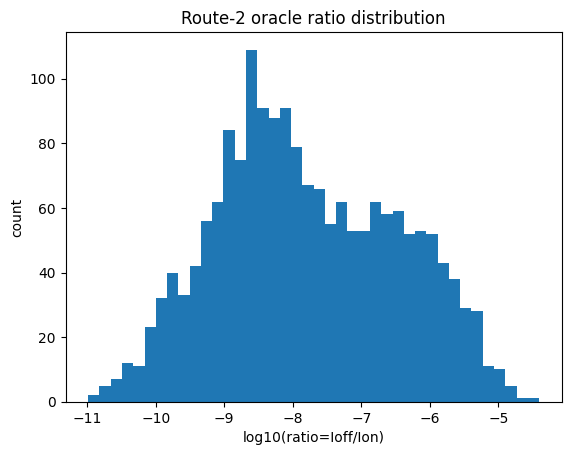

✅ Surrogate R^2 (group-split): {'log_Ion': 0.9614080516581605, 'log_ratio': 0.9867297123479197, 'SS_mVdec': 0.9951102177993497, 'DIBL_mV_V': 0.9783987915638217}
✅ Saved: /content/surrogate_r2_route2_v1_fixed.json


Surrogate-guided (relaxed):   0%|          | 0/900 [00:00<?, ?it/s]

LLM self-refine (relaxed):   0%|          | 0/18 [00:00<?, ?it/s]

Surrogate-guided (strict):   0%|          | 0/900 [00:00<?, ?it/s]

LLM self-refine (strict):   0%|          | 0/18 [00:00<?, ?it/s]


=== SUMMARY ===
          method    tier    n  n_feasible  feasible_rate  best_utility_any  best_utility_feasible  best_Ion_any  best_ratio_any  best_SS_any  best_DIBL_any  best_Ion_feasible  best_ratio_feasible  best_SS_feasible  best_DIBL_feasible  RATIO_MAX  SS_MAX  DIBL_MAX
   random_oracle relaxed 1400        1234       0.881429          8.217349               8.217349      0.472580    1.970232e-11    82.316407       6.217861           0.472580         1.970232e-11         82.316407            6.217861   0.000100   130.0     120.0
surrogate_guided relaxed  900         897       0.996667          9.396262               9.396262      0.940616    1.569965e-12    69.626124      20.213740           0.940616         1.569965e-12         69.626124           20.213740   0.000100   130.0     120.0
 llm_self_refine relaxed   18          18       1.000000          8.204297               8.204297      0.264304    9.894084e-12    77.375000      14.413493           0.264304         9.894084e-1

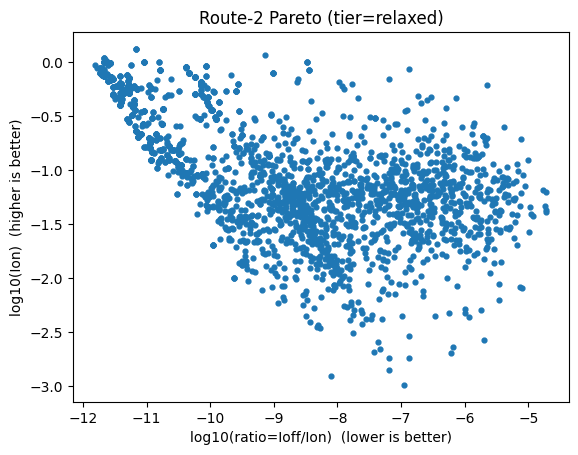

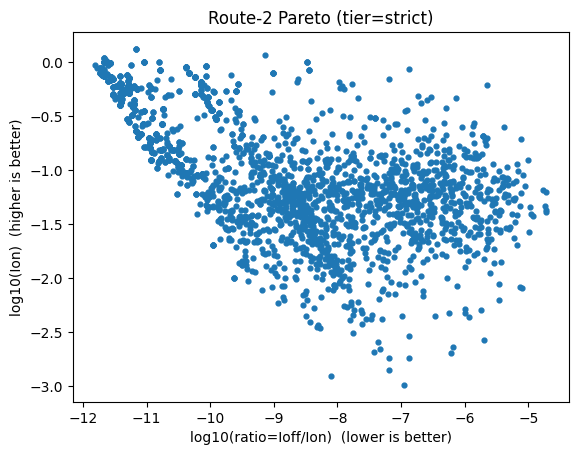


=== BEST DESIGNS (saved) ===
   tier           method  best_any_utility  best_feas_utility
relaxed    random_oracle          8.217349           8.217349
relaxed surrogate_guided          9.396262           9.396262
relaxed  llm_self_refine          8.204297           8.204297
 strict    random_oracle          8.217349           8.217349
 strict surrogate_guided          9.396262           9.396262
 strict  llm_self_refine          8.222943           8.222943

Top-3 feasible STRICT designs (across methods):
- surrogate_guided | utility= 9.396261558223928 | Ion= 0.9406155181523369 | ratio= 1.5699650574117863e-12 | SS= 69.62612425182539 | DIBL= 20.213739660134824
  design: {'L_nm': 5.0, 'tox_nm': 1.3623602798060002, 'Tch_nm': 0.6, 'mu_cm2Vs': 60.514147812917095, 'Vth_V': 0.7, 'Rc_OhmUm': 30.0, 'Nd_cm3': 1e+17, 'kappa_ox': 25.0, 'contact_type': 'ohmic'}
- surrogate_guided | utility= 9.361688607832804 | Ion= 1.1024498627272201 | ratio= 2.115908772834881e-12 | SS= 77.31369475055655 | DIBL= 

In [3]:
# ============================================================
# ONE-CELL COLAB PIPELINE — ROUTE-2 (Physics-inspired + ML/LLM Optimization)  ✅ FIXED
# Author: Youla Yang
#
# ✅ Fixes included:
#   - KeyError 'tier' fixed: every run DataFrame now carries a 'tier' column.
#   - All rows also store tier thresholds for traceability.
#   - Robust plotting and best-design export.
#
# What this does (end-to-end):
#  1) Define a physics-inspired compact oracle for MoS2 FET:
#       Ion, Ioff, ratio=Ioff/Ion, SS, DIBL
#  2) Sample oracle data -> train surrogates under leak-free group split
#  3) Run optimizers:
#       - Random search (oracle baseline)
#       - Surrogate-guided search (surrogate propose + oracle evaluate)
#       - Optional: LLM self-refine (if OPENAI_API_KEY is set)
#  4) Save artifacts + make Pareto plots + export best designs
#
# ============================================================

!pip -q install numpy pandas matplotlib scikit-learn tqdm

import os, json, math, random, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

# -----------------------------
# 0) Config
# -----------------------------
TAG = "route2_v1_fixed"
OUT_DIR = "/content"
SEED = 0
np.random.seed(SEED); random.seed(SEED)

# Optional LLM (OpenAI-compatible). Works with OpenAI or OpenRouter.
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "").strip()
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL", "").strip()  # e.g. https://openrouter.ai/api/v1
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")

USE_LLM = bool(OPENAI_API_KEY)
print("USE_LLM:", USE_LLM)

# -----------------------------
# 1) Physics-inspired compact oracle
# -----------------------------
VDD = 1.0
VDS_ON = 1.0
VGS_ON = 1.0
VGS_OFF = 0.0
T_K = 300.0
kT_q = 0.02585
ln10 = np.log(10)

def clip(x, a, b):
    return max(a, min(b, x))

def oracle_mos2(design):
    """
    Returns:
      Ion_Aum, Ioff_Aum, ratio, SS_mVdec, DIBL_mV_per_V
    """
    L_nm = float(design["L_nm"])
    tox_nm = float(design["tox_nm"])
    Tch_nm = float(design["Tch_nm"])
    mu = float(design["mu_cm2Vs"])
    Vth = float(design["Vth_V"])
    Rc = float(design["Rc_OhmUm"])
    Nd = float(design["Nd_cm3"])
    kappa = float(design["kappa_ox"])
    contact = str(design["contact_type"]).lower().strip()

    # Gate capacitance proxy (scaled): Cox ~ kappa/tox
    Cox = kappa / max(tox_nm, 0.2)

    # SS model: n-factor worsens with thicker channel & weaker gate
    n_factor = 1.0 + 0.35*(Tch_nm/1.5) + 0.25*(1.5/max(Cox, 1e-9))
    SS_mVdec = 60.0 * n_factor

    # DIBL model: increases when L small or tox large; reduced by higher kappa
    dibl = 40.0 * (10.0/max(L_nm, 5.0))**1.1 * (tox_nm/2.0)**0.6 * (1.2/max(kappa, 1.0))**0.4
    if contact == "schottky":
        dibl *= 1.25
    DIBL_mV_per_V = float(dibl)

    # Mobility degradation with doping + thin tox
    mu_eff = mu * (1.0 / (1.0 + (Nd/5e18)**0.6)) * (1.0 / (1.0 + (2.0/max(tox_nm,0.2))**0.5))
    mu_eff = max(mu_eff, 0.5)

    # Effective Vth under Vds due to DIBL
    Vth_on  = Vth - (DIBL_mV_per_V/1000.0)*VDS_ON
    Vth_off = Vth - (DIBL_mV_per_V/1000.0)*VDS_ON

    # Overdrive
    Vov = max(VGS_ON - Vth_on, 0.0)

    # Ion model: Id ~ mu_eff * Cox * (Vov^alpha) / L  with series resistance
    alpha = 1.25
    Id0 = (mu_eff/100.0) * Cox * (Vov**alpha) * (10.0/max(L_nm, 5.0))
    Id_on = Id0 / (1.0 + 0.02*Rc*Id0 + 0.15*(Rc/200.0))
    Ion_Aum = max(float(Id_on), 1e-18)

    # Ioff model: subthreshold leakage + floors
    SS_Vdec = SS_mVdec / 1000.0
    decades = - (Vth_off - VGS_OFF) / max(SS_Vdec, 1e-9)
    I0 = 1e-6 * Cox * (10.0/max(L_nm, 5.0))
    I_sub = I0 * (10.0**decades)

    I_contact = 1e-12 * (1.0 + (Rc/200.0)**0.8)
    if contact == "schottky":
        I_contact *= 30.0
    I_dop = 1e-12 * (Nd/1e18)**0.6

    Ioff_Aum = max(float(I_sub + I_contact + I_dop), 1e-18)
    ratio = max(Ioff_Aum / Ion_Aum, 1e-30)

    return Ion_Aum, Ioff_Aum, ratio, float(SS_mVdec), float(DIBL_mV_per_V)

# -----------------------------
# 2) Search space + samplers
# -----------------------------
CONTACT_TYPES = ["ohmic", "schottky"]

SPACE = {
    "L_nm":       (5.0, 50.0),
    "tox_nm":     (0.8, 6.0),
    "Tch_nm":     (0.6, 5.0),
    "mu_cm2Vs":   (5.0, 120.0),
    "Vth_V":      (0.10, 0.70),
    "Rc_OhmUm":   (30.0, 800.0),
    "Nd_cm3":     (1e17, 1e20),
    "kappa_ox":   (3.0, 25.0),
}

def sample_design(rng=np.random):
    Nd = 10**rng.uniform(np.log10(SPACE["Nd_cm3"][0]), np.log10(SPACE["Nd_cm3"][1]))
    d = {
        "L_nm": float(rng.uniform(*SPACE["L_nm"])),
        "tox_nm": float(rng.uniform(*SPACE["tox_nm"])),
        "Tch_nm": float(rng.uniform(*SPACE["Tch_nm"])),
        "mu_cm2Vs": float(rng.uniform(*SPACE["mu_cm2Vs"])),
        "Vth_V": float(rng.uniform(*SPACE["Vth_V"])),
        "Rc_OhmUm": float(rng.uniform(*SPACE["Rc_OhmUm"])),
        "Nd_cm3": float(Nd),
        "kappa_ox": float(rng.uniform(*SPACE["kappa_ox"])),
        "contact_type": str(rng.choice(CONTACT_TYPES)),
    }
    return d

def mutate_design(d, rng=np.random, scale=0.25):
    d2 = dict(d)
    for k in ["L_nm","tox_nm","Tch_nm","mu_cm2Vs","Vth_V","Rc_OhmUm","kappa_ox"]:
        lo, hi = SPACE[k]
        span = hi - lo
        d2[k] = float(clip(d2[k] + rng.normal(0, scale*span), lo, hi))
    nd_lo, nd_hi = SPACE["Nd_cm3"]
    lognd = float(np.log10(d2["Nd_cm3"]))
    lognd = float(clip(lognd + rng.normal(0, scale*1.5), np.log10(nd_lo), np.log10(nd_hi)))
    d2["Nd_cm3"] = float(10**lognd)
    if rng.rand() < 0.15:
        d2["contact_type"] = "ohmic" if d2["contact_type"]=="schottky" else "schottky"
    return d2

def family_id(d):
    Lb = int(round(float(d["L_nm"])/5.0))
    tb = int(round(float(d["tox_nm"])/1.0))
    return f"L{Lb}_tox{tb}_{str(d['contact_type']).lower()}"

# -----------------------------
# 3) Objective + constraints
# -----------------------------
alpha_u = 0.8
beta_u  = 0.25
gamma_u = 0.15

def utility(Ion, ratio, SS, DIBL):
    Ion = max(float(Ion), 1e-30)
    ratio = max(float(ratio), 1e-30)
    return float(np.log10(Ion) - alpha_u*np.log10(ratio) - beta_u*(SS/1000.0) - gamma_u*(DIBL/1000.0))

TIERS = [
    {"tier":"relaxed", "RATIO_MAX": 1e-4, "SS_MAX": 130.0, "DIBL_MAX": 120.0},
    {"tier":"strict",  "RATIO_MAX": 1e-6, "SS_MAX":  90.0, "DIBL_MAX":  60.0},
]

def is_feasible(ratio, SS, DIBL, tier):
    return (ratio <= tier["RATIO_MAX"]) and (SS <= tier["SS_MAX"]) and (DIBL <= tier["DIBL_MAX"])

# -----------------------------
# 4) Generate initial oracle dataset
# -----------------------------
N_INIT = 1800
rng = np.random.RandomState(SEED)
records = []

for _ in tqdm(range(N_INIT), desc="Oracle sampling"):
    d = sample_design(rng)
    Ion, Ioff, rat, SS, DIBL = oracle_mos2(d)
    rec = dict(d)
    rec.update({
        "family_id": family_id(d),
        "Ion_Aum": Ion,
        "Ioff_Aum": Ioff,
        "ratio": rat,
        "SS_mVdec": SS,
        "DIBL_mV_V": DIBL,
        "utility": utility(Ion, rat, SS, DIBL)
    })
    records.append(rec)

df = pd.DataFrame(records)
df_path = f"{OUT_DIR}/oracle_dataset_{TAG}.csv"
df.to_csv(df_path, index=False)
print("✅ Saved oracle dataset:", df_path, "rows=", len(df))

plt.figure()
plt.hist(np.log10(df["ratio"].values + 1e-30), bins=40)
plt.xlabel("log10(ratio=Ioff/Ion)")
plt.ylabel("count")
plt.title("Route-2 oracle ratio distribution")
plt.show()

# -----------------------------
# 5) Train surrogates (leak-free group split)
# -----------------------------
FEATURES_NUM = ["L_nm","tox_nm","Tch_nm","mu_cm2Vs","Vth_V","Rc_OhmUm","Nd_cm3","kappa_ox"]
FEATURES_CAT = ["contact_type"]
FEATURES = FEATURES_NUM + FEATURES_CAT
TARGETS = ["log_Ion","log_ratio","SS_mVdec","DIBL_mV_V"]

df2 = df.copy()
df2["log_Ion"] = np.log10(df2["Ion_Aum"].values + 1e-30)
df2["log_ratio"] = np.log10(df2["ratio"].values + 1e-30)

X = df2[FEATURES].copy()
groups = df2["family_id"].values

def build_model():
    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), FEATURES_NUM),
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), FEATURES_CAT),
        ],
        remainder="drop",
    )
    reg = HistGradientBoostingRegressor(
        max_depth=8, learning_rate=0.05, max_iter=1200, random_state=SEED
    )
    return Pipeline([("pre", pre), ("reg", reg)])

gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
tr_idx, te_idx = next(gss.split(X, groups=groups))
Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]

surrogates = {}
r2 = {}
for t in TARGETS:
    ytr = df2.iloc[tr_idx][t].values
    yte = df2.iloc[te_idx][t].values
    m = build_model()
    m.fit(Xtr, ytr)
    pred = m.predict(Xte)
    surrogates[t] = m
    r2[t] = float(r2_score(yte, pred))

print("✅ Surrogate R^2 (group-split):", r2)
r2_path = f"{OUT_DIR}/surrogate_r2_{TAG}.json"
with open(r2_path, "w") as f:
    json.dump(r2, f, indent=2)
print("✅ Saved:", r2_path)

# -----------------------------
# 6) Evaluation helpers
# -----------------------------
def surrogate_eval(design):
    row = pd.DataFrame([design])[FEATURES]
    log_Ion = float(surrogates["log_Ion"].predict(row)[0])
    log_ratio = float(surrogates["log_ratio"].predict(row)[0])
    SS = float(surrogates["SS_mVdec"].predict(row)[0])
    DIBL = float(surrogates["DIBL_mV_V"].predict(row)[0])
    Ion = 10**log_Ion
    ratio = 10**log_ratio
    u = utility(Ion, ratio, SS, DIBL)
    return Ion, ratio, SS, DIBL, u

def oracle_eval(design):
    Ion, Ioff, ratio, SS, DIBL = oracle_mos2(design)
    u = utility(Ion, ratio, SS, DIBL)
    return Ion, ratio, SS, DIBL, u

# -----------------------------
# 7) Optimizers
# -----------------------------
def add_tier_columns(df_run, tier):
    """✅ Ensures 'tier' exists and stores tier thresholds (for paper traceability)."""
    if df_run is None:
        return None
    df_run = df_run.copy()
    df_run["tier"] = tier["tier"] if tier else "none"
    if tier:
        df_run["RATIO_MAX"] = float(tier["RATIO_MAX"])
        df_run["SS_MAX"] = float(tier["SS_MAX"])
        df_run["DIBL_MAX"] = float(tier["DIBL_MAX"])
    return df_run

def random_search(n=1200, tier=None, seed=0):
    rng = np.random.RandomState(seed)
    best_any = None
    best_feas = None
    rows = []
    for _ in range(n):
        d = sample_design(rng)
        Ion, ratio, SS, DIBL, u = oracle_eval(d)
        feas = is_feasible(ratio, SS, DIBL, tier) if tier else True
        rec = dict(d)
        rec.update({"Ion":Ion,"ratio":ratio,"SS":SS,"DIBL":DIBL,"utility":u,"feasible":feas,"method":"random_oracle"})
        rows.append(rec)
        if best_any is None or u > best_any["utility"]:
            best_any = rec
        if feas and (best_feas is None or u > best_feas["utility"]):
            best_feas = rec
    df_run = pd.DataFrame(rows)
    df_run = add_tier_columns(df_run, tier)
    return df_run, best_any, best_feas

def surrogate_guided_search(n_steps=900, tier=None, seed=1):
    rng = np.random.RandomState(seed)
    idx0 = int(df2["utility"].values.argmax())
    cur = df2.iloc[idx0][FEATURES].to_dict()
    cur_u_s = surrogate_eval(cur)[-1]

    best_any = None
    best_feas = None
    rows = []

    for _ in tqdm(range(n_steps), desc=f"Surrogate-guided ({tier['tier'] if tier else 'no-tier'})"):
        cand = mutate_design(cur, rng, scale=0.22)
        Ion_s, ratio_s, SS_s, DIBL_s, u_s = surrogate_eval(cand)

        if (u_s > cur_u_s) or (rng.rand() < 0.08):
            cur = cand
            cur_u_s = u_s

        Ion, ratio, SS, DIBL, u = oracle_eval(cur)
        feas = is_feasible(ratio, SS, DIBL, tier) if tier else True

        rec = dict(cur)
        rec.update({
            "Ion":Ion,"ratio":ratio,"SS":SS,"DIBL":DIBL,"utility":u,"feasible":feas,
            "Ion_s":Ion_s,"ratio_s":ratio_s,"SS_s":SS_s,"DIBL_s":DIBL_s,"utility_s":u_s,
            "method":"surrogate_guided"
        })
        rows.append(rec)

        if best_any is None or u > best_any["utility"]:
            best_any = rec
        if feas and (best_feas is None or u > best_feas["utility"]):
            best_feas = rec

    df_run = pd.DataFrame(rows)
    df_run = add_tier_columns(df_run, tier)
    return df_run, best_any, best_feas

# -----------------------------
# 8) Optional LLM propose + self-refine (if API key set)
# -----------------------------
def llm_client():
    from openai import OpenAI
    base = OPENAI_BASE_URL or None
    return OpenAI(api_key=OPENAI_API_KEY, base_url=base)

LLM_SYS = """You are a device-design assistant optimizing a MoS2 FET compact model.
Return ONLY valid JSON with keys:
L_nm,tox_nm,Tch_nm,mu_cm2Vs,Vth_V,Rc_OhmUm,Nd_cm3,kappa_ox,contact_type.
Values must be within allowed ranges.
contact_type must be "ohmic" or "schottky".
No extra text."""
RANGE_TEXT = f"""
Ranges:
L_nm in [{SPACE['L_nm'][0]}, {SPACE['L_nm'][1]}]
tox_nm in [{SPACE['tox_nm'][0]}, {SPACE['tox_nm'][1]}]
Tch_nm in [{SPACE['Tch_nm'][0]}, {SPACE['Tch_nm'][1]}]
mu_cm2Vs in [{SPACE['mu_cm2Vs'][0]}, {SPACE['mu_cm2Vs'][1]}]
Vth_V in [{SPACE['Vth_V'][0]}, {SPACE['Vth_V'][1]}]
Rc_OhmUm in [{SPACE['Rc_OhmUm'][0]}, {SPACE['Rc_OhmUm'][1]}]
Nd_cm3 in [1e17, 1e20] (log scale)
kappa_ox in [{SPACE['kappa_ox'][0]}, {SPACE['kappa_ox'][1]}]
"""

def parse_json_strict(s):
    s = s.strip()
    m = re.search(r"\{.*\}", s, flags=re.DOTALL)
    if m:
        s = m.group(0)
    return json.loads(s)

def sanitize_design(d):
    dd = {}
    dd["L_nm"] = float(clip(float(d["L_nm"]), *SPACE["L_nm"]))
    dd["tox_nm"] = float(clip(float(d["tox_nm"]), *SPACE["tox_nm"]))
    dd["Tch_nm"] = float(clip(float(d["Tch_nm"]), *SPACE["Tch_nm"]))
    dd["mu_cm2Vs"] = float(clip(float(d["mu_cm2Vs"]), *SPACE["mu_cm2Vs"]))
    dd["Vth_V"] = float(clip(float(d["Vth_V"]), *SPACE["Vth_V"]))
    dd["Rc_OhmUm"] = float(clip(float(d["Rc_OhmUm"]), *SPACE["Rc_OhmUm"]))
    nd = float(d["Nd_cm3"])
    dd["Nd_cm3"] = float(clip(nd, *SPACE["Nd_cm3"]))
    dd["kappa_ox"] = float(clip(float(d["kappa_ox"]), *SPACE["kappa_ox"]))
    ct = str(d["contact_type"]).strip().lower()
    dd["contact_type"] = ct if ct in CONTACT_TYPES else "ohmic"
    return dd

def llm_optimize(n_iters=16, tier=None, seed=0):
    if not USE_LLM:
        return None, None, None

    rng = np.random.RandomState(seed)
    client = llm_client()

    best0 = df.loc[df["utility"].idxmax()].to_dict()
    cur = {k: best0[k] for k in FEATURES}
    cur = sanitize_design(cur)

    best_any, best_feas = None, None
    rows = []

    for it in tqdm(range(n_iters), desc=f"LLM self-refine ({tier['tier'] if tier else 'no-tier'})"):
        Ion, ratio, SS, DIBL, u = oracle_eval(cur)
        feas = is_feasible(ratio, SS, DIBL, tier) if tier else True

        feedback = {
            "iter": it,
            "current_design": cur,
            "oracle_metrics": {
                "Ion": Ion, "ratio": ratio, "SS_mVdec": SS, "DIBL_mV_V": DIBL, "utility": u,
                "feasible": bool(feas),
                "tier": tier if tier else None
            }
        }

        prompt = f"""{RANGE_TEXT}
Optimization target:
utility = log10(Ion) - {alpha_u}*log10(ratio) - {beta_u}*(SS/1000) - {gamma_u}*(DIBL/1000)

Tier constraints (must satisfy):
{json.dumps(tier, indent=2)}

Current evaluation (oracle):
{json.dumps(feedback, indent=2)}

Return ONLY a JSON design within ranges that increases utility and satisfies constraints."""
        try:
            resp = client.chat.completions.create(
                model=OPENAI_MODEL,
                messages=[{"role":"system","content": LLM_SYS},
                          {"role":"user","content": prompt}],
                temperature=0.4,
            )
            txt = resp.choices[0].message.content
            cand = sanitize_design(parse_json_strict(txt))
        except Exception:
            cand = mutate_design(cur, rng, scale=0.25)

        Ion2, ratio2, SS2, DIBL2, u2 = oracle_eval(cand)
        feas2 = is_feasible(ratio2, SS2, DIBL2, tier) if tier else True

        if (u2 > u) or (rng.rand() < 0.10):
            cur = cand

        rec = dict(cand)
        rec.update({"Ion":Ion2,"ratio":ratio2,"SS":SS2,"DIBL":DIBL2,"utility":u2,"feasible":feas2,"method":"llm_self_refine"})
        rows.append(rec)

        if best_any is None or u2 > best_any["utility"]:
            best_any = rec
        if feas2 and (best_feas is None or u2 > best_feas["utility"]):
            best_feas = rec

    df_run = pd.DataFrame(rows)
    df_run = add_tier_columns(df_run, tier)
    return df_run, best_any, best_feas

# -----------------------------
# 9) Run experiments for each tier (✅ tier column included)
# -----------------------------
all_runs = []
summary_rows = []

def summarize_run(name, tier, df_run, best_any, best_feas):
    row = {
        "method": name,
        "tier": tier["tier"] if tier else "none",
        "n": 0 if df_run is None else int(len(df_run)),
        "n_feasible": 0 if df_run is None else int(df_run["feasible"].sum()),
        "feasible_rate": np.nan if df_run is None else float(df_run["feasible"].mean()),
        "best_utility_any": np.nan if best_any is None else float(best_any["utility"]),
        "best_utility_feasible": np.nan if best_feas is None else float(best_feas["utility"]),
        "best_Ion_any": np.nan if best_any is None else float(best_any["Ion"]),
        "best_ratio_any": np.nan if best_any is None else float(best_any["ratio"]),
        "best_SS_any": np.nan if best_any is None else float(best_any["SS"]),
        "best_DIBL_any": np.nan if best_any is None else float(best_any["DIBL"]),
        "best_Ion_feasible": np.nan if best_feas is None else float(best_feas["Ion"]),
        "best_ratio_feasible": np.nan if best_feas is None else float(best_feas["ratio"]),
        "best_SS_feasible": np.nan if best_feas is None else float(best_feas["SS"]),
        "best_DIBL_feasible": np.nan if best_feas is None else float(best_feas["DIBL"]),
        "RATIO_MAX": float(tier["RATIO_MAX"]) if tier else np.nan,
        "SS_MAX": float(tier["SS_MAX"]) if tier else np.nan,
        "DIBL_MAX": float(tier["DIBL_MAX"]) if tier else np.nan,
    }
    return row

for tier in TIERS:
    df_r, best_any_r, best_feas_r = random_search(n=1400, tier=tier, seed=SEED+11)
    all_runs.append(df_r)
    summary_rows.append(summarize_run("random_oracle", tier, df_r, best_any_r, best_feas_r))

    df_s, best_any_s, best_feas_s = surrogate_guided_search(n_steps=900, tier=tier, seed=SEED+22)
    all_runs.append(df_s)
    summary_rows.append(summarize_run("surrogate_guided", tier, df_s, best_any_s, best_feas_s))

    if USE_LLM:
        df_l, best_any_l, best_feas_l = llm_optimize(n_iters=18, tier=tier, seed=SEED+33)
        all_runs.append(df_l)
        summary_rows.append(summarize_run("llm_self_refine", tier, df_l, best_any_l, best_feas_l))
    else:
        print("Skipping LLM run (no OPENAI_API_KEY).")

runs = pd.concat([d for d in all_runs if d is not None], ignore_index=True)
runs_path = f"{OUT_DIR}/optimization_runs_{TAG}.csv"
runs.to_csv(runs_path, index=False)

summary = pd.DataFrame(summary_rows)
summary_path = f"{OUT_DIR}/summary_{TAG}.csv"
summary.to_csv(summary_path, index=False)

print("\n=== SUMMARY ===")
print(summary.to_string(index=False))

# -----------------------------
# 10) Pareto plots (robust)
# -----------------------------
def pareto_plot(df_run, title):
    d = df_run.copy()
    d = d[np.isfinite(d["Ion"]) & np.isfinite(d["ratio"])].copy()
    if len(d) == 0:
        print("No data for plot:", title);
        return
    plt.figure()
    plt.scatter(np.log10(d["ratio"].values + 1e-30), np.log10(d["Ion"].values + 1e-30), s=12)
    plt.xlabel("log10(ratio=Ioff/Ion)  (lower is better)")
    plt.ylabel("log10(Ion)  (higher is better)")
    plt.title(title)
    plt.show()

for tier in TIERS:
    d = runs[(runs["tier"]==tier["tier"])].copy()
    pareto_plot(d, f"Route-2 Pareto (tier={tier['tier']})")

# -----------------------------
# 11) Export best designs per method & tier
# -----------------------------
best_rows = []
METHODS = ["random_oracle", "surrogate_guided"] + (["llm_self_refine"] if USE_LLM else [])

for tier in TIERS:
    for method in METHODS:
        sub = runs[(runs["tier"]==tier["tier"]) & (runs["method"]==method)].copy()
        if len(sub)==0:
            continue

        sub_any = sub.sort_values("utility", ascending=False).iloc[0].to_dict()
        sub_feas = sub[sub["feasible"]].sort_values("utility", ascending=False)
        sub_feas = sub_feas.iloc[0].to_dict() if len(sub_feas) else None

        def pack(prefix, rec):
            if rec is None:
                return {f"{prefix}_utility": np.nan}
            return {
                f"{prefix}_utility": float(rec["utility"]),
                f"{prefix}_Ion": float(rec["Ion"]),
                f"{prefix}_ratio": float(rec["ratio"]),
                f"{prefix}_SS": float(rec["SS"]),
                f"{prefix}_DIBL": float(rec["DIBL"]),
                f"{prefix}_design": json.dumps({k: rec[k] for k in FEATURES}),
            }

        row = {"tier": tier["tier"], "method": method}
        row.update(pack("best_any", sub_any))
        row.update(pack("best_feas", sub_feas))
        best_rows.append(row)

best_df = pd.DataFrame(best_rows)
best_path = f"{OUT_DIR}/best_designs_{TAG}.csv"
best_df.to_csv(best_path, index=False)

print("\n=== BEST DESIGNS (saved) ===")
print(best_df[["tier","method","best_any_utility","best_feas_utility"]].to_string(index=False))

# Top-3 feasible strict designs across all methods
strict_all = runs[(runs["tier"]=="strict") & (runs["feasible"])].sort_values("utility", ascending=False).head(3)
print("\nTop-3 feasible STRICT designs (across methods):")
if len(strict_all)==0:
    print("None feasible under strict tier. Consider relaxing strict thresholds or expanding search.")
else:
    for _, r in strict_all.iterrows():
        print("-", r["method"], "| utility=", float(r["utility"]), "| Ion=", float(r["Ion"]), "| ratio=", float(r["ratio"]),
              "| SS=", float(r["SS"]), "| DIBL=", float(r["DIBL"]))
        print("  design:", {k: r[k] for k in FEATURES})

print("\nSaved files:")
print(" -", df_path)
print(" -", r2_path)
print(" -", runs_path)
print(" -", summary_path)
print(" -", best_path)
print("\nDone.")


In [1]:
# ============================================================
# ONE-CELL COLAB PIPELINE — ROUTE-2 (Physics-inspired + ML/LLM Optimization)
# ✅ UPDATED: multi-seed (3 seeds) + BO baseline (relaxed tier)
# Author: Youla Yang
#
# ✅ Updates included:
#   1) Multi-seed runs: SEEDS=[0,1,2], aggregate mean±std across seeds
#   2) Bayesian Optimization baseline (oracle-only) via scikit-optimize (relaxed tier by default)
#   3) Seed-specific TAG to avoid file overwrite + combined allseeds exports
#   4) Keeps your fixes: tier column everywhere + threshold columns everywhere + robust export
#
# What this does (end-to-end):
#  1) Define a physics-inspired compact oracle for MoS2 FET:
#       Ion, Ioff, ratio=Ioff/Ion, SS, DIBL
#  2) Sample oracle data -> train surrogates under leak-free group split
#  3) Run optimizers:
#       - Random search (oracle baseline)
#       - Surrogate-guided search (surrogate propose + oracle evaluate)
#       - Bayesian Optimization baseline (oracle-only, relaxed tier)
#       - Optional: LLM self-refine (if OPENAI_API_KEY is set)
#  4) Save artifacts + make Pareto plots + export best designs
#  5) Repeat across seeds and export mean±std tables
# ============================================================

!pip -q install numpy pandas matplotlib scikit-learn tqdm scikit-optimize

import os, json, math, random, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

from skopt import gp_minimize
from skopt.space import Real, Categorical
from skopt.utils import use_named_args

# -----------------------------
# 0) Global Config
# -----------------------------
BASE_TAG = "route2_v1_fixed"
OUT_DIR = "/content"

SEEDS = [0, 1, 2]  # ✅ multi-seed

# Optional LLM (OpenAI-compatible). Works with OpenAI or OpenRouter.
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "").strip()
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL", "").strip()  # e.g. https://openrouter.ai/api/v1
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
USE_LLM = bool(OPENAI_API_KEY)
print("USE_LLM:", USE_LLM)

# -----------------------------
# 1) Physics-inspired compact oracle
# -----------------------------
VDD = 1.0
VDS_ON = 1.0
VGS_ON = 1.0
VGS_OFF = 0.0
T_K = 300.0
kT_q = 0.02585
ln10 = np.log(10)

def clip(x, a, b):
    return max(a, min(b, x))

def oracle_mos2(design):
    """
    Returns:
      Ion_Aum, Ioff_Aum, ratio, SS_mVdec, DIBL_mV_per_V
    """
    L_nm = float(design["L_nm"])
    tox_nm = float(design["tox_nm"])
    Tch_nm = float(design["Tch_nm"])
    mu = float(design["mu_cm2Vs"])
    Vth = float(design["Vth_V"])
    Rc = float(design["Rc_OhmUm"])
    Nd = float(design["Nd_cm3"])
    kappa = float(design["kappa_ox"])
    contact = str(design["contact_type"]).lower().strip()

    # Gate capacitance proxy (scaled): Cox ~ kappa/tox
    Cox = kappa / max(tox_nm, 0.2)

    # SS model: n-factor worsens with thicker channel & weaker gate
    n_factor = 1.0 + 0.35*(Tch_nm/1.5) + 0.25*(1.5/max(Cox, 1e-9))
    SS_mVdec = 60.0 * n_factor

    # DIBL model: increases when L small or tox large; reduced by higher kappa
    dibl = 40.0 * (10.0/max(L_nm, 5.0))**1.1 * (tox_nm/2.0)**0.6 * (1.2/max(kappa, 1.0))**0.4
    if contact == "schottky":
        dibl *= 1.25
    DIBL_mV_per_V = float(dibl)

    # Mobility degradation with doping + thin tox
    mu_eff = mu * (1.0 / (1.0 + (Nd/5e18)**0.6)) * (1.0 / (1.0 + (2.0/max(tox_nm,0.2))**0.5))
    mu_eff = max(mu_eff, 0.5)

    # Effective Vth under Vds due to DIBL
    Vth_on  = Vth - (DIBL_mV_per_V/1000.0)*VDS_ON
    Vth_off = Vth - (DIBL_mV_per_V/1000.0)*VDS_ON

    # Overdrive
    Vov = max(VGS_ON - Vth_on, 0.0)

    # Ion model: Id ~ mu_eff * Cox * (Vov^alpha) / L  with series resistance
    alpha = 1.25
    Id0 = (mu_eff/100.0) * Cox * (Vov**alpha) * (10.0/max(L_nm, 5.0))
    Id_on = Id0 / (1.0 + 0.02*Rc*Id0 + 0.15*(Rc/200.0))
    Ion_Aum = max(float(Id_on), 1e-18)

    # Ioff model: subthreshold leakage + floors
    SS_Vdec = SS_mVdec / 1000.0
    decades = - (Vth_off - VGS_OFF) / max(SS_Vdec, 1e-9)
    I0 = 1e-6 * Cox * (10.0/max(L_nm, 5.0))
    I_sub = I0 * (10.0**decades)

    I_contact = 1e-12 * (1.0 + (Rc/200.0)**0.8)
    if contact == "schottky":
        I_contact *= 30.0
    I_dop = 1e-12 * (Nd/1e18)**0.6

    Ioff_Aum = max(float(I_sub + I_contact + I_dop), 1e-18)
    ratio = max(Ioff_Aum / Ion_Aum, 1e-30)

    return Ion_Aum, Ioff_Aum, ratio, float(SS_mVdec), float(DIBL_mV_per_V)

# -----------------------------
# 2) Search space + samplers
# -----------------------------
CONTACT_TYPES = ["ohmic", "schottky"]

SPACE = {
    "L_nm":       (5.0, 50.0),
    "tox_nm":     (0.8, 6.0),
    "Tch_nm":     (0.6, 5.0),
    "mu_cm2Vs":   (5.0, 120.0),
    "Vth_V":      (0.10, 0.70),
    "Rc_OhmUm":   (30.0, 800.0),
    "Nd_cm3":     (1e17, 1e20),
    "kappa_ox":   (3.0, 25.0),
}

def sample_design(rng=np.random):
    Nd = 10**rng.uniform(np.log10(SPACE["Nd_cm3"][0]), np.log10(SPACE["Nd_cm3"][1]))
    d = {
        "L_nm": float(rng.uniform(*SPACE["L_nm"])),
        "tox_nm": float(rng.uniform(*SPACE["tox_nm"])),
        "Tch_nm": float(rng.uniform(*SPACE["Tch_nm"])),
        "mu_cm2Vs": float(rng.uniform(*SPACE["mu_cm2Vs"])),
        "Vth_V": float(rng.uniform(*SPACE["Vth_V"])),
        "Rc_OhmUm": float(rng.uniform(*SPACE["Rc_OhmUm"])),
        "Nd_cm3": float(Nd),
        "kappa_ox": float(rng.uniform(*SPACE["kappa_ox"])),
        "contact_type": str(rng.choice(CONTACT_TYPES)),
    }
    return d

def mutate_design(d, rng=np.random, scale=0.25):
    d2 = dict(d)
    for k in ["L_nm","tox_nm","Tch_nm","mu_cm2Vs","Vth_V","Rc_OhmUm","kappa_ox"]:
        lo, hi = SPACE[k]
        span = hi - lo
        d2[k] = float(clip(d2[k] + rng.normal(0, scale*span), lo, hi))
    nd_lo, nd_hi = SPACE["Nd_cm3"]
    lognd = float(np.log10(d2["Nd_cm3"]))
    lognd = float(clip(lognd + rng.normal(0, scale*1.5), np.log10(nd_lo), np.log10(nd_hi)))
    d2["Nd_cm3"] = float(10**lognd)
    if rng.rand() < 0.15:
        d2["contact_type"] = "ohmic" if d2["contact_type"]=="schottky" else "schottky"
    return d2

def family_id(d):
    Lb = int(round(float(d["L_nm"])/5.0))
    tb = int(round(float(d["tox_nm"])/1.0))
    return f"L{Lb}_tox{tb}_{str(d['contact_type']).lower()}"

# -----------------------------
# 3) Objective + constraints
# -----------------------------
alpha_u = 0.8
beta_u  = 0.25
gamma_u = 0.15

def utility(Ion, ratio, SS, DIBL):
    Ion = max(float(Ion), 1e-30)
    ratio = max(float(ratio), 1e-30)
    return float(np.log10(Ion) - alpha_u*np.log10(ratio) - beta_u*(SS/1000.0) - gamma_u*(DIBL/1000.0))

TIERS = [
    {"tier":"relaxed", "RATIO_MAX": 1e-4, "SS_MAX": 130.0, "DIBL_MAX": 120.0},
    {"tier":"strict",  "RATIO_MAX": 1e-6, "SS_MAX":  90.0, "DIBL_MAX":  60.0},
]

def is_feasible(ratio, SS, DIBL, tier):
    return (ratio <= tier["RATIO_MAX"]) and (SS <= tier["SS_MAX"]) and (DIBL <= tier["DIBL_MAX"])

# -----------------------------
# 8) Optional LLM propose + self-refine (if API key set)
# -----------------------------
def llm_client():
    from openai import OpenAI
    base = OPENAI_BASE_URL or None
    return OpenAI(api_key=OPENAI_API_KEY, base_url=base)

LLM_SYS = """You are a device-design assistant optimizing a MoS2 FET compact model.
Return ONLY valid JSON with keys:
L_nm,tox_nm,Tch_nm,mu_cm2Vs,Vth_V,Rc_OhmUm,Nd_cm3,kappa_ox,contact_type.
Values must be within allowed ranges.
contact_type must be "ohmic" or "schottky".
No extra text."""

RANGE_TEXT = f"""
Ranges:
L_nm in [{SPACE['L_nm'][0]}, {SPACE['L_nm'][1]}]
tox_nm in [{SPACE['tox_nm'][0]}, {SPACE['tox_nm'][1]}]
Tch_nm in [{SPACE['Tch_nm'][0]}, {SPACE['Tch_nm'][1]}]
mu_cm2Vs in [{SPACE['mu_cm2Vs'][0]}, {SPACE['mu_cm2Vs'][1]}]
Vth_V in [{SPACE['Vth_V'][0]}, {SPACE['Vth_V'][1]}]
Rc_OhmUm in [{SPACE['Rc_OhmUm'][0]}, {SPACE['Rc_OhmUm'][1]}]
Nd_cm3 in [1e17, 1e20] (log scale)
kappa_ox in [{SPACE['kappa_ox'][0]}, {SPACE['kappa_ox'][1]}]
"""

def parse_json_strict(s):
    s = s.strip()
    m = re.search(r"\{.*\}", s, flags=re.DOTALL)
    if m:
        s = m.group(0)
    return json.loads(s)

def sanitize_design(d):
    dd = {}
    dd["L_nm"] = float(clip(float(d["L_nm"]), *SPACE["L_nm"]))
    dd["tox_nm"] = float(clip(float(d["tox_nm"]), *SPACE["tox_nm"]))
    dd["Tch_nm"] = float(clip(float(d["Tch_nm"]), *SPACE["Tch_nm"]))
    dd["mu_cm2Vs"] = float(clip(float(d["mu_cm2Vs"]), *SPACE["mu_cm2Vs"]))
    dd["Vth_V"] = float(clip(float(d["Vth_V"]), *SPACE["Vth_V"]))
    dd["Rc_OhmUm"] = float(clip(float(d["Rc_OhmUm"]), *SPACE["Rc_OhmUm"]))
    nd = float(d["Nd_cm3"])
    dd["Nd_cm3"] = float(clip(nd, *SPACE["Nd_cm3"]))
    dd["kappa_ox"] = float(clip(float(d["kappa_ox"]), *SPACE["kappa_ox"]))
    ct = str(d["contact_type"]).strip().lower()
    dd["contact_type"] = ct if ct in CONTACT_TYPES else "ohmic"
    return dd

# -----------------------------
# Core per-seed runner
# -----------------------------
def run_one_seed(SEED, make_plots=False):
    np.random.seed(SEED); random.seed(SEED)
    TAG = f"{BASE_TAG}_seed{SEED}"

    # -----------------------------
    # 4) Generate initial oracle dataset
    # -----------------------------
    N_INIT = 1800
    rng = np.random.RandomState(SEED)
    records = []

    for _ in tqdm(range(N_INIT), desc=f"Oracle sampling (seed={SEED})"):
        d = sample_design(rng)
        Ion, Ioff, rat, SS, DIBL = oracle_mos2(d)
        rec = dict(d)
        rec.update({
            "family_id": family_id(d),
            "Ion_Aum": Ion,
            "Ioff_Aum": Ioff,
            "ratio": rat,
            "SS_mVdec": SS,
            "DIBL_mV_V": DIBL,
            "utility": utility(Ion, rat, SS, DIBL)
        })
        records.append(rec)

    df = pd.DataFrame(records)
    df_path = f"{OUT_DIR}/oracle_dataset_{TAG}.csv"
    df.to_csv(df_path, index=False)
    print("✅ Saved oracle dataset:", df_path, "rows=", len(df))

    if make_plots:
        plt.figure()
        plt.hist(np.log10(df["ratio"].values + 1e-30), bins=40)
        plt.xlabel("log10(ratio=Ioff/Ion)")
        plt.ylabel("count")
        plt.title(f"Route-2 oracle ratio distribution (seed={SEED})")
        plt.show()

    # -----------------------------
    # 5) Train surrogates (leak-free group split)
    # -----------------------------
    FEATURES_NUM = ["L_nm","tox_nm","Tch_nm","mu_cm2Vs","Vth_V","Rc_OhmUm","Nd_cm3","kappa_ox"]
    FEATURES_CAT = ["contact_type"]
    FEATURES = FEATURES_NUM + FEATURES_CAT
    TARGETS = ["log_Ion","log_ratio","SS_mVdec","DIBL_mV_V"]

    df2 = df.copy()
    df2["log_Ion"] = np.log10(df2["Ion_Aum"].values + 1e-30)
    df2["log_ratio"] = np.log10(df2["ratio"].values + 1e-30)

    X = df2[FEATURES].copy()
    groups = df2["family_id"].values

    def build_model():
        pre = ColumnTransformer(
            transformers=[
                ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), FEATURES_NUM),
                ("cat", Pipeline([
                    ("imp", SimpleImputer(strategy="most_frequent")),
                    ("oh", OneHotEncoder(handle_unknown="ignore")),
                ]), FEATURES_CAT),
            ],
            remainder="drop",
        )
        reg = HistGradientBoostingRegressor(
            max_depth=8, learning_rate=0.05, max_iter=1200, random_state=SEED
        )
        return Pipeline([("pre", pre), ("reg", reg)])

    gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
    tr_idx, te_idx = next(gss.split(X, groups=groups))
    Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]

    surrogates = {}
    r2 = {}
    for t in TARGETS:
        ytr = df2.iloc[tr_idx][t].values
        yte = df2.iloc[te_idx][t].values
        m = build_model()
        m.fit(Xtr, ytr)
        pred = m.predict(Xte)
        surrogates[t] = m
        r2[t] = float(r2_score(yte, pred))

    print("✅ Surrogate R^2 (group-split):", r2)
    r2_path = f"{OUT_DIR}/surrogate_r2_{TAG}.json"
    with open(r2_path, "w") as f:
        json.dump(r2, f, indent=2)
    print("✅ Saved:", r2_path)

    # -----------------------------
    # 6) Evaluation helpers
    # -----------------------------
    def surrogate_eval(design):
        row = pd.DataFrame([design])[FEATURES]
        log_Ion = float(surrogates["log_Ion"].predict(row)[0])
        log_ratio = float(surrogates["log_ratio"].predict(row)[0])
        SS = float(surrogates["SS_mVdec"].predict(row)[0])
        DIBL = float(surrogates["DIBL_mV_V"].predict(row)[0])
        Ion = 10**log_Ion
        ratio = 10**log_ratio
        u = utility(Ion, ratio, SS, DIBL)
        return Ion, ratio, SS, DIBL, u

    def oracle_eval(design):
        Ion, Ioff, ratio, SS, DIBL = oracle_mos2(design)
        u = utility(Ion, ratio, SS, DIBL)
        return Ion, ratio, SS, DIBL, u

    # -----------------------------
    # 7) Optimizers
    # -----------------------------
    def add_tier_columns(df_run, tier):
        """✅ Ensures 'tier' exists and stores tier thresholds (for paper traceability)."""
        if df_run is None:
            return None
        df_run = df_run.copy()
        df_run["tier"] = tier["tier"] if tier else "none"
        if tier:
            df_run["RATIO_MAX"] = float(tier["RATIO_MAX"])
            df_run["SS_MAX"] = float(tier["SS_MAX"])
            df_run["DIBL_MAX"] = float(tier["DIBL_MAX"])
        return df_run

    def random_search(n=1200, tier=None, seed=0):
        rng = np.random.RandomState(seed)
        best_any = None
        best_feas = None
        rows = []
        for _ in range(n):
            d = sample_design(rng)
            Ion, ratio, SS, DIBL, u = oracle_eval(d)
            feas = is_feasible(ratio, SS, DIBL, tier) if tier else True
            rec = dict(d)
            rec.update({"Ion":Ion,"ratio":ratio,"SS":SS,"DIBL":DIBL,"utility":u,"feasible":feas,"method":"random_oracle"})
            rows.append(rec)
            if best_any is None or u > best_any["utility"]:
                best_any = rec
            if feas and (best_feas is None or u > best_feas["utility"]):
                best_feas = rec
        df_run = pd.DataFrame(rows)
        df_run = add_tier_columns(df_run, tier)
        return df_run, best_any, best_feas

    def surrogate_guided_search(n_steps=900, tier=None, seed=1):
        rng = np.random.RandomState(seed)
        idx0 = int(df2["utility"].values.argmax())
        cur = df2.iloc[idx0][FEATURES].to_dict()
        cur_u_s = surrogate_eval(cur)[-1]

        best_any = None
        best_feas = None
        rows = []

        for _ in tqdm(range(n_steps), desc=f"Surrogate-guided ({tier['tier'] if tier else 'no-tier'})"):
            cand = mutate_design(cur, rng, scale=0.22)
            Ion_s, ratio_s, SS_s, DIBL_s, u_s = surrogate_eval(cand)

            if (u_s > cur_u_s) or (rng.rand() < 0.08):
                cur = cand
                cur_u_s = u_s

            Ion, ratio, SS, DIBL, u = oracle_eval(cur)
            feas = is_feasible(ratio, SS, DIBL, tier) if tier else True

            rec = dict(cur)
            rec.update({
                "Ion":Ion,"ratio":ratio,"SS":SS,"DIBL":DIBL,"utility":u,"feasible":feas,
                "Ion_s":Ion_s,"ratio_s":ratio_s,"SS_s":SS_s,"DIBL_s":DIBL_s,"utility_s":u_s,
                "method":"surrogate_guided"
            })
            rows.append(rec)

            if best_any is None or u > best_any["utility"]:
                best_any = rec
            if feas and (best_feas is None or u > best_feas["utility"]):
                best_feas = rec

        df_run = pd.DataFrame(rows)
        df_run = add_tier_columns(df_run, tier)
        return df_run, best_any, best_feas

    def bayesopt_oracle(tier, n_calls=120, n_init=24, seed=0):
        """
        ✅ Simple BO baseline (oracle-only) with penalty for infeasibility.
        Recommended at least for relaxed tier.
        """
        space = [
            Real(SPACE["L_nm"][0], SPACE["L_nm"][1], name="L_nm"),
            Real(SPACE["tox_nm"][0], SPACE["tox_nm"][1], name="tox_nm"),
            Real(SPACE["Tch_nm"][0], SPACE["Tch_nm"][1], name="Tch_nm"),
            Real(SPACE["mu_cm2Vs"][0], SPACE["mu_cm2Vs"][1], name="mu_cm2Vs"),
            Real(SPACE["Vth_V"][0], SPACE["Vth_V"][1], name="Vth_V"),
            Real(SPACE["Rc_OhmUm"][0], SPACE["Rc_OhmUm"][1], name="Rc_OhmUm"),
            Real(np.log10(SPACE["Nd_cm3"][0]), np.log10(SPACE["Nd_cm3"][1]), name="log10_Nd"),
            Real(SPACE["kappa_ox"][0], SPACE["kappa_ox"][1], name="kappa_ox"),
            Categorical(CONTACT_TYPES, name="contact_type"),
        ]

        rows = []
        best_any, best_feas = None, None

        @use_named_args(space)
        def obj(**params):
            d = {
                "L_nm": float(params["L_nm"]),
                "tox_nm": float(params["tox_nm"]),
                "Tch_nm": float(params["Tch_nm"]),
                "mu_cm2Vs": float(params["mu_cm2Vs"]),
                "Vth_V": float(params["Vth_V"]),
                "Rc_OhmUm": float(params["Rc_OhmUm"]),
                "Nd_cm3": float(10 ** float(params["log10_Nd"])),
                "kappa_ox": float(params["kappa_ox"]),
                "contact_type": str(params["contact_type"]),
            }

            Ion, ratio, SS, DIBL, u = oracle_eval(d)
            feas = is_feasible(ratio, SS, DIBL, tier)

            rec = dict(d)
            rec.update({"Ion":Ion,"ratio":ratio,"SS":SS,"DIBL":DIBL,"utility":u,"feasible":feas,"method":"bayesopt_oracle"})
            rows.append(rec)

            nonlocal best_any, best_feas
            if best_any is None or u > best_any["utility"]:
                best_any = rec
            if feas and (best_feas is None or u > best_feas["utility"]):
                best_feas = rec

            penalty = 50.0 if not feas else 0.0
            return -(u - penalty)

        gp_minimize(
            obj, space,
            n_calls=n_calls,
            n_initial_points=n_init,
            random_state=seed,
            acq_func="EI",
        )

        df_run = pd.DataFrame(rows)
        df_run = add_tier_columns(df_run, tier)
        return df_run, best_any, best_feas

    # -----------------------------
    # 8) Optional LLM optimize
    # -----------------------------
    def llm_optimize(n_iters=18, tier=None, seed=0):
        if not USE_LLM:
            return None, None, None

        rng = np.random.RandomState(seed)
        client = llm_client()

        best0 = df.loc[df["utility"].idxmax()].to_dict()
        cur = {k: best0[k] for k in FEATURES}
        cur = sanitize_design(cur)

        best_any, best_feas = None, None
        rows = []

        for it in tqdm(range(n_iters), desc=f"LLM self-refine ({tier['tier'] if tier else 'no-tier'})"):
            Ion, ratio, SS, DIBL, u = oracle_eval(cur)
            feas = is_feasible(ratio, SS, DIBL, tier) if tier else True

            feedback = {
                "iter": it,
                "current_design": cur,
                "oracle_metrics": {
                    "Ion": Ion, "ratio": ratio, "SS_mVdec": SS, "DIBL_mV_V": DIBL, "utility": u,
                    "feasible": bool(feas),
                    "tier": tier if tier else None
                }
            }

            prompt = f"""{RANGE_TEXT}
Optimization target:
utility = log10(Ion) - {alpha_u}*log10(ratio) - {beta_u}*(SS/1000) - {gamma_u}*(DIBL/1000)

Tier constraints (must satisfy):
{json.dumps(tier, indent=2)}

Current evaluation (oracle):
{json.dumps(feedback, indent=2)}

Return ONLY a JSON design within ranges that increases utility and satisfies constraints."""
            try:
                resp = client.chat.completions.create(
                    model=OPENAI_MODEL,
                    messages=[{"role":"system","content": LLM_SYS},
                              {"role":"user","content": prompt}],
                    temperature=0.4,
                )
                txt = resp.choices[0].message.content
                cand = sanitize_design(parse_json_strict(txt))
            except Exception:
                cand = mutate_design(cur, rng, scale=0.25)

            Ion2, ratio2, SS2, DIBL2, u2 = oracle_eval(cand)
            feas2 = is_feasible(ratio2, SS2, DIBL2, tier) if tier else True

            if (u2 > u) or (rng.rand() < 0.10):
                cur = cand

            rec = dict(cand)
            rec.update({"Ion":Ion2,"ratio":ratio2,"SS":SS2,"DIBL":DIBL2,"utility":u2,"feasible":feas2,"method":"llm_self_refine"})
            rows.append(rec)

            if best_any is None or u2 > best_any["utility"]:
                best_any = rec
            if feas2 and (best_feas is None or u2 > best_feas["utility"]):
                best_feas = rec

        df_run = pd.DataFrame(rows)
        df_run = add_tier_columns(df_run, tier)
        return df_run, best_any, best_feas

    # -----------------------------
    # 9) Run experiments for each tier
    # -----------------------------
    all_runs = []
    summary_rows = []

    def summarize_run(name, tier, df_run, best_any, best_feas):
        row = {
            "method": name,
            "tier": tier["tier"] if tier else "none",
            "n": 0 if df_run is None else int(len(df_run)),
            "n_feasible": 0 if df_run is None else int(df_run["feasible"].sum()),
            "feasible_rate": np.nan if df_run is None else float(df_run["feasible"].mean()),
            "best_utility_any": np.nan if best_any is None else float(best_any["utility"]),
            "best_utility_feasible": np.nan if best_feas is None else float(best_feas["utility"]),
            "best_Ion_any": np.nan if best_any is None else float(best_any["Ion"]),
            "best_ratio_any": np.nan if best_any is None else float(best_any["ratio"]),
            "best_SS_any": np.nan if best_any is None else float(best_any["SS"]),
            "best_DIBL_any": np.nan if best_any is None else float(best_any["DIBL"]),
            "best_Ion_feasible": np.nan if best_feas is None else float(best_feas["Ion"]),
            "best_ratio_feasible": np.nan if best_feas is None else float(best_feas["ratio"]),
            "best_SS_feasible": np.nan if best_feas is None else float(best_feas["SS"]),
            "best_DIBL_feasible": np.nan if best_feas is None else float(best_feas["DIBL"]),
            "RATIO_MAX": float(tier["RATIO_MAX"]) if tier else np.nan,
            "SS_MAX": float(tier["SS_MAX"]) if tier else np.nan,
            "DIBL_MAX": float(tier["DIBL_MAX"]) if tier else np.nan,
        }
        return row

    for tier in TIERS:
        df_r, best_any_r, best_feas_r = random_search(n=1400, tier=tier, seed=SEED+11)
        all_runs.append(df_r)
        summary_rows.append(summarize_run("random_oracle", tier, df_r, best_any_r, best_feas_r))

        df_s, best_any_s, best_feas_s = surrogate_guided_search(n_steps=900, tier=tier, seed=SEED+22)
        all_runs.append(df_s)
        summary_rows.append(summarize_run("surrogate_guided", tier, df_s, best_any_s, best_feas_s))

        # ✅ BO baseline (oracle-only): run at least relaxed tier
        if tier["tier"] == "relaxed":
            df_b, best_any_b, best_feas_b = bayesopt_oracle(tier=tier, n_calls=120, n_init=24, seed=SEED+44)
            all_runs.append(df_b)
            summary_rows.append(summarize_run("bayesopt_oracle", tier, df_b, best_any_b, best_feas_b))

        if USE_LLM:
            df_l, best_any_l, best_feas_l = llm_optimize(n_iters=18, tier=tier, seed=SEED+33)
            all_runs.append(df_l)
            summary_rows.append(summarize_run("llm_self_refine", tier, df_l, best_any_l, best_feas_l))
        else:
            print("Skipping LLM run (no OPENAI_API_KEY).")

    runs = pd.concat([d for d in all_runs if d is not None], ignore_index=True)
    runs_path = f"{OUT_DIR}/optimization_runs_{TAG}.csv"
    runs.to_csv(runs_path, index=False)

    summary = pd.DataFrame(summary_rows)
    summary_path = f"{OUT_DIR}/summary_{TAG}.csv"
    summary.to_csv(summary_path, index=False)

    print("\n=== SUMMARY (seed={}) ===".format(SEED))
    print(summary.to_string(index=False))

    # -----------------------------
    # 10) Pareto plots (optional)
    # -----------------------------
    def pareto_plot(df_run, title):
        d = df_run.copy()
        d = d[np.isfinite(d["Ion"]) & np.isfinite(d["ratio"])].copy()
        if len(d) == 0:
            print("No data for plot:", title)
            return
        plt.figure()
        plt.scatter(np.log10(d["ratio"].values + 1e-30), np.log10(d["Ion"].values + 1e-30), s=12)
        plt.xlabel("log10(ratio=Ioff/Ion)  (lower is better)")
        plt.ylabel("log10(Ion)  (higher is better)")
        plt.title(title)
        plt.show()

    if make_plots:
        for tier in TIERS:
            d = runs[(runs["tier"]==tier["tier"])].copy()
            pareto_plot(d, f"Route-2 Pareto (tier={tier['tier']}, seed={SEED})")

    # -----------------------------
    # 11) Export best designs per method & tier
    # -----------------------------
    best_rows = []
    METHODS = ["random_oracle", "surrogate_guided", "bayesopt_oracle"] + (["llm_self_refine"] if USE_LLM else [])

    for tier in TIERS:
        for method in METHODS:
            sub = runs[(runs["tier"]==tier["tier"]) & (runs["method"]==method)].copy()
            if len(sub)==0:
                continue

            sub_any = sub.sort_values("utility", ascending=False).iloc[0].to_dict()
            sub_feas = sub[sub["feasible"]].sort_values("utility", ascending=False)
            sub_feas = sub_feas.iloc[0].to_dict() if len(sub_feas) else None

            def pack(prefix, rec):
                if rec is None:
                    return {f"{prefix}_utility": np.nan}
                return {
                    f"{prefix}_utility": float(rec["utility"]),
                    f"{prefix}_Ion": float(rec["Ion"]),
                    f"{prefix}_ratio": float(rec["ratio"]),
                    f"{prefix}_SS": float(rec["SS"]),
                    f"{prefix}_DIBL": float(rec["DIBL"]),
                    f"{prefix}_design": json.dumps({k: rec[k] for k in FEATURES}),
                }

            row = {"tier": tier["tier"], "method": method}
            row.update(pack("best_any", sub_any))
            row.update(pack("best_feas", sub_feas))
            best_rows.append(row)

    best_df = pd.DataFrame(best_rows)
    best_path = f"{OUT_DIR}/best_designs_{TAG}.csv"
    best_df.to_csv(best_path, index=False)

    print("\n=== BEST DESIGNS (saved, seed={}) ===".format(SEED))
    cols_show = ["tier","method","best_any_utility","best_feas_utility"]
    print(best_df[cols_show].to_string(index=False))

    # Top-3 feasible strict designs across all methods
    strict_all = runs[(runs["tier"]=="strict") & (runs["feasible"])].sort_values("utility", ascending=False).head(3)
    print("\nTop-3 feasible STRICT designs (across methods, seed={}):".format(SEED))
    if len(strict_all)==0:
        print("None feasible under strict tier. Consider relaxing strict thresholds or expanding search.")
    else:
        for _, r in strict_all.iterrows():
            print("-", r["method"], "| utility=", float(r["utility"]), "| Ion=", float(r["Ion"]), "| ratio=", float(r["ratio"]),
                  "| SS=", float(r["SS"]), "| DIBL=", float(r["DIBL"]))
            print("  design:", {k: r[k] for k in FEATURES})

    print("\nSaved files (seed={}):".format(SEED))
    print(" -", df_path)
    print(" -", r2_path)
    print(" -", runs_path)
    print(" -", summary_path)
    print(" -", best_path)

    return summary, runs, r2

# -----------------------------
# Multi-seed runner + mean±std export
# -----------------------------
all_summary = []
all_runs = []
all_r2 = []

for s in SEEDS:
    print("\n" + "="*70)
    print("Running seed =", s)
    summary_s, runs_s, r2_s = run_one_seed(s, make_plots=False)

    summary_s = summary_s.copy()
    summary_s["seed"] = s
    all_summary.append(summary_s)

    runs_s = runs_s.copy()
    runs_s["seed"] = s
    all_runs.append(runs_s)

    rr = dict(r2_s)
    rr["seed"] = s
    all_r2.append(rr)

summary_all = pd.concat(all_summary, ignore_index=True)
runs_all = pd.concat(all_runs, ignore_index=True)
r2_all = pd.DataFrame(all_r2)

# mean ± std summary
agg_cols = ["feasible_rate", "best_utility_any", "best_utility_feasible"]
summary_meanstd = (
    summary_all
    .groupby(["tier","method"], as_index=False)[agg_cols]
    .agg(["mean","std"])
)
summary_meanstd.columns = ["_".join([c for c in col if c]) for col in summary_meanstd.columns.values]
summary_meanstd = summary_meanstd.rename(columns={"tier_":"tier","method_":"method"})

# Save combined artifacts
summary_all_path = f"{OUT_DIR}/summary_{BASE_TAG}_allseeds.csv"
summary_meanstd_path = f"{OUT_DIR}/summary_{BASE_TAG}_meanstd.csv"
runs_all_path = f"{OUT_DIR}/optimization_runs_{BASE_TAG}_allseeds.csv"
r2_all_path = f"{OUT_DIR}/surrogate_r2_{BASE_TAG}_allseeds.csv"

summary_all.to_csv(summary_all_path, index=False)
summary_meanstd.to_csv(summary_meanstd_path, index=False)
runs_all.to_csv(runs_all_path, index=False)
r2_all.to_csv(r2_all_path, index=False)

print("\n✅ Saved multi-seed files:")
print(" -", summary_all_path)
print(" -", summary_meanstd_path)
print(" -", runs_all_path)
print(" -", r2_all_path)

print("\n=== MEAN ± STD (key metrics) ===")
print(summary_meanstd.to_string(index=False))

print("\nDone.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.3 MB/s eta 0:00:00
USE_LLM: False

Running seed = 0


Oracle sampling (seed=0):   0%|          | 0/1800 [00:00<?, ?it/s]

✅ Saved oracle dataset: /content/oracle_dataset_route2_v1_fixed_seed0.csv rows= 1800
✅ Surrogate R^2 (group-split): {'log_Ion': 0.9614080516581605, 'log_ratio': 0.9867297123479197, 'SS_mVdec': 0.9951102177993497, 'DIBL_mV_V': 0.9783987915638217}
✅ Saved: /content/surrogate_r2_route2_v1_fixed_seed0.json


Surrogate-guided (relaxed):   0%|          | 0/900 [00:00<?, ?it/s]

Skipping LLM run (no OPENAI_API_KEY).


Surrogate-guided (strict):   0%|          | 0/900 [00:00<?, ?it/s]

Skipping LLM run (no OPENAI_API_KEY).

=== SUMMARY (seed=0) ===
          method    tier    n  n_feasible  feasible_rate  best_utility_any  best_utility_feasible  best_Ion_any  best_ratio_any  best_SS_any  best_DIBL_any  best_Ion_feasible  best_ratio_feasible  best_SS_feasible  best_DIBL_feasible  RATIO_MAX  SS_MAX  DIBL_MAX
   random_oracle relaxed 1400        1234       0.881429          8.217349               8.217349      0.472580    1.970232e-11    82.316407       6.217861           0.472580         1.970232e-11         82.316407            6.217861   0.000100   130.0     120.0
surrogate_guided relaxed  900         897       0.996667          9.396262               9.396262      0.940616    1.569965e-12    69.626124      20.213740           0.940616         1.569965e-12         69.626124           20.213740   0.000100   130.0     120.0
 bayesopt_oracle relaxed  120         111       0.925000          9.552319               9.552319      1.147836    1.286202e-12    69.609795      1

Oracle sampling (seed=1):   0%|          | 0/1800 [00:00<?, ?it/s]

✅ Saved oracle dataset: /content/oracle_dataset_route2_v1_fixed_seed1.csv rows= 1800
✅ Surrogate R^2 (group-split): {'log_Ion': 0.9506216041854404, 'log_ratio': 0.980304816813187, 'SS_mVdec': 0.9944781580840328, 'DIBL_mV_V': 0.9779397403953928}
✅ Saved: /content/surrogate_r2_route2_v1_fixed_seed1.json


Surrogate-guided (relaxed):   0%|          | 0/900 [00:00<?, ?it/s]

Skipping LLM run (no OPENAI_API_KEY).


Surrogate-guided (strict):   0%|          | 0/900 [00:00<?, ?it/s]

Skipping LLM run (no OPENAI_API_KEY).

=== SUMMARY (seed=1) ===
          method    tier    n  n_feasible  feasible_rate  best_utility_any  best_utility_feasible  best_Ion_any  best_ratio_any  best_SS_any  best_DIBL_any  best_Ion_feasible  best_ratio_feasible  best_SS_feasible  best_DIBL_feasible  RATIO_MAX  SS_MAX  DIBL_MAX
   random_oracle relaxed 1400        1220       0.871429          8.173062               8.173062      0.607031    2.987148e-11   114.060325       9.521700           0.607031         2.987148e-11        114.060325            9.521700   0.000100   130.0     120.0
surrogate_guided relaxed  900         895       0.994444          9.623180               9.623180      1.257171    1.176391e-12    69.795052      15.493711           1.257171         1.176391e-12         69.795052           15.493711   0.000100   130.0     120.0
 bayesopt_oracle relaxed  120         111       0.925000          8.071350               8.071350      0.261173    1.401072e-11   112.111116       

Oracle sampling (seed=2):   0%|          | 0/1800 [00:00<?, ?it/s]

✅ Saved oracle dataset: /content/oracle_dataset_route2_v1_fixed_seed2.csv rows= 1800
✅ Surrogate R^2 (group-split): {'log_Ion': 0.9594167419365877, 'log_ratio': 0.9851126718413927, 'SS_mVdec': 0.9958384186703685, 'DIBL_mV_V': 0.9546398417667215}
✅ Saved: /content/surrogate_r2_route2_v1_fixed_seed2.json


Surrogate-guided (relaxed):   0%|          | 0/900 [00:00<?, ?it/s]

Skipping LLM run (no OPENAI_API_KEY).


Surrogate-guided (strict):   0%|          | 0/900 [00:00<?, ?it/s]

Skipping LLM run (no OPENAI_API_KEY).

=== SUMMARY (seed=2) ===
          method    tier    n  n_feasible  feasible_rate  best_utility_any  best_utility_feasible  best_Ion_any  best_ratio_any  best_SS_any  best_DIBL_any  best_Ion_feasible  best_ratio_feasible  best_SS_feasible  best_DIBL_feasible  RATIO_MAX  SS_MAX  DIBL_MAX
   random_oracle relaxed 1400        1207       0.862143          7.973175               7.973175      0.265198    1.900389e-11    92.976861      27.178898           0.265198         1.900389e-11         92.976861           27.178898   0.000100   130.0     120.0
surrogate_guided relaxed  900         851       0.945556          9.519603               9.519603      1.149205    1.415744e-12    69.517989      17.513277           1.149205         1.415744e-12         69.517989           17.513277   0.000100   130.0     120.0
 bayesopt_oracle relaxed  120         106       0.883333          9.313180               9.313180      0.861666    1.774954e-12    81.506931      1